# Solving Sod Problem with PINN-WE


* This code is modified from the code https://github.com/alexpapados/Physics-Informed-Deep-Learning-Solid-and-Fluid-Mechanics

* The paper about this code can be reffed to https://www.researchgate.net/publication/359480166_Discontinuity_Computing_with_Physics-Informed_Neural_Network

* For strong shock waves, PINN-WE can let you get a discontinuous result quickly and sharply. But it can not guarantee the result must be physical. You can try to change the random seed or learning rate to get a different result. In the paper, we show the best result of some tests to demonstrate that PINN-WE has the potential ability to handle a non-linear discontinuous problem.

* Now I am doing further research about this phenomenon. You can follow the work:  https://www.researchgate.net/publication/362590640_Flux_conservation_constraint_to_Physics-Informed_Neural_Network_for_Euler_equations

* I have a preliminary conclusion in there.


In [1]:
def train(epoch):
    model.train()
    model.it = epoch
    tocs1 = time.time()
    def closure():
        optimizer.zero_grad()                                                     
        loss_pde = model.loss_pde(x_int_train)                                    
        loss_ic = model.loss_ic(x_ic_train, rho_ic_train,u_ic_train,p_ic_train)   
        loss = loss_pde + 10*loss_ic                                          
        
      #  if (loss < 0.0001):
      #return
        print(f'epoch {epoch} loss_pde:{loss_pde:.8f}, loss_ic:{loss_ic:.8f}')
       # model.it = model.it + 1
        # Print total loss
       # outputfile = open('loss_history_sod.txt','a+')
       # print(f'{model.it}  {loss_pde:.6f}  {loss_ic:.6f}  {loss:.6f}',file=outputfile)
       # outputfile.close()
        loss.backward()
        return loss

    # Optimize loss function
    loss = optimizer.step(closure)
    loss_value = loss.item() if not isinstance(loss, float) else loss
    # Print total loss
    print(f'epoch {epoch}: loss {loss_value:.6f}')
 

In [2]:
import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io
# Seeds
torch.manual_seed(12)
np.random.seed(12)

   
# Calculate gradients using torch.autograd.grad
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,grad_outputs=torch.ones_like(outputs), create_graph=True)

# Convert torch tensor into np.array
def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or ' \
                        'np.ndarray, but got {}'.format(type(input)))

# Initial conditions
def IC(x):
    N = len(x)
    rho_init = np.zeros((x.shape[0]))                                              
    u_init = np.zeros((x.shape[0]))                                                
    p_init = np.zeros((x.shape[0]))                                                

    # rho, p - initial condition
    for i in range(N):
        if (x[i] <= 0.5):
            rho_init[i] = 1.0
            p_init[i] = 1.0
        else:
            rho_init[i] = 0.125
            p_init[i] = 0.1

    return rho_init, u_init, p_init

# Generate Neural Network
class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential()                                                  
        self.net.add_module('Linear_layer_1', nn.Linear(2, 30))                     
        self.net.add_module('Tanh_layer_1', nn.Tanh())                              

        for num in range(2, 5):                                                     
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(30, 30))       
            self.net.add_module('Tanh_layer_%d' % (num), nn.Tanh())                 
        self.net.add_module('Linear_layer_final', nn.Linear(30, 3))                 

    # Forward Feed
    def forward(self, x):
        return self.net(x)

    # Loss function for PDE
    def loss_pde(self, x):
        y = self.net(x)                                                
        rho,p,u = y[:, 0:1], y[:, 1:2], y[:, 2:]
        
        U2 = rho*u
        U3 = 0.5*rho*u**2 + p/0.4
        
        #F1 = U2
        F2 = rho*u**2+p
        F3 = u*(U3 + p)
        
        gamma = 1.4                                                    

        # Gradients and partial derivatives
        drho_g = gradients(rho, x)[0]                                  
        rho_t, rho_x = drho_g[:, :1], drho_g[:, 1:]             


        du_g = gradients(u, x)[0]                                      
        u_t, u_x = du_g[:, :1], du_g[:, 1:]                            

       # dp_g = gradients(p, x)[0]                                     
       # p_t, p_x = dp_g[:, :1], dp_g[:, 1:]                           
        
        dU2_g = gradients(U2, x)[0]
        U2_t,U2_x = dU2_g[:,:1], dU2_g[:,1:]
        dU3_g = gradients(U3, x)[0]
        U3_t,U3_x = dU3_g[:,:1], dU3_g[:,1:]
        dF2_g = gradients(F2, x)[0]
        F2_t,F2_x = dF2_g[:,:1], dF2_g[:,1:]
        dF3_g = gradients(F3, x)[0]
        F3_t,F3_x = dF3_g[:,:1], dF3_g[:,1:]

        d = 0.1*(abs(u_x)-u_x)  + 1
     
        f = (((rho_t + U2_x)/d)**2).mean() + \
            (((U2_t  + F2_x)/d)**2).mean() + \
            (((U3_t  + F3_x)/d)**2).mean() #+\
           # ((rho_t).mean())**2  +\
           # ((U3_t).mean())**2 
    
        return f

    # Loss function for initial condition
    def loss_ic(self, x_ic, rho_ic, u_ic, p_ic):
        y_ic = self.net(x_ic)                                                      
        rho_ic_nn, p_ic_nn,u_ic_nn = y_ic[:, 0], y_ic[:, 1], y_ic[:, 2]            

        # Loss function for the initial condition
        loss_ics = ((u_ic_nn - u_ic) ** 2).mean() + \
               ((rho_ic_nn- rho_ic) ** 2).mean()  + \
               ((p_ic_nn - p_ic) ** 2).mean()

        return loss_ics
    
device = torch.device('cuda')         # change to cpu if you dont have a cuda device                              
num_x = 100                                                        
num_t = 200                                                        
num_i_train = 1000                                                 
num_f_train = 10000                                                
x = np.linspace(0.0, 1.0, num_x)                                   
t = np.linspace(0, 0.2, num_t)                                     
t_grid, x_grid = np.meshgrid(t, x)                                 
T = t_grid.flatten()[:, None]                                      
X = x_grid.flatten()[:, None]                                      
id_f = np.random.choice(num_x*num_t, num_f_train, replace=False)   

x_int = X[:, 0][id_f, None]                                        
t_int = T[:, 0][id_f, None]                                        
x_int_train = np.hstack((t_int, x_int))                            

x = np.linspace(0.0, 1.0, 1000)                                   
t = np.linspace(0, 0.2, 100)                                       
t_grid, x_grid = np.meshgrid(t, x)                                 
id_ic = np.random.choice(1000, 1000, replace=False)   
T = t_grid.flatten()[:, None]                                      
X = x_grid.flatten()[:, None]                                      
x_ic = x_grid[id_ic, 0][:, None]                                   
t_ic = t_grid[id_ic, 0][:, None]                                   
x_ic_train = np.hstack((t_ic, x_ic))                               

rho_ic_train, u_ic_train, p_ic_train = IC(x_ic)                    
x_ic_train = torch.tensor(x_ic_train, dtype=torch.float32).to(device)
x_int_train = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)

rho_ic_train = torch.tensor(rho_ic_train, dtype=torch.float32).to(device)
u_ic_train = torch.tensor(u_ic_train, dtype=torch.float32).to(device)
p_ic_train = torch.tensor(p_ic_train, dtype=torch.float32).to(device)

model = DNN().to(device)

print('Start training...')


lr = 0.001                                                           # Learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Start training...


In [3]:
epoch = 0
epochi = epoch

epochs = 8000
tic = time.time()
for epoch in range(1+epochi, epochs+epochi):
    train(epoch)
toc = time.time()
print(f'Total training time: {toc - tic}')


epoch 1 loss_pde:0.00262199, loss_ic:1.29541194
epoch 1: loss 12.956741
epoch 2 loss_pde:0.00199572, loss_ic:1.21595454
epoch 2: loss 12.161542
epoch 3 loss_pde:0.00155079, loss_ic:1.13987565
epoch 3: loss 11.400307
epoch 4 loss_pde:0.00123004, loss_ic:1.06702721
epoch 4: loss 10.671502
epoch 5 loss_pde:0.00102639, loss_ic:0.99720865
epoch 5: loss 9.973113
epoch 6 loss_pde:0.00094434, loss_ic:0.93024635
epoch 6: loss 9.303408
epoch 7 loss_pde:0.00099063, loss_ic:0.86605400
epoch 7: loss 8.661530
epoch 8 loss_pde:0.00117020, loss_ic:0.80465722
epoch 8: loss 8.047742
epoch 9 loss_pde:0.00148372, loss_ic:0.74619746
epoch 9: loss 7.463459
epoch 10 loss_pde:0.00192839, loss_ic:0.69092524
epoch 10: loss 6.911180
epoch 11 loss_pde:0.00249961, loss_ic:0.63918984
epoch 11: loss 6.394398
epoch 12 loss_pde:0.00319190, loss_ic:0.59142506
epoch 12: loss 5.917442
epoch 13 loss_pde:0.00399634, loss_ic:0.54812449
epoch 13: loss 5.485241
epoch 14 loss_pde:0.00489616, loss_ic:0.50980031
epoch 14: loss 5

epoch 116 loss_pde:0.36059153, loss_ic:0.13305882
epoch 116: loss 1.691180
epoch 117 loss_pde:0.36061358, loss_ic:0.13273814
epoch 117: loss 1.687995
epoch 118 loss_pde:0.36022642, loss_ic:0.13245058
epoch 118: loss 1.684732
epoch 119 loss_pde:0.35941803, loss_ic:0.13219671
epoch 119: loss 1.681385
epoch 120 loss_pde:0.35819104, loss_ic:0.13197571
epoch 120: loss 1.677948
epoch 121 loss_pde:0.35656390, loss_ic:0.13178553
epoch 121: loss 1.674419
epoch 122 loss_pde:0.35457060, loss_ic:0.13162290
epoch 122: loss 1.670800
epoch 123 loss_pde:0.35225865, loss_ic:0.13148318
epoch 123: loss 1.667091
epoch 124 loss_pde:0.34968606, loss_ic:0.13136065
epoch 124: loss 1.663293
epoch 125 loss_pde:0.34691674, loss_ic:0.13124880
epoch 125: loss 1.659405
epoch 126 loss_pde:0.34401545, loss_ic:0.13114081
epoch 126: loss 1.655424
epoch 127 loss_pde:0.34104192, loss_ic:0.13103029
epoch 127: loss 1.651345
epoch 128 loss_pde:0.33804619, loss_ic:0.13091187
epoch 128: loss 1.647165
epoch 129 loss_pde:0.3350

epoch 227: loss 1.261307
epoch 228 loss_pde:0.23038027, loss_ic:0.10284142
epoch 228: loss 1.258795
epoch 229 loss_pde:0.22881867, loss_ic:0.10274680
epoch 229: loss 1.256287
epoch 230 loss_pde:0.22725415, loss_ic:0.10265298
epoch 230: loss 1.253784
epoch 231 loss_pde:0.22568834, loss_ic:0.10255983
epoch 231: loss 1.251287
epoch 232 loss_pde:0.22412288, loss_ic:0.10246719
epoch 232: loss 1.248795
epoch 233 loss_pde:0.22255945, loss_ic:0.10237493
epoch 233: loss 1.246309
epoch 234 loss_pde:0.22099969, loss_ic:0.10228285
epoch 234: loss 1.243828
epoch 235 loss_pde:0.21944478, loss_ic:0.10219089
epoch 235: loss 1.241354
epoch 236 loss_pde:0.21789588, loss_ic:0.10209893
epoch 236: loss 1.238885
epoch 237 loss_pde:0.21635389, loss_ic:0.10200690
epoch 237: loss 1.236423
epoch 238 loss_pde:0.21481937, loss_ic:0.10191473
epoch 238: loss 1.233967
epoch 239 loss_pde:0.21329248, loss_ic:0.10182243
epoch 239: loss 1.231517
epoch 240 loss_pde:0.21177356, loss_ic:0.10173000
epoch 240: loss 1.229074


epoch 339 loss_pde:0.09278894, loss_ic:0.09135154
epoch 339: loss 1.006304
epoch 340 loss_pde:0.09213586, loss_ic:0.09119801
epoch 340: loss 1.004116
epoch 341 loss_pde:0.09150124, loss_ic:0.09104364
epoch 341: loss 1.001938
epoch 342 loss_pde:0.09088565, loss_ic:0.09088845
epoch 342: loss 0.999770
epoch 343 loss_pde:0.09028913, loss_ic:0.09073251
epoch 343: loss 0.997614
epoch 344 loss_pde:0.08971170, loss_ic:0.09057589
epoch 344: loss 0.995471
epoch 345 loss_pde:0.08915387, loss_ic:0.09041858
epoch 345: loss 0.993340
epoch 346 loss_pde:0.08861582, loss_ic:0.09026067
epoch 346: loss 0.991223
epoch 347 loss_pde:0.08809753, loss_ic:0.09010217
epoch 347: loss 0.989119
epoch 348 loss_pde:0.08759944, loss_ic:0.08994313
epoch 348: loss 0.987031
epoch 349 loss_pde:0.08712187, loss_ic:0.08978359
epoch 349: loss 0.984958
epoch 350 loss_pde:0.08666497, loss_ic:0.08962356
epoch 350: loss 0.982901
epoch 351 loss_pde:0.08622916, loss_ic:0.08946308
epoch 351: loss 0.980860
epoch 352 loss_pde:0.0858

epoch 448: loss 0.845735
epoch 449 loss_pde:0.09620015, loss_ic:0.07480180
epoch 449: loss 0.844218
epoch 450 loss_pde:0.09619248, loss_ic:0.07464890
epoch 450: loss 0.842682
epoch 451 loss_pde:0.09617952, loss_ic:0.07449451
epoch 451: loss 0.841125
epoch 452 loss_pde:0.09616156, loss_ic:0.07433858
epoch 452: loss 0.839547
epoch 453 loss_pde:0.09613870, loss_ic:0.07418106
epoch 453: loss 0.837949
epoch 454 loss_pde:0.09611103, loss_ic:0.07402189
epoch 454: loss 0.836330
epoch 455 loss_pde:0.09607878, loss_ic:0.07386106
epoch 455: loss 0.834689
epoch 456 loss_pde:0.09604193, loss_ic:0.07369852
epoch 456: loss 0.833027
epoch 457 loss_pde:0.09600027, loss_ic:0.07353428
epoch 457: loss 0.831343
epoch 458 loss_pde:0.09595396, loss_ic:0.07336830
epoch 458: loss 0.829637
epoch 459 loss_pde:0.09590302, loss_ic:0.07320056
epoch 459: loss 0.827909
epoch 460 loss_pde:0.09584747, loss_ic:0.07303106
epoch 460: loss 0.826158
epoch 461 loss_pde:0.09578740, loss_ic:0.07285977
epoch 461: loss 0.824385


epoch 563 loss_pde:0.09151369, loss_ic:0.05110591
epoch 563: loss 0.602573
epoch 564 loss_pde:0.09157149, loss_ic:0.05093150
epoch 564: loss 0.600887
epoch 565 loss_pde:0.09162240, loss_ic:0.05075870
epoch 565: loss 0.599209
epoch 566 loss_pde:0.09166538, loss_ic:0.05058758
epoch 566: loss 0.597541
epoch 567 loss_pde:0.09170360, loss_ic:0.05041775
epoch 567: loss 0.595881
epoch 568 loss_pde:0.09173214, loss_ic:0.05024967
epoch 568: loss 0.594229
epoch 569 loss_pde:0.09175260, loss_ic:0.05008312
epoch 569: loss 0.592584
epoch 570 loss_pde:0.09176541, loss_ic:0.04991800
epoch 570: loss 0.590945
epoch 571 loss_pde:0.09176934, loss_ic:0.04975441
epoch 571: loss 0.589314
epoch 572 loss_pde:0.09177002, loss_ic:0.04959175
epoch 572: loss 0.587687
epoch 573 loss_pde:0.09176007, loss_ic:0.04943070
epoch 573: loss 0.586067
epoch 574 loss_pde:0.09174625, loss_ic:0.04927056
epoch 574: loss 0.584452
epoch 575 loss_pde:0.09172198, loss_ic:0.04911196
epoch 575: loss 0.582842
epoch 576 loss_pde:0.0916

epoch 676: loss 0.457661
epoch 677 loss_pde:0.09157176, loss_ic:0.03652628
epoch 677: loss 0.456835
epoch 678 loss_pde:0.09145013, loss_ic:0.03645581
epoch 678: loss 0.456008
epoch 679 loss_pde:0.09144941, loss_ic:0.03637195
epoch 679: loss 0.455169
epoch 680 loss_pde:0.09132697, loss_ic:0.03630007
epoch 680: loss 0.454328
epoch 681 loss_pde:0.09125900, loss_ic:0.03622413
epoch 681: loss 0.453500
epoch 682 loss_pde:0.09122416, loss_ic:0.03614615
epoch 682: loss 0.452686
epoch 683 loss_pde:0.09110153, loss_ic:0.03607690
epoch 683: loss 0.451871
epoch 684 loss_pde:0.09105965, loss_ic:0.03599887
epoch 684: loss 0.451048
epoch 685 loss_pde:0.09093025, loss_ic:0.03592959
epoch 685: loss 0.450226
epoch 686 loss_pde:0.09083816, loss_ic:0.03585745
epoch 686: loss 0.449413
epoch 687 loss_pde:0.09076300, loss_ic:0.03578445
epoch 687: loss 0.448607
epoch 688 loss_pde:0.09063916, loss_ic:0.03571642
epoch 688: loss 0.447803
epoch 689 loss_pde:0.09056896, loss_ic:0.03564274
epoch 689: loss 0.446996


epoch 789 loss_pde:0.07485912, loss_ic:0.03013099
epoch 789: loss 0.376169
epoch 790 loss_pde:0.07426747, loss_ic:0.03011138
epoch 790: loss 0.375381
epoch 791 loss_pde:0.07378760, loss_ic:0.03004656
epoch 791: loss 0.374253
epoch 792 loss_pde:0.07378109, loss_ic:0.02999793
epoch 792: loss 0.373760
epoch 793 loss_pde:0.07384637, loss_ic:0.02997177
epoch 793: loss 0.373564
epoch 794 loss_pde:0.07383338, loss_ic:0.02990348
epoch 794: loss 0.372868
epoch 795 loss_pde:0.07320373, loss_ic:0.02987163
epoch 795: loss 0.371920
epoch 796 loss_pde:0.07308804, loss_ic:0.02982797
epoch 796: loss 0.371368
epoch 797 loss_pde:0.07335664, loss_ic:0.02976954
epoch 797: loss 0.371052
epoch 798 loss_pde:0.07302251, loss_ic:0.02974201
epoch 798: loss 0.370443
epoch 799 loss_pde:0.07279710, loss_ic:0.02968197
epoch 799: loss 0.369617
epoch 800 loss_pde:0.07262754, loss_ic:0.02963834
epoch 800: loss 0.369011
epoch 801 loss_pde:0.07255623, loss_ic:0.02960534
epoch 801: loss 0.368610
epoch 802 loss_pde:0.0726

epoch 901 loss_pde:0.06044533, loss_ic:0.02509001
epoch 901: loss 0.311345
epoch 902 loss_pde:0.06020931, loss_ic:0.02504369
epoch 902: loss 0.310646
epoch 903 loss_pde:0.06018577, loss_ic:0.02499959
epoch 903: loss 0.310182
epoch 904 loss_pde:0.06016225, loss_ic:0.02496223
epoch 904: loss 0.309785
epoch 905 loss_pde:0.06009435, loss_ic:0.02491432
epoch 905: loss 0.309238
epoch 906 loss_pde:0.05979050, loss_ic:0.02487685
epoch 906: loss 0.308559
epoch 907 loss_pde:0.05959725, loss_ic:0.02483254
epoch 907: loss 0.307923
epoch 908 loss_pde:0.05952442, loss_ic:0.02478937
epoch 908: loss 0.307418
epoch 909 loss_pde:0.05946619, loss_ic:0.02475024
epoch 909: loss 0.306969
epoch 910 loss_pde:0.05941553, loss_ic:0.02470401
epoch 910: loss 0.306456
epoch 911 loss_pde:0.05919638, loss_ic:0.02466595
epoch 911: loss 0.305856
epoch 912 loss_pde:0.05902734, loss_ic:0.02462120
epoch 912: loss 0.305239
epoch 913 loss_pde:0.05888252, loss_ic:0.02457970
epoch 913: loss 0.304679
epoch 914 loss_pde:0.0587

epoch 1010: loss 0.261904
epoch 1011 loss_pde:0.04972208, loss_ic:0.02118311
epoch 1011: loss 0.261553
epoch 1012 loss_pde:0.04963348, loss_ic:0.02115770
epoch 1012: loss 0.261211
epoch 1013 loss_pde:0.04963294, loss_ic:0.02112490
epoch 1013: loss 0.260882
epoch 1014 loss_pde:0.04956861, loss_ic:0.02110079
epoch 1014: loss 0.260576
epoch 1015 loss_pde:0.04964711, loss_ic:0.02106629
epoch 1015: loss 0.260310
epoch 1016 loss_pde:0.04966001, loss_ic:0.02104502
epoch 1016: loss 0.260110
epoch 1017 loss_pde:0.04994482, loss_ic:0.02100794
epoch 1017: loss 0.260024
epoch 1018 loss_pde:0.05021644, loss_ic:0.02099178
epoch 1018: loss 0.260134
epoch 1019 loss_pde:0.05107110, loss_ic:0.02095064
epoch 1019: loss 0.260577
epoch 1020 loss_pde:0.05210257, loss_ic:0.02094518
epoch 1020: loss 0.261554
epoch 1021 loss_pde:0.05434068, loss_ic:0.02089796
epoch 1021: loss 0.263320
epoch 1022 loss_pde:0.05685331, loss_ic:0.02090966
epoch 1022: loss 0.265950
epoch 1023 loss_pde:0.06041289, loss_ic:0.02085229

epoch 1117: loss 0.228715
epoch 1118 loss_pde:0.04246528, loss_ic:0.01848681
epoch 1118: loss 0.227333
epoch 1119 loss_pde:0.04249297, loss_ic:0.01846467
epoch 1119: loss 0.227140
epoch 1120 loss_pde:0.04313499, loss_ic:0.01846005
epoch 1120: loss 0.227736
epoch 1121 loss_pde:0.04395963, loss_ic:0.01841546
epoch 1121: loss 0.228114
epoch 1122 loss_pde:0.04346903, loss_ic:0.01841870
epoch 1122: loss 0.227656
epoch 1123 loss_pde:0.04287347, loss_ic:0.01837324
epoch 1123: loss 0.226606
epoch 1124 loss_pde:0.04205777, loss_ic:0.01836217
epoch 1124: loss 0.225679
epoch 1125 loss_pde:0.04196792, loss_ic:0.01833894
epoch 1125: loss 0.225357
epoch 1126 loss_pde:0.04244086, loss_ic:0.01830733
epoch 1126: loss 0.225514
epoch 1127 loss_pde:0.04265570, loss_ic:0.01830053
epoch 1127: loss 0.225661
epoch 1128 loss_pde:0.04285556, loss_ic:0.01825712
epoch 1128: loss 0.225427
epoch 1129 loss_pde:0.04230934, loss_ic:0.01825050
epoch 1129: loss 0.224814
epoch 1130 loss_pde:0.04198266, loss_ic:0.01821476

epoch 1230 loss_pde:0.03871644, loss_ic:0.01618471
epoch 1230: loss 0.200564
epoch 1231 loss_pde:0.03871955, loss_ic:0.01616559
epoch 1231: loss 0.200375
epoch 1232 loss_pde:0.03870049, loss_ic:0.01615005
epoch 1232: loss 0.200201
epoch 1233 loss_pde:0.03875087, loss_ic:0.01612788
epoch 1233: loss 0.200030
epoch 1234 loss_pde:0.03870541, loss_ic:0.01611471
epoch 1234: loss 0.199853
epoch 1235 loss_pde:0.03875205, loss_ic:0.01609133
epoch 1235: loss 0.199665
epoch 1236 loss_pde:0.03867965, loss_ic:0.01607878
epoch 1236: loss 0.199467
epoch 1237 loss_pde:0.03870717, loss_ic:0.01605541
epoch 1237: loss 0.199261
epoch 1238 loss_pde:0.03862882, loss_ic:0.01604214
epoch 1238: loss 0.199050
epoch 1239 loss_pde:0.03863920, loss_ic:0.01601991
epoch 1239: loss 0.198838
epoch 1240 loss_pde:0.03857358, loss_ic:0.01600545
epoch 1240: loss 0.198628
epoch 1241 loss_pde:0.03857313, loss_ic:0.01598484
epoch 1241: loss 0.198421
epoch 1242 loss_pde:0.03852992, loss_ic:0.01596892
epoch 1242: loss 0.198219

epoch 1341: loss 0.181472
epoch 1342 loss_pde:0.03757096, loss_ic:0.01437475
epoch 1342: loss 0.181318
epoch 1343 loss_pde:0.03755166, loss_ic:0.01436128
epoch 1343: loss 0.181165
epoch 1344 loss_pde:0.03756209, loss_ic:0.01434480
epoch 1344: loss 0.181010
epoch 1345 loss_pde:0.03753985, loss_ic:0.01433151
epoch 1345: loss 0.180855
epoch 1346 loss_pde:0.03755161, loss_ic:0.01431477
epoch 1346: loss 0.180699
epoch 1347 loss_pde:0.03752687, loss_ic:0.01430163
epoch 1347: loss 0.180543
epoch 1348 loss_pde:0.03753590, loss_ic:0.01428509
epoch 1348: loss 0.180387
epoch 1349 loss_pde:0.03750765, loss_ic:0.01427227
epoch 1349: loss 0.180230
epoch 1350 loss_pde:0.03751518, loss_ic:0.01425588
epoch 1350: loss 0.180074
epoch 1351 loss_pde:0.03748849, loss_ic:0.01424293
epoch 1351: loss 0.179918
epoch 1352 loss_pde:0.03749917, loss_ic:0.01422628
epoch 1352: loss 0.179762
epoch 1353 loss_pde:0.03747471, loss_ic:0.01421320
epoch 1353: loss 0.179607
epoch 1354 loss_pde:0.03748689, loss_ic:0.01419652

epoch 1449: loss 0.165392
epoch 1450 loss_pde:0.03621216, loss_ic:0.01290338
epoch 1450: loss 0.165246
epoch 1451 loss_pde:0.03620392, loss_ic:0.01288968
epoch 1451: loss 0.165101
epoch 1452 loss_pde:0.03618147, loss_ic:0.01287741
epoch 1452: loss 0.164956
epoch 1453 loss_pde:0.03617539, loss_ic:0.01286348
epoch 1453: loss 0.164810
epoch 1454 loss_pde:0.03614797, loss_ic:0.01285161
epoch 1454: loss 0.164664
epoch 1455 loss_pde:0.03614262, loss_ic:0.01283746
epoch 1455: loss 0.164517
epoch 1456 loss_pde:0.03611379, loss_ic:0.01282559
epoch 1456: loss 0.164370
epoch 1457 loss_pde:0.03610807, loss_ic:0.01281137
epoch 1457: loss 0.164222
epoch 1458 loss_pde:0.03607847, loss_ic:0.01279948
epoch 1458: loss 0.164073
epoch 1459 loss_pde:0.03607082, loss_ic:0.01278539
epoch 1459: loss 0.163925
epoch 1460 loss_pde:0.03604159, loss_ic:0.01277345
epoch 1460: loss 0.163776
epoch 1461 loss_pde:0.03603292, loss_ic:0.01275946
epoch 1461: loss 0.163628
epoch 1462 loss_pde:0.03600510, loss_ic:0.01274740

epoch 1559: loss 0.150191
epoch 1560 loss_pde:0.03407655, loss_ic:0.01159773
epoch 1560: loss 0.150054
epoch 1561 loss_pde:0.03405916, loss_ic:0.01158565
epoch 1561: loss 0.149916
epoch 1562 loss_pde:0.03403134, loss_ic:0.01157495
epoch 1562: loss 0.149781
epoch 1563 loss_pde:0.03401381, loss_ic:0.01156372
epoch 1563: loss 0.149651
epoch 1564 loss_pde:0.03400329, loss_ic:0.01155217
epoch 1564: loss 0.149525
epoch 1565 loss_pde:0.03398075, loss_ic:0.01154191
epoch 1565: loss 0.149400
epoch 1566 loss_pde:0.03397380, loss_ic:0.01152995
epoch 1566: loss 0.149273
epoch 1567 loss_pde:0.03394450, loss_ic:0.01151995
epoch 1567: loss 0.149144
epoch 1568 loss_pde:0.03393351, loss_ic:0.01150790
epoch 1568: loss 0.149013
epoch 1569 loss_pde:0.03390475, loss_ic:0.01149757
epoch 1569: loss 0.148880
epoch 1570 loss_pde:0.03388915, loss_ic:0.01148599
epoch 1570: loss 0.148749
epoch 1571 loss_pde:0.03386737, loss_ic:0.01147522
epoch 1571: loss 0.148620
epoch 1572 loss_pde:0.03384888, loss_ic:0.01146429

epoch 1669: loss 0.137585
epoch 1670 loss_pde:0.03230526, loss_ic:0.01052929
epoch 1670: loss 0.137598
epoch 1671 loss_pde:0.03239644, loss_ic:0.01051835
epoch 1671: loss 0.137580
epoch 1672 loss_pde:0.03229563, loss_ic:0.01051437
epoch 1672: loss 0.137439
epoch 1673 loss_pde:0.03220255, loss_ic:0.01050329
epoch 1673: loss 0.137235
epoch 1674 loss_pde:0.03212953, loss_ic:0.01049535
epoch 1674: loss 0.137083
epoch 1675 loss_pde:0.03215291, loss_ic:0.01048689
epoch 1675: loss 0.137022
epoch 1676 loss_pde:0.03223228, loss_ic:0.01047582
epoch 1676: loss 0.136990
epoch 1677 loss_pde:0.03221062, loss_ic:0.01046999
epoch 1677: loss 0.136911
epoch 1678 loss_pde:0.03217978, loss_ic:0.01045895
epoch 1678: loss 0.136769
epoch 1679 loss_pde:0.03209866, loss_ic:0.01045191
epoch 1679: loss 0.136618
epoch 1680 loss_pde:0.03208151, loss_ic:0.01044263
epoch 1680: loss 0.136508
epoch 1681 loss_pde:0.03211346, loss_ic:0.01043278
epoch 1681: loss 0.136441
epoch 1682 loss_pde:0.03212163, loss_ic:0.01042569

epoch 1777 loss_pde:0.03160651, loss_ic:0.00970502
epoch 1777: loss 0.128657
epoch 1778 loss_pde:0.03177882, loss_ic:0.00970317
epoch 1778: loss 0.128810
epoch 1779 loss_pde:0.03221903, loss_ic:0.00969125
epoch 1779: loss 0.129132
epoch 1780 loss_pde:0.03280561, loss_ic:0.00969361
epoch 1780: loss 0.129742
epoch 1781 loss_pde:0.03406668, loss_ic:0.00967899
epoch 1781: loss 0.130857
epoch 1782 loss_pde:0.03591805, loss_ic:0.00968883
epoch 1782: loss 0.132806
epoch 1783 loss_pde:0.03939997, loss_ic:0.00967010
epoch 1783: loss 0.136101
epoch 1784 loss_pde:0.04426832, loss_ic:0.00969431
epoch 1784: loss 0.141211
epoch 1785 loss_pde:0.05157059, loss_ic:0.00967059
epoch 1785: loss 0.148276
epoch 1786 loss_pde:0.05831897, loss_ic:0.00971414
epoch 1786: loss 0.155460
epoch 1787 loss_pde:0.06207103, loss_ic:0.00967669
epoch 1787: loss 0.158838
epoch 1788 loss_pde:0.05603415, loss_ic:0.00970940
epoch 1788: loss 0.153128
epoch 1789 loss_pde:0.04356524, loss_ic:0.00965477
epoch 1789: loss 0.140113

epoch 1886: loss 0.121590
epoch 1887 loss_pde:0.03054541, loss_ic:0.00909888
epoch 1887: loss 0.121534
epoch 1888 loss_pde:0.03053938, loss_ic:0.00909392
epoch 1888: loss 0.121479
epoch 1889 loss_pde:0.03053537, loss_ic:0.00908877
epoch 1889: loss 0.121423
epoch 1890 loss_pde:0.03052834, loss_ic:0.00908389
epoch 1890: loss 0.121367
epoch 1891 loss_pde:0.03052417, loss_ic:0.00907872
epoch 1891: loss 0.121311
epoch 1892 loss_pde:0.03051723, loss_ic:0.00907381
epoch 1892: loss 0.121255
epoch 1893 loss_pde:0.03051222, loss_ic:0.00906873
epoch 1893: loss 0.121199
epoch 1894 loss_pde:0.03050621, loss_ic:0.00906376
epoch 1894: loss 0.121144
epoch 1895 loss_pde:0.03050044, loss_ic:0.00905880
epoch 1895: loss 0.121088
epoch 1896 loss_pde:0.03049556, loss_ic:0.00905377
epoch 1896: loss 0.121033
epoch 1897 loss_pde:0.03048940, loss_ic:0.00904887
epoch 1897: loss 0.120978
epoch 1898 loss_pde:0.03048519, loss_ic:0.00904378
epoch 1898: loss 0.120923
epoch 1899 loss_pde:0.03047887, loss_ic:0.00903889

epoch 1999 loss_pde:0.03277811, loss_ic:0.00861370
epoch 1999: loss 0.118915
epoch 2000 loss_pde:0.03140158, loss_ic:0.00861153
epoch 2000: loss 0.117517
epoch 2001 loss_pde:0.02986741, loss_ic:0.00859985
epoch 2001: loss 0.115866
epoch 2002 loss_pde:0.03002254, loss_ic:0.00859459
epoch 2002: loss 0.115968
epoch 2003 loss_pde:0.03117823, loss_ic:0.00859511
epoch 2003: loss 0.117129
epoch 2004 loss_pde:0.03154264, loss_ic:0.00858517
epoch 2004: loss 0.117394
epoch 2005 loss_pde:0.03054565, loss_ic:0.00858340
epoch 2005: loss 0.116380
epoch 2006 loss_pde:0.02973861, loss_ic:0.00857566
epoch 2006: loss 0.115495
epoch 2007 loss_pde:0.02999691, loss_ic:0.00857199
epoch 2007: loss 0.115717
epoch 2008 loss_pde:0.03065967, loss_ic:0.00857252
epoch 2008: loss 0.116385
epoch 2009 loss_pde:0.03073833, loss_ic:0.00856522
epoch 2009: loss 0.116391
epoch 2010 loss_pde:0.03008792, loss_ic:0.00856220
epoch 2010: loss 0.115710
epoch 2011 loss_pde:0.02968123, loss_ic:0.00855513
epoch 2011: loss 0.115233

epoch 2107 loss_pde:0.02912302, loss_ic:0.00818009
epoch 2107: loss 0.110924
epoch 2108 loss_pde:0.02911622, loss_ic:0.00817640
epoch 2108: loss 0.110880
epoch 2109 loss_pde:0.02911002, loss_ic:0.00817265
epoch 2109: loss 0.110837
epoch 2110 loss_pde:0.02910325, loss_ic:0.00816896
epoch 2110: loss 0.110793
epoch 2111 loss_pde:0.02909695, loss_ic:0.00816522
epoch 2111: loss 0.110749
epoch 2112 loss_pde:0.02909032, loss_ic:0.00816152
epoch 2112: loss 0.110705
epoch 2113 loss_pde:0.02908392, loss_ic:0.00815780
epoch 2113: loss 0.110662
epoch 2114 loss_pde:0.02907741, loss_ic:0.00815408
epoch 2114: loss 0.110618
epoch 2115 loss_pde:0.02907081, loss_ic:0.00815038
epoch 2115: loss 0.110575
epoch 2116 loss_pde:0.02906440, loss_ic:0.00814667
epoch 2116: loss 0.110531
epoch 2117 loss_pde:0.02905769, loss_ic:0.00814299
epoch 2117: loss 0.110488
epoch 2118 loss_pde:0.02905130, loss_ic:0.00813927
epoch 2118: loss 0.110444
epoch 2119 loss_pde:0.02904452, loss_ic:0.00813560
epoch 2119: loss 0.110401

epoch 2219: loss 0.107047
epoch 2220 loss_pde:0.02831465, loss_ic:0.00780631
epoch 2220: loss 0.106378
epoch 2221 loss_pde:0.02833586, loss_ic:0.00780389
epoch 2221: loss 0.106375
epoch 2222 loss_pde:0.02876364, loss_ic:0.00780317
epoch 2222: loss 0.106795
epoch 2223 loss_pde:0.02885691, loss_ic:0.00779729
epoch 2223: loss 0.106830
epoch 2224 loss_pde:0.02843906, loss_ic:0.00779529
epoch 2224: loss 0.106392
epoch 2225 loss_pde:0.02820056, loss_ic:0.00779037
epoch 2225: loss 0.106104
epoch 2226 loss_pde:0.02839351, loss_ic:0.00778624
epoch 2226: loss 0.106256
epoch 2227 loss_pde:0.02860273, loss_ic:0.00778503
epoch 2227: loss 0.106453
epoch 2228 loss_pde:0.02851912, loss_ic:0.00777982
epoch 2228: loss 0.106317
epoch 2229 loss_pde:0.02823848, loss_ic:0.00777806
epoch 2229: loss 0.106019
epoch 2230 loss_pde:0.02818281, loss_ic:0.00777468
epoch 2230: loss 0.105930
epoch 2231 loss_pde:0.02835087, loss_ic:0.00777059
epoch 2231: loss 0.106057
epoch 2232 loss_pde:0.02841542, loss_ic:0.00776903

epoch 2327: loss 0.102276
epoch 2328 loss_pde:0.02767406, loss_ic:0.00745652
epoch 2328: loss 0.102239
epoch 2329 loss_pde:0.02766831, loss_ic:0.00745341
epoch 2329: loss 0.102202
epoch 2330 loss_pde:0.02766247, loss_ic:0.00745031
epoch 2330: loss 0.102166
epoch 2331 loss_pde:0.02765662, loss_ic:0.00744721
epoch 2331: loss 0.102129
epoch 2332 loss_pde:0.02765082, loss_ic:0.00744411
epoch 2332: loss 0.102092
epoch 2333 loss_pde:0.02764488, loss_ic:0.00744103
epoch 2333: loss 0.102055
epoch 2334 loss_pde:0.02763913, loss_ic:0.00743793
epoch 2334: loss 0.102018
epoch 2335 loss_pde:0.02763317, loss_ic:0.00743485
epoch 2335: loss 0.101982
epoch 2336 loss_pde:0.02762740, loss_ic:0.00743175
epoch 2336: loss 0.101945
epoch 2337 loss_pde:0.02762149, loss_ic:0.00742866
epoch 2337: loss 0.101908
epoch 2338 loss_pde:0.02761567, loss_ic:0.00742557
epoch 2338: loss 0.101871
epoch 2339 loss_pde:0.02760979, loss_ic:0.00742249
epoch 2339: loss 0.101835
epoch 2340 loss_pde:0.02760388, loss_ic:0.00741941

epoch 2437: loss 0.103409
epoch 2438 loss_pde:0.03899506, loss_ic:0.00718671
epoch 2438: loss 0.110862
epoch 2439 loss_pde:0.03400458, loss_ic:0.00718169
epoch 2439: loss 0.105822
epoch 2440 loss_pde:0.02698264, loss_ic:0.00716043
epoch 2440: loss 0.098587
epoch 2441 loss_pde:0.03013021, loss_ic:0.00715919
epoch 2441: loss 0.101722
epoch 2442 loss_pde:0.03481541, loss_ic:0.00716458
epoch 2442: loss 0.106461
epoch 2443 loss_pde:0.03127576, loss_ic:0.00715734
epoch 2443: loss 0.102849
epoch 2444 loss_pde:0.02678533, loss_ic:0.00715167
epoch 2444: loss 0.098302
epoch 2445 loss_pde:0.02920565, loss_ic:0.00715572
epoch 2445: loss 0.100763
epoch 2446 loss_pde:0.03211778, loss_ic:0.00715038
epoch 2446: loss 0.103622
epoch 2447 loss_pde:0.02934413, loss_ic:0.00714439
epoch 2447: loss 0.100788
epoch 2448 loss_pde:0.02678569, loss_ic:0.00713240
epoch 2448: loss 0.098110
epoch 2449 loss_pde:0.02879609, loss_ic:0.00712866
epoch 2449: loss 0.100083
epoch 2450 loss_pde:0.03028394, loss_ic:0.00713418

epoch 2545: loss 0.095033
epoch 2546 loss_pde:0.02639262, loss_ic:0.00686089
epoch 2546: loss 0.095002
epoch 2547 loss_pde:0.02638825, loss_ic:0.00685820
epoch 2547: loss 0.094970
epoch 2548 loss_pde:0.02638343, loss_ic:0.00685555
epoch 2548: loss 0.094939
epoch 2549 loss_pde:0.02637871, loss_ic:0.00685291
epoch 2549: loss 0.094908
epoch 2550 loss_pde:0.02637441, loss_ic:0.00685022
epoch 2550: loss 0.094877
epoch 2551 loss_pde:0.02636947, loss_ic:0.00684760
epoch 2551: loss 0.094845
epoch 2552 loss_pde:0.02636500, loss_ic:0.00684492
epoch 2552: loss 0.094814
epoch 2553 loss_pde:0.02636009, loss_ic:0.00684229
epoch 2553: loss 0.094783
epoch 2554 loss_pde:0.02635538, loss_ic:0.00683965
epoch 2554: loss 0.094752
epoch 2555 loss_pde:0.02635097, loss_ic:0.00683697
epoch 2555: loss 0.094721
epoch 2556 loss_pde:0.02634602, loss_ic:0.00683436
epoch 2556: loss 0.094690
epoch 2557 loss_pde:0.02634153, loss_ic:0.00683169
epoch 2557: loss 0.094658
epoch 2558 loss_pde:0.02633666, loss_ic:0.00682906

epoch 2658 loss_pde:0.02582062, loss_ic:0.00657158
epoch 2658: loss 0.091536
epoch 2659 loss_pde:0.02581525, loss_ic:0.00656905
epoch 2659: loss 0.091506
epoch 2660 loss_pde:0.02580987, loss_ic:0.00656651
epoch 2660: loss 0.091475
epoch 2661 loss_pde:0.02580437, loss_ic:0.00656400
epoch 2661: loss 0.091444
epoch 2662 loss_pde:0.02579876, loss_ic:0.00656149
epoch 2662: loss 0.091414
epoch 2663 loss_pde:0.02579318, loss_ic:0.00655898
epoch 2663: loss 0.091383
epoch 2664 loss_pde:0.02578768, loss_ic:0.00655646
epoch 2664: loss 0.091352
epoch 2665 loss_pde:0.02578225, loss_ic:0.00655394
epoch 2665: loss 0.091322
epoch 2666 loss_pde:0.02577679, loss_ic:0.00655142
epoch 2666: loss 0.091291
epoch 2667 loss_pde:0.02577123, loss_ic:0.00654891
epoch 2667: loss 0.091260
epoch 2668 loss_pde:0.02576562, loss_ic:0.00654640
epoch 2668: loss 0.091230
epoch 2669 loss_pde:0.02576008, loss_ic:0.00654389
epoch 2669: loss 0.091199
epoch 2670 loss_pde:0.02575458, loss_ic:0.00654138
epoch 2670: loss 0.091168

epoch 2767: loss 0.088958
epoch 2768 loss_pde:0.02506847, loss_ic:0.00634230
epoch 2768: loss 0.088491
epoch 2769 loss_pde:0.02529309, loss_ic:0.00633880
epoch 2769: loss 0.088681
epoch 2770 loss_pde:0.02552239, loss_ic:0.00633922
epoch 2770: loss 0.088915
epoch 2771 loss_pde:0.02527554, loss_ic:0.00633426
epoch 2771: loss 0.088618
epoch 2772 loss_pde:0.02503879, loss_ic:0.00633353
epoch 2772: loss 0.088374
epoch 2773 loss_pde:0.02523481, loss_ic:0.00633226
epoch 2773: loss 0.088557
epoch 2774 loss_pde:0.02537476, loss_ic:0.00632630
epoch 2774: loss 0.088638
epoch 2775 loss_pde:0.02515009, loss_ic:0.00632415
epoch 2775: loss 0.088392
epoch 2776 loss_pde:0.02506404, loss_ic:0.00632109
epoch 2776: loss 0.088275
epoch 2777 loss_pde:0.02522944, loss_ic:0.00631804
epoch 2777: loss 0.088410
epoch 2778 loss_pde:0.02523983, loss_ic:0.00631713
epoch 2778: loss 0.088411
epoch 2779 loss_pde:0.02509884, loss_ic:0.00631290
epoch 2779: loss 0.088228
epoch 2780 loss_pde:0.02506271, loss_ic:0.00631109

epoch 2875: loss 0.085632
epoch 2876 loss_pde:0.02467540, loss_ic:0.00609304
epoch 2876: loss 0.085606
epoch 2877 loss_pde:0.02467109, loss_ic:0.00609084
epoch 2877: loss 0.085579
epoch 2878 loss_pde:0.02466679, loss_ic:0.00608863
epoch 2878: loss 0.085553
epoch 2879 loss_pde:0.02466242, loss_ic:0.00608644
epoch 2879: loss 0.085527
epoch 2880 loss_pde:0.02465826, loss_ic:0.00608423
epoch 2880: loss 0.085501
epoch 2881 loss_pde:0.02465385, loss_ic:0.00608203
epoch 2881: loss 0.085474
epoch 2882 loss_pde:0.02464954, loss_ic:0.00607984
epoch 2882: loss 0.085448
epoch 2883 loss_pde:0.02464525, loss_ic:0.00607764
epoch 2883: loss 0.085422
epoch 2884 loss_pde:0.02464088, loss_ic:0.00607544
epoch 2884: loss 0.085395
epoch 2885 loss_pde:0.02463668, loss_ic:0.00607323
epoch 2885: loss 0.085369
epoch 2886 loss_pde:0.02463230, loss_ic:0.00607105
epoch 2886: loss 0.085343
epoch 2887 loss_pde:0.02462800, loss_ic:0.00606885
epoch 2887: loss 0.085316
epoch 2888 loss_pde:0.02462361, loss_ic:0.00606666

epoch 2984: loss 0.082793
epoch 2985 loss_pde:0.02418794, loss_ic:0.00585794
epoch 2985: loss 0.082767
epoch 2986 loss_pde:0.02418296, loss_ic:0.00585586
epoch 2986: loss 0.082742
epoch 2987 loss_pde:0.02417827, loss_ic:0.00585376
epoch 2987: loss 0.082716
epoch 2988 loss_pde:0.02417388, loss_ic:0.00585163
epoch 2988: loss 0.082690
epoch 2989 loss_pde:0.02416947, loss_ic:0.00584950
epoch 2989: loss 0.082664
epoch 2990 loss_pde:0.02416475, loss_ic:0.00584741
epoch 2990: loss 0.082639
epoch 2991 loss_pde:0.02415993, loss_ic:0.00584532
epoch 2991: loss 0.082613
epoch 2992 loss_pde:0.02415525, loss_ic:0.00584322
epoch 2992: loss 0.082587
epoch 2993 loss_pde:0.02415074, loss_ic:0.00584111
epoch 2993: loss 0.082562
epoch 2994 loss_pde:0.02414620, loss_ic:0.00583899
epoch 2994: loss 0.082536
epoch 2995 loss_pde:0.02414159, loss_ic:0.00583689
epoch 2995: loss 0.082510
epoch 2996 loss_pde:0.02413692, loss_ic:0.00583480
epoch 2996: loss 0.082485
epoch 2997 loss_pde:0.02413226, loss_ic:0.00583270

epoch 3096 loss_pde:0.02366708, loss_ic:0.00565820
epoch 3096: loss 0.080249
epoch 3097 loss_pde:0.02386526, loss_ic:0.00565445
epoch 3097: loss 0.080410
epoch 3098 loss_pde:0.02381285, loss_ic:0.00565555
epoch 3098: loss 0.080368
epoch 3099 loss_pde:0.02366042, loss_ic:0.00565114
epoch 3099: loss 0.080172
epoch 3100 loss_pde:0.02363287, loss_ic:0.00564828
epoch 3100: loss 0.080116
epoch 3101 loss_pde:0.02373729, loss_ic:0.00564731
epoch 3101: loss 0.080210
epoch 3102 loss_pde:0.02377985, loss_ic:0.00564388
epoch 3102: loss 0.080219
epoch 3103 loss_pde:0.02364603, loss_ic:0.00564458
epoch 3103: loss 0.080092
epoch 3104 loss_pde:0.02359183, loss_ic:0.00564196
epoch 3104: loss 0.080011
epoch 3105 loss_pde:0.02366496, loss_ic:0.00563853
epoch 3105: loss 0.080050
epoch 3106 loss_pde:0.02370100, loss_ic:0.00563751
epoch 3106: loss 0.080076
epoch 3107 loss_pde:0.02366901, loss_ic:0.00563354
epoch 3107: loss 0.080004
epoch 3108 loss_pde:0.02360066, loss_ic:0.00563224
epoch 3108: loss 0.079923

epoch 3202: loss 0.077835
epoch 3203 loss_pde:0.02330977, loss_ic:0.00545031
epoch 3203: loss 0.077813
epoch 3204 loss_pde:0.02330683, loss_ic:0.00544842
epoch 3204: loss 0.077791
epoch 3205 loss_pde:0.02330357, loss_ic:0.00544657
epoch 3205: loss 0.077769
epoch 3206 loss_pde:0.02330040, loss_ic:0.00544470
epoch 3206: loss 0.077747
epoch 3207 loss_pde:0.02329723, loss_ic:0.00544285
epoch 3207: loss 0.077726
epoch 3208 loss_pde:0.02329406, loss_ic:0.00544099
epoch 3208: loss 0.077704
epoch 3209 loss_pde:0.02329103, loss_ic:0.00543911
epoch 3209: loss 0.077682
epoch 3210 loss_pde:0.02328785, loss_ic:0.00543726
epoch 3210: loss 0.077660
epoch 3211 loss_pde:0.02328480, loss_ic:0.00543539
epoch 3211: loss 0.077639
epoch 3212 loss_pde:0.02328153, loss_ic:0.00543354
epoch 3212: loss 0.077617
epoch 3213 loss_pde:0.02327836, loss_ic:0.00543168
epoch 3213: loss 0.077595
epoch 3214 loss_pde:0.02327522, loss_ic:0.00542983
epoch 3214: loss 0.077573
epoch 3215 loss_pde:0.02327205, loss_ic:0.00542797

epoch 3312 loss_pde:0.02296496, loss_ic:0.00525161
epoch 3312: loss 0.075481
epoch 3313 loss_pde:0.02296205, loss_ic:0.00524980
epoch 3313: loss 0.075460
epoch 3314 loss_pde:0.02295874, loss_ic:0.00524804
epoch 3314: loss 0.075439
epoch 3315 loss_pde:0.02295578, loss_ic:0.00524623
epoch 3315: loss 0.075418
epoch 3316 loss_pde:0.02295230, loss_ic:0.00524449
epoch 3316: loss 0.075397
epoch 3317 loss_pde:0.02294961, loss_ic:0.00524266
epoch 3317: loss 0.075376
epoch 3318 loss_pde:0.02294602, loss_ic:0.00524093
epoch 3318: loss 0.075355
epoch 3319 loss_pde:0.02294360, loss_ic:0.00523908
epoch 3319: loss 0.075334
epoch 3320 loss_pde:0.02293961, loss_ic:0.00523740
epoch 3320: loss 0.075314
epoch 3321 loss_pde:0.02293782, loss_ic:0.00523550
epoch 3321: loss 0.075293
epoch 3322 loss_pde:0.02293351, loss_ic:0.00523388
epoch 3322: loss 0.075272
epoch 3323 loss_pde:0.02293303, loss_ic:0.00523190
epoch 3323: loss 0.075252
epoch 3324 loss_pde:0.02292827, loss_ic:0.00523039
epoch 3324: loss 0.075232

epoch 3419 loss_pde:0.02260963, loss_ic:0.00509219
epoch 3419: loss 0.073532
epoch 3420 loss_pde:0.02261007, loss_ic:0.00509054
epoch 3420: loss 0.073516
epoch 3421 loss_pde:0.02261144, loss_ic:0.00508954
epoch 3421: loss 0.073507
epoch 3422 loss_pde:0.02261465, loss_ic:0.00508732
epoch 3422: loss 0.073488
epoch 3423 loss_pde:0.02259793, loss_ic:0.00508622
epoch 3423: loss 0.073460
epoch 3424 loss_pde:0.02259519, loss_ic:0.00508432
epoch 3424: loss 0.073438
epoch 3425 loss_pde:0.02260217, loss_ic:0.00508234
epoch 3425: loss 0.073426
epoch 3426 loss_pde:0.02259680, loss_ic:0.00508139
epoch 3426: loss 0.073411
epoch 3427 loss_pde:0.02259417, loss_ic:0.00507940
epoch 3427: loss 0.073388
epoch 3428 loss_pde:0.02258564, loss_ic:0.00507792
epoch 3428: loss 0.073365
epoch 3429 loss_pde:0.02258644, loss_ic:0.00507612
epoch 3429: loss 0.073348
epoch 3430 loss_pde:0.02259180, loss_ic:0.00507412
epoch 3430: loss 0.073333
epoch 3431 loss_pde:0.02258359, loss_ic:0.00507309
epoch 3431: loss 0.073314

epoch 3526 loss_pde:0.02237729, loss_ic:0.00492101
epoch 3526: loss 0.071587
epoch 3527 loss_pde:0.02237496, loss_ic:0.00491945
epoch 3527: loss 0.071569
epoch 3528 loss_pde:0.02237265, loss_ic:0.00491789
epoch 3528: loss 0.071552
epoch 3529 loss_pde:0.02237029, loss_ic:0.00491634
epoch 3529: loss 0.071534
epoch 3530 loss_pde:0.02236800, loss_ic:0.00491478
epoch 3530: loss 0.071516
epoch 3531 loss_pde:0.02236562, loss_ic:0.00491322
epoch 3531: loss 0.071498
epoch 3532 loss_pde:0.02236343, loss_ic:0.00491166
epoch 3532: loss 0.071480
epoch 3533 loss_pde:0.02236117, loss_ic:0.00491010
epoch 3533: loss 0.071462
epoch 3534 loss_pde:0.02235880, loss_ic:0.00490855
epoch 3534: loss 0.071444
epoch 3535 loss_pde:0.02235641, loss_ic:0.00490700
epoch 3535: loss 0.071426
epoch 3536 loss_pde:0.02235403, loss_ic:0.00490545
epoch 3536: loss 0.071409
epoch 3537 loss_pde:0.02235174, loss_ic:0.00490389
epoch 3537: loss 0.071391
epoch 3538 loss_pde:0.02234939, loss_ic:0.00490234
epoch 3538: loss 0.071373

epoch 3638: loss 0.069615
epoch 3639 loss_pde:0.02211269, loss_ic:0.00474918
epoch 3639: loss 0.069604
epoch 3640 loss_pde:0.02213338, loss_ic:0.00474671
epoch 3640: loss 0.069601
epoch 3641 loss_pde:0.02214165, loss_ic:0.00474659
epoch 3641: loss 0.069608
epoch 3642 loss_pde:0.02220137, loss_ic:0.00474336
epoch 3642: loss 0.069635
epoch 3643 loss_pde:0.02225658, loss_ic:0.00474438
epoch 3643: loss 0.069700
epoch 3644 loss_pde:0.02243921, loss_ic:0.00473979
epoch 3644: loss 0.069837
epoch 3645 loss_pde:0.02267657, loss_ic:0.00474309
epoch 3645: loss 0.070107
epoch 3646 loss_pde:0.02327108, loss_ic:0.00473612
epoch 3646: loss 0.070632
epoch 3647 loss_pde:0.02419109, loss_ic:0.00474410
epoch 3647: loss 0.071632
epoch 3648 loss_pde:0.02620222, loss_ic:0.00473329
epoch 3648: loss 0.073535
epoch 3649 loss_pde:0.02953941, loss_ic:0.00475153
epoch 3649: loss 0.077055
epoch 3650 loss_pde:0.03612009, loss_ic:0.00473548
epoch 3650: loss 0.083475
epoch 3651 loss_pde:0.04641996, loss_ic:0.00477594

epoch 3747 loss_pde:0.02182864, loss_ic:0.00460883
epoch 3747: loss 0.067917
epoch 3748 loss_pde:0.02182653, loss_ic:0.00460762
epoch 3748: loss 0.067903
epoch 3749 loss_pde:0.02182707, loss_ic:0.00460593
epoch 3749: loss 0.067886
epoch 3750 loss_pde:0.02181979, loss_ic:0.00460490
epoch 3750: loss 0.067869
epoch 3751 loss_pde:0.02181801, loss_ic:0.00460340
epoch 3751: loss 0.067852
epoch 3752 loss_pde:0.02181791, loss_ic:0.00460189
epoch 3752: loss 0.067837
epoch 3753 loss_pde:0.02181381, loss_ic:0.00460081
epoch 3753: loss 0.067822
epoch 3754 loss_pde:0.02181385, loss_ic:0.00459920
epoch 3754: loss 0.067806
epoch 3755 loss_pde:0.02180955, loss_ic:0.00459794
epoch 3755: loss 0.067789
epoch 3756 loss_pde:0.02180906, loss_ic:0.00459634
epoch 3756: loss 0.067772
epoch 3757 loss_pde:0.02180860, loss_ic:0.00459484
epoch 3757: loss 0.067757
epoch 3758 loss_pde:0.02180530, loss_ic:0.00459364
epoch 3758: loss 0.067742
epoch 3759 loss_pde:0.02180572, loss_ic:0.00459200
epoch 3759: loss 0.067726

epoch 3859 loss_pde:0.02159205, loss_ic:0.00445541
epoch 3859: loss 0.066146
epoch 3860 loss_pde:0.02158971, loss_ic:0.00445407
epoch 3860: loss 0.066130
epoch 3861 loss_pde:0.02158732, loss_ic:0.00445274
epoch 3861: loss 0.066115
epoch 3862 loss_pde:0.02158498, loss_ic:0.00445141
epoch 3862: loss 0.066099
epoch 3863 loss_pde:0.02158265, loss_ic:0.00445007
epoch 3863: loss 0.066083
epoch 3864 loss_pde:0.02158028, loss_ic:0.00444874
epoch 3864: loss 0.066068
epoch 3865 loss_pde:0.02157796, loss_ic:0.00444740
epoch 3865: loss 0.066052
epoch 3866 loss_pde:0.02157557, loss_ic:0.00444607
epoch 3866: loss 0.066036
epoch 3867 loss_pde:0.02157321, loss_ic:0.00444474
epoch 3867: loss 0.066021
epoch 3868 loss_pde:0.02157082, loss_ic:0.00444341
epoch 3868: loss 0.066005
epoch 3869 loss_pde:0.02156846, loss_ic:0.00444207
epoch 3869: loss 0.065989
epoch 3870 loss_pde:0.02156607, loss_ic:0.00444074
epoch 3870: loss 0.065973
epoch 3871 loss_pde:0.02156372, loss_ic:0.00443941
epoch 3871: loss 0.065958

epoch 3967 loss_pde:0.02613484, loss_ic:0.00433708
epoch 3967: loss 0.069506
epoch 3968 loss_pde:0.02438228, loss_ic:0.00434751
epoch 3968: loss 0.067857
epoch 3969 loss_pde:0.02170849, loss_ic:0.00433184
epoch 3969: loss 0.065027
epoch 3970 loss_pde:0.02158568, loss_ic:0.00432989
epoch 3970: loss 0.064885
epoch 3971 loss_pde:0.02342943, loss_ic:0.00433891
epoch 3971: loss 0.066819
epoch 3972 loss_pde:0.02413984, loss_ic:0.00432978
epoch 3972: loss 0.067438
epoch 3973 loss_pde:0.02248336, loss_ic:0.00433672
epoch 3973: loss 0.065851
epoch 3974 loss_pde:0.02120871, loss_ic:0.00432893
epoch 3974: loss 0.064498
epoch 3975 loss_pde:0.02179009, loss_ic:0.00432454
epoch 3975: loss 0.065035
epoch 3976 loss_pde:0.02287145, loss_ic:0.00432857
epoch 3976: loss 0.066157
epoch 3977 loss_pde:0.02281285, loss_ic:0.00431928
epoch 3977: loss 0.066006
epoch 3978 loss_pde:0.02163956, loss_ic:0.00432331
epoch 3978: loss 0.064873
epoch 3979 loss_pde:0.02119288, loss_ic:0.00432050
epoch 3979: loss 0.064398

epoch 4079: loss 0.062941
epoch 4080 loss_pde:0.02101667, loss_ic:0.00419101
epoch 4080: loss 0.062927
epoch 4081 loss_pde:0.02101428, loss_ic:0.00418982
epoch 4081: loss 0.062912
epoch 4082 loss_pde:0.02101239, loss_ic:0.00418858
epoch 4082: loss 0.062898
epoch 4083 loss_pde:0.02100971, loss_ic:0.00418742
epoch 4083: loss 0.062884
epoch 4084 loss_pde:0.02100784, loss_ic:0.00418617
epoch 4084: loss 0.062870
epoch 4085 loss_pde:0.02100520, loss_ic:0.00418500
epoch 4085: loss 0.062855
epoch 4086 loss_pde:0.02100321, loss_ic:0.00418377
epoch 4086: loss 0.062841
epoch 4087 loss_pde:0.02100088, loss_ic:0.00418257
epoch 4087: loss 0.062827
epoch 4088 loss_pde:0.02099863, loss_ic:0.00418136
epoch 4088: loss 0.062812
epoch 4089 loss_pde:0.02099656, loss_ic:0.00418014
epoch 4089: loss 0.062798
epoch 4090 loss_pde:0.02099406, loss_ic:0.00417896
epoch 4090: loss 0.062784
epoch 4091 loss_pde:0.02099206, loss_ic:0.00417773
epoch 4091: loss 0.062769
epoch 4092 loss_pde:0.02098949, loss_ic:0.00417655

epoch 4186: loss 0.061422
epoch 4187 loss_pde:0.02076995, loss_ic:0.00406459
epoch 4187: loss 0.061416
epoch 4188 loss_pde:0.02079265, loss_ic:0.00406234
epoch 4188: loss 0.061416
epoch 4189 loss_pde:0.02080050, loss_ic:0.00406266
epoch 4189: loss 0.061427
epoch 4190 loss_pde:0.02086157, loss_ic:0.00405961
epoch 4190: loss 0.061458
epoch 4191 loss_pde:0.02091262, loss_ic:0.00406109
epoch 4191: loss 0.061524
epoch 4192 loss_pde:0.02108672, loss_ic:0.00405668
epoch 4192: loss 0.061654
epoch 4193 loss_pde:0.02129618, loss_ic:0.00406034
epoch 4193: loss 0.061900
epoch 4194 loss_pde:0.02182429, loss_ic:0.00405357
epoch 4194: loss 0.062360
epoch 4195 loss_pde:0.02259186, loss_ic:0.00406155
epoch 4195: loss 0.063207
epoch 4196 loss_pde:0.02426004, loss_ic:0.00405092
epoch 4196: loss 0.064769
epoch 4197 loss_pde:0.02689882, loss_ic:0.00406777
epoch 4197: loss 0.067577
epoch 4198 loss_pde:0.03206947, loss_ic:0.00405156
epoch 4198: loss 0.072585
epoch 4199 loss_pde:0.04001719, loss_ic:0.00408675

epoch 4298: loss 0.060001
epoch 4299 loss_pde:0.02042403, loss_ic:0.00395628
epoch 4299: loss 0.059987
epoch 4300 loss_pde:0.02042250, loss_ic:0.00395499
epoch 4300: loss 0.059972
epoch 4301 loss_pde:0.02041954, loss_ic:0.00395395
epoch 4301: loss 0.059959
epoch 4302 loss_pde:0.02041705, loss_ic:0.00395296
epoch 4302: loss 0.059947
epoch 4303 loss_pde:0.02041802, loss_ic:0.00395163
epoch 4303: loss 0.059934
epoch 4304 loss_pde:0.02041337, loss_ic:0.00395076
epoch 4304: loss 0.059921
epoch 4305 loss_pde:0.02041228, loss_ic:0.00394949
epoch 4305: loss 0.059907
epoch 4306 loss_pde:0.02040872, loss_ic:0.00394849
epoch 4306: loss 0.059894
epoch 4307 loss_pde:0.02040674, loss_ic:0.00394739
epoch 4307: loss 0.059881
epoch 4308 loss_pde:0.02040651, loss_ic:0.00394616
epoch 4308: loss 0.059868
epoch 4309 loss_pde:0.02040243, loss_ic:0.00394528
epoch 4309: loss 0.059855
epoch 4310 loss_pde:0.02040159, loss_ic:0.00394402
epoch 4310: loss 0.059842
epoch 4311 loss_pde:0.02039796, loss_ic:0.00394304

epoch 4406: loss 0.058586
epoch 4407 loss_pde:0.02017057, loss_ic:0.00384022
epoch 4407: loss 0.058573
epoch 4408 loss_pde:0.02016795, loss_ic:0.00383917
epoch 4408: loss 0.058560
epoch 4409 loss_pde:0.02016545, loss_ic:0.00383811
epoch 4409: loss 0.058547
epoch 4410 loss_pde:0.02016290, loss_ic:0.00383705
epoch 4410: loss 0.058533
epoch 4411 loss_pde:0.02016031, loss_ic:0.00383601
epoch 4411: loss 0.058520
epoch 4412 loss_pde:0.02015772, loss_ic:0.00383496
epoch 4412: loss 0.058507
epoch 4413 loss_pde:0.02015519, loss_ic:0.00383390
epoch 4413: loss 0.058494
epoch 4414 loss_pde:0.02015261, loss_ic:0.00383285
epoch 4414: loss 0.058481
epoch 4415 loss_pde:0.02015001, loss_ic:0.00383180
epoch 4415: loss 0.058468
epoch 4416 loss_pde:0.02014743, loss_ic:0.00383075
epoch 4416: loss 0.058455
epoch 4417 loss_pde:0.02014488, loss_ic:0.00382969
epoch 4417: loss 0.058442
epoch 4418 loss_pde:0.02014228, loss_ic:0.00382865
epoch 4418: loss 0.058429
epoch 4419 loss_pde:0.02013969, loss_ic:0.00382759

epoch 4520: loss 0.058184
epoch 4521 loss_pde:0.02036678, loss_ic:0.00374337
epoch 4521: loss 0.057801
epoch 4522 loss_pde:0.01985905, loss_ic:0.00373846
epoch 4522: loss 0.057244
epoch 4523 loss_pde:0.01991334, loss_ic:0.00373787
epoch 4523: loss 0.057292
epoch 4524 loss_pde:0.02026861, loss_ic:0.00374144
epoch 4524: loss 0.057683
epoch 4525 loss_pde:0.02035115, loss_ic:0.00373522
epoch 4525: loss 0.057703
epoch 4526 loss_pde:0.01995561, loss_ic:0.00373718
epoch 4526: loss 0.057327
epoch 4527 loss_pde:0.01977805, loss_ic:0.00373452
epoch 4527: loss 0.057123
epoch 4528 loss_pde:0.01997636, loss_ic:0.00373244
epoch 4528: loss 0.057301
epoch 4529 loss_pde:0.02013016, loss_ic:0.00373475
epoch 4529: loss 0.057478
epoch 4530 loss_pde:0.02005254, loss_ic:0.00372975
epoch 4530: loss 0.057350
epoch 4531 loss_pde:0.01981676, loss_ic:0.00372976
epoch 4531: loss 0.057114
epoch 4532 loss_pde:0.01980354, loss_ic:0.00372839
epoch 4532: loss 0.057087
epoch 4533 loss_pde:0.01996678, loss_ic:0.00372619

epoch 4629: loss 0.055886
epoch 4630 loss_pde:0.01955937, loss_ic:0.00363145
epoch 4630: loss 0.055874
epoch 4631 loss_pde:0.01955697, loss_ic:0.00363048
epoch 4631: loss 0.055862
epoch 4632 loss_pde:0.01955444, loss_ic:0.00362952
epoch 4632: loss 0.055850
epoch 4633 loss_pde:0.01955216, loss_ic:0.00362854
epoch 4633: loss 0.055838
epoch 4634 loss_pde:0.01954955, loss_ic:0.00362759
epoch 4634: loss 0.055825
epoch 4635 loss_pde:0.01954730, loss_ic:0.00362660
epoch 4635: loss 0.055813
epoch 4636 loss_pde:0.01954472, loss_ic:0.00362564
epoch 4636: loss 0.055801
epoch 4637 loss_pde:0.01954237, loss_ic:0.00362467
epoch 4637: loss 0.055789
epoch 4638 loss_pde:0.01953995, loss_ic:0.00362370
epoch 4638: loss 0.055777
epoch 4639 loss_pde:0.01953747, loss_ic:0.00362273
epoch 4639: loss 0.055765
epoch 4640 loss_pde:0.01953512, loss_ic:0.00362176
epoch 4640: loss 0.055753
epoch 4641 loss_pde:0.01953253, loss_ic:0.00362080
epoch 4641: loss 0.055741
epoch 4642 loss_pde:0.01953022, loss_ic:0.00361982

epoch 4738 loss_pde:0.01927955, loss_ic:0.00352807
epoch 4738: loss 0.054560
epoch 4739 loss_pde:0.01928012, loss_ic:0.00352687
epoch 4739: loss 0.054549
epoch 4740 loss_pde:0.01927538, loss_ic:0.00352624
epoch 4740: loss 0.054538
epoch 4741 loss_pde:0.01927877, loss_ic:0.00352489
epoch 4741: loss 0.054528
epoch 4742 loss_pde:0.01927420, loss_ic:0.00352446
epoch 4742: loss 0.054519
epoch 4743 loss_pde:0.01928370, loss_ic:0.00352286
epoch 4743: loss 0.054512
epoch 4744 loss_pde:0.01928188, loss_ic:0.00352277
epoch 4744: loss 0.054510
epoch 4745 loss_pde:0.01930621, loss_ic:0.00352074
epoch 4745: loss 0.054514
epoch 4746 loss_pde:0.01931655, loss_ic:0.00352125
epoch 4746: loss 0.054529
epoch 4747 loss_pde:0.01937966, loss_ic:0.00351849
epoch 4747: loss 0.054565
epoch 4748 loss_pde:0.01943442, loss_ic:0.00352006
epoch 4748: loss 0.054635
epoch 4749 loss_pde:0.01960682, loss_ic:0.00351607
epoch 4749: loss 0.054768
epoch 4750 loss_pde:0.01981316, loss_ic:0.00351961
epoch 4750: loss 0.055009

epoch 4850: loss 0.053330
epoch 4851 loss_pde:0.01901435, loss_ic:0.00342963
epoch 4851: loss 0.053311
epoch 4852 loss_pde:0.01900633, loss_ic:0.00342912
epoch 4852: loss 0.053298
epoch 4853 loss_pde:0.01904332, loss_ic:0.00342381
epoch 4853: loss 0.053281
epoch 4854 loss_pde:0.01907017, loss_ic:0.00342069
epoch 4854: loss 0.053277
epoch 4855 loss_pde:0.01903678, loss_ic:0.00342253
epoch 4855: loss 0.053262
epoch 4856 loss_pde:0.01901179, loss_ic:0.00342405
epoch 4856: loss 0.053252
epoch 4857 loss_pde:0.01901465, loss_ic:0.00342197
epoch 4857: loss 0.053234
epoch 4858 loss_pde:0.01903483, loss_ic:0.00341879
epoch 4858: loss 0.053223
epoch 4859 loss_pde:0.01902917, loss_ic:0.00341809
epoch 4859: loss 0.053210
epoch 4860 loss_pde:0.01900896, loss_ic:0.00341919
epoch 4860: loss 0.053201
epoch 4861 loss_pde:0.01900700, loss_ic:0.00341814
epoch 4861: loss 0.053188
epoch 4862 loss_pde:0.01901724, loss_ic:0.00341586
epoch 4862: loss 0.053176
epoch 4863 loss_pde:0.01902003, loss_ic:0.00341422

epoch 4964 loss_pde:0.01869300, loss_ic:0.00332675
epoch 4964: loss 0.051960
epoch 4965 loss_pde:0.01868962, loss_ic:0.00332590
epoch 4965: loss 0.051949
epoch 4966 loss_pde:0.01868624, loss_ic:0.00332505
epoch 4966: loss 0.051937
epoch 4967 loss_pde:0.01868298, loss_ic:0.00332419
epoch 4967: loss 0.051925
epoch 4968 loss_pde:0.01867979, loss_ic:0.00332331
epoch 4968: loss 0.051913
epoch 4969 loss_pde:0.01867642, loss_ic:0.00332246
epoch 4969: loss 0.051901
epoch 4970 loss_pde:0.01867304, loss_ic:0.00332161
epoch 4970: loss 0.051889
epoch 4971 loss_pde:0.01866973, loss_ic:0.00332075
epoch 4971: loss 0.051877
epoch 4972 loss_pde:0.01866653, loss_ic:0.00331988
epoch 4972: loss 0.051865
epoch 4973 loss_pde:0.01866317, loss_ic:0.00331903
epoch 4973: loss 0.051853
epoch 4974 loss_pde:0.01865983, loss_ic:0.00331818
epoch 4974: loss 0.051842
epoch 4975 loss_pde:0.01865646, loss_ic:0.00331732
epoch 4975: loss 0.051830
epoch 4976 loss_pde:0.01865323, loss_ic:0.00331646
epoch 4976: loss 0.051818

epoch 5081 loss_pde:0.01830860, loss_ic:0.00324366
epoch 5081: loss 0.050745
epoch 5082 loss_pde:0.01835702, loss_ic:0.00324177
epoch 5082: loss 0.050775
epoch 5083 loss_pde:0.01831600, loss_ic:0.00324191
epoch 5083: loss 0.050735
epoch 5084 loss_pde:0.01826419, loss_ic:0.00324044
epoch 5084: loss 0.050669
epoch 5085 loss_pde:0.01824268, loss_ic:0.00323998
epoch 5085: loss 0.050642
epoch 5086 loss_pde:0.01826574, loss_ic:0.00323968
epoch 5086: loss 0.050663
epoch 5087 loss_pde:0.01829900, loss_ic:0.00323791
epoch 5087: loss 0.050678
epoch 5088 loss_pde:0.01827889, loss_ic:0.00323753
epoch 5088: loss 0.050654
epoch 5089 loss_pde:0.01825129, loss_ic:0.00323588
epoch 5089: loss 0.050610
epoch 5090 loss_pde:0.01823254, loss_ic:0.00323531
epoch 5090: loss 0.050586
epoch 5091 loss_pde:0.01824021, loss_ic:0.00323499
epoch 5091: loss 0.050590
epoch 5092 loss_pde:0.01825918, loss_ic:0.00323380
epoch 5092: loss 0.050597
epoch 5093 loss_pde:0.01824757, loss_ic:0.00323356
epoch 5093: loss 0.050583

epoch 5187: loss 0.049516
epoch 5188 loss_pde:0.01792986, loss_ic:0.00315751
epoch 5188: loss 0.049505
epoch 5189 loss_pde:0.01792668, loss_ic:0.00315673
epoch 5189: loss 0.049494
epoch 5190 loss_pde:0.01792341, loss_ic:0.00315595
epoch 5190: loss 0.049483
epoch 5191 loss_pde:0.01792022, loss_ic:0.00315516
epoch 5191: loss 0.049472
epoch 5192 loss_pde:0.01791700, loss_ic:0.00315438
epoch 5192: loss 0.049461
epoch 5193 loss_pde:0.01791381, loss_ic:0.00315359
epoch 5193: loss 0.049450
epoch 5194 loss_pde:0.01791053, loss_ic:0.00315281
epoch 5194: loss 0.049439
epoch 5195 loss_pde:0.01790736, loss_ic:0.00315203
epoch 5195: loss 0.049428
epoch 5196 loss_pde:0.01790411, loss_ic:0.00315125
epoch 5196: loss 0.049417
epoch 5197 loss_pde:0.01790087, loss_ic:0.00315046
epoch 5197: loss 0.049406
epoch 5198 loss_pde:0.01789765, loss_ic:0.00314968
epoch 5198: loss 0.049394
epoch 5199 loss_pde:0.01789440, loss_ic:0.00314890
epoch 5199: loss 0.049383
epoch 5200 loss_pde:0.01789117, loss_ic:0.00314812

epoch 5302 loss_pde:0.02044010, loss_ic:0.00310676
epoch 5302: loss 0.051508
epoch 5303 loss_pde:0.04655136, loss_ic:0.00313098
epoch 5303: loss 0.077861
epoch 5304 loss_pde:0.06069238, loss_ic:0.00313299
epoch 5304: loss 0.092022
epoch 5305 loss_pde:0.03999448, loss_ic:0.00311089
epoch 5305: loss 0.071103
epoch 5306 loss_pde:0.01839173, loss_ic:0.00309770
epoch 5306: loss 0.049369
epoch 5307 loss_pde:0.02644216, loss_ic:0.00310472
epoch 5307: loss 0.057489
epoch 5308 loss_pde:0.04229555, loss_ic:0.00313259
epoch 5308: loss 0.073621
epoch 5309 loss_pde:0.03538425, loss_ic:0.00312566
epoch 5309: loss 0.066641
epoch 5310 loss_pde:0.01902399, loss_ic:0.00311921
epoch 5310: loss 0.050216
epoch 5311 loss_pde:0.02161174, loss_ic:0.00310197
epoch 5311: loss 0.052631
epoch 5312 loss_pde:0.03327177, loss_ic:0.00308261
epoch 5312: loss 0.064098
epoch 5313 loss_pde:0.02968190, loss_ic:0.00308776
epoch 5313: loss 0.060560
epoch 5314 loss_pde:0.01860629, loss_ic:0.00309721
epoch 5314: loss 0.049578

epoch 5408: loss 0.047170
epoch 5409 loss_pde:0.01721256, loss_ic:0.00299466
epoch 5409: loss 0.047159
epoch 5410 loss_pde:0.01720992, loss_ic:0.00299387
epoch 5410: loss 0.047149
epoch 5411 loss_pde:0.01720864, loss_ic:0.00299298
epoch 5411: loss 0.047138
epoch 5412 loss_pde:0.01720598, loss_ic:0.00299221
epoch 5412: loss 0.047128
epoch 5413 loss_pde:0.01720208, loss_ic:0.00299151
epoch 5413: loss 0.047117
epoch 5414 loss_pde:0.01720039, loss_ic:0.00299060
epoch 5414: loss 0.047106
epoch 5415 loss_pde:0.01719811, loss_ic:0.00298980
epoch 5415: loss 0.047096
epoch 5416 loss_pde:0.01719412, loss_ic:0.00298916
epoch 5416: loss 0.047086
epoch 5417 loss_pde:0.01719183, loss_ic:0.00298834
epoch 5417: loss 0.047075
epoch 5418 loss_pde:0.01718965, loss_ic:0.00298748
epoch 5418: loss 0.047064
epoch 5419 loss_pde:0.01718637, loss_ic:0.00298675
epoch 5419: loss 0.047054
epoch 5420 loss_pde:0.01718312, loss_ic:0.00298603
epoch 5420: loss 0.047043
epoch 5421 loss_pde:0.01718082, loss_ic:0.00298522

epoch 5524: loss 0.045949
epoch 5525 loss_pde:0.01687569, loss_ic:0.00290625
epoch 5525: loss 0.045938
epoch 5526 loss_pde:0.01687264, loss_ic:0.00290550
epoch 5526: loss 0.045928
epoch 5527 loss_pde:0.01686960, loss_ic:0.00290475
epoch 5527: loss 0.045917
epoch 5528 loss_pde:0.01686656, loss_ic:0.00290401
epoch 5528: loss 0.045907
epoch 5529 loss_pde:0.01686350, loss_ic:0.00290325
epoch 5529: loss 0.045896
epoch 5530 loss_pde:0.01686046, loss_ic:0.00290250
epoch 5530: loss 0.045885
epoch 5531 loss_pde:0.01685741, loss_ic:0.00290175
epoch 5531: loss 0.045875
epoch 5532 loss_pde:0.01685436, loss_ic:0.00290100
epoch 5532: loss 0.045864
epoch 5533 loss_pde:0.01685132, loss_ic:0.00290025
epoch 5533: loss 0.045854
epoch 5534 loss_pde:0.01684824, loss_ic:0.00289951
epoch 5534: loss 0.045843
epoch 5535 loss_pde:0.01684520, loss_ic:0.00289876
epoch 5535: loss 0.045833
epoch 5536 loss_pde:0.01684216, loss_ic:0.00289801
epoch 5536: loss 0.045822
epoch 5537 loss_pde:0.01683911, loss_ic:0.00289726

epoch 5643 loss_pde:0.02197233, loss_ic:0.00282195
epoch 5643: loss 0.050192
epoch 5644 loss_pde:0.02599172, loss_ic:0.00282783
epoch 5644: loss 0.054270
epoch 5645 loss_pde:0.03282939, loss_ic:0.00282945
epoch 5645: loss 0.061124
epoch 5646 loss_pde:0.04307948, loss_ic:0.00284477
epoch 5646: loss 0.071527
epoch 5647 loss_pde:0.05710210, loss_ic:0.00284854
epoch 5647: loss 0.085587
epoch 5648 loss_pde:0.06968620, loss_ic:0.00287672
epoch 5648: loss 0.098453
epoch 5649 loss_pde:0.07350831, loss_ic:0.00286485
epoch 5649: loss 0.102157
epoch 5650 loss_pde:0.05810476, loss_ic:0.00288167
epoch 5650: loss 0.086921
epoch 5651 loss_pde:0.03287557, loss_ic:0.00284488
epoch 5651: loss 0.061324
epoch 5652 loss_pde:0.01696952, loss_ic:0.00284019
epoch 5652: loss 0.045371
epoch 5653 loss_pde:0.02217643, loss_ic:0.00284136
epoch 5653: loss 0.050590
epoch 5654 loss_pde:0.03732264, loss_ic:0.00284667
epoch 5654: loss 0.065789
epoch 5655 loss_pde:0.04250637, loss_ic:0.00284407
epoch 5655: loss 0.070947

epoch 5749: loss 0.043722
epoch 5750 loss_pde:0.01617867, loss_ic:0.00275338
epoch 5750: loss 0.043712
epoch 5751 loss_pde:0.01617698, loss_ic:0.00275264
epoch 5751: loss 0.043703
epoch 5752 loss_pde:0.01617366, loss_ic:0.00275200
epoch 5752: loss 0.043694
epoch 5753 loss_pde:0.01617073, loss_ic:0.00275127
epoch 5753: loss 0.043683
epoch 5754 loss_pde:0.01616764, loss_ic:0.00275056
epoch 5754: loss 0.043673
epoch 5755 loss_pde:0.01616511, loss_ic:0.00274983
epoch 5755: loss 0.043663
epoch 5756 loss_pde:0.01616291, loss_ic:0.00274910
epoch 5756: loss 0.043654
epoch 5757 loss_pde:0.01616053, loss_ic:0.00274840
epoch 5757: loss 0.043645
epoch 5758 loss_pde:0.01615847, loss_ic:0.00274764
epoch 5758: loss 0.043635
epoch 5759 loss_pde:0.01615592, loss_ic:0.00274690
epoch 5759: loss 0.043625
epoch 5760 loss_pde:0.01615344, loss_ic:0.00274615
epoch 5760: loss 0.043615
epoch 5761 loss_pde:0.01615045, loss_ic:0.00274547
epoch 5761: loss 0.043605
epoch 5762 loss_pde:0.01614769, loss_ic:0.00274479

epoch 5858 loss_pde:0.01589602, loss_ic:0.00267674
epoch 5858: loss 0.042663
epoch 5859 loss_pde:0.01589332, loss_ic:0.00267604
epoch 5859: loss 0.042654
epoch 5860 loss_pde:0.01589064, loss_ic:0.00267533
epoch 5860: loss 0.042644
epoch 5861 loss_pde:0.01588800, loss_ic:0.00267462
epoch 5861: loss 0.042634
epoch 5862 loss_pde:0.01588530, loss_ic:0.00267392
epoch 5862: loss 0.042625
epoch 5863 loss_pde:0.01588261, loss_ic:0.00267322
epoch 5863: loss 0.042615
epoch 5864 loss_pde:0.01587994, loss_ic:0.00267252
epoch 5864: loss 0.042605
epoch 5865 loss_pde:0.01587728, loss_ic:0.00267181
epoch 5865: loss 0.042595
epoch 5866 loss_pde:0.01587458, loss_ic:0.00267111
epoch 5866: loss 0.042586
epoch 5867 loss_pde:0.01587191, loss_ic:0.00267040
epoch 5867: loss 0.042576
epoch 5868 loss_pde:0.01586924, loss_ic:0.00266970
epoch 5868: loss 0.042566
epoch 5869 loss_pde:0.01586656, loss_ic:0.00266899
epoch 5869: loss 0.042556
epoch 5870 loss_pde:0.01586390, loss_ic:0.00266829
epoch 5870: loss 0.042547

epoch 5974 loss_pde:0.01563822, loss_ic:0.00260971
epoch 5974: loss 0.041735
epoch 5975 loss_pde:0.01562811, loss_ic:0.00260966
epoch 5975: loss 0.041725
epoch 5976 loss_pde:0.01557967, loss_ic:0.00260884
epoch 5976: loss 0.041668
epoch 5977 loss_pde:0.01555495, loss_ic:0.00260753
epoch 5977: loss 0.041630
epoch 5978 loss_pde:0.01557431, loss_ic:0.00260659
epoch 5978: loss 0.041640
epoch 5979 loss_pde:0.01559975, loss_ic:0.00260607
epoch 5979: loss 0.041660
epoch 5980 loss_pde:0.01559227, loss_ic:0.00260562
epoch 5980: loss 0.041648
epoch 5981 loss_pde:0.01556480, loss_ic:0.00260459
epoch 5981: loss 0.041611
epoch 5982 loss_pde:0.01554833, loss_ic:0.00260369
epoch 5982: loss 0.041585
epoch 5983 loss_pde:0.01555704, loss_ic:0.00260305
epoch 5983: loss 0.041588
epoch 5984 loss_pde:0.01557086, loss_ic:0.00260252
epoch 5984: loss 0.041596
epoch 5985 loss_pde:0.01556441, loss_ic:0.00260215
epoch 5985: loss 0.041586
epoch 5986 loss_pde:0.01554692, loss_ic:0.00260133
epoch 5986: loss 0.041560

epoch 6086: loss 0.040655
epoch 6087 loss_pde:0.01531485, loss_ic:0.00253316
epoch 6087: loss 0.040646
epoch 6088 loss_pde:0.01531253, loss_ic:0.00253249
epoch 6088: loss 0.040637
epoch 6089 loss_pde:0.01531023, loss_ic:0.00253183
epoch 6089: loss 0.040629
epoch 6090 loss_pde:0.01530789, loss_ic:0.00253117
epoch 6090: loss 0.040620
epoch 6091 loss_pde:0.01530560, loss_ic:0.00253050
epoch 6091: loss 0.040611
epoch 6092 loss_pde:0.01530329, loss_ic:0.00252983
epoch 6092: loss 0.040602
epoch 6093 loss_pde:0.01530096, loss_ic:0.00252917
epoch 6093: loss 0.040593
epoch 6094 loss_pde:0.01529867, loss_ic:0.00252851
epoch 6094: loss 0.040584
epoch 6095 loss_pde:0.01529634, loss_ic:0.00252784
epoch 6095: loss 0.040575
epoch 6096 loss_pde:0.01529400, loss_ic:0.00252718
epoch 6096: loss 0.040566
epoch 6097 loss_pde:0.01529168, loss_ic:0.00252652
epoch 6097: loss 0.040557
epoch 6098 loss_pde:0.01528936, loss_ic:0.00252585
epoch 6098: loss 0.040548
epoch 6099 loss_pde:0.01528702, loss_ic:0.00252519

epoch 6202 loss_pde:0.01985057, loss_ic:0.00248148
epoch 6202: loss 0.044665
epoch 6203 loss_pde:0.02570800, loss_ic:0.00248242
epoch 6203: loss 0.050532
epoch 6204 loss_pde:0.02298787, loss_ic:0.00247735
epoch 6204: loss 0.047761
epoch 6205 loss_pde:0.01637552, loss_ic:0.00247816
epoch 6205: loss 0.041157
epoch 6206 loss_pde:0.01556927, loss_ic:0.00247805
epoch 6206: loss 0.040350
epoch 6207 loss_pde:0.01995204, loss_ic:0.00248101
epoch 6207: loss 0.044762
epoch 6208 loss_pde:0.02147613, loss_ic:0.00248083
epoch 6208: loss 0.046284
epoch 6209 loss_pde:0.01789792, loss_ic:0.00247081
epoch 6209: loss 0.042606
epoch 6210 loss_pde:0.01505409, loss_ic:0.00246440
epoch 6210: loss 0.039698
epoch 6211 loss_pde:0.01659499, loss_ic:0.00247023
epoch 6211: loss 0.041297
epoch 6212 loss_pde:0.01904253, loss_ic:0.00247043
epoch 6212: loss 0.043747
epoch 6213 loss_pde:0.01823230, loss_ic:0.00246391
epoch 6213: loss 0.042871
epoch 6214 loss_pde:0.01561601, loss_ic:0.00246309
epoch 6214: loss 0.040247

epoch 6314 loss_pde:0.01477845, loss_ic:0.00239958
epoch 6314: loss 0.038774
epoch 6315 loss_pde:0.01477632, loss_ic:0.00239897
epoch 6315: loss 0.038766
epoch 6316 loss_pde:0.01477432, loss_ic:0.00239833
epoch 6316: loss 0.038758
epoch 6317 loss_pde:0.01477225, loss_ic:0.00239770
epoch 6317: loss 0.038749
epoch 6318 loss_pde:0.01477034, loss_ic:0.00239707
epoch 6318: loss 0.038741
epoch 6319 loss_pde:0.01476832, loss_ic:0.00239644
epoch 6319: loss 0.038733
epoch 6320 loss_pde:0.01476611, loss_ic:0.00239584
epoch 6320: loss 0.038724
epoch 6321 loss_pde:0.01476405, loss_ic:0.00239522
epoch 6321: loss 0.038716
epoch 6322 loss_pde:0.01476206, loss_ic:0.00239458
epoch 6322: loss 0.038708
epoch 6323 loss_pde:0.01475994, loss_ic:0.00239397
epoch 6323: loss 0.038700
epoch 6324 loss_pde:0.01475782, loss_ic:0.00239335
epoch 6324: loss 0.038691
epoch 6325 loss_pde:0.01475577, loss_ic:0.00239272
epoch 6325: loss 0.038683
epoch 6326 loss_pde:0.01475381, loss_ic:0.00239209
epoch 6326: loss 0.038675

epoch 6427 loss_pde:0.01453738, loss_ic:0.00232966
epoch 6427: loss 0.037834
epoch 6428 loss_pde:0.01453516, loss_ic:0.00232905
epoch 6428: loss 0.037826
epoch 6429 loss_pde:0.01453295, loss_ic:0.00232843
epoch 6429: loss 0.037817
epoch 6430 loss_pde:0.01453072, loss_ic:0.00232782
epoch 6430: loss 0.037809
epoch 6431 loss_pde:0.01452854, loss_ic:0.00232720
epoch 6431: loss 0.037801
epoch 6432 loss_pde:0.01452632, loss_ic:0.00232659
epoch 6432: loss 0.037792
epoch 6433 loss_pde:0.01452412, loss_ic:0.00232597
epoch 6433: loss 0.037784
epoch 6434 loss_pde:0.01452187, loss_ic:0.00232536
epoch 6434: loss 0.037775
epoch 6435 loss_pde:0.01451969, loss_ic:0.00232474
epoch 6435: loss 0.037767
epoch 6436 loss_pde:0.01451746, loss_ic:0.00232413
epoch 6436: loss 0.037759
epoch 6437 loss_pde:0.01451528, loss_ic:0.00232351
epoch 6437: loss 0.037750
epoch 6438 loss_pde:0.01451303, loss_ic:0.00232290
epoch 6438: loss 0.037742
epoch 6439 loss_pde:0.01451089, loss_ic:0.00232228
epoch 6439: loss 0.037734

epoch 6533: loss 0.037123
epoch 6534 loss_pde:0.01431512, loss_ic:0.00227813
epoch 6534: loss 0.037096
epoch 6535 loss_pde:0.01428640, loss_ic:0.00227728
epoch 6535: loss 0.037059
epoch 6536 loss_pde:0.01427896, loss_ic:0.00227686
epoch 6536: loss 0.037048
epoch 6537 loss_pde:0.01429116, loss_ic:0.00227679
epoch 6537: loss 0.037059
epoch 6538 loss_pde:0.01430079, loss_ic:0.00227620
epoch 6538: loss 0.037063
epoch 6539 loss_pde:0.01429150, loss_ic:0.00227526
epoch 6539: loss 0.037044
epoch 6540 loss_pde:0.01427019, loss_ic:0.00227485
epoch 6540: loss 0.037019
epoch 6541 loss_pde:0.01426399, loss_ic:0.00227435
epoch 6541: loss 0.037008
epoch 6542 loss_pde:0.01427574, loss_ic:0.00227348
epoch 6542: loss 0.037011
epoch 6543 loss_pde:0.01428283, loss_ic:0.00227277
epoch 6543: loss 0.037011
epoch 6544 loss_pde:0.01427758, loss_ic:0.00227202
epoch 6544: loss 0.036998
epoch 6545 loss_pde:0.01426435, loss_ic:0.00227150
epoch 6545: loss 0.036979
epoch 6546 loss_pde:0.01425343, loss_ic:0.00227146

epoch 6643: loss 0.036220
epoch 6644 loss_pde:0.01406787, loss_ic:0.00221440
epoch 6644: loss 0.036212
epoch 6645 loss_pde:0.01406580, loss_ic:0.00221384
epoch 6645: loss 0.036204
epoch 6646 loss_pde:0.01406382, loss_ic:0.00221326
epoch 6646: loss 0.036196
epoch 6647 loss_pde:0.01406174, loss_ic:0.00221270
epoch 6647: loss 0.036189
epoch 6648 loss_pde:0.01405972, loss_ic:0.00221213
epoch 6648: loss 0.036181
epoch 6649 loss_pde:0.01405773, loss_ic:0.00221155
epoch 6649: loss 0.036173
epoch 6650 loss_pde:0.01405566, loss_ic:0.00221099
epoch 6650: loss 0.036166
epoch 6651 loss_pde:0.01405360, loss_ic:0.00221042
epoch 6651: loss 0.036158
epoch 6652 loss_pde:0.01405160, loss_ic:0.00220985
epoch 6652: loss 0.036150
epoch 6653 loss_pde:0.01404953, loss_ic:0.00220928
epoch 6653: loss 0.036142
epoch 6654 loss_pde:0.01404747, loss_ic:0.00220871
epoch 6654: loss 0.036135
epoch 6655 loss_pde:0.01404545, loss_ic:0.00220814
epoch 6655: loss 0.036127
epoch 6656 loss_pde:0.01404339, loss_ic:0.00220758

epoch 6751 loss_pde:0.01389934, loss_ic:0.00220097
epoch 6751: loss 0.035909
epoch 6752 loss_pde:0.02620866, loss_ic:0.00219741
epoch 6752: loss 0.048183
epoch 6753 loss_pde:0.04767755, loss_ic:0.00219733
epoch 6753: loss 0.069651
epoch 6754 loss_pde:0.04671960, loss_ic:0.00220299
epoch 6754: loss 0.068749
epoch 6755 loss_pde:0.02561672, loss_ic:0.00218563
epoch 6755: loss 0.047473
epoch 6756 loss_pde:0.01391244, loss_ic:0.00217580
epoch 6756: loss 0.035670
epoch 6757 loss_pde:0.02399777, loss_ic:0.00220142
epoch 6757: loss 0.046012
epoch 6758 loss_pde:0.03528094, loss_ic:0.00219953
epoch 6758: loss 0.057276
epoch 6759 loss_pde:0.02856294, loss_ic:0.00219152
epoch 6759: loss 0.050478
epoch 6760 loss_pde:0.01565167, loss_ic:0.00218762
epoch 6760: loss 0.037528
epoch 6761 loss_pde:0.01601756, loss_ic:0.00217478
epoch 6761: loss 0.037765
epoch 6762 loss_pde:0.02516517, loss_ic:0.00217709
epoch 6762: loss 0.046936
epoch 6763 loss_pde:0.02616189, loss_ic:0.00218483
epoch 6763: loss 0.048010

epoch 6861: loss 0.034689
epoch 6862 loss_pde:0.01360426, loss_ic:0.00210778
epoch 6862: loss 0.034682
epoch 6863 loss_pde:0.01360228, loss_ic:0.00210727
epoch 6863: loss 0.034675
epoch 6864 loss_pde:0.01360100, loss_ic:0.00210671
epoch 6864: loss 0.034668
epoch 6865 loss_pde:0.01359867, loss_ic:0.00210626
epoch 6865: loss 0.034661
epoch 6866 loss_pde:0.01359670, loss_ic:0.00210574
epoch 6866: loss 0.034654
epoch 6867 loss_pde:0.01359522, loss_ic:0.00210516
epoch 6867: loss 0.034647
epoch 6868 loss_pde:0.01359318, loss_ic:0.00210465
epoch 6868: loss 0.034640
epoch 6869 loss_pde:0.01359142, loss_ic:0.00210413
epoch 6869: loss 0.034633
epoch 6870 loss_pde:0.01358985, loss_ic:0.00210359
epoch 6870: loss 0.034626
epoch 6871 loss_pde:0.01358800, loss_ic:0.00210308
epoch 6871: loss 0.034619
epoch 6872 loss_pde:0.01358632, loss_ic:0.00210253
epoch 6872: loss 0.034612
epoch 6873 loss_pde:0.01358451, loss_ic:0.00210200
epoch 6873: loss 0.034604
epoch 6874 loss_pde:0.01358218, loss_ic:0.00210152

epoch 6970 loss_pde:0.01340022, loss_ic:0.00205207
epoch 6970: loss 0.033921
epoch 6971 loss_pde:0.01339824, loss_ic:0.00205157
epoch 6971: loss 0.033914
epoch 6972 loss_pde:0.01339631, loss_ic:0.00205105
epoch 6972: loss 0.033907
epoch 6973 loss_pde:0.01339432, loss_ic:0.00205055
epoch 6973: loss 0.033900
epoch 6974 loss_pde:0.01339234, loss_ic:0.00205004
epoch 6974: loss 0.033893
epoch 6975 loss_pde:0.01339041, loss_ic:0.00204953
epoch 6975: loss 0.033886
epoch 6976 loss_pde:0.01338841, loss_ic:0.00204903
epoch 6976: loss 0.033879
epoch 6977 loss_pde:0.01338644, loss_ic:0.00204852
epoch 6977: loss 0.033872
epoch 6978 loss_pde:0.01338450, loss_ic:0.00204801
epoch 6978: loss 0.033865
epoch 6979 loss_pde:0.01338251, loss_ic:0.00204751
epoch 6979: loss 0.033858
epoch 6980 loss_pde:0.01338056, loss_ic:0.00204699
epoch 6980: loss 0.033851
epoch 6981 loss_pde:0.01337859, loss_ic:0.00204649
epoch 6981: loss 0.033843
epoch 6982 loss_pde:0.01337660, loss_ic:0.00204598
epoch 6982: loss 0.033836

epoch 7085 loss_pde:0.01512490, loss_ic:0.00200421
epoch 7085: loss 0.035167
epoch 7086 loss_pde:0.01345111, loss_ic:0.00200679
epoch 7086: loss 0.033519
epoch 7087 loss_pde:0.01331977, loss_ic:0.00200771
epoch 7087: loss 0.033397
epoch 7088 loss_pde:0.01447645, loss_ic:0.00200531
epoch 7088: loss 0.034530
epoch 7089 loss_pde:0.01475862, loss_ic:0.00200768
epoch 7089: loss 0.034835
epoch 7090 loss_pde:0.01384715, loss_ic:0.00200586
epoch 7090: loss 0.033906
epoch 7091 loss_pde:0.01317185, loss_ic:0.00200113
epoch 7091: loss 0.033183
epoch 7092 loss_pde:0.01349403, loss_ic:0.00200758
epoch 7092: loss 0.033570
epoch 7093 loss_pde:0.01412246, loss_ic:0.00200612
epoch 7093: loss 0.034184
epoch 7094 loss_pde:0.01399929, loss_ic:0.00199989
epoch 7094: loss 0.033998
epoch 7095 loss_pde:0.01332445, loss_ic:0.00200262
epoch 7095: loss 0.033351
epoch 7096 loss_pde:0.01315655, loss_ic:0.00200048
epoch 7096: loss 0.033161
epoch 7097 loss_pde:0.01354753, loss_ic:0.00200066
epoch 7097: loss 0.033554

epoch 7191: loss 0.032512
epoch 7192 loss_pde:0.01295371, loss_ic:0.00195516
epoch 7192: loss 0.032505
epoch 7193 loss_pde:0.01295183, loss_ic:0.00195471
epoch 7193: loss 0.032499
epoch 7194 loss_pde:0.01294988, loss_ic:0.00195427
epoch 7194: loss 0.032493
epoch 7195 loss_pde:0.01294841, loss_ic:0.00195378
epoch 7195: loss 0.032486
epoch 7196 loss_pde:0.01294657, loss_ic:0.00195332
epoch 7196: loss 0.032480
epoch 7197 loss_pde:0.01294476, loss_ic:0.00195285
epoch 7197: loss 0.032473
epoch 7198 loss_pde:0.01294298, loss_ic:0.00195239
epoch 7198: loss 0.032467
epoch 7199 loss_pde:0.01294112, loss_ic:0.00195193
epoch 7199: loss 0.032460
epoch 7200 loss_pde:0.01293943, loss_ic:0.00195146
epoch 7200: loss 0.032454
epoch 7201 loss_pde:0.01293767, loss_ic:0.00195100
epoch 7201: loss 0.032448
epoch 7202 loss_pde:0.01293571, loss_ic:0.00195055
epoch 7202: loss 0.032441
epoch 7203 loss_pde:0.01293396, loss_ic:0.00195009
epoch 7203: loss 0.032435
epoch 7204 loss_pde:0.01293225, loss_ic:0.00194961

epoch 7300: loss 0.031814
epoch 7301 loss_pde:0.01275238, loss_ic:0.00190551
epoch 7301: loss 0.031808
epoch 7302 loss_pde:0.01275060, loss_ic:0.00190506
epoch 7302: loss 0.031801
epoch 7303 loss_pde:0.01274857, loss_ic:0.00190462
epoch 7303: loss 0.031795
epoch 7304 loss_pde:0.01274678, loss_ic:0.00190416
epoch 7304: loss 0.031788
epoch 7305 loss_pde:0.01274480, loss_ic:0.00190372
epoch 7305: loss 0.031782
epoch 7306 loss_pde:0.01274300, loss_ic:0.00190326
epoch 7306: loss 0.031776
epoch 7307 loss_pde:0.01274097, loss_ic:0.00190283
epoch 7307: loss 0.031769
epoch 7308 loss_pde:0.01273927, loss_ic:0.00190236
epoch 7308: loss 0.031763
epoch 7309 loss_pde:0.01273717, loss_ic:0.00190193
epoch 7309: loss 0.031756
epoch 7310 loss_pde:0.01273560, loss_ic:0.00190146
epoch 7310: loss 0.031750
epoch 7311 loss_pde:0.01273341, loss_ic:0.00190105
epoch 7311: loss 0.031744
epoch 7312 loss_pde:0.01273200, loss_ic:0.00190055
epoch 7312: loss 0.031738
epoch 7313 loss_pde:0.01272979, loss_ic:0.00190016

epoch 7410 loss_pde:0.01255287, loss_ic:0.00186733
epoch 7410: loss 0.031226
epoch 7411 loss_pde:0.01253991, loss_ic:0.00186752
epoch 7411: loss 0.031215
epoch 7412 loss_pde:0.01253067, loss_ic:0.00186645
epoch 7412: loss 0.031195
epoch 7413 loss_pde:0.01251844, loss_ic:0.00186628
epoch 7413: loss 0.031181
epoch 7414 loss_pde:0.01251981, loss_ic:0.00186595
epoch 7414: loss 0.031179
epoch 7415 loss_pde:0.01253145, loss_ic:0.00186504
epoch 7415: loss 0.031182
epoch 7416 loss_pde:0.01252692, loss_ic:0.00186517
epoch 7416: loss 0.031179
epoch 7417 loss_pde:0.01252421, loss_ic:0.00186431
epoch 7417: loss 0.031167
epoch 7418 loss_pde:0.01251630, loss_ic:0.00186377
epoch 7418: loss 0.031154
epoch 7419 loss_pde:0.01250821, loss_ic:0.00186376
epoch 7419: loss 0.031146
epoch 7420 loss_pde:0.01251361, loss_ic:0.00186297
epoch 7420: loss 0.031143
epoch 7421 loss_pde:0.01251407, loss_ic:0.00186276
epoch 7421: loss 0.031142
epoch 7422 loss_pde:0.01251255, loss_ic:0.00186236
epoch 7422: loss 0.031136

epoch 7522 loss_pde:0.01233782, loss_ic:0.00182036
epoch 7522: loss 0.030541
epoch 7523 loss_pde:0.01233609, loss_ic:0.00181995
epoch 7523: loss 0.030536
epoch 7524 loss_pde:0.01233430, loss_ic:0.00181954
epoch 7524: loss 0.030530
epoch 7525 loss_pde:0.01233258, loss_ic:0.00181913
epoch 7525: loss 0.030524
epoch 7526 loss_pde:0.01233080, loss_ic:0.00181872
epoch 7526: loss 0.030518
epoch 7527 loss_pde:0.01232903, loss_ic:0.00181831
epoch 7527: loss 0.030512
epoch 7528 loss_pde:0.01232729, loss_ic:0.00181791
epoch 7528: loss 0.030506
epoch 7529 loss_pde:0.01232552, loss_ic:0.00181750
epoch 7529: loss 0.030501
epoch 7530 loss_pde:0.01232378, loss_ic:0.00181708
epoch 7530: loss 0.030495
epoch 7531 loss_pde:0.01232202, loss_ic:0.00181668
epoch 7531: loss 0.030489
epoch 7532 loss_pde:0.01232023, loss_ic:0.00181628
epoch 7532: loss 0.030483
epoch 7533 loss_pde:0.01231851, loss_ic:0.00181586
epoch 7533: loss 0.030477
epoch 7534 loss_pde:0.01231670, loss_ic:0.00181546
epoch 7534: loss 0.030471

epoch 7630 loss_pde:0.01249612, loss_ic:0.00179218
epoch 7630: loss 0.030418
epoch 7631 loss_pde:0.01452066, loss_ic:0.00179652
epoch 7631: loss 0.032486
epoch 7632 loss_pde:0.01496117, loss_ic:0.00179511
epoch 7632: loss 0.032912
epoch 7633 loss_pde:0.01322147, loss_ic:0.00178740
epoch 7633: loss 0.031095
epoch 7634 loss_pde:0.01213706, loss_ic:0.00178592
epoch 7634: loss 0.029996
epoch 7635 loss_pde:0.01303715, loss_ic:0.00179180
epoch 7635: loss 0.030955
epoch 7636 loss_pde:0.01400666, loss_ic:0.00178892
epoch 7636: loss 0.031896
epoch 7637 loss_pde:0.01344893, loss_ic:0.00178297
epoch 7637: loss 0.031279
epoch 7638 loss_pde:0.01227107, loss_ic:0.00178817
epoch 7638: loss 0.030153
epoch 7639 loss_pde:0.01227151, loss_ic:0.00178724
epoch 7639: loss 0.030144
epoch 7640 loss_pde:0.01309699, loss_ic:0.00178542
epoch 7640: loss 0.030951
epoch 7641 loss_pde:0.01321492, loss_ic:0.00178771
epoch 7641: loss 0.031092
epoch 7642 loss_pde:0.01255821, loss_ic:0.00178227
epoch 7642: loss 0.030381

epoch 7741: loss 0.029395
epoch 7742 loss_pde:0.01194324, loss_ic:0.00174470
epoch 7742: loss 0.029390
epoch 7743 loss_pde:0.01194151, loss_ic:0.00174435
epoch 7743: loss 0.029385
epoch 7744 loss_pde:0.01194026, loss_ic:0.00174395
epoch 7744: loss 0.029380
epoch 7745 loss_pde:0.01193850, loss_ic:0.00174360
epoch 7745: loss 0.029374
epoch 7746 loss_pde:0.01193717, loss_ic:0.00174321
epoch 7746: loss 0.029369
epoch 7747 loss_pde:0.01193573, loss_ic:0.00174282
epoch 7747: loss 0.029364
epoch 7748 loss_pde:0.01193395, loss_ic:0.00174248
epoch 7748: loss 0.029359
epoch 7749 loss_pde:0.01193238, loss_ic:0.00174211
epoch 7749: loss 0.029353
epoch 7750 loss_pde:0.01193102, loss_ic:0.00174172
epoch 7750: loss 0.029348
epoch 7751 loss_pde:0.01192949, loss_ic:0.00174135
epoch 7751: loss 0.029343
epoch 7752 loss_pde:0.01192784, loss_ic:0.00174099
epoch 7752: loss 0.029338
epoch 7753 loss_pde:0.01192640, loss_ic:0.00174060
epoch 7753: loss 0.029332
epoch 7754 loss_pde:0.01192476, loss_ic:0.00174024

epoch 7850 loss_pde:0.01177303, loss_ic:0.00170513
epoch 7850: loss 0.028824
epoch 7851 loss_pde:0.01177139, loss_ic:0.00170477
epoch 7851: loss 0.028819
epoch 7852 loss_pde:0.01176978, loss_ic:0.00170441
epoch 7852: loss 0.028814
epoch 7853 loss_pde:0.01176816, loss_ic:0.00170404
epoch 7853: loss 0.028809
epoch 7854 loss_pde:0.01176654, loss_ic:0.00170369
epoch 7854: loss 0.028803
epoch 7855 loss_pde:0.01176492, loss_ic:0.00170332
epoch 7855: loss 0.028798
epoch 7856 loss_pde:0.01176331, loss_ic:0.00170296
epoch 7856: loss 0.028793
epoch 7857 loss_pde:0.01176166, loss_ic:0.00170260
epoch 7857: loss 0.028788
epoch 7858 loss_pde:0.01176007, loss_ic:0.00170224
epoch 7858: loss 0.028783
epoch 7859 loss_pde:0.01175843, loss_ic:0.00170188
epoch 7859: loss 0.028777
epoch 7860 loss_pde:0.01175679, loss_ic:0.00170152
epoch 7860: loss 0.028772
epoch 7861 loss_pde:0.01175520, loss_ic:0.00170116
epoch 7861: loss 0.028767
epoch 7862 loss_pde:0.01175357, loss_ic:0.00170080
epoch 7862: loss 0.028762

epoch 7959: loss 0.028456
epoch 7960 loss_pde:0.01171461, loss_ic:0.00167682
epoch 7960: loss 0.028483
epoch 7961 loss_pde:0.01165701, loss_ic:0.00167487
epoch 7961: loss 0.028406
epoch 7962 loss_pde:0.01156165, loss_ic:0.00167599
epoch 7962: loss 0.028322
epoch 7963 loss_pde:0.01157133, loss_ic:0.00167459
epoch 7963: loss 0.028317
epoch 7964 loss_pde:0.01162835, loss_ic:0.00167411
epoch 7964: loss 0.028369
epoch 7965 loss_pde:0.01164887, loss_ic:0.00167446
epoch 7965: loss 0.028393
epoch 7966 loss_pde:0.01162943, loss_ic:0.00167245
epoch 7966: loss 0.028354
epoch 7967 loss_pde:0.01156375, loss_ic:0.00167337
epoch 7967: loss 0.028297
epoch 7968 loss_pde:0.01155304, loss_ic:0.00167295
epoch 7968: loss 0.028283
epoch 7969 loss_pde:0.01158865, loss_ic:0.00167199
epoch 7969: loss 0.028309
epoch 7970 loss_pde:0.01160267, loss_ic:0.00167254
epoch 7970: loss 0.028328
epoch 7971 loss_pde:0.01159820, loss_ic:0.00167121
epoch 7971: loss 0.028310
epoch 7972 loss_pde:0.01156030, loss_ic:0.00167135

In [4]:
lr = 0.0001                                                          
optimizer = torch.optim.LBFGS(model.parameters(),lr=0.01,max_iter=20)

In [5]:

epochi = epoch

epochs = 3000
tic = time.time()
for epoch in range(epochi, epochs+epochi):
    train(epoch)
toc = time.time()
print(f'Total training time: {toc - tic}')

epoch 7999 loss_pde:0.01151533, loss_ic:0.00166100
epoch 7999 loss_pde:0.01246949, loss_ic:0.00166278
epoch 7999 loss_pde:0.01245045, loss_ic:0.00166275
epoch 7999 loss_pde:0.01243174, loss_ic:0.00166273
epoch 7999 loss_pde:0.01241343, loss_ic:0.00166270
epoch 7999 loss_pde:0.01239548, loss_ic:0.00166267
epoch 7999 loss_pde:0.01237785, loss_ic:0.00166265
epoch 7999 loss_pde:0.01236060, loss_ic:0.00166262
epoch 7999 loss_pde:0.01234370, loss_ic:0.00166260
epoch 7999 loss_pde:0.01232712, loss_ic:0.00166257
epoch 7999 loss_pde:0.01231086, loss_ic:0.00166255
epoch 7999 loss_pde:0.01229493, loss_ic:0.00166252
epoch 7999 loss_pde:0.01227935, loss_ic:0.00166250
epoch 7999 loss_pde:0.01226402, loss_ic:0.00166248
epoch 7999 loss_pde:0.01224905, loss_ic:0.00166245
epoch 7999 loss_pde:0.01223437, loss_ic:0.00166243
epoch 7999 loss_pde:0.01221995, loss_ic:0.00166241
epoch 7999 loss_pde:0.01220587, loss_ic:0.00166239
epoch 7999 loss_pde:0.01219200, loss_ic:0.00166237
epoch 7999 loss_pde:0.01217845,

epoch 8006 loss_pde:0.01155108, loss_ic:0.00166123
epoch 8006: loss 0.028183
epoch 8007 loss_pde:0.01155027, loss_ic:0.00166122
epoch 8007 loss_pde:0.01154948, loss_ic:0.00166122
epoch 8007 loss_pde:0.01154870, loss_ic:0.00166122
epoch 8007 loss_pde:0.01154795, loss_ic:0.00166122
epoch 8007 loss_pde:0.01154720, loss_ic:0.00166122
epoch 8007 loss_pde:0.01154648, loss_ic:0.00166121
epoch 8007 loss_pde:0.01154577, loss_ic:0.00166121
epoch 8007 loss_pde:0.01154508, loss_ic:0.00166121
epoch 8007 loss_pde:0.01154441, loss_ic:0.00166121
epoch 8007 loss_pde:0.01154373, loss_ic:0.00166120
epoch 8007 loss_pde:0.01154310, loss_ic:0.00166120
epoch 8007 loss_pde:0.01154244, loss_ic:0.00166120
epoch 8007 loss_pde:0.01154180, loss_ic:0.00166120
epoch 8007 loss_pde:0.01154119, loss_ic:0.00166120
epoch 8007 loss_pde:0.01154059, loss_ic:0.00166119
epoch 8007 loss_pde:0.01153999, loss_ic:0.00166119
epoch 8007 loss_pde:0.01153940, loss_ic:0.00166119
epoch 8007 loss_pde:0.01153883, loss_ic:0.00166119
epoch

epoch 8014 loss_pde:0.01151081, loss_ic:0.00166100
epoch 8014 loss_pde:0.01151074, loss_ic:0.00166099
epoch 8014 loss_pde:0.01151068, loss_ic:0.00166099
epoch 8014 loss_pde:0.01151061, loss_ic:0.00166099
epoch 8014: loss 0.028122
epoch 8015 loss_pde:0.01151053, loss_ic:0.00166099
epoch 8015 loss_pde:0.01151048, loss_ic:0.00166099
epoch 8015 loss_pde:0.01151041, loss_ic:0.00166098
epoch 8015 loss_pde:0.01151034, loss_ic:0.00166098
epoch 8015 loss_pde:0.01151027, loss_ic:0.00166098
epoch 8015 loss_pde:0.01151021, loss_ic:0.00166097
epoch 8015 loss_pde:0.01151013, loss_ic:0.00166097
epoch 8015 loss_pde:0.01151006, loss_ic:0.00166097
epoch 8015 loss_pde:0.01151000, loss_ic:0.00166096
epoch 8015 loss_pde:0.01150994, loss_ic:0.00166096
epoch 8015 loss_pde:0.01150987, loss_ic:0.00166096
epoch 8015 loss_pde:0.01150979, loss_ic:0.00166096
epoch 8015 loss_pde:0.01150972, loss_ic:0.00166095
epoch 8015 loss_pde:0.01150964, loss_ic:0.00166095
epoch 8015 loss_pde:0.01150957, loss_ic:0.00166094
epoch

epoch 8022 loss_pde:0.01140864, loss_ic:0.00162395
epoch 8022 loss_pde:0.01140716, loss_ic:0.00162289
epoch 8022 loss_pde:0.01140600, loss_ic:0.00162215
epoch 8022 loss_pde:0.01140338, loss_ic:0.00162144
epoch 8022: loss 0.027788
epoch 8023 loss_pde:0.01140170, loss_ic:0.00162064
epoch 8023 loss_pde:0.01140021, loss_ic:0.00161981
epoch 8023 loss_pde:0.01139812, loss_ic:0.00161900
epoch 8023 loss_pde:0.01139665, loss_ic:0.00161814
epoch 8023 loss_pde:0.01139373, loss_ic:0.00161738
epoch 8023 loss_pde:0.01139210, loss_ic:0.00161652
epoch 8023 loss_pde:0.01138927, loss_ic:0.00161571
epoch 8023 loss_pde:0.01138726, loss_ic:0.00161481
epoch 8023 loss_pde:0.01138547, loss_ic:0.00161376
epoch 8023 loss_pde:0.01138301, loss_ic:0.00161287
epoch 8023 loss_pde:0.01138307, loss_ic:0.00161159
epoch 8023 loss_pde:0.01138083, loss_ic:0.00161068
epoch 8023 loss_pde:0.01137903, loss_ic:0.00160955
epoch 8023 loss_pde:0.01137694, loss_ic:0.00160869
epoch 8023 loss_pde:0.01137419, loss_ic:0.00160766
epoch

epoch 8030 loss_pde:0.01108684, loss_ic:0.00144941
epoch 8030 loss_pde:0.01108417, loss_ic:0.00144821
epoch 8030 loss_pde:0.01108182, loss_ic:0.00144695
epoch 8030 loss_pde:0.01107908, loss_ic:0.00144572
epoch 8030 loss_pde:0.01107654, loss_ic:0.00144448
epoch 8030 loss_pde:0.01107387, loss_ic:0.00144324
epoch 8030: loss 0.025777
epoch 8031 loss_pde:0.01107120, loss_ic:0.00144206
epoch 8031 loss_pde:0.01106876, loss_ic:0.00144084
epoch 8031 loss_pde:0.01106591, loss_ic:0.00143966
epoch 8031 loss_pde:0.01106343, loss_ic:0.00143846
epoch 8031 loss_pde:0.01106050, loss_ic:0.00143730
epoch 8031 loss_pde:0.01105777, loss_ic:0.00143609
epoch 8031 loss_pde:0.01105449, loss_ic:0.00143493
epoch 8031 loss_pde:0.01105435, loss_ic:0.00143181
epoch 8031 loss_pde:0.01105154, loss_ic:0.00143069
epoch 8031 loss_pde:0.01104853, loss_ic:0.00142950
epoch 8031 loss_pde:0.01104606, loss_ic:0.00142839
epoch 8031 loss_pde:0.01103931, loss_ic:0.00142712
epoch 8031 loss_pde:0.01103665, loss_ic:0.00142604
epoch

epoch 8038 loss_pde:0.01060749, loss_ic:0.00127191
epoch 8038 loss_pde:0.01060591, loss_ic:0.00127129
epoch 8038 loss_pde:0.01060462, loss_ic:0.00127062
epoch 8038 loss_pde:0.01060270, loss_ic:0.00126992
epoch 8038 loss_pde:0.01060102, loss_ic:0.00126926
epoch 8038 loss_pde:0.01059913, loss_ic:0.00126860
epoch 8038 loss_pde:0.01059740, loss_ic:0.00126794
epoch 8038 loss_pde:0.01059555, loss_ic:0.00126726
epoch 8038 loss_pde:0.01059377, loss_ic:0.00126658
epoch 8038: loss 0.023548
epoch 8039 loss_pde:0.01059173, loss_ic:0.00126583
epoch 8039 loss_pde:0.01058990, loss_ic:0.00126518
epoch 8039 loss_pde:0.01058804, loss_ic:0.00126443
epoch 8039 loss_pde:0.01058627, loss_ic:0.00126375
epoch 8039 loss_pde:0.01058419, loss_ic:0.00126304
epoch 8039 loss_pde:0.01058208, loss_ic:0.00126233
epoch 8039 loss_pde:0.01057999, loss_ic:0.00126162
epoch 8039 loss_pde:0.01057783, loss_ic:0.00126085
epoch 8039 loss_pde:0.01057554, loss_ic:0.00126010
epoch 8039 loss_pde:0.01057332, loss_ic:0.00125927
epoch

epoch 8046 loss_pde:0.01017728, loss_ic:0.00113734
epoch 8046 loss_pde:0.01017439, loss_ic:0.00113656
epoch 8046 loss_pde:0.01017157, loss_ic:0.00113580
epoch 8046 loss_pde:0.01016844, loss_ic:0.00113505
epoch 8046 loss_pde:0.01016560, loss_ic:0.00113432
epoch 8046 loss_pde:0.01016241, loss_ic:0.00113358
epoch 8046 loss_pde:0.01015966, loss_ic:0.00113283
epoch 8046 loss_pde:0.01015599, loss_ic:0.00113218
epoch 8046 loss_pde:0.01015299, loss_ic:0.00113142
epoch 8046: loss 0.021672
epoch 8047 loss_pde:0.01014851, loss_ic:0.00113065
epoch 8047 loss_pde:0.01014597, loss_ic:0.00112994
epoch 8047 loss_pde:0.01014181, loss_ic:0.00112930
epoch 8047 loss_pde:0.01013902, loss_ic:0.00112854
epoch 8047 loss_pde:0.01013422, loss_ic:0.00112790
epoch 8047 loss_pde:0.01013145, loss_ic:0.00112718
epoch 8047 loss_pde:0.01012835, loss_ic:0.00112641
epoch 8047 loss_pde:0.01012521, loss_ic:0.00112571
epoch 8047 loss_pde:0.01012326, loss_ic:0.00112474
epoch 8047 loss_pde:0.01012039, loss_ic:0.00112403
epoch

epoch 8054 loss_pde:0.00909836, loss_ic:0.00102912
epoch 8054 loss_pde:0.00909210, loss_ic:0.00102877
epoch 8054 loss_pde:0.00908631, loss_ic:0.00102838
epoch 8054 loss_pde:0.00908051, loss_ic:0.00102804
epoch 8054 loss_pde:0.00907506, loss_ic:0.00102766
epoch 8054 loss_pde:0.00906944, loss_ic:0.00102732
epoch 8054 loss_pde:0.00906393, loss_ic:0.00102694
epoch 8054 loss_pde:0.00905846, loss_ic:0.00102661
epoch 8054 loss_pde:0.00905474, loss_ic:0.00102589
epoch 8054 loss_pde:0.00904930, loss_ic:0.00102555
epoch 8054: loss 0.019488
epoch 8055 loss_pde:0.00904398, loss_ic:0.00102518
epoch 8055 loss_pde:0.00903780, loss_ic:0.00102480
epoch 8055 loss_pde:0.00903216, loss_ic:0.00102441
epoch 8055 loss_pde:0.00902644, loss_ic:0.00102405
epoch 8055 loss_pde:0.00902066, loss_ic:0.00102364
epoch 8055 loss_pde:0.00901523, loss_ic:0.00102329
epoch 8055 loss_pde:0.00900969, loss_ic:0.00102292
epoch 8055 loss_pde:0.00900434, loss_ic:0.00102257
epoch 8055 loss_pde:0.00899922, loss_ic:0.00102219
epoch

epoch 8062 loss_pde:0.00819950, loss_ic:0.00092713
epoch 8062 loss_pde:0.00819660, loss_ic:0.00092642
epoch 8062 loss_pde:0.00819359, loss_ic:0.00092576
epoch 8062 loss_pde:0.00819062, loss_ic:0.00092505
epoch 8062 loss_pde:0.00818766, loss_ic:0.00092433
epoch 8062 loss_pde:0.00818491, loss_ic:0.00092363
epoch 8062 loss_pde:0.00818206, loss_ic:0.00092298
epoch 8062 loss_pde:0.00817951, loss_ic:0.00092228
epoch 8062 loss_pde:0.00817660, loss_ic:0.00092165
epoch 8062 loss_pde:0.00817418, loss_ic:0.00092102
epoch 8062 loss_pde:0.00817119, loss_ic:0.00092042
epoch 8062 loss_pde:0.00816882, loss_ic:0.00091978
epoch 8062: loss 0.017553
epoch 8063 loss_pde:0.00816554, loss_ic:0.00091921
epoch 8063 loss_pde:0.00816312, loss_ic:0.00091858
epoch 8063 loss_pde:0.00816068, loss_ic:0.00091789
epoch 8063 loss_pde:0.00815859, loss_ic:0.00091726
epoch 8063 loss_pde:0.00815495, loss_ic:0.00091675
epoch 8063 loss_pde:0.00815263, loss_ic:0.00091611
epoch 8063 loss_pde:0.00815051, loss_ic:0.00091540
epoch

epoch 8070 loss_pde:0.00810719, loss_ic:0.00080277
epoch 8070 loss_pde:0.00810809, loss_ic:0.00080204
epoch 8070 loss_pde:0.00810965, loss_ic:0.00080101
epoch 8070 loss_pde:0.00811064, loss_ic:0.00080024
epoch 8070 loss_pde:0.00811132, loss_ic:0.00079945
epoch 8070 loss_pde:0.00811224, loss_ic:0.00079867
epoch 8070 loss_pde:0.00811282, loss_ic:0.00079786
epoch 8070 loss_pde:0.00811369, loss_ic:0.00079699
epoch 8070 loss_pde:0.00811462, loss_ic:0.00079609
epoch 8070 loss_pde:0.00811554, loss_ic:0.00079523
epoch 8070: loss 0.016203
epoch 8071 loss_pde:0.00811650, loss_ic:0.00079430
epoch 8071 loss_pde:0.00811731, loss_ic:0.00079342
epoch 8071 loss_pde:0.00811819, loss_ic:0.00079251
epoch 8071 loss_pde:0.00811923, loss_ic:0.00079160
epoch 8071 loss_pde:0.00812013, loss_ic:0.00079055
epoch 8071 loss_pde:0.00812181, loss_ic:0.00078955
epoch 8071 loss_pde:0.00812223, loss_ic:0.00078866
epoch 8071 loss_pde:0.00812372, loss_ic:0.00078767
epoch 8071 loss_pde:0.00812432, loss_ic:0.00078677
epoch

epoch 8078 loss_pde:0.00824792, loss_ic:0.00067265
epoch 8078 loss_pde:0.00824883, loss_ic:0.00067197
epoch 8078 loss_pde:0.00824910, loss_ic:0.00067135
epoch 8078 loss_pde:0.00824998, loss_ic:0.00067069
epoch 8078 loss_pde:0.00825031, loss_ic:0.00067008
epoch 8078 loss_pde:0.00825134, loss_ic:0.00066938
epoch 8078 loss_pde:0.00825167, loss_ic:0.00066873
epoch 8078 loss_pde:0.00825264, loss_ic:0.00066801
epoch 8078 loss_pde:0.00825308, loss_ic:0.00066736
epoch 8078 loss_pde:0.00825395, loss_ic:0.00066666
epoch 8078: loss 0.015037
epoch 8079 loss_pde:0.00825458, loss_ic:0.00066600
epoch 8079 loss_pde:0.00825523, loss_ic:0.00066533
epoch 8079 loss_pde:0.00825603, loss_ic:0.00066466
epoch 8079 loss_pde:0.00825658, loss_ic:0.00066401
epoch 8079 loss_pde:0.00825737, loss_ic:0.00066336
epoch 8079 loss_pde:0.00825799, loss_ic:0.00066272
epoch 8079 loss_pde:0.00825873, loss_ic:0.00066207
epoch 8079 loss_pde:0.00825942, loss_ic:0.00066141
epoch 8079 loss_pde:0.00826021, loss_ic:0.00066077
epoch

epoch 8086 loss_pde:0.00820412, loss_ic:0.00059299
epoch 8086 loss_pde:0.00820288, loss_ic:0.00059268
epoch 8086 loss_pde:0.00820161, loss_ic:0.00059234
epoch 8086 loss_pde:0.00820041, loss_ic:0.00059203
epoch 8086 loss_pde:0.00819917, loss_ic:0.00059172
epoch 8086 loss_pde:0.00819791, loss_ic:0.00059142
epoch 8086 loss_pde:0.00819683, loss_ic:0.00059111
epoch 8086 loss_pde:0.00819537, loss_ic:0.00059081
epoch 8086 loss_pde:0.00819424, loss_ic:0.00059050
epoch 8086 loss_pde:0.00819282, loss_ic:0.00059021
epoch 8086 loss_pde:0.00819168, loss_ic:0.00058988
epoch 8086 loss_pde:0.00819016, loss_ic:0.00058958
epoch 8086: loss 0.014171
epoch 8087 loss_pde:0.00818899, loss_ic:0.00058927
epoch 8087 loss_pde:0.00818742, loss_ic:0.00058895
epoch 8087 loss_pde:0.00818607, loss_ic:0.00058864
epoch 8087 loss_pde:0.00818493, loss_ic:0.00058837
epoch 8087 loss_pde:0.00818365, loss_ic:0.00058809
epoch 8087 loss_pde:0.00818261, loss_ic:0.00058779
epoch 8087 loss_pde:0.00818130, loss_ic:0.00058751
epoch

epoch 8094 loss_pde:0.00797276, loss_ic:0.00055209
epoch 8094 loss_pde:0.00796890, loss_ic:0.00055185
epoch 8094 loss_pde:0.00796529, loss_ic:0.00055153
epoch 8094 loss_pde:0.00796197, loss_ic:0.00055122
epoch 8094 loss_pde:0.00795765, loss_ic:0.00055097
epoch 8094 loss_pde:0.00795445, loss_ic:0.00055068
epoch 8094 loss_pde:0.00795047, loss_ic:0.00055046
epoch 8094 loss_pde:0.00794729, loss_ic:0.00055016
epoch 8094 loss_pde:0.00794358, loss_ic:0.00054991
epoch 8094 loss_pde:0.00794027, loss_ic:0.00054960
epoch 8094 loss_pde:0.00793653, loss_ic:0.00054933
epoch 8094 loss_pde:0.00793309, loss_ic:0.00054902
epoch 8094 loss_pde:0.00792950, loss_ic:0.00054873
epoch 8094 loss_pde:0.00792595, loss_ic:0.00054844
epoch 8094 loss_pde:0.00792259, loss_ic:0.00054814
epoch 8094: loss 0.013524
epoch 8095 loss_pde:0.00791888, loss_ic:0.00054785
epoch 8095 loss_pde:0.00791569, loss_ic:0.00054752
epoch 8095 loss_pde:0.00791185, loss_ic:0.00054725
epoch 8095 loss_pde:0.00790867, loss_ic:0.00054686
epoch

epoch 8102 loss_pde:0.00741137, loss_ic:0.00050953
epoch 8102 loss_pde:0.00740857, loss_ic:0.00050924
epoch 8102 loss_pde:0.00740575, loss_ic:0.00050896
epoch 8102 loss_pde:0.00740316, loss_ic:0.00050868
epoch 8102 loss_pde:0.00740054, loss_ic:0.00050842
epoch 8102 loss_pde:0.00739810, loss_ic:0.00050816
epoch 8102 loss_pde:0.00739572, loss_ic:0.00050788
epoch 8102 loss_pde:0.00739318, loss_ic:0.00050763
epoch 8102 loss_pde:0.00739078, loss_ic:0.00050736
epoch 8102 loss_pde:0.00738825, loss_ic:0.00050710
epoch 8102 loss_pde:0.00738596, loss_ic:0.00050682
epoch 8102 loss_pde:0.00738343, loss_ic:0.00050655
epoch 8102 loss_pde:0.00738114, loss_ic:0.00050628
epoch 8102 loss_pde:0.00737894, loss_ic:0.00050603
epoch 8102 loss_pde:0.00737673, loss_ic:0.00050577
epoch 8102 loss_pde:0.00737460, loss_ic:0.00050553
epoch 8102 loss_pde:0.00737272, loss_ic:0.00050528
epoch 8102: loss 0.012523
epoch 8103 loss_pde:0.00737065, loss_ic:0.00050503
epoch 8103 loss_pde:0.00736853, loss_ic:0.00050479
epoch

epoch 8110 loss_pde:0.00715305, loss_ic:0.00047410
epoch 8110 loss_pde:0.00715048, loss_ic:0.00047382
epoch 8110 loss_pde:0.00714789, loss_ic:0.00047348
epoch 8110 loss_pde:0.00714536, loss_ic:0.00047321
epoch 8110 loss_pde:0.00714211, loss_ic:0.00047290
epoch 8110 loss_pde:0.00713937, loss_ic:0.00047260
epoch 8110 loss_pde:0.00713661, loss_ic:0.00047228
epoch 8110 loss_pde:0.00713284, loss_ic:0.00047197
epoch 8110 loss_pde:0.00712991, loss_ic:0.00047167
epoch 8110 loss_pde:0.00712701, loss_ic:0.00047131
epoch 8110 loss_pde:0.00712405, loss_ic:0.00047102
epoch 8110 loss_pde:0.00712120, loss_ic:0.00047071
epoch 8110 loss_pde:0.00711698, loss_ic:0.00047044
epoch 8110 loss_pde:0.00711393, loss_ic:0.00047014
epoch 8110 loss_pde:0.00711110, loss_ic:0.00046979
epoch 8110 loss_pde:0.00710786, loss_ic:0.00046949
epoch 8110 loss_pde:0.00710392, loss_ic:0.00046906
epoch 8110 loss_pde:0.00710078, loss_ic:0.00046876
epoch 8110: loss 0.011905
epoch 8111 loss_pde:0.00709870, loss_ic:0.00046825
epoch

epoch 8118 loss_pde:0.00660228, loss_ic:0.00041330
epoch 8118 loss_pde:0.00660073, loss_ic:0.00041292
epoch 8118 loss_pde:0.00659949, loss_ic:0.00041250
epoch 8118 loss_pde:0.00659808, loss_ic:0.00041210
epoch 8118 loss_pde:0.00659650, loss_ic:0.00041174
epoch 8118 loss_pde:0.00659501, loss_ic:0.00041127
epoch 8118 loss_pde:0.00659353, loss_ic:0.00041086
epoch 8118 loss_pde:0.00659219, loss_ic:0.00041041
epoch 8118 loss_pde:0.00659088, loss_ic:0.00041002
epoch 8118 loss_pde:0.00658933, loss_ic:0.00040963
epoch 8118 loss_pde:0.00658796, loss_ic:0.00040925
epoch 8118 loss_pde:0.00658641, loss_ic:0.00040885
epoch 8118 loss_pde:0.00658499, loss_ic:0.00040843
epoch 8118: loss 0.010773
epoch 8119 loss_pde:0.00658259, loss_ic:0.00040800
epoch 8119 loss_pde:0.00658123, loss_ic:0.00040761
epoch 8119 loss_pde:0.00657998, loss_ic:0.00040721
epoch 8119 loss_pde:0.00657819, loss_ic:0.00040672
epoch 8119 loss_pde:0.00657683, loss_ic:0.00040628
epoch 8119 loss_pde:0.00657326, loss_ic:0.00040573
epoch

epoch 8126 loss_pde:0.00644254, loss_ic:0.00035484
epoch 8126 loss_pde:0.00644134, loss_ic:0.00035461
epoch 8126 loss_pde:0.00644017, loss_ic:0.00035435
epoch 8126 loss_pde:0.00643901, loss_ic:0.00035410
epoch 8126 loss_pde:0.00643784, loss_ic:0.00035385
epoch 8126 loss_pde:0.00643642, loss_ic:0.00035358
epoch 8126 loss_pde:0.00643496, loss_ic:0.00035331
epoch 8126 loss_pde:0.00643365, loss_ic:0.00035307
epoch 8126 loss_pde:0.00643233, loss_ic:0.00035283
epoch 8126 loss_pde:0.00643106, loss_ic:0.00035260
epoch 8126 loss_pde:0.00642984, loss_ic:0.00035236
epoch 8126 loss_pde:0.00642836, loss_ic:0.00035213
epoch 8126: loss 0.010023
epoch 8127 loss_pde:0.00642715, loss_ic:0.00035187
epoch 8127 loss_pde:0.00642572, loss_ic:0.00035164
epoch 8127 loss_pde:0.00642456, loss_ic:0.00035140
epoch 8127 loss_pde:0.00642257, loss_ic:0.00035107
epoch 8127 loss_pde:0.00642207, loss_ic:0.00035072
epoch 8127 loss_pde:0.00642082, loss_ic:0.00035050
epoch 8127 loss_pde:0.00641888, loss_ic:0.00035028
epoch

epoch 8134 loss_pde:0.00615954, loss_ic:0.00032757
epoch 8134 loss_pde:0.00615632, loss_ic:0.00032746
epoch 8134 loss_pde:0.00615318, loss_ic:0.00032733
epoch 8134 loss_pde:0.00614993, loss_ic:0.00032720
epoch 8134 loss_pde:0.00614666, loss_ic:0.00032706
epoch 8134 loss_pde:0.00614346, loss_ic:0.00032694
epoch 8134 loss_pde:0.00614029, loss_ic:0.00032681
epoch 8134 loss_pde:0.00613692, loss_ic:0.00032669
epoch 8134 loss_pde:0.00613301, loss_ic:0.00032658
epoch 8134 loss_pde:0.00612980, loss_ic:0.00032646
epoch 8134 loss_pde:0.00612693, loss_ic:0.00032629
epoch 8134 loss_pde:0.00612414, loss_ic:0.00032618
epoch 8134: loss 0.009469
epoch 8135 loss_pde:0.00611985, loss_ic:0.00032615
epoch 8135 loss_pde:0.00611689, loss_ic:0.00032604
epoch 8135 loss_pde:0.00611441, loss_ic:0.00032582
epoch 8135 loss_pde:0.00611127, loss_ic:0.00032571
epoch 8135 loss_pde:0.00610812, loss_ic:0.00032557
epoch 8135 loss_pde:0.00610463, loss_ic:0.00032546
epoch 8135 loss_pde:0.00610113, loss_ic:0.00032533
epoch

epoch 8142 loss_pde:0.00575640, loss_ic:0.00031235
epoch 8142 loss_pde:0.00575587, loss_ic:0.00031232
epoch 8142 loss_pde:0.00575533, loss_ic:0.00031230
epoch 8142 loss_pde:0.00575478, loss_ic:0.00031226
epoch 8142 loss_pde:0.00575421, loss_ic:0.00031223
epoch 8142 loss_pde:0.00575371, loss_ic:0.00031221
epoch 8142 loss_pde:0.00575319, loss_ic:0.00031218
epoch 8142: loss 0.008891
epoch 8143 loss_pde:0.00575271, loss_ic:0.00031215
epoch 8143 loss_pde:0.00575219, loss_ic:0.00031212
epoch 8143 loss_pde:0.00575169, loss_ic:0.00031209
epoch 8143 loss_pde:0.00575123, loss_ic:0.00031207
epoch 8143 loss_pde:0.00575075, loss_ic:0.00031203
epoch 8143 loss_pde:0.00575030, loss_ic:0.00031201
epoch 8143 loss_pde:0.00574986, loss_ic:0.00031198
epoch 8143 loss_pde:0.00574945, loss_ic:0.00031195
epoch 8143 loss_pde:0.00574905, loss_ic:0.00031193
epoch 8143 loss_pde:0.00574862, loss_ic:0.00031189
epoch 8143 loss_pde:0.00574823, loss_ic:0.00031186
epoch 8143 loss_pde:0.00574777, loss_ic:0.00031183
epoch

epoch 8150 loss_pde:0.00564465, loss_ic:0.00030722
epoch 8150 loss_pde:0.00564299, loss_ic:0.00030719
epoch 8150 loss_pde:0.00564139, loss_ic:0.00030715
epoch 8150: loss 0.008749
epoch 8151 loss_pde:0.00563949, loss_ic:0.00030713
epoch 8151 loss_pde:0.00563790, loss_ic:0.00030710
epoch 8151 loss_pde:0.00563633, loss_ic:0.00030706
epoch 8151 loss_pde:0.00563472, loss_ic:0.00030703
epoch 8151 loss_pde:0.00563308, loss_ic:0.00030700
epoch 8151 loss_pde:0.00563136, loss_ic:0.00030697
epoch 8151 loss_pde:0.00562976, loss_ic:0.00030693
epoch 8151 loss_pde:0.00562810, loss_ic:0.00030691
epoch 8151 loss_pde:0.00562651, loss_ic:0.00030687
epoch 8151 loss_pde:0.00562452, loss_ic:0.00030684
epoch 8151 loss_pde:0.00562300, loss_ic:0.00030682
epoch 8151 loss_pde:0.00562059, loss_ic:0.00030685
epoch 8151 loss_pde:0.00561905, loss_ic:0.00030683
epoch 8151 loss_pde:0.00561790, loss_ic:0.00030671
epoch 8151 loss_pde:0.00561646, loss_ic:0.00030668
epoch 8151 loss_pde:0.00561476, loss_ic:0.00030667
epoch

epoch 8158 loss_pde:0.00533836, loss_ic:0.00029648
epoch 8158 loss_pde:0.00533699, loss_ic:0.00029638
epoch 8158 loss_pde:0.00533564, loss_ic:0.00029629
epoch 8158 loss_pde:0.00533438, loss_ic:0.00029619
epoch 8158 loss_pde:0.00533286, loss_ic:0.00029611
epoch 8158 loss_pde:0.00533133, loss_ic:0.00029599
epoch 8158: loss 0.008337
epoch 8159 loss_pde:0.00532989, loss_ic:0.00029589
epoch 8159 loss_pde:0.00532830, loss_ic:0.00029581
epoch 8159 loss_pde:0.00532704, loss_ic:0.00029572
epoch 8159 loss_pde:0.00532544, loss_ic:0.00029563
epoch 8159 loss_pde:0.00532423, loss_ic:0.00029554
epoch 8159 loss_pde:0.00532276, loss_ic:0.00029542
epoch 8159 loss_pde:0.00532144, loss_ic:0.00029532
epoch 8159 loss_pde:0.00531969, loss_ic:0.00029524
epoch 8159 loss_pde:0.00531835, loss_ic:0.00029513
epoch 8159 loss_pde:0.00531714, loss_ic:0.00029502
epoch 8159 loss_pde:0.00531551, loss_ic:0.00029492
epoch 8159 loss_pde:0.00531419, loss_ic:0.00029480
epoch 8159 loss_pde:0.00531274, loss_ic:0.00029471
epoch

epoch 8166 loss_pde:0.00518975, loss_ic:0.00027348
epoch 8166: loss 0.007959
epoch 8167 loss_pde:0.00518963, loss_ic:0.00027334
epoch 8167 loss_pde:0.00518902, loss_ic:0.00027320
epoch 8167 loss_pde:0.00518880, loss_ic:0.00027306
epoch 8167 loss_pde:0.00518865, loss_ic:0.00027291
epoch 8167 loss_pde:0.00518826, loss_ic:0.00027273
epoch 8167 loss_pde:0.00518812, loss_ic:0.00027257
epoch 8167 loss_pde:0.00518775, loss_ic:0.00027242
epoch 8167 loss_pde:0.00518761, loss_ic:0.00027226
epoch 8167 loss_pde:0.00518756, loss_ic:0.00027210
epoch 8167 loss_pde:0.00518722, loss_ic:0.00027193
epoch 8167 loss_pde:0.00518711, loss_ic:0.00027176
epoch 8167 loss_pde:0.00518685, loss_ic:0.00027161
epoch 8167 loss_pde:0.00518674, loss_ic:0.00027145
epoch 8167 loss_pde:0.00518658, loss_ic:0.00027130
epoch 8167 loss_pde:0.00518646, loss_ic:0.00027115
epoch 8167 loss_pde:0.00518630, loss_ic:0.00027100
epoch 8167 loss_pde:0.00518619, loss_ic:0.00027085
epoch 8167 loss_pde:0.00518643, loss_ic:0.00027065
epoch

epoch 8175 loss_pde:0.00513498, loss_ic:0.00024775
epoch 8175 loss_pde:0.00513444, loss_ic:0.00024761
epoch 8175 loss_pde:0.00513384, loss_ic:0.00024747
epoch 8175 loss_pde:0.00513368, loss_ic:0.00024724
epoch 8175 loss_pde:0.00513316, loss_ic:0.00024710
epoch 8175 loss_pde:0.00513229, loss_ic:0.00024696
epoch 8175 loss_pde:0.00513172, loss_ic:0.00024682
epoch 8175 loss_pde:0.00513107, loss_ic:0.00024667
epoch 8175 loss_pde:0.00513050, loss_ic:0.00024653
epoch 8175 loss_pde:0.00512986, loss_ic:0.00024638
epoch 8175 loss_pde:0.00512935, loss_ic:0.00024624
epoch 8175 loss_pde:0.00512874, loss_ic:0.00024609
epoch 8175 loss_pde:0.00512822, loss_ic:0.00024593
epoch 8175 loss_pde:0.00512754, loss_ic:0.00024577
epoch 8175 loss_pde:0.00512722, loss_ic:0.00024553
epoch 8175 loss_pde:0.00512669, loss_ic:0.00024539
epoch 8175 loss_pde:0.00512605, loss_ic:0.00024525
epoch 8175 loss_pde:0.00512550, loss_ic:0.00024510
epoch 8175: loss 0.007617
epoch 8176 loss_pde:0.00512454, loss_ic:0.00024497
epoch

epoch 8183 loss_pde:0.00501316, loss_ic:0.00022441
epoch 8183 loss_pde:0.00501258, loss_ic:0.00022429
epoch 8183 loss_pde:0.00501203, loss_ic:0.00022420
epoch 8183 loss_pde:0.00501151, loss_ic:0.00022409
epoch 8183 loss_pde:0.00501094, loss_ic:0.00022400
epoch 8183 loss_pde:0.00501064, loss_ic:0.00022387
epoch 8183 loss_pde:0.00501020, loss_ic:0.00022377
epoch 8183 loss_pde:0.00500967, loss_ic:0.00022370
epoch 8183 loss_pde:0.00500927, loss_ic:0.00022359
epoch 8183 loss_pde:0.00500880, loss_ic:0.00022350
epoch 8183 loss_pde:0.00500815, loss_ic:0.00022343
epoch 8183 loss_pde:0.00500769, loss_ic:0.00022334
epoch 8183 loss_pde:0.00500735, loss_ic:0.00022323
epoch 8183 loss_pde:0.00500693, loss_ic:0.00022314
epoch 8183 loss_pde:0.00500642, loss_ic:0.00022305
epoch 8183 loss_pde:0.00500599, loss_ic:0.00022295
epoch 8183 loss_pde:0.00500550, loss_ic:0.00022286
epoch 8183 loss_pde:0.00500507, loss_ic:0.00022276
epoch 8183 loss_pde:0.00500460, loss_ic:0.00022267
epoch 8183 loss_pde:0.00500412,

epoch 8191 loss_pde:0.00491635, loss_ic:0.00020124
epoch 8191 loss_pde:0.00491580, loss_ic:0.00020102
epoch 8191 loss_pde:0.00491468, loss_ic:0.00020084
epoch 8191 loss_pde:0.00491403, loss_ic:0.00020064
epoch 8191 loss_pde:0.00491337, loss_ic:0.00020045
epoch 8191 loss_pde:0.00491290, loss_ic:0.00020020
epoch 8191 loss_pde:0.00491224, loss_ic:0.00020000
epoch 8191 loss_pde:0.00491159, loss_ic:0.00019981
epoch 8191 loss_pde:0.00491095, loss_ic:0.00019959
epoch 8191 loss_pde:0.00491022, loss_ic:0.00019938
epoch 8191 loss_pde:0.00490962, loss_ic:0.00019916
epoch 8191 loss_pde:0.00490896, loss_ic:0.00019897
epoch 8191 loss_pde:0.00490839, loss_ic:0.00019877
epoch 8191 loss_pde:0.00490778, loss_ic:0.00019857
epoch 8191 loss_pde:0.00490726, loss_ic:0.00019837
epoch 8191 loss_pde:0.00490639, loss_ic:0.00019818
epoch 8191 loss_pde:0.00490578, loss_ic:0.00019797
epoch 8191 loss_pde:0.00490458, loss_ic:0.00019776
epoch 8191 loss_pde:0.00490409, loss_ic:0.00019758
epoch 8191 loss_pde:0.00490347,

epoch 8199 loss_pde:0.00484340, loss_ic:0.00017198
epoch 8199 loss_pde:0.00484290, loss_ic:0.00017187
epoch 8199 loss_pde:0.00484252, loss_ic:0.00017172
epoch 8199 loss_pde:0.00484195, loss_ic:0.00017160
epoch 8199 loss_pde:0.00484149, loss_ic:0.00017146
epoch 8199 loss_pde:0.00484123, loss_ic:0.00017125
epoch 8199 loss_pde:0.00484084, loss_ic:0.00017114
epoch 8199 loss_pde:0.00484032, loss_ic:0.00017103
epoch 8199 loss_pde:0.00483987, loss_ic:0.00017090
epoch 8199 loss_pde:0.00483935, loss_ic:0.00017077
epoch 8199 loss_pde:0.00483885, loss_ic:0.00017066
epoch 8199 loss_pde:0.00483833, loss_ic:0.00017052
epoch 8199 loss_pde:0.00483786, loss_ic:0.00017041
epoch 8199 loss_pde:0.00483742, loss_ic:0.00017030
epoch 8199 loss_pde:0.00483684, loss_ic:0.00017019
epoch 8199 loss_pde:0.00483627, loss_ic:0.00017008
epoch 8199 loss_pde:0.00483590, loss_ic:0.00016993
epoch 8199 loss_pde:0.00483536, loss_ic:0.00016981
epoch 8199: loss 0.006567
epoch 8200 loss_pde:0.00483505, loss_ic:0.00016968
epoch

epoch 8207 loss_pde:0.00472322, loss_ic:0.00015684
epoch 8207 loss_pde:0.00472218, loss_ic:0.00015677
epoch 8207 loss_pde:0.00472138, loss_ic:0.00015669
epoch 8207 loss_pde:0.00472060, loss_ic:0.00015661
epoch 8207 loss_pde:0.00471967, loss_ic:0.00015649
epoch 8207 loss_pde:0.00471883, loss_ic:0.00015640
epoch 8207 loss_pde:0.00471795, loss_ic:0.00015632
epoch 8207 loss_pde:0.00471716, loss_ic:0.00015623
epoch 8207 loss_pde:0.00471637, loss_ic:0.00015613
epoch 8207 loss_pde:0.00471557, loss_ic:0.00015604
epoch 8207 loss_pde:0.00471476, loss_ic:0.00015595
epoch 8207 loss_pde:0.00471380, loss_ic:0.00015588
epoch 8207 loss_pde:0.00471293, loss_ic:0.00015579
epoch 8207 loss_pde:0.00471205, loss_ic:0.00015569
epoch 8207 loss_pde:0.00471129, loss_ic:0.00015561
epoch 8207 loss_pde:0.00471045, loss_ic:0.00015552
epoch 8207 loss_pde:0.00470965, loss_ic:0.00015542
epoch 8207 loss_pde:0.00470883, loss_ic:0.00015532
epoch 8207 loss_pde:0.00470799, loss_ic:0.00015523
epoch 8207: loss 0.006293
epoch

epoch 8215 loss_pde:0.00457483, loss_ic:0.00013813
epoch 8215 loss_pde:0.00457414, loss_ic:0.00013803
epoch 8215 loss_pde:0.00457355, loss_ic:0.00013791
epoch 8215 loss_pde:0.00457283, loss_ic:0.00013780
epoch 8215 loss_pde:0.00457222, loss_ic:0.00013769
epoch 8215 loss_pde:0.00457149, loss_ic:0.00013760
epoch 8215 loss_pde:0.00457084, loss_ic:0.00013749
epoch 8215 loss_pde:0.00457009, loss_ic:0.00013739
epoch 8215 loss_pde:0.00456948, loss_ic:0.00013729
epoch 8215 loss_pde:0.00456884, loss_ic:0.00013719
epoch 8215 loss_pde:0.00456844, loss_ic:0.00013706
epoch 8215 loss_pde:0.00456784, loss_ic:0.00013696
epoch 8215 loss_pde:0.00456722, loss_ic:0.00013686
epoch 8215 loss_pde:0.00456654, loss_ic:0.00013677
epoch 8215 loss_pde:0.00456598, loss_ic:0.00013665
epoch 8215 loss_pde:0.00456505, loss_ic:0.00013657
epoch 8215 loss_pde:0.00456446, loss_ic:0.00013647
epoch 8215 loss_pde:0.00456397, loss_ic:0.00013637
epoch 8215: loss 0.005960
epoch 8216 loss_pde:0.00456345, loss_ic:0.00013626
epoch

epoch 8223 loss_pde:0.00451510, loss_ic:0.00011626
epoch 8223 loss_pde:0.00451474, loss_ic:0.00011610
epoch 8223 loss_pde:0.00451436, loss_ic:0.00011592
epoch 8223 loss_pde:0.00451403, loss_ic:0.00011573
epoch 8223 loss_pde:0.00451372, loss_ic:0.00011557
epoch 8223 loss_pde:0.00451339, loss_ic:0.00011540
epoch 8223 loss_pde:0.00451301, loss_ic:0.00011520
epoch 8223 loss_pde:0.00451268, loss_ic:0.00011503
epoch 8223 loss_pde:0.00451243, loss_ic:0.00011485
epoch 8223 loss_pde:0.00451201, loss_ic:0.00011468
epoch 8223 loss_pde:0.00451163, loss_ic:0.00011451
epoch 8223 loss_pde:0.00451122, loss_ic:0.00011434
epoch 8223 loss_pde:0.00451076, loss_ic:0.00011415
epoch 8223 loss_pde:0.00451039, loss_ic:0.00011397
epoch 8223 loss_pde:0.00450971, loss_ic:0.00011381
epoch 8223 loss_pde:0.00450932, loss_ic:0.00011365
epoch 8223 loss_pde:0.00450904, loss_ic:0.00011345
epoch 8223 loss_pde:0.00450865, loss_ic:0.00011327
epoch 8223 loss_pde:0.00450812, loss_ic:0.00011310
epoch 8223: loss 0.005680
epoch

epoch 8231 loss_pde:0.00435425, loss_ic:0.00009092
epoch 8231 loss_pde:0.00435287, loss_ic:0.00009084
epoch 8231 loss_pde:0.00435187, loss_ic:0.00009076
epoch 8231 loss_pde:0.00435070, loss_ic:0.00009067
epoch 8231 loss_pde:0.00434960, loss_ic:0.00009057
epoch 8231 loss_pde:0.00434849, loss_ic:0.00009049
epoch 8231 loss_pde:0.00434750, loss_ic:0.00009039
epoch 8231 loss_pde:0.00434642, loss_ic:0.00009030
epoch 8231 loss_pde:0.00434544, loss_ic:0.00009021
epoch 8231 loss_pde:0.00434441, loss_ic:0.00009013
epoch 8231 loss_pde:0.00434352, loss_ic:0.00009003
epoch 8231 loss_pde:0.00434253, loss_ic:0.00008995
epoch 8231 loss_pde:0.00434152, loss_ic:0.00008986
epoch 8231 loss_pde:0.00434044, loss_ic:0.00008977
epoch 8231 loss_pde:0.00433939, loss_ic:0.00008967
epoch 8231 loss_pde:0.00433837, loss_ic:0.00008959
epoch 8231 loss_pde:0.00433742, loss_ic:0.00008949
epoch 8231 loss_pde:0.00433640, loss_ic:0.00008940
epoch 8231 loss_pde:0.00433531, loss_ic:0.00008930
epoch 8231: loss 0.005265
epoch

epoch 8238 loss_pde:0.00425024, loss_ic:0.00008194
epoch 8238: loss 0.005085
epoch 8239 loss_pde:0.00424978, loss_ic:0.00008191
epoch 8239 loss_pde:0.00424944, loss_ic:0.00008187
epoch 8239 loss_pde:0.00424904, loss_ic:0.00008183
epoch 8239 loss_pde:0.00424866, loss_ic:0.00008179
epoch 8239 loss_pde:0.00424818, loss_ic:0.00008176
epoch 8239 loss_pde:0.00424781, loss_ic:0.00008173
epoch 8239 loss_pde:0.00424742, loss_ic:0.00008169
epoch 8239 loss_pde:0.00424705, loss_ic:0.00008166
epoch 8239 loss_pde:0.00424657, loss_ic:0.00008163
epoch 8239 loss_pde:0.00424617, loss_ic:0.00008159
epoch 8239 loss_pde:0.00424583, loss_ic:0.00008156
epoch 8239 loss_pde:0.00424544, loss_ic:0.00008152
epoch 8239 loss_pde:0.00424492, loss_ic:0.00008149
epoch 8239 loss_pde:0.00424458, loss_ic:0.00008146
epoch 8239 loss_pde:0.00424417, loss_ic:0.00008143
epoch 8239 loss_pde:0.00424378, loss_ic:0.00008139
epoch 8239 loss_pde:0.00424333, loss_ic:0.00008136
epoch 8239 loss_pde:0.00424289, loss_ic:0.00008132
epoch

epoch 8246 loss_pde:0.00415839, loss_ic:0.00007592
epoch 8246 loss_pde:0.00415780, loss_ic:0.00007588
epoch 8246 loss_pde:0.00415724, loss_ic:0.00007584
epoch 8246: loss 0.004935
epoch 8247 loss_pde:0.00415667, loss_ic:0.00007580
epoch 8247 loss_pde:0.00415601, loss_ic:0.00007576
epoch 8247 loss_pde:0.00415544, loss_ic:0.00007571
epoch 8247 loss_pde:0.00415445, loss_ic:0.00007568
epoch 8247 loss_pde:0.00415388, loss_ic:0.00007565
epoch 8247 loss_pde:0.00415330, loss_ic:0.00007558
epoch 8247 loss_pde:0.00415270, loss_ic:0.00007554
epoch 8247 loss_pde:0.00415215, loss_ic:0.00007550
epoch 8247 loss_pde:0.00415133, loss_ic:0.00007545
epoch 8247 loss_pde:0.00415073, loss_ic:0.00007541
epoch 8247 loss_pde:0.00415008, loss_ic:0.00007534
epoch 8247 loss_pde:0.00414950, loss_ic:0.00007530
epoch 8247 loss_pde:0.00414887, loss_ic:0.00007526
epoch 8247 loss_pde:0.00414816, loss_ic:0.00007521
epoch 8247 loss_pde:0.00414755, loss_ic:0.00007517
epoch 8247 loss_pde:0.00414684, loss_ic:0.00007513
epoch

epoch 8255 loss_pde:0.00402974, loss_ic:0.00006706
epoch 8255 loss_pde:0.00402931, loss_ic:0.00006700
epoch 8255 loss_pde:0.00402879, loss_ic:0.00006693
epoch 8255 loss_pde:0.00402831, loss_ic:0.00006687
epoch 8255 loss_pde:0.00402782, loss_ic:0.00006681
epoch 8255 loss_pde:0.00402735, loss_ic:0.00006674
epoch 8255 loss_pde:0.00402617, loss_ic:0.00006665
epoch 8255 loss_pde:0.00402576, loss_ic:0.00006658
epoch 8255 loss_pde:0.00402517, loss_ic:0.00006652
epoch 8255 loss_pde:0.00402464, loss_ic:0.00006646
epoch 8255 loss_pde:0.00402411, loss_ic:0.00006638
epoch 8255 loss_pde:0.00402370, loss_ic:0.00006630
epoch 8255 loss_pde:0.00402315, loss_ic:0.00006623
epoch 8255 loss_pde:0.00402263, loss_ic:0.00006616
epoch 8255 loss_pde:0.00402185, loss_ic:0.00006609
epoch 8255 loss_pde:0.00402130, loss_ic:0.00006602
epoch 8255 loss_pde:0.00402070, loss_ic:0.00006594
epoch 8255 loss_pde:0.00402014, loss_ic:0.00006587
epoch 8255 loss_pde:0.00401964, loss_ic:0.00006580
epoch 8255: loss 0.004701
epoch

epoch 8263 loss_pde:0.00393298, loss_ic:0.00005725
epoch 8263 loss_pde:0.00393232, loss_ic:0.00005721
epoch 8263 loss_pde:0.00393185, loss_ic:0.00005716
epoch 8263 loss_pde:0.00393061, loss_ic:0.00005709
epoch 8263 loss_pde:0.00393004, loss_ic:0.00005704
epoch 8263 loss_pde:0.00392914, loss_ic:0.00005702
epoch 8263 loss_pde:0.00392861, loss_ic:0.00005699
epoch 8263 loss_pde:0.00392807, loss_ic:0.00005694
epoch 8263 loss_pde:0.00392751, loss_ic:0.00005690
epoch 8263 loss_pde:0.00392696, loss_ic:0.00005686
epoch 8263 loss_pde:0.00392574, loss_ic:0.00005684
epoch 8263 loss_pde:0.00392522, loss_ic:0.00005680
epoch 8263 loss_pde:0.00392458, loss_ic:0.00005677
epoch 8263 loss_pde:0.00392399, loss_ic:0.00005673
epoch 8263 loss_pde:0.00392344, loss_ic:0.00005668
epoch 8263 loss_pde:0.00392277, loss_ic:0.00005664
epoch 8263 loss_pde:0.00392213, loss_ic:0.00005660
epoch 8263 loss_pde:0.00392149, loss_ic:0.00005656
epoch 8263 loss_pde:0.00392085, loss_ic:0.00005652
epoch 8263: loss 0.004506
epoch

epoch 8270: loss 0.004373
epoch 8271 loss_pde:0.00383806, loss_ic:0.00005214
epoch 8271 loss_pde:0.00383759, loss_ic:0.00005212
epoch 8271 loss_pde:0.00383700, loss_ic:0.00005210
epoch 8271 loss_pde:0.00383658, loss_ic:0.00005208
epoch 8271 loss_pde:0.00383611, loss_ic:0.00005205
epoch 8271 loss_pde:0.00383564, loss_ic:0.00005203
epoch 8271 loss_pde:0.00383518, loss_ic:0.00005201
epoch 8271 loss_pde:0.00383470, loss_ic:0.00005199
epoch 8271 loss_pde:0.00383403, loss_ic:0.00005195
epoch 8271 loss_pde:0.00383353, loss_ic:0.00005193
epoch 8271 loss_pde:0.00383307, loss_ic:0.00005190
epoch 8271 loss_pde:0.00383256, loss_ic:0.00005188
epoch 8271 loss_pde:0.00383206, loss_ic:0.00005186
epoch 8271 loss_pde:0.00383160, loss_ic:0.00005183
epoch 8271 loss_pde:0.00383072, loss_ic:0.00005182
epoch 8271 loss_pde:0.00383026, loss_ic:0.00005180
epoch 8271 loss_pde:0.00382979, loss_ic:0.00005178
epoch 8271 loss_pde:0.00382924, loss_ic:0.00005176
epoch 8271 loss_pde:0.00382870, loss_ic:0.00005173
epoch

epoch 8279 loss_pde:0.00376477, loss_ic:0.00004801
epoch 8279 loss_pde:0.00376425, loss_ic:0.00004798
epoch 8279 loss_pde:0.00376379, loss_ic:0.00004796
epoch 8279 loss_pde:0.00376329, loss_ic:0.00004793
epoch 8279 loss_pde:0.00376282, loss_ic:0.00004789
epoch 8279 loss_pde:0.00376231, loss_ic:0.00004787
epoch 8279 loss_pde:0.00376182, loss_ic:0.00004784
epoch 8279 loss_pde:0.00376134, loss_ic:0.00004781
epoch 8279 loss_pde:0.00376104, loss_ic:0.00004774
epoch 8279 loss_pde:0.00376060, loss_ic:0.00004771
epoch 8279 loss_pde:0.00376004, loss_ic:0.00004768
epoch 8279 loss_pde:0.00375949, loss_ic:0.00004765
epoch 8279 loss_pde:0.00375896, loss_ic:0.00004762
epoch 8279 loss_pde:0.00375846, loss_ic:0.00004759
epoch 8279 loss_pde:0.00375786, loss_ic:0.00004755
epoch 8279 loss_pde:0.00375731, loss_ic:0.00004752
epoch 8279 loss_pde:0.00375678, loss_ic:0.00004748
epoch 8279 loss_pde:0.00375623, loss_ic:0.00004745
epoch 8279: loss 0.004247
epoch 8280 loss_pde:0.00375569, loss_ic:0.00004741
epoch

epoch 8287 loss_pde:0.00370955, loss_ic:0.00004334
epoch 8287 loss_pde:0.00370946, loss_ic:0.00004333
epoch 8287 loss_pde:0.00370933, loss_ic:0.00004331
epoch 8287 loss_pde:0.00370917, loss_ic:0.00004330
epoch 8287 loss_pde:0.00370900, loss_ic:0.00004328
epoch 8287 loss_pde:0.00370889, loss_ic:0.00004327
epoch 8287 loss_pde:0.00370879, loss_ic:0.00004324
epoch 8287 loss_pde:0.00370862, loss_ic:0.00004323
epoch 8287 loss_pde:0.00370851, loss_ic:0.00004321
epoch 8287 loss_pde:0.00370838, loss_ic:0.00004319
epoch 8287 loss_pde:0.00370816, loss_ic:0.00004319
epoch 8287 loss_pde:0.00370802, loss_ic:0.00004317
epoch 8287 loss_pde:0.00370781, loss_ic:0.00004316
epoch 8287 loss_pde:0.00370768, loss_ic:0.00004314
epoch 8287 loss_pde:0.00370752, loss_ic:0.00004313
epoch 8287 loss_pde:0.00370741, loss_ic:0.00004311
epoch 8287 loss_pde:0.00370729, loss_ic:0.00004310
epoch 8287: loss 0.004144
epoch 8288 loss_pde:0.00370719, loss_ic:0.00004308
epoch 8288 loss_pde:0.00370702, loss_ic:0.00004306
epoch

epoch 8295 loss_pde:0.00367626, loss_ic:0.00004112
epoch 8295 loss_pde:0.00367598, loss_ic:0.00004111
epoch 8295 loss_pde:0.00367568, loss_ic:0.00004110
epoch 8295 loss_pde:0.00367538, loss_ic:0.00004109
epoch 8295 loss_pde:0.00367509, loss_ic:0.00004107
epoch 8295 loss_pde:0.00367478, loss_ic:0.00004106
epoch 8295 loss_pde:0.00367446, loss_ic:0.00004105
epoch 8295 loss_pde:0.00367411, loss_ic:0.00004104
epoch 8295 loss_pde:0.00367382, loss_ic:0.00004103
epoch 8295 loss_pde:0.00367347, loss_ic:0.00004102
epoch 8295 loss_pde:0.00367319, loss_ic:0.00004100
epoch 8295 loss_pde:0.00367285, loss_ic:0.00004099
epoch 8295 loss_pde:0.00367259, loss_ic:0.00004098
epoch 8295 loss_pde:0.00367224, loss_ic:0.00004097
epoch 8295 loss_pde:0.00367150, loss_ic:0.00004099
epoch 8295 loss_pde:0.00367121, loss_ic:0.00004098
epoch 8295 loss_pde:0.00367093, loss_ic:0.00004097
epoch 8295 loss_pde:0.00367060, loss_ic:0.00004096
epoch 8295 loss_pde:0.00367028, loss_ic:0.00004094
epoch 8295: loss 0.004088
epoch

epoch 8303 loss_pde:0.00361426, loss_ic:0.00003828
epoch 8303 loss_pde:0.00361392, loss_ic:0.00003825
epoch 8303 loss_pde:0.00361359, loss_ic:0.00003824
epoch 8303 loss_pde:0.00361268, loss_ic:0.00003826
epoch 8303 loss_pde:0.00361238, loss_ic:0.00003824
epoch 8303 loss_pde:0.00361203, loss_ic:0.00003822
epoch 8303 loss_pde:0.00361173, loss_ic:0.00003820
epoch 8303 loss_pde:0.00361138, loss_ic:0.00003818
epoch 8303 loss_pde:0.00361108, loss_ic:0.00003817
epoch 8303 loss_pde:0.00361071, loss_ic:0.00003815
epoch 8303 loss_pde:0.00361042, loss_ic:0.00003813
epoch 8303 loss_pde:0.00361011, loss_ic:0.00003811
epoch 8303 loss_pde:0.00360955, loss_ic:0.00003808
epoch 8303 loss_pde:0.00360919, loss_ic:0.00003806
epoch 8303: loss 0.004000
epoch 8304 loss_pde:0.00360883, loss_ic:0.00003804
epoch 8304 loss_pde:0.00360854, loss_ic:0.00003802
epoch 8304 loss_pde:0.00360822, loss_ic:0.00003800
epoch 8304 loss_pde:0.00360790, loss_ic:0.00003799
epoch 8304 loss_pde:0.00360758, loss_ic:0.00003797
epoch

epoch 8311 loss_pde:0.00356616, loss_ic:0.00003582
epoch 8311 loss_pde:0.00356570, loss_ic:0.00003580
epoch 8311 loss_pde:0.00356532, loss_ic:0.00003578
epoch 8311 loss_pde:0.00356491, loss_ic:0.00003576
epoch 8311 loss_pde:0.00356438, loss_ic:0.00003575
epoch 8311 loss_pde:0.00356390, loss_ic:0.00003574
epoch 8311 loss_pde:0.00356336, loss_ic:0.00003572
epoch 8311 loss_pde:0.00356282, loss_ic:0.00003571
epoch 8311 loss_pde:0.00356231, loss_ic:0.00003570
epoch 8311 loss_pde:0.00356176, loss_ic:0.00003568
epoch 8311 loss_pde:0.00356121, loss_ic:0.00003566
epoch 8311 loss_pde:0.00356070, loss_ic:0.00003565
epoch 8311 loss_pde:0.00356013, loss_ic:0.00003564
epoch 8311 loss_pde:0.00355966, loss_ic:0.00003563
epoch 8311 loss_pde:0.00355895, loss_ic:0.00003561
epoch 8311 loss_pde:0.00355841, loss_ic:0.00003560
epoch 8311: loss 0.003927
epoch 8312 loss_pde:0.00355793, loss_ic:0.00003559
epoch 8312 loss_pde:0.00355740, loss_ic:0.00003558
epoch 8312 loss_pde:0.00355688, loss_ic:0.00003557
epoch

epoch 8319 loss_pde:0.00348982, loss_ic:0.00003455
epoch 8319 loss_pde:0.00348952, loss_ic:0.00003454
epoch 8319 loss_pde:0.00348926, loss_ic:0.00003453
epoch 8319 loss_pde:0.00348896, loss_ic:0.00003452
epoch 8319 loss_pde:0.00348862, loss_ic:0.00003451
epoch 8319 loss_pde:0.00348826, loss_ic:0.00003451
epoch 8319 loss_pde:0.00348788, loss_ic:0.00003449
epoch 8319 loss_pde:0.00348752, loss_ic:0.00003449
epoch 8319 loss_pde:0.00348713, loss_ic:0.00003448
epoch 8319 loss_pde:0.00348676, loss_ic:0.00003447
epoch 8319 loss_pde:0.00348646, loss_ic:0.00003447
epoch 8319 loss_pde:0.00348615, loss_ic:0.00003446
epoch 8319 loss_pde:0.00348586, loss_ic:0.00003445
epoch 8319 loss_pde:0.00348553, loss_ic:0.00003445
epoch 8319 loss_pde:0.00348520, loss_ic:0.00003444
epoch 8319: loss 0.003837
epoch 8320 loss_pde:0.00348490, loss_ic:0.00003443
epoch 8320 loss_pde:0.00348461, loss_ic:0.00003442
epoch 8320 loss_pde:0.00348429, loss_ic:0.00003441
epoch 8320 loss_pde:0.00348398, loss_ic:0.00003440
epoch

epoch 8327 loss_pde:0.00343379, loss_ic:0.00003309
epoch 8327 loss_pde:0.00343343, loss_ic:0.00003308
epoch 8327 loss_pde:0.00343283, loss_ic:0.00003307
epoch 8327 loss_pde:0.00343239, loss_ic:0.00003306
epoch 8327 loss_pde:0.00343198, loss_ic:0.00003305
epoch 8327 loss_pde:0.00343145, loss_ic:0.00003303
epoch 8327 loss_pde:0.00343102, loss_ic:0.00003302
epoch 8327 loss_pde:0.00343063, loss_ic:0.00003300
epoch 8327 loss_pde:0.00343016, loss_ic:0.00003299
epoch 8327 loss_pde:0.00342976, loss_ic:0.00003298
epoch 8327 loss_pde:0.00342929, loss_ic:0.00003296
epoch 8327 loss_pde:0.00342887, loss_ic:0.00003295
epoch 8327 loss_pde:0.00342841, loss_ic:0.00003293
epoch 8327 loss_pde:0.00342803, loss_ic:0.00003292
epoch 8327 loss_pde:0.00342766, loss_ic:0.00003291
epoch 8327 loss_pde:0.00342727, loss_ic:0.00003290
epoch 8327: loss 0.003767
epoch 8328 loss_pde:0.00342690, loss_ic:0.00003289
epoch 8328 loss_pde:0.00342664, loss_ic:0.00003286
epoch 8328 loss_pde:0.00342619, loss_ic:0.00003285
epoch

epoch 8335 loss_pde:0.00338452, loss_ic:0.00003147
epoch 8335 loss_pde:0.00338429, loss_ic:0.00003146
epoch 8335 loss_pde:0.00338404, loss_ic:0.00003146
epoch 8335 loss_pde:0.00338382, loss_ic:0.00003145
epoch 8335 loss_pde:0.00338356, loss_ic:0.00003144
epoch 8335 loss_pde:0.00338332, loss_ic:0.00003143
epoch 8335 loss_pde:0.00338298, loss_ic:0.00003143
epoch 8335 loss_pde:0.00338274, loss_ic:0.00003142
epoch 8335 loss_pde:0.00338251, loss_ic:0.00003142
epoch 8335 loss_pde:0.00338225, loss_ic:0.00003141
epoch 8335 loss_pde:0.00338204, loss_ic:0.00003140
epoch 8335 loss_pde:0.00338181, loss_ic:0.00003140
epoch 8335 loss_pde:0.00338155, loss_ic:0.00003139
epoch 8335 loss_pde:0.00338136, loss_ic:0.00003138
epoch 8335 loss_pde:0.00338114, loss_ic:0.00003137
epoch 8335 loss_pde:0.00338090, loss_ic:0.00003137
epoch 8335 loss_pde:0.00338065, loss_ic:0.00003136
epoch 8335 loss_pde:0.00338041, loss_ic:0.00003135
epoch 8335: loss 0.003700
epoch 8336 loss_pde:0.00338020, loss_ic:0.00003135
epoch

epoch 8343 loss_pde:0.00335028, loss_ic:0.00003026
epoch 8343 loss_pde:0.00335008, loss_ic:0.00003025
epoch 8343 loss_pde:0.00334984, loss_ic:0.00003024
epoch 8343 loss_pde:0.00334963, loss_ic:0.00003023
epoch 8343 loss_pde:0.00334943, loss_ic:0.00003022
epoch 8343 loss_pde:0.00334921, loss_ic:0.00003021
epoch 8343 loss_pde:0.00334894, loss_ic:0.00003020
epoch 8343 loss_pde:0.00334867, loss_ic:0.00003018
epoch 8343 loss_pde:0.00334844, loss_ic:0.00003017
epoch 8343 loss_pde:0.00334821, loss_ic:0.00003016
epoch 8343 loss_pde:0.00334798, loss_ic:0.00003015
epoch 8343 loss_pde:0.00334775, loss_ic:0.00003014
epoch 8343 loss_pde:0.00334748, loss_ic:0.00003013
epoch 8343 loss_pde:0.00334731, loss_ic:0.00003011
epoch 8343 loss_pde:0.00334696, loss_ic:0.00003010
epoch 8343 loss_pde:0.00334677, loss_ic:0.00003009
epoch 8343 loss_pde:0.00334655, loss_ic:0.00003008
epoch 8343: loss 0.003654
epoch 8344 loss_pde:0.00334635, loss_ic:0.00003007
epoch 8344 loss_pde:0.00334607, loss_ic:0.00003006
epoch

epoch 8351 loss_pde:0.00331209, loss_ic:0.00002813
epoch 8351 loss_pde:0.00331188, loss_ic:0.00002811
epoch 8351 loss_pde:0.00331159, loss_ic:0.00002810
epoch 8351 loss_pde:0.00331138, loss_ic:0.00002808
epoch 8351 loss_pde:0.00331046, loss_ic:0.00002812
epoch 8351 loss_pde:0.00331027, loss_ic:0.00002810
epoch 8351 loss_pde:0.00331007, loss_ic:0.00002808
epoch 8351 loss_pde:0.00330986, loss_ic:0.00002806
epoch 8351 loss_pde:0.00330965, loss_ic:0.00002805
epoch 8351 loss_pde:0.00330938, loss_ic:0.00002803
epoch 8351 loss_pde:0.00330917, loss_ic:0.00002801
epoch 8351 loss_pde:0.00330898, loss_ic:0.00002799
epoch 8351 loss_pde:0.00330878, loss_ic:0.00002797
epoch 8351 loss_pde:0.00330849, loss_ic:0.00002796
epoch 8351 loss_pde:0.00330829, loss_ic:0.00002794
epoch 8351: loss 0.003595
epoch 8352 loss_pde:0.00330806, loss_ic:0.00002792
epoch 8352 loss_pde:0.00330787, loss_ic:0.00002790
epoch 8352 loss_pde:0.00330763, loss_ic:0.00002789
epoch 8352 loss_pde:0.00330743, loss_ic:0.00002786
epoch

epoch 8359 loss_pde:0.00327893, loss_ic:0.00002574
epoch 8359 loss_pde:0.00327871, loss_ic:0.00002573
epoch 8359 loss_pde:0.00327849, loss_ic:0.00002571
epoch 8359 loss_pde:0.00327831, loss_ic:0.00002570
epoch 8359 loss_pde:0.00327809, loss_ic:0.00002569
epoch 8359 loss_pde:0.00327776, loss_ic:0.00002568
epoch 8359 loss_pde:0.00327758, loss_ic:0.00002567
epoch 8359 loss_pde:0.00327736, loss_ic:0.00002566
epoch 8359 loss_pde:0.00327714, loss_ic:0.00002565
epoch 8359 loss_pde:0.00327694, loss_ic:0.00002563
epoch 8359 loss_pde:0.00327674, loss_ic:0.00002562
epoch 8359 loss_pde:0.00327656, loss_ic:0.00002561
epoch 8359 loss_pde:0.00327630, loss_ic:0.00002559
epoch 8359 loss_pde:0.00327608, loss_ic:0.00002558
epoch 8359 loss_pde:0.00327585, loss_ic:0.00002557
epoch 8359 loss_pde:0.00327563, loss_ic:0.00002556
epoch 8359 loss_pde:0.00327542, loss_ic:0.00002554
epoch 8359: loss 0.003537
epoch 8360 loss_pde:0.00327520, loss_ic:0.00002553
epoch 8360 loss_pde:0.00327488, loss_ic:0.00002552
epoch

epoch 8367 loss_pde:0.00324675, loss_ic:0.00002387
epoch 8367 loss_pde:0.00324658, loss_ic:0.00002385
epoch 8367 loss_pde:0.00324637, loss_ic:0.00002384
epoch 8367 loss_pde:0.00324619, loss_ic:0.00002383
epoch 8367 loss_pde:0.00324602, loss_ic:0.00002382
epoch 8367 loss_pde:0.00324583, loss_ic:0.00002381
epoch 8367 loss_pde:0.00324564, loss_ic:0.00002379
epoch 8367 loss_pde:0.00324544, loss_ic:0.00002378
epoch 8367 loss_pde:0.00324527, loss_ic:0.00002377
epoch 8367 loss_pde:0.00324505, loss_ic:0.00002376
epoch 8367 loss_pde:0.00324488, loss_ic:0.00002374
epoch 8367 loss_pde:0.00324471, loss_ic:0.00002373
epoch 8367 loss_pde:0.00324452, loss_ic:0.00002372
epoch 8367 loss_pde:0.00324434, loss_ic:0.00002371
epoch 8367: loss 0.003487
epoch 8368 loss_pde:0.00324419, loss_ic:0.00002369
epoch 8368 loss_pde:0.00324399, loss_ic:0.00002368
epoch 8368 loss_pde:0.00324382, loss_ic:0.00002367
epoch 8368 loss_pde:0.00324368, loss_ic:0.00002365
epoch 8368 loss_pde:0.00324328, loss_ic:0.00002365
epoch

epoch 8375 loss_pde:0.00321901, loss_ic:0.00002216
epoch 8375 loss_pde:0.00321869, loss_ic:0.00002214
epoch 8375 loss_pde:0.00321848, loss_ic:0.00002214
epoch 8375 loss_pde:0.00321822, loss_ic:0.00002213
epoch 8375 loss_pde:0.00321793, loss_ic:0.00002212
epoch 8375 loss_pde:0.00321772, loss_ic:0.00002211
epoch 8375 loss_pde:0.00321734, loss_ic:0.00002210
epoch 8375 loss_pde:0.00321708, loss_ic:0.00002209
epoch 8375 loss_pde:0.00321685, loss_ic:0.00002208
epoch 8375 loss_pde:0.00321660, loss_ic:0.00002208
epoch 8375 loss_pde:0.00321631, loss_ic:0.00002207
epoch 8375 loss_pde:0.00321610, loss_ic:0.00002206
epoch 8375 loss_pde:0.00321584, loss_ic:0.00002205
epoch 8375 loss_pde:0.00321562, loss_ic:0.00002204
epoch 8375 loss_pde:0.00321515, loss_ic:0.00002205
epoch 8375: loss 0.003442
epoch 8376 loss_pde:0.00321492, loss_ic:0.00002204
epoch 8376 loss_pde:0.00321466, loss_ic:0.00002203
epoch 8376 loss_pde:0.00321444, loss_ic:0.00002202
epoch 8376 loss_pde:0.00321418, loss_ic:0.00002202
epoch

epoch 8383 loss_pde:0.00318060, loss_ic:0.00002104
epoch 8383 loss_pde:0.00318043, loss_ic:0.00002104
epoch 8383 loss_pde:0.00318024, loss_ic:0.00002103
epoch 8383 loss_pde:0.00318003, loss_ic:0.00002103
epoch 8383 loss_pde:0.00317988, loss_ic:0.00002102
epoch 8383 loss_pde:0.00317969, loss_ic:0.00002101
epoch 8383 loss_pde:0.00317951, loss_ic:0.00002101
epoch 8383 loss_pde:0.00317929, loss_ic:0.00002100
epoch 8383 loss_pde:0.00317905, loss_ic:0.00002100
epoch 8383 loss_pde:0.00317886, loss_ic:0.00002099
epoch 8383 loss_pde:0.00317872, loss_ic:0.00002099
epoch 8383: loss 0.003393
epoch 8384 loss_pde:0.00317855, loss_ic:0.00002098
epoch 8384 loss_pde:0.00317834, loss_ic:0.00002098
epoch 8384 loss_pde:0.00317805, loss_ic:0.00002098
epoch 8384 loss_pde:0.00317786, loss_ic:0.00002097
epoch 8384 loss_pde:0.00317766, loss_ic:0.00002097
epoch 8384 loss_pde:0.00317751, loss_ic:0.00002096
epoch 8384 loss_pde:0.00317734, loss_ic:0.00002096
epoch 8384 loss_pde:0.00317704, loss_ic:0.00002096
epoch

epoch 8391 loss_pde:0.00314151, loss_ic:0.00002021
epoch 8391 loss_pde:0.00314108, loss_ic:0.00002021
epoch 8391 loss_pde:0.00314076, loss_ic:0.00002021
epoch 8391 loss_pde:0.00314050, loss_ic:0.00002020
epoch 8391 loss_pde:0.00314017, loss_ic:0.00002019
epoch 8391 loss_pde:0.00313984, loss_ic:0.00002019
epoch 8391 loss_pde:0.00313955, loss_ic:0.00002018
epoch 8391: loss 0.003349
epoch 8392 loss_pde:0.00313919, loss_ic:0.00002017
epoch 8392 loss_pde:0.00313890, loss_ic:0.00002017
epoch 8392 loss_pde:0.00313852, loss_ic:0.00002016
epoch 8392 loss_pde:0.00313815, loss_ic:0.00002015
epoch 8392 loss_pde:0.00313781, loss_ic:0.00002015
epoch 8392 loss_pde:0.00313749, loss_ic:0.00002014
epoch 8392 loss_pde:0.00313714, loss_ic:0.00002013
epoch 8392 loss_pde:0.00313682, loss_ic:0.00002013
epoch 8392 loss_pde:0.00313684, loss_ic:0.00002007
epoch 8392 loss_pde:0.00313653, loss_ic:0.00002007
epoch 8392 loss_pde:0.00313643, loss_ic:0.00002003
epoch 8392 loss_pde:0.00313608, loss_ic:0.00002002
epoch

epoch 8399 loss_pde:0.00309573, loss_ic:0.00001905
epoch 8399: loss 0.003291
epoch 8400 loss_pde:0.00309548, loss_ic:0.00001905
epoch 8400 loss_pde:0.00309535, loss_ic:0.00001904
epoch 8400 loss_pde:0.00309520, loss_ic:0.00001904
epoch 8400 loss_pde:0.00309499, loss_ic:0.00001904
epoch 8400 loss_pde:0.00309482, loss_ic:0.00001903
epoch 8400 loss_pde:0.00309464, loss_ic:0.00001903
epoch 8400 loss_pde:0.00309442, loss_ic:0.00001902
epoch 8400 loss_pde:0.00309422, loss_ic:0.00001902
epoch 8400 loss_pde:0.00309406, loss_ic:0.00001902
epoch 8400 loss_pde:0.00309386, loss_ic:0.00001901
epoch 8400 loss_pde:0.00309367, loss_ic:0.00001901
epoch 8400 loss_pde:0.00309366, loss_ic:0.00001899
epoch 8400 loss_pde:0.00309348, loss_ic:0.00001898
epoch 8400 loss_pde:0.00309331, loss_ic:0.00001898
epoch 8400 loss_pde:0.00309316, loss_ic:0.00001897
epoch 8400 loss_pde:0.00309301, loss_ic:0.00001897
epoch 8400 loss_pde:0.00309284, loss_ic:0.00001896
epoch 8400 loss_pde:0.00309267, loss_ic:0.00001896
epoch

epoch 8408 loss_pde:0.00305804, loss_ic:0.00001795
epoch 8408 loss_pde:0.00305787, loss_ic:0.00001794
epoch 8408 loss_pde:0.00305772, loss_ic:0.00001793
epoch 8408 loss_pde:0.00305755, loss_ic:0.00001792
epoch 8408 loss_pde:0.00305739, loss_ic:0.00001791
epoch 8408 loss_pde:0.00305724, loss_ic:0.00001790
epoch 8408 loss_pde:0.00305709, loss_ic:0.00001790
epoch 8408 loss_pde:0.00305698, loss_ic:0.00001789
epoch 8408 loss_pde:0.00305683, loss_ic:0.00001788
epoch 8408 loss_pde:0.00305668, loss_ic:0.00001787
epoch 8408 loss_pde:0.00305656, loss_ic:0.00001786
epoch 8408 loss_pde:0.00305642, loss_ic:0.00001786
epoch 8408 loss_pde:0.00305625, loss_ic:0.00001785
epoch 8408 loss_pde:0.00305617, loss_ic:0.00001784
epoch 8408 loss_pde:0.00305601, loss_ic:0.00001783
epoch 8408 loss_pde:0.00305590, loss_ic:0.00001782
epoch 8408 loss_pde:0.00305576, loss_ic:0.00001781
epoch 8408: loss 0.003238
epoch 8409 loss_pde:0.00305564, loss_ic:0.00001780
epoch 8409 loss_pde:0.00305552, loss_ic:0.00001779
epoch

epoch 8416 loss_pde:0.00303643, loss_ic:0.00001675
epoch 8416 loss_pde:0.00303621, loss_ic:0.00001674
epoch 8416 loss_pde:0.00303589, loss_ic:0.00001674
epoch 8416 loss_pde:0.00303564, loss_ic:0.00001673
epoch 8416 loss_pde:0.00303540, loss_ic:0.00001673
epoch 8416 loss_pde:0.00303515, loss_ic:0.00001672
epoch 8416 loss_pde:0.00303489, loss_ic:0.00001671
epoch 8416 loss_pde:0.00303461, loss_ic:0.00001670
epoch 8416 loss_pde:0.00303440, loss_ic:0.00001669
epoch 8416 loss_pde:0.00303416, loss_ic:0.00001668
epoch 8416: loss 0.003207
epoch 8417 loss_pde:0.00303391, loss_ic:0.00001667
epoch 8417 loss_pde:0.00303361, loss_ic:0.00001667
epoch 8417 loss_pde:0.00303344, loss_ic:0.00001664
epoch 8417 loss_pde:0.00303318, loss_ic:0.00001664
epoch 8417 loss_pde:0.00303294, loss_ic:0.00001663
epoch 8417 loss_pde:0.00303263, loss_ic:0.00001662
epoch 8417 loss_pde:0.00303235, loss_ic:0.00001661
epoch 8417 loss_pde:0.00303205, loss_ic:0.00001661
epoch 8417 loss_pde:0.00303175, loss_ic:0.00001660
epoch

epoch 8424 loss_pde:0.00296118, loss_ic:0.00001537
epoch 8424 loss_pde:0.00296080, loss_ic:0.00001536
epoch 8424 loss_pde:0.00296042, loss_ic:0.00001535
epoch 8424 loss_pde:0.00296002, loss_ic:0.00001535
epoch 8424 loss_pde:0.00295962, loss_ic:0.00001534
epoch 8424 loss_pde:0.00295928, loss_ic:0.00001533
epoch 8424 loss_pde:0.00295887, loss_ic:0.00001533
epoch 8424 loss_pde:0.00295850, loss_ic:0.00001532
epoch 8424: loss 0.003121
epoch 8425 loss_pde:0.00295806, loss_ic:0.00001531
epoch 8425 loss_pde:0.00295768, loss_ic:0.00001531
epoch 8425 loss_pde:0.00295733, loss_ic:0.00001530
epoch 8425 loss_pde:0.00295700, loss_ic:0.00001529
epoch 8425 loss_pde:0.00295663, loss_ic:0.00001529
epoch 8425 loss_pde:0.00295633, loss_ic:0.00001527
epoch 8425 loss_pde:0.00295593, loss_ic:0.00001527
epoch 8425 loss_pde:0.00295559, loss_ic:0.00001526
epoch 8425 loss_pde:0.00295526, loss_ic:0.00001525
epoch 8425 loss_pde:0.00295407, loss_ic:0.00001531
epoch 8425 loss_pde:0.00295374, loss_ic:0.00001531
epoch

epoch 8432 loss_pde:0.00290224, loss_ic:0.00001434
epoch 8432 loss_pde:0.00290170, loss_ic:0.00001433
epoch 8432 loss_pde:0.00290131, loss_ic:0.00001432
epoch 8432 loss_pde:0.00290091, loss_ic:0.00001432
epoch 8432 loss_pde:0.00290041, loss_ic:0.00001431
epoch 8432 loss_pde:0.00290005, loss_ic:0.00001431
epoch 8432: loss 0.003052
epoch 8433 loss_pde:0.00289967, loss_ic:0.00001430
epoch 8433 loss_pde:0.00289931, loss_ic:0.00001429
epoch 8433 loss_pde:0.00289892, loss_ic:0.00001428
epoch 8433 loss_pde:0.00289860, loss_ic:0.00001427
epoch 8433 loss_pde:0.00289826, loss_ic:0.00001426
epoch 8433 loss_pde:0.00289788, loss_ic:0.00001425
epoch 8433 loss_pde:0.00289752, loss_ic:0.00001424
epoch 8433 loss_pde:0.00289691, loss_ic:0.00001425
epoch 8433 loss_pde:0.00289657, loss_ic:0.00001425
epoch 8433 loss_pde:0.00289623, loss_ic:0.00001424
epoch 8433 loss_pde:0.00289582, loss_ic:0.00001423
epoch 8433 loss_pde:0.00289550, loss_ic:0.00001422
epoch 8433 loss_pde:0.00289513, loss_ic:0.00001421
epoch

epoch 8441 loss_pde:0.00285213, loss_ic:0.00001344
epoch 8441 loss_pde:0.00285187, loss_ic:0.00001343
epoch 8441 loss_pde:0.00285161, loss_ic:0.00001343
epoch 8441 loss_pde:0.00285136, loss_ic:0.00001343
epoch 8441 loss_pde:0.00285111, loss_ic:0.00001342
epoch 8441 loss_pde:0.00285085, loss_ic:0.00001342
epoch 8441 loss_pde:0.00285062, loss_ic:0.00001342
epoch 8441 loss_pde:0.00285036, loss_ic:0.00001341
epoch 8441 loss_pde:0.00285010, loss_ic:0.00001341
epoch 8441 loss_pde:0.00284983, loss_ic:0.00001341
epoch 8441 loss_pde:0.00284957, loss_ic:0.00001340
epoch 8441 loss_pde:0.00284935, loss_ic:0.00001339
epoch 8441 loss_pde:0.00284909, loss_ic:0.00001339
epoch 8441 loss_pde:0.00284886, loss_ic:0.00001338
epoch 8441 loss_pde:0.00284860, loss_ic:0.00001338
epoch 8441 loss_pde:0.00284835, loss_ic:0.00001338
epoch 8441 loss_pde:0.00284801, loss_ic:0.00001337
epoch 8441 loss_pde:0.00284768, loss_ic:0.00001337
epoch 8441: loss 0.002987
epoch 8442 loss_pde:0.00284747, loss_ic:0.00001336
epoch

epoch 8449 loss_pde:0.00280648, loss_ic:0.00001256
epoch 8449 loss_pde:0.00280630, loss_ic:0.00001255
epoch 8449 loss_pde:0.00280608, loss_ic:0.00001255
epoch 8449 loss_pde:0.00280583, loss_ic:0.00001255
epoch 8449 loss_pde:0.00280562, loss_ic:0.00001254
epoch 8449 loss_pde:0.00280542, loss_ic:0.00001254
epoch 8449 loss_pde:0.00280523, loss_ic:0.00001254
epoch 8449 loss_pde:0.00280504, loss_ic:0.00001253
epoch 8449 loss_pde:0.00280485, loss_ic:0.00001253
epoch 8449 loss_pde:0.00280465, loss_ic:0.00001252
epoch 8449 loss_pde:0.00280446, loss_ic:0.00001252
epoch 8449: loss 0.002934
epoch 8450 loss_pde:0.00280425, loss_ic:0.00001252
epoch 8450 loss_pde:0.00280407, loss_ic:0.00001251
epoch 8450 loss_pde:0.00280388, loss_ic:0.00001251
epoch 8450 loss_pde:0.00280347, loss_ic:0.00001252
epoch 8450 loss_pde:0.00280326, loss_ic:0.00001251
epoch 8450 loss_pde:0.00280309, loss_ic:0.00001251
epoch 8450 loss_pde:0.00280289, loss_ic:0.00001251
epoch 8450 loss_pde:0.00280274, loss_ic:0.00001250
epoch

epoch 8457 loss_pde:0.00276764, loss_ic:0.00001166
epoch 8457 loss_pde:0.00276735, loss_ic:0.00001165
epoch 8457 loss_pde:0.00276709, loss_ic:0.00001163
epoch 8457: loss 0.002891
epoch 8458 loss_pde:0.00276681, loss_ic:0.00001163
epoch 8458 loss_pde:0.00276651, loss_ic:0.00001161
epoch 8458 loss_pde:0.00276621, loss_ic:0.00001161
epoch 8458 loss_pde:0.00276585, loss_ic:0.00001160
epoch 8458 loss_pde:0.00276551, loss_ic:0.00001159
epoch 8458 loss_pde:0.00276518, loss_ic:0.00001158
epoch 8458 loss_pde:0.00276489, loss_ic:0.00001157
epoch 8458 loss_pde:0.00276461, loss_ic:0.00001157
epoch 8458 loss_pde:0.00276430, loss_ic:0.00001156
epoch 8458 loss_pde:0.00276397, loss_ic:0.00001155
epoch 8458 loss_pde:0.00276366, loss_ic:0.00001154
epoch 8458 loss_pde:0.00276333, loss_ic:0.00001153
epoch 8458 loss_pde:0.00276304, loss_ic:0.00001152
epoch 8458 loss_pde:0.00276275, loss_ic:0.00001152
epoch 8458 loss_pde:0.00276242, loss_ic:0.00001151
epoch 8458 loss_pde:0.00276211, loss_ic:0.00001150
epoch

epoch 8466 loss_pde:0.00271206, loss_ic:0.00001048
epoch 8466 loss_pde:0.00271172, loss_ic:0.00001047
epoch 8466 loss_pde:0.00271138, loss_ic:0.00001047
epoch 8466 loss_pde:0.00271102, loss_ic:0.00001046
epoch 8466 loss_pde:0.00271063, loss_ic:0.00001046
epoch 8466 loss_pde:0.00271024, loss_ic:0.00001045
epoch 8466 loss_pde:0.00270992, loss_ic:0.00001045
epoch 8466 loss_pde:0.00270956, loss_ic:0.00001045
epoch 8466 loss_pde:0.00270922, loss_ic:0.00001045
epoch 8466 loss_pde:0.00270882, loss_ic:0.00001044
epoch 8466 loss_pde:0.00270845, loss_ic:0.00001044
epoch 8466 loss_pde:0.00270806, loss_ic:0.00001043
epoch 8466 loss_pde:0.00270769, loss_ic:0.00001043
epoch 8466 loss_pde:0.00270730, loss_ic:0.00001043
epoch 8466 loss_pde:0.00270690, loss_ic:0.00001042
epoch 8466 loss_pde:0.00270659, loss_ic:0.00001041
epoch 8466: loss 0.002818
epoch 8467 loss_pde:0.00270616, loss_ic:0.00001042
epoch 8467 loss_pde:0.00270578, loss_ic:0.00001041
epoch 8467 loss_pde:0.00270536, loss_ic:0.00001041
epoch

epoch 8474 loss_pde:0.00264883, loss_ic:0.00001037
epoch 8474 loss_pde:0.00264847, loss_ic:0.00001037
epoch 8474 loss_pde:0.00264810, loss_ic:0.00001037
epoch 8474 loss_pde:0.00264771, loss_ic:0.00001037
epoch 8474 loss_pde:0.00264735, loss_ic:0.00001037
epoch 8474 loss_pde:0.00264698, loss_ic:0.00001037
epoch 8474 loss_pde:0.00264662, loss_ic:0.00001038
epoch 8474 loss_pde:0.00264614, loss_ic:0.00001038
epoch 8474: loss 0.002756
epoch 8475 loss_pde:0.00264578, loss_ic:0.00001038
epoch 8475 loss_pde:0.00264542, loss_ic:0.00001038
epoch 8475 loss_pde:0.00264503, loss_ic:0.00001038
epoch 8475 loss_pde:0.00264467, loss_ic:0.00001038
epoch 8475 loss_pde:0.00264433, loss_ic:0.00001038
epoch 8475 loss_pde:0.00264396, loss_ic:0.00001038
epoch 8475 loss_pde:0.00264359, loss_ic:0.00001038
epoch 8475 loss_pde:0.00264321, loss_ic:0.00001038
epoch 8475 loss_pde:0.00264284, loss_ic:0.00001039
epoch 8475 loss_pde:0.00264238, loss_ic:0.00001039
epoch 8475 loss_pde:0.00264202, loss_ic:0.00001039
epoch

epoch 8482: loss 0.002700
epoch 8483 loss_pde:0.00259154, loss_ic:0.00001036
epoch 8483 loss_pde:0.00259127, loss_ic:0.00001036
epoch 8483 loss_pde:0.00259104, loss_ic:0.00001035
epoch 8483 loss_pde:0.00259079, loss_ic:0.00001035
epoch 8483 loss_pde:0.00259058, loss_ic:0.00001035
epoch 8483 loss_pde:0.00259032, loss_ic:0.00001035
epoch 8483 loss_pde:0.00259010, loss_ic:0.00001035
epoch 8483 loss_pde:0.00258984, loss_ic:0.00001034
epoch 8483 loss_pde:0.00258961, loss_ic:0.00001034
epoch 8483 loss_pde:0.00258940, loss_ic:0.00001034
epoch 8483 loss_pde:0.00258913, loss_ic:0.00001034
epoch 8483 loss_pde:0.00258889, loss_ic:0.00001034
epoch 8483 loss_pde:0.00258866, loss_ic:0.00001034
epoch 8483 loss_pde:0.00258842, loss_ic:0.00001034
epoch 8483 loss_pde:0.00258811, loss_ic:0.00001034
epoch 8483 loss_pde:0.00258786, loss_ic:0.00001034
epoch 8483 loss_pde:0.00258764, loss_ic:0.00001034
epoch 8483 loss_pde:0.00258743, loss_ic:0.00001033
epoch 8483 loss_pde:0.00258714, loss_ic:0.00001034
epoch

epoch 8491 loss_pde:0.00254737, loss_ic:0.00000979
epoch 8491 loss_pde:0.00254703, loss_ic:0.00000979
epoch 8491 loss_pde:0.00254673, loss_ic:0.00000978
epoch 8491 loss_pde:0.00254604, loss_ic:0.00000979
epoch 8491 loss_pde:0.00254577, loss_ic:0.00000978
epoch 8491 loss_pde:0.00254549, loss_ic:0.00000978
epoch 8491 loss_pde:0.00254516, loss_ic:0.00000978
epoch 8491 loss_pde:0.00254486, loss_ic:0.00000977
epoch 8491 loss_pde:0.00254455, loss_ic:0.00000976
epoch 8491 loss_pde:0.00254418, loss_ic:0.00000976
epoch 8491 loss_pde:0.00254385, loss_ic:0.00000975
epoch 8491 loss_pde:0.00254353, loss_ic:0.00000975
epoch 8491: loss 0.002648
epoch 8492 loss_pde:0.00254322, loss_ic:0.00000974
epoch 8492 loss_pde:0.00254296, loss_ic:0.00000973
epoch 8492 loss_pde:0.00254261, loss_ic:0.00000973
epoch 8492 loss_pde:0.00254222, loss_ic:0.00000973
epoch 8492 loss_pde:0.00254192, loss_ic:0.00000972
epoch 8492 loss_pde:0.00254166, loss_ic:0.00000972
epoch 8492 loss_pde:0.00254125, loss_ic:0.00000972
epoch

epoch 8499 loss_pde:0.00250898, loss_ic:0.00000908
epoch 8499 loss_pde:0.00250862, loss_ic:0.00000907
epoch 8499 loss_pde:0.00250830, loss_ic:0.00000907
epoch 8499 loss_pde:0.00250795, loss_ic:0.00000907
epoch 8499 loss_pde:0.00250763, loss_ic:0.00000906
epoch 8499 loss_pde:0.00250715, loss_ic:0.00000906
epoch 8499 loss_pde:0.00250681, loss_ic:0.00000906
epoch 8499 loss_pde:0.00250643, loss_ic:0.00000906
epoch 8499 loss_pde:0.00250611, loss_ic:0.00000905
epoch 8499 loss_pde:0.00250574, loss_ic:0.00000905
epoch 8499 loss_pde:0.00250540, loss_ic:0.00000905
epoch 8499 loss_pde:0.00250506, loss_ic:0.00000904
epoch 8499: loss 0.002603
epoch 8500 loss_pde:0.00250469, loss_ic:0.00000904
epoch 8500 loss_pde:0.00250432, loss_ic:0.00000903
epoch 8500 loss_pde:0.00250398, loss_ic:0.00000903
epoch 8500 loss_pde:0.00250357, loss_ic:0.00000903
epoch 8500 loss_pde:0.00250321, loss_ic:0.00000902
epoch 8500 loss_pde:0.00250277, loss_ic:0.00000902
epoch 8500 loss_pde:0.00250234, loss_ic:0.00000901
epoch

epoch 8507 loss_pde:0.00244424, loss_ic:0.00000875
epoch 8507 loss_pde:0.00244396, loss_ic:0.00000875
epoch 8507 loss_pde:0.00244370, loss_ic:0.00000875
epoch 8507 loss_pde:0.00244338, loss_ic:0.00000875
epoch 8507 loss_pde:0.00244312, loss_ic:0.00000875
epoch 8507 loss_pde:0.00244284, loss_ic:0.00000875
epoch 8507 loss_pde:0.00244259, loss_ic:0.00000874
epoch 8507: loss 0.002536
epoch 8508 loss_pde:0.00244236, loss_ic:0.00000874
epoch 8508 loss_pde:0.00244208, loss_ic:0.00000874
epoch 8508 loss_pde:0.00244180, loss_ic:0.00000874
epoch 8508 loss_pde:0.00244154, loss_ic:0.00000874
epoch 8508 loss_pde:0.00244126, loss_ic:0.00000874
epoch 8508 loss_pde:0.00244100, loss_ic:0.00000873
epoch 8508 loss_pde:0.00244076, loss_ic:0.00000873
epoch 8508 loss_pde:0.00244050, loss_ic:0.00000873
epoch 8508 loss_pde:0.00244025, loss_ic:0.00000873
epoch 8508 loss_pde:0.00243998, loss_ic:0.00000873
epoch 8508 loss_pde:0.00243971, loss_ic:0.00000873
epoch 8508 loss_pde:0.00243945, loss_ic:0.00000873
epoch

epoch 8515: loss 0.002505
epoch 8516 loss_pde:0.00241455, loss_ic:0.00000863
epoch 8516 loss_pde:0.00241438, loss_ic:0.00000863
epoch 8516 loss_pde:0.00241419, loss_ic:0.00000863
epoch 8516 loss_pde:0.00241399, loss_ic:0.00000863
epoch 8516 loss_pde:0.00241381, loss_ic:0.00000863
epoch 8516 loss_pde:0.00241360, loss_ic:0.00000862
epoch 8516 loss_pde:0.00241342, loss_ic:0.00000862
epoch 8516 loss_pde:0.00241322, loss_ic:0.00000862
epoch 8516 loss_pde:0.00241303, loss_ic:0.00000862
epoch 8516 loss_pde:0.00241281, loss_ic:0.00000862
epoch 8516 loss_pde:0.00241257, loss_ic:0.00000862
epoch 8516 loss_pde:0.00241237, loss_ic:0.00000862
epoch 8516 loss_pde:0.00241216, loss_ic:0.00000861
epoch 8516 loss_pde:0.00241196, loss_ic:0.00000861
epoch 8516 loss_pde:0.00241173, loss_ic:0.00000861
epoch 8516 loss_pde:0.00241152, loss_ic:0.00000861
epoch 8516 loss_pde:0.00241132, loss_ic:0.00000861
epoch 8516 loss_pde:0.00241111, loss_ic:0.00000861
epoch 8516 loss_pde:0.00241088, loss_ic:0.00000861
epoch

epoch 8524 loss_pde:0.00235542, loss_ic:0.00000881
epoch 8524 loss_pde:0.00235509, loss_ic:0.00000881
epoch 8524 loss_pde:0.00235477, loss_ic:0.00000881
epoch 8524 loss_pde:0.00235447, loss_ic:0.00000882
epoch 8524 loss_pde:0.00235417, loss_ic:0.00000882
epoch 8524 loss_pde:0.00235381, loss_ic:0.00000883
epoch 8524 loss_pde:0.00235348, loss_ic:0.00000883
epoch 8524 loss_pde:0.00235314, loss_ic:0.00000884
epoch 8524 loss_pde:0.00235280, loss_ic:0.00000885
epoch 8524 loss_pde:0.00235253, loss_ic:0.00000885
epoch 8524 loss_pde:0.00235221, loss_ic:0.00000886
epoch 8524 loss_pde:0.00235190, loss_ic:0.00000886
epoch 8524: loss 0.002446
epoch 8525 loss_pde:0.00235164, loss_ic:0.00000887
epoch 8525 loss_pde:0.00235132, loss_ic:0.00000887
epoch 8525 loss_pde:0.00235103, loss_ic:0.00000888
epoch 8525 loss_pde:0.00235074, loss_ic:0.00000888
epoch 8525 loss_pde:0.00235047, loss_ic:0.00000889
epoch 8525 loss_pde:0.00235018, loss_ic:0.00000889
epoch 8525 loss_pde:0.00234991, loss_ic:0.00000890
epoch

epoch 8532 loss_pde:0.00231525, loss_ic:0.00000958
epoch 8532 loss_pde:0.00231500, loss_ic:0.00000959
epoch 8532 loss_pde:0.00231478, loss_ic:0.00000959
epoch 8532 loss_pde:0.00231456, loss_ic:0.00000959
epoch 8532 loss_pde:0.00231434, loss_ic:0.00000959
epoch 8532 loss_pde:0.00231413, loss_ic:0.00000959
epoch 8532 loss_pde:0.00231393, loss_ic:0.00000960
epoch 8532 loss_pde:0.00231373, loss_ic:0.00000960
epoch 8532 loss_pde:0.00231347, loss_ic:0.00000960
epoch 8532 loss_pde:0.00231325, loss_ic:0.00000960
epoch 8532: loss 0.002413
epoch 8533 loss_pde:0.00231306, loss_ic:0.00000961
epoch 8533 loss_pde:0.00231287, loss_ic:0.00000960
epoch 8533 loss_pde:0.00231261, loss_ic:0.00000961
epoch 8533 loss_pde:0.00231242, loss_ic:0.00000961
epoch 8533 loss_pde:0.00231218, loss_ic:0.00000961
epoch 8533 loss_pde:0.00231196, loss_ic:0.00000961
epoch 8533 loss_pde:0.00231178, loss_ic:0.00000961
epoch 8533 loss_pde:0.00231159, loss_ic:0.00000961
epoch 8533 loss_pde:0.00231130, loss_ic:0.00000962
epoch

epoch 8540 loss_pde:0.00228628, loss_ic:0.00000932
epoch 8540 loss_pde:0.00228613, loss_ic:0.00000932
epoch 8540 loss_pde:0.00228598, loss_ic:0.00000932
epoch 8540 loss_pde:0.00228586, loss_ic:0.00000931
epoch 8540: loss 0.002383
epoch 8541 loss_pde:0.00228572, loss_ic:0.00000931
epoch 8541 loss_pde:0.00228566, loss_ic:0.00000929
epoch 8541 loss_pde:0.00228548, loss_ic:0.00000929
epoch 8541 loss_pde:0.00228536, loss_ic:0.00000928
epoch 8541 loss_pde:0.00228522, loss_ic:0.00000928
epoch 8541 loss_pde:0.00228510, loss_ic:0.00000927
epoch 8541 loss_pde:0.00228494, loss_ic:0.00000927
epoch 8541 loss_pde:0.00228480, loss_ic:0.00000927
epoch 8541 loss_pde:0.00228465, loss_ic:0.00000926
epoch 8541 loss_pde:0.00228448, loss_ic:0.00000926
epoch 8541 loss_pde:0.00228433, loss_ic:0.00000925
epoch 8541 loss_pde:0.00228422, loss_ic:0.00000925
epoch 8541 loss_pde:0.00228406, loss_ic:0.00000924
epoch 8541 loss_pde:0.00228393, loss_ic:0.00000924
epoch 8541 loss_pde:0.00228382, loss_ic:0.00000923
epoch

epoch 8549 loss_pde:0.00226775, loss_ic:0.00000850
epoch 8549 loss_pde:0.00226760, loss_ic:0.00000850
epoch 8549 loss_pde:0.00226745, loss_ic:0.00000850
epoch 8549 loss_pde:0.00226731, loss_ic:0.00000849
epoch 8549 loss_pde:0.00226717, loss_ic:0.00000849
epoch 8549 loss_pde:0.00226702, loss_ic:0.00000848
epoch 8549 loss_pde:0.00226687, loss_ic:0.00000848
epoch 8549 loss_pde:0.00226669, loss_ic:0.00000848
epoch 8549 loss_pde:0.00226652, loss_ic:0.00000847
epoch 8549 loss_pde:0.00226634, loss_ic:0.00000847
epoch 8549 loss_pde:0.00226621, loss_ic:0.00000846
epoch 8549 loss_pde:0.00226604, loss_ic:0.00000846
epoch 8549 loss_pde:0.00226589, loss_ic:0.00000845
epoch 8549 loss_pde:0.00226574, loss_ic:0.00000845
epoch 8549 loss_pde:0.00226558, loss_ic:0.00000844
epoch 8549 loss_pde:0.00226544, loss_ic:0.00000844
epoch 8549 loss_pde:0.00226528, loss_ic:0.00000844
epoch 8549: loss 0.002353
epoch 8550 loss_pde:0.00226511, loss_ic:0.00000843
epoch 8550 loss_pde:0.00226498, loss_ic:0.00000843
epoch

epoch 8557 loss_pde:0.00223458, loss_ic:0.00000815
epoch 8557 loss_pde:0.00223431, loss_ic:0.00000815
epoch 8557 loss_pde:0.00223406, loss_ic:0.00000815
epoch 8557 loss_pde:0.00223379, loss_ic:0.00000815
epoch 8557 loss_pde:0.00223353, loss_ic:0.00000815
epoch 8557 loss_pde:0.00223330, loss_ic:0.00000815
epoch 8557 loss_pde:0.00223303, loss_ic:0.00000815
epoch 8557 loss_pde:0.00223273, loss_ic:0.00000815
epoch 8557 loss_pde:0.00223245, loss_ic:0.00000815
epoch 8557 loss_pde:0.00223217, loss_ic:0.00000815
epoch 8557 loss_pde:0.00223181, loss_ic:0.00000816
epoch 8557 loss_pde:0.00223147, loss_ic:0.00000816
epoch 8557: loss 0.002318
epoch 8558 loss_pde:0.00223119, loss_ic:0.00000816
epoch 8558 loss_pde:0.00223093, loss_ic:0.00000816
epoch 8558 loss_pde:0.00223063, loss_ic:0.00000816
epoch 8558 loss_pde:0.00223037, loss_ic:0.00000816
epoch 8558 loss_pde:0.00223010, loss_ic:0.00000816
epoch 8558 loss_pde:0.00222984, loss_ic:0.00000816
epoch 8558 loss_pde:0.00222958, loss_ic:0.00000816
epoch

epoch 8565 loss_pde:0.00218908, loss_ic:0.00000826
epoch 8565 loss_pde:0.00218863, loss_ic:0.00000828
epoch 8565 loss_pde:0.00218842, loss_ic:0.00000827
epoch 8565 loss_pde:0.00218822, loss_ic:0.00000828
epoch 8565 loss_pde:0.00218802, loss_ic:0.00000828
epoch 8565 loss_pde:0.00218783, loss_ic:0.00000828
epoch 8565 loss_pde:0.00218762, loss_ic:0.00000828
epoch 8565: loss 0.002274
epoch 8566 loss_pde:0.00218747, loss_ic:0.00000828
epoch 8566 loss_pde:0.00218725, loss_ic:0.00000828
epoch 8566 loss_pde:0.00218707, loss_ic:0.00000827
epoch 8566 loss_pde:0.00218690, loss_ic:0.00000827
epoch 8566 loss_pde:0.00218674, loss_ic:0.00000827
epoch 8566 loss_pde:0.00218652, loss_ic:0.00000827
epoch 8566 loss_pde:0.00218636, loss_ic:0.00000827
epoch 8566 loss_pde:0.00218618, loss_ic:0.00000827
epoch 8566 loss_pde:0.00218597, loss_ic:0.00000827
epoch 8566 loss_pde:0.00218579, loss_ic:0.00000827
epoch 8566 loss_pde:0.00218563, loss_ic:0.00000827
epoch 8566 loss_pde:0.00218538, loss_ic:0.00000827
epoch

epoch 8573: loss 0.002246
epoch 8574 loss_pde:0.00216127, loss_ic:0.00000824
epoch 8574 loss_pde:0.00216112, loss_ic:0.00000824
epoch 8574 loss_pde:0.00216097, loss_ic:0.00000824
epoch 8574 loss_pde:0.00216087, loss_ic:0.00000824
epoch 8574 loss_pde:0.00216070, loss_ic:0.00000824
epoch 8574 loss_pde:0.00216057, loss_ic:0.00000824
epoch 8574 loss_pde:0.00216044, loss_ic:0.00000824
epoch 8574 loss_pde:0.00216030, loss_ic:0.00000824
epoch 8574 loss_pde:0.00216012, loss_ic:0.00000823
epoch 8574 loss_pde:0.00216000, loss_ic:0.00000823
epoch 8574 loss_pde:0.00215987, loss_ic:0.00000823
epoch 8574 loss_pde:0.00215972, loss_ic:0.00000823
epoch 8574 loss_pde:0.00215960, loss_ic:0.00000823
epoch 8574 loss_pde:0.00215948, loss_ic:0.00000823
epoch 8574 loss_pde:0.00215933, loss_ic:0.00000823
epoch 8574 loss_pde:0.00215918, loss_ic:0.00000823
epoch 8574 loss_pde:0.00215917, loss_ic:0.00000821
epoch 8574 loss_pde:0.00215904, loss_ic:0.00000821
epoch 8574 loss_pde:0.00215889, loss_ic:0.00000821
epoch

epoch 8582 loss_pde:0.00213095, loss_ic:0.00000837
epoch 8582 loss_pde:0.00213078, loss_ic:0.00000838
epoch 8582 loss_pde:0.00213062, loss_ic:0.00000838
epoch 8582 loss_pde:0.00213045, loss_ic:0.00000838
epoch 8582 loss_pde:0.00213027, loss_ic:0.00000838
epoch 8582 loss_pde:0.00213010, loss_ic:0.00000839
epoch 8582 loss_pde:0.00212990, loss_ic:0.00000839
epoch 8582 loss_pde:0.00212970, loss_ic:0.00000839
epoch 8582 loss_pde:0.00212955, loss_ic:0.00000839
epoch 8582 loss_pde:0.00212938, loss_ic:0.00000840
epoch 8582 loss_pde:0.00212921, loss_ic:0.00000840
epoch 8582 loss_pde:0.00212905, loss_ic:0.00000840
epoch 8582 loss_pde:0.00212889, loss_ic:0.00000840
epoch 8582 loss_pde:0.00212874, loss_ic:0.00000841
epoch 8582 loss_pde:0.00212857, loss_ic:0.00000841
epoch 8582 loss_pde:0.00212843, loss_ic:0.00000841
epoch 8582 loss_pde:0.00212825, loss_ic:0.00000842
epoch 8582 loss_pde:0.00212817, loss_ic:0.00000840
epoch 8582: loss 0.002215
epoch 8583 loss_pde:0.00212801, loss_ic:0.00000840
epoch

epoch 8590 loss_pde:0.00210779, loss_ic:0.00000866
epoch 8590 loss_pde:0.00210768, loss_ic:0.00000866
epoch 8590 loss_pde:0.00210757, loss_ic:0.00000866
epoch 8590 loss_pde:0.00210744, loss_ic:0.00000866
epoch 8590 loss_pde:0.00210732, loss_ic:0.00000866
epoch 8590 loss_pde:0.00210720, loss_ic:0.00000866
epoch 8590 loss_pde:0.00210705, loss_ic:0.00000866
epoch 8590 loss_pde:0.00210695, loss_ic:0.00000866
epoch 8590 loss_pde:0.00210684, loss_ic:0.00000866
epoch 8590 loss_pde:0.00210672, loss_ic:0.00000866
epoch 8590 loss_pde:0.00210660, loss_ic:0.00000866
epoch 8590 loss_pde:0.00210646, loss_ic:0.00000866
epoch 8590 loss_pde:0.00210634, loss_ic:0.00000866
epoch 8590 loss_pde:0.00210625, loss_ic:0.00000866
epoch 8590 loss_pde:0.00210596, loss_ic:0.00000867
epoch 8590 loss_pde:0.00210582, loss_ic:0.00000867
epoch 8590 loss_pde:0.00210566, loss_ic:0.00000867
epoch 8590 loss_pde:0.00210555, loss_ic:0.00000867
epoch 8590 loss_pde:0.00210545, loss_ic:0.00000867
epoch 8590: loss 0.002195
epoch

epoch 8598 loss_pde:0.00208211, loss_ic:0.00000853
epoch 8598 loss_pde:0.00208189, loss_ic:0.00000853
epoch 8598 loss_pde:0.00208168, loss_ic:0.00000853
epoch 8598 loss_pde:0.00208147, loss_ic:0.00000853
epoch 8598 loss_pde:0.00208117, loss_ic:0.00000853
epoch 8598 loss_pde:0.00208095, loss_ic:0.00000853
epoch 8598 loss_pde:0.00208075, loss_ic:0.00000853
epoch 8598 loss_pde:0.00208053, loss_ic:0.00000853
epoch 8598 loss_pde:0.00208030, loss_ic:0.00000853
epoch 8598 loss_pde:0.00208002, loss_ic:0.00000853
epoch 8598 loss_pde:0.00207980, loss_ic:0.00000852
epoch 8598 loss_pde:0.00207960, loss_ic:0.00000852
epoch 8598 loss_pde:0.00207940, loss_ic:0.00000852
epoch 8598 loss_pde:0.00207921, loss_ic:0.00000852
epoch 8598 loss_pde:0.00207899, loss_ic:0.00000852
epoch 8598: loss 0.002169
epoch 8599 loss_pde:0.00207879, loss_ic:0.00000852
epoch 8599 loss_pde:0.00207861, loss_ic:0.00000852
epoch 8599 loss_pde:0.00207841, loss_ic:0.00000851
epoch 8599 loss_pde:0.00207821, loss_ic:0.00000851
epoch

epoch 8606 loss_pde:0.00205416, loss_ic:0.00000841
epoch 8606 loss_pde:0.00205398, loss_ic:0.00000841
epoch 8606 loss_pde:0.00205380, loss_ic:0.00000841
epoch 8606 loss_pde:0.00205361, loss_ic:0.00000841
epoch 8606 loss_pde:0.00205343, loss_ic:0.00000841
epoch 8606 loss_pde:0.00205321, loss_ic:0.00000842
epoch 8606 loss_pde:0.00205303, loss_ic:0.00000842
epoch 8606 loss_pde:0.00205283, loss_ic:0.00000842
epoch 8606: loss 0.002140
epoch 8607 loss_pde:0.00205263, loss_ic:0.00000842
epoch 8607 loss_pde:0.00205244, loss_ic:0.00000842
epoch 8607 loss_pde:0.00205223, loss_ic:0.00000842
epoch 8607 loss_pde:0.00205206, loss_ic:0.00000842
epoch 8607 loss_pde:0.00205185, loss_ic:0.00000842
epoch 8607 loss_pde:0.00205166, loss_ic:0.00000842
epoch 8607 loss_pde:0.00205146, loss_ic:0.00000842
epoch 8607 loss_pde:0.00205128, loss_ic:0.00000842
epoch 8607 loss_pde:0.00205108, loss_ic:0.00000842
epoch 8607 loss_pde:0.00205089, loss_ic:0.00000842
epoch 8607 loss_pde:0.00205021, loss_ic:0.00000843
epoch

epoch 8614: loss 0.002110
epoch 8615 loss_pde:0.00201742, loss_ic:0.00000882
epoch 8615 loss_pde:0.00201718, loss_ic:0.00000883
epoch 8615 loss_pde:0.00201696, loss_ic:0.00000883
epoch 8615 loss_pde:0.00201675, loss_ic:0.00000883
epoch 8615 loss_pde:0.00201642, loss_ic:0.00000884
epoch 8615 loss_pde:0.00201621, loss_ic:0.00000885
epoch 8615 loss_pde:0.00201600, loss_ic:0.00000885
epoch 8615 loss_pde:0.00201577, loss_ic:0.00000885
epoch 8615 loss_pde:0.00201553, loss_ic:0.00000886
epoch 8615 loss_pde:0.00201526, loss_ic:0.00000886
epoch 8615 loss_pde:0.00201502, loss_ic:0.00000886
epoch 8615 loss_pde:0.00201482, loss_ic:0.00000887
epoch 8615 loss_pde:0.00201459, loss_ic:0.00000887
epoch 8615 loss_pde:0.00201438, loss_ic:0.00000887
epoch 8615 loss_pde:0.00201416, loss_ic:0.00000888
epoch 8615 loss_pde:0.00201391, loss_ic:0.00000888
epoch 8615 loss_pde:0.00201370, loss_ic:0.00000889
epoch 8615 loss_pde:0.00201351, loss_ic:0.00000889
epoch 8615 loss_pde:0.00201328, loss_ic:0.00000889
epoch

epoch 8623 loss_pde:0.00198744, loss_ic:0.00000919
epoch 8623 loss_pde:0.00198727, loss_ic:0.00000919
epoch 8623 loss_pde:0.00198712, loss_ic:0.00000919
epoch 8623 loss_pde:0.00198694, loss_ic:0.00000919
epoch 8623 loss_pde:0.00198679, loss_ic:0.00000919
epoch 8623 loss_pde:0.00198664, loss_ic:0.00000919
epoch 8623 loss_pde:0.00198647, loss_ic:0.00000919
epoch 8623 loss_pde:0.00198631, loss_ic:0.00000919
epoch 8623 loss_pde:0.00198615, loss_ic:0.00000920
epoch 8623 loss_pde:0.00198600, loss_ic:0.00000920
epoch 8623 loss_pde:0.00198583, loss_ic:0.00000920
epoch 8623 loss_pde:0.00198567, loss_ic:0.00000920
epoch 8623: loss 0.002081
epoch 8624 loss_pde:0.00198552, loss_ic:0.00000920
epoch 8624 loss_pde:0.00198506, loss_ic:0.00000922
epoch 8624 loss_pde:0.00198491, loss_ic:0.00000922
epoch 8624 loss_pde:0.00198475, loss_ic:0.00000922
epoch 8624 loss_pde:0.00198459, loss_ic:0.00000923
epoch 8624 loss_pde:0.00198441, loss_ic:0.00000923
epoch 8624 loss_pde:0.00198428, loss_ic:0.00000923
epoch

epoch 8631 loss_pde:0.00196493, loss_ic:0.00000937
epoch 8631 loss_pde:0.00196482, loss_ic:0.00000937
epoch 8631 loss_pde:0.00196473, loss_ic:0.00000937
epoch 8631 loss_pde:0.00196461, loss_ic:0.00000937
epoch 8631 loss_pde:0.00196450, loss_ic:0.00000937
epoch 8631: loss 0.002060
epoch 8632 loss_pde:0.00196438, loss_ic:0.00000937
epoch 8632 loss_pde:0.00196428, loss_ic:0.00000938
epoch 8632 loss_pde:0.00196416, loss_ic:0.00000938
epoch 8632 loss_pde:0.00196405, loss_ic:0.00000937
epoch 8632 loss_pde:0.00196395, loss_ic:0.00000937
epoch 8632 loss_pde:0.00196385, loss_ic:0.00000938
epoch 8632 loss_pde:0.00196372, loss_ic:0.00000938
epoch 8632 loss_pde:0.00196362, loss_ic:0.00000938
epoch 8632 loss_pde:0.00196349, loss_ic:0.00000938
epoch 8632 loss_pde:0.00196339, loss_ic:0.00000938
epoch 8632 loss_pde:0.00196328, loss_ic:0.00000938
epoch 8632 loss_pde:0.00196318, loss_ic:0.00000938
epoch 8632 loss_pde:0.00196307, loss_ic:0.00000938
epoch 8632 loss_pde:0.00196295, loss_ic:0.00000938
epoch

epoch 8640 loss_pde:0.00194559, loss_ic:0.00000927
epoch 8640 loss_pde:0.00194548, loss_ic:0.00000927
epoch 8640 loss_pde:0.00194538, loss_ic:0.00000927
epoch 8640 loss_pde:0.00194524, loss_ic:0.00000927
epoch 8640 loss_pde:0.00194512, loss_ic:0.00000927
epoch 8640 loss_pde:0.00194502, loss_ic:0.00000926
epoch 8640 loss_pde:0.00194493, loss_ic:0.00000926
epoch 8640 loss_pde:0.00194481, loss_ic:0.00000926
epoch 8640 loss_pde:0.00194471, loss_ic:0.00000926
epoch 8640 loss_pde:0.00194457, loss_ic:0.00000925
epoch 8640 loss_pde:0.00194447, loss_ic:0.00000925
epoch 8640 loss_pde:0.00194437, loss_ic:0.00000925
epoch 8640 loss_pde:0.00194424, loss_ic:0.00000925
epoch 8640 loss_pde:0.00194415, loss_ic:0.00000925
epoch 8640 loss_pde:0.00194402, loss_ic:0.00000925
epoch 8640 loss_pde:0.00194392, loss_ic:0.00000924
epoch 8640 loss_pde:0.00194378, loss_ic:0.00000924
epoch 8640 loss_pde:0.00194367, loss_ic:0.00000924
epoch 8640: loss 0.002039
epoch 8641 loss_pde:0.00194355, loss_ic:0.00000924
epoch

epoch 8648 loss_pde:0.00192468, loss_ic:0.00000906
epoch 8648 loss_pde:0.00192456, loss_ic:0.00000905
epoch 8648 loss_pde:0.00192443, loss_ic:0.00000905
epoch 8648 loss_pde:0.00192432, loss_ic:0.00000905
epoch 8648 loss_pde:0.00192418, loss_ic:0.00000905
epoch 8648 loss_pde:0.00192400, loss_ic:0.00000905
epoch 8648 loss_pde:0.00192389, loss_ic:0.00000905
epoch 8648 loss_pde:0.00192377, loss_ic:0.00000905
epoch 8648 loss_pde:0.00192363, loss_ic:0.00000905
epoch 8648 loss_pde:0.00192350, loss_ic:0.00000905
epoch 8648: loss 0.002017
epoch 8649 loss_pde:0.00192338, loss_ic:0.00000905
epoch 8649 loss_pde:0.00192326, loss_ic:0.00000905
epoch 8649 loss_pde:0.00192314, loss_ic:0.00000905
epoch 8649 loss_pde:0.00192303, loss_ic:0.00000905
epoch 8649 loss_pde:0.00192290, loss_ic:0.00000905
epoch 8649 loss_pde:0.00192278, loss_ic:0.00000905
epoch 8649 loss_pde:0.00192267, loss_ic:0.00000905
epoch 8649 loss_pde:0.00192255, loss_ic:0.00000905
epoch 8649 loss_pde:0.00192241, loss_ic:0.00000905
epoch

epoch 8656 loss_pde:0.00190887, loss_ic:0.00000899
epoch 8656 loss_pde:0.00190880, loss_ic:0.00000899
epoch 8656 loss_pde:0.00190873, loss_ic:0.00000899
epoch 8656 loss_pde:0.00190865, loss_ic:0.00000899
epoch 8656 loss_pde:0.00190857, loss_ic:0.00000899
epoch 8656 loss_pde:0.00190850, loss_ic:0.00000899
epoch 8656 loss_pde:0.00190842, loss_ic:0.00000899
epoch 8656 loss_pde:0.00190830, loss_ic:0.00000899
epoch 8656 loss_pde:0.00190824, loss_ic:0.00000899
epoch 8656 loss_pde:0.00190814, loss_ic:0.00000899
epoch 8656: loss 0.002000
epoch 8657 loss_pde:0.00190806, loss_ic:0.00000899
epoch 8657 loss_pde:0.00190800, loss_ic:0.00000899
epoch 8657 loss_pde:0.00190792, loss_ic:0.00000899
epoch 8657 loss_pde:0.00190785, loss_ic:0.00000899
epoch 8657 loss_pde:0.00190777, loss_ic:0.00000899
epoch 8657 loss_pde:0.00190769, loss_ic:0.00000899
epoch 8657 loss_pde:0.00190763, loss_ic:0.00000898
epoch 8657 loss_pde:0.00190757, loss_ic:0.00000898
epoch 8657 loss_pde:0.00190749, loss_ic:0.00000898
epoch

epoch 8664 loss_pde:0.00189512, loss_ic:0.00000887
epoch 8664 loss_pde:0.00189504, loss_ic:0.00000887
epoch 8664 loss_pde:0.00189492, loss_ic:0.00000886
epoch 8664 loss_pde:0.00189481, loss_ic:0.00000886
epoch 8664 loss_pde:0.00189471, loss_ic:0.00000886
epoch 8664 loss_pde:0.00189461, loss_ic:0.00000886
epoch 8664 loss_pde:0.00189449, loss_ic:0.00000886
epoch 8664 loss_pde:0.00189440, loss_ic:0.00000886
epoch 8664: loss 0.001985
epoch 8665 loss_pde:0.00189430, loss_ic:0.00000886
epoch 8665 loss_pde:0.00189419, loss_ic:0.00000886
epoch 8665 loss_pde:0.00189407, loss_ic:0.00000886
epoch 8665 loss_pde:0.00189399, loss_ic:0.00000885
epoch 8665 loss_pde:0.00189389, loss_ic:0.00000885
epoch 8665 loss_pde:0.00189373, loss_ic:0.00000886
epoch 8665 loss_pde:0.00189362, loss_ic:0.00000885
epoch 8665 loss_pde:0.00189347, loss_ic:0.00000886
epoch 8665 loss_pde:0.00189336, loss_ic:0.00000885
epoch 8665 loss_pde:0.00189325, loss_ic:0.00000885
epoch 8665 loss_pde:0.00189315, loss_ic:0.00000885
epoch

epoch 8672 loss_pde:0.00186941, loss_ic:0.00000873
epoch 8672 loss_pde:0.00186922, loss_ic:0.00000873
epoch 8672 loss_pde:0.00186907, loss_ic:0.00000873
epoch 8672 loss_pde:0.00186888, loss_ic:0.00000873
epoch 8672 loss_pde:0.00186873, loss_ic:0.00000873
epoch 8672 loss_pde:0.00186860, loss_ic:0.00000873
epoch 8672 loss_pde:0.00186843, loss_ic:0.00000873
epoch 8672: loss 0.001959
epoch 8673 loss_pde:0.00186827, loss_ic:0.00000873
epoch 8673 loss_pde:0.00186810, loss_ic:0.00000873
epoch 8673 loss_pde:0.00186795, loss_ic:0.00000873
epoch 8673 loss_pde:0.00186779, loss_ic:0.00000873
epoch 8673 loss_pde:0.00186763, loss_ic:0.00000873
epoch 8673 loss_pde:0.00186748, loss_ic:0.00000873
epoch 8673 loss_pde:0.00186731, loss_ic:0.00000873
epoch 8673 loss_pde:0.00186717, loss_ic:0.00000873
epoch 8673 loss_pde:0.00186701, loss_ic:0.00000873
epoch 8673 loss_pde:0.00186683, loss_ic:0.00000873
epoch 8673 loss_pde:0.00186669, loss_ic:0.00000873
epoch 8673 loss_pde:0.00186654, loss_ic:0.00000873
epoch

epoch 8680 loss_pde:0.00184661, loss_ic:0.00000882
epoch 8680 loss_pde:0.00184644, loss_ic:0.00000882
epoch 8680 loss_pde:0.00184627, loss_ic:0.00000882
epoch 8680 loss_pde:0.00184612, loss_ic:0.00000882
epoch 8680 loss_pde:0.00184598, loss_ic:0.00000882
epoch 8680 loss_pde:0.00184581, loss_ic:0.00000882
epoch 8680: loss 0.001937
epoch 8681 loss_pde:0.00184565, loss_ic:0.00000882
epoch 8681 loss_pde:0.00184549, loss_ic:0.00000882
epoch 8681 loss_pde:0.00184534, loss_ic:0.00000882
epoch 8681 loss_pde:0.00184521, loss_ic:0.00000882
epoch 8681 loss_pde:0.00184505, loss_ic:0.00000882
epoch 8681 loss_pde:0.00184491, loss_ic:0.00000882
epoch 8681 loss_pde:0.00184471, loss_ic:0.00000882
epoch 8681 loss_pde:0.00184457, loss_ic:0.00000882
epoch 8681 loss_pde:0.00184441, loss_ic:0.00000882
epoch 8681 loss_pde:0.00184428, loss_ic:0.00000882
epoch 8681 loss_pde:0.00184414, loss_ic:0.00000882
epoch 8681 loss_pde:0.00184400, loss_ic:0.00000882
epoch 8681 loss_pde:0.00184387, loss_ic:0.00000883
epoch

epoch 8689 loss_pde:0.00182875, loss_ic:0.00000883
epoch 8689 loss_pde:0.00182867, loss_ic:0.00000883
epoch 8689 loss_pde:0.00182859, loss_ic:0.00000883
epoch 8689 loss_pde:0.00182852, loss_ic:0.00000883
epoch 8689 loss_pde:0.00182843, loss_ic:0.00000883
epoch 8689 loss_pde:0.00182837, loss_ic:0.00000883
epoch 8689 loss_pde:0.00182831, loss_ic:0.00000883
epoch 8689 loss_pde:0.00182823, loss_ic:0.00000883
epoch 8689 loss_pde:0.00182817, loss_ic:0.00000883
epoch 8689 loss_pde:0.00182808, loss_ic:0.00000883
epoch 8689 loss_pde:0.00182801, loss_ic:0.00000883
epoch 8689 loss_pde:0.00182794, loss_ic:0.00000883
epoch 8689 loss_pde:0.00182787, loss_ic:0.00000883
epoch 8689 loss_pde:0.00182779, loss_ic:0.00000883
epoch 8689 loss_pde:0.00182772, loss_ic:0.00000883
epoch 8689 loss_pde:0.00182765, loss_ic:0.00000883
epoch 8689 loss_pde:0.00182758, loss_ic:0.00000883
epoch 8689 loss_pde:0.00182751, loss_ic:0.00000883
epoch 8689: loss 0.001917
epoch 8690 loss_pde:0.00182744, loss_ic:0.00000883
epoch

epoch 8697 loss_pde:0.00181087, loss_ic:0.00000879
epoch 8697 loss_pde:0.00181073, loss_ic:0.00000879
epoch 8697 loss_pde:0.00181062, loss_ic:0.00000879
epoch 8697 loss_pde:0.00181048, loss_ic:0.00000879
epoch 8697 loss_pde:0.00181036, loss_ic:0.00000879
epoch 8697 loss_pde:0.00181021, loss_ic:0.00000879
epoch 8697 loss_pde:0.00181007, loss_ic:0.00000879
epoch 8697 loss_pde:0.00180994, loss_ic:0.00000879
epoch 8697 loss_pde:0.00180980, loss_ic:0.00000879
epoch 8697 loss_pde:0.00180968, loss_ic:0.00000879
epoch 8697 loss_pde:0.00180954, loss_ic:0.00000879
epoch 8697 loss_pde:0.00180944, loss_ic:0.00000879
epoch 8697 loss_pde:0.00180931, loss_ic:0.00000879
epoch 8697: loss 0.001900
epoch 8698 loss_pde:0.00180918, loss_ic:0.00000879
epoch 8698 loss_pde:0.00180907, loss_ic:0.00000879
epoch 8698 loss_pde:0.00180894, loss_ic:0.00000879
epoch 8698 loss_pde:0.00180882, loss_ic:0.00000879
epoch 8698 loss_pde:0.00180870, loss_ic:0.00000879
epoch 8698 loss_pde:0.00180857, loss_ic:0.00000879
epoch

epoch 8705 loss_pde:0.00179164, loss_ic:0.00000888
epoch 8705 loss_pde:0.00179148, loss_ic:0.00000888
epoch 8705 loss_pde:0.00179132, loss_ic:0.00000888
epoch 8705 loss_pde:0.00179120, loss_ic:0.00000888
epoch 8705 loss_pde:0.00179105, loss_ic:0.00000888
epoch 8705 loss_pde:0.00179088, loss_ic:0.00000888
epoch 8705 loss_pde:0.00179074, loss_ic:0.00000888
epoch 8705 loss_pde:0.00179060, loss_ic:0.00000888
epoch 8705 loss_pde:0.00179044, loss_ic:0.00000888
epoch 8705 loss_pde:0.00179032, loss_ic:0.00000888
epoch 8705 loss_pde:0.00179016, loss_ic:0.00000888
epoch 8705 loss_pde:0.00179003, loss_ic:0.00000889
epoch 8705 loss_pde:0.00178986, loss_ic:0.00000889
epoch 8705 loss_pde:0.00178971, loss_ic:0.00000889
epoch 8705 loss_pde:0.00178956, loss_ic:0.00000889
epoch 8705: loss 0.001881
epoch 8706 loss_pde:0.00178943, loss_ic:0.00000889
epoch 8706 loss_pde:0.00178926, loss_ic:0.00000889
epoch 8706 loss_pde:0.00178912, loss_ic:0.00000889
epoch 8706 loss_pde:0.00178895, loss_ic:0.00000889
epoch

epoch 8713 loss_pde:0.00176863, loss_ic:0.00000878
epoch 8713 loss_pde:0.00176854, loss_ic:0.00000878
epoch 8713 loss_pde:0.00176843, loss_ic:0.00000878
epoch 8713 loss_pde:0.00176832, loss_ic:0.00000878
epoch 8713 loss_pde:0.00176822, loss_ic:0.00000878
epoch 8713 loss_pde:0.00176810, loss_ic:0.00000877
epoch 8713 loss_pde:0.00176798, loss_ic:0.00000877
epoch 8713 loss_pde:0.00176788, loss_ic:0.00000877
epoch 8713 loss_pde:0.00176776, loss_ic:0.00000877
epoch 8713 loss_pde:0.00176765, loss_ic:0.00000877
epoch 8713 loss_pde:0.00176754, loss_ic:0.00000876
epoch 8713 loss_pde:0.00176744, loss_ic:0.00000876
epoch 8713: loss 0.001857
epoch 8714 loss_pde:0.00176731, loss_ic:0.00000876
epoch 8714 loss_pde:0.00176721, loss_ic:0.00000876
epoch 8714 loss_pde:0.00176709, loss_ic:0.00000876
epoch 8714 loss_pde:0.00176699, loss_ic:0.00000875
epoch 8714 loss_pde:0.00176688, loss_ic:0.00000875
epoch 8714 loss_pde:0.00176676, loss_ic:0.00000875
epoch 8714 loss_pde:0.00176666, loss_ic:0.00000875
epoch

epoch 8721 loss_pde:0.00174718, loss_ic:0.00000844
epoch 8721 loss_pde:0.00174704, loss_ic:0.00000844
epoch 8721 loss_pde:0.00174685, loss_ic:0.00000844
epoch 8721 loss_pde:0.00174671, loss_ic:0.00000844
epoch 8721 loss_pde:0.00174659, loss_ic:0.00000844
epoch 8721 loss_pde:0.00174646, loss_ic:0.00000843
epoch 8721 loss_pde:0.00174631, loss_ic:0.00000843
epoch 8721 loss_pde:0.00174618, loss_ic:0.00000843
epoch 8721 loss_pde:0.00174605, loss_ic:0.00000843
epoch 8721 loss_pde:0.00174591, loss_ic:0.00000843
epoch 8721 loss_pde:0.00174578, loss_ic:0.00000843
epoch 8721 loss_pde:0.00174563, loss_ic:0.00000842
epoch 8721 loss_pde:0.00174551, loss_ic:0.00000842
epoch 8721 loss_pde:0.00174535, loss_ic:0.00000842
epoch 8721: loss 0.001833
epoch 8722 loss_pde:0.00174522, loss_ic:0.00000842
epoch 8722 loss_pde:0.00174509, loss_ic:0.00000842
epoch 8722 loss_pde:0.00174495, loss_ic:0.00000842
epoch 8722 loss_pde:0.00174481, loss_ic:0.00000842
epoch 8722 loss_pde:0.00174467, loss_ic:0.00000841
epoch

epoch 8729 loss_pde:0.00172780, loss_ic:0.00000831
epoch 8729 loss_pde:0.00172771, loss_ic:0.00000831
epoch 8729 loss_pde:0.00172764, loss_ic:0.00000831
epoch 8729 loss_pde:0.00172757, loss_ic:0.00000831
epoch 8729 loss_pde:0.00172749, loss_ic:0.00000831
epoch 8729 loss_pde:0.00172742, loss_ic:0.00000831
epoch 8729 loss_pde:0.00172734, loss_ic:0.00000831
epoch 8729 loss_pde:0.00172726, loss_ic:0.00000831
epoch 8729 loss_pde:0.00172718, loss_ic:0.00000831
epoch 8729 loss_pde:0.00172711, loss_ic:0.00000831
epoch 8729: loss 0.001812
epoch 8730 loss_pde:0.00172703, loss_ic:0.00000831
epoch 8730 loss_pde:0.00172698, loss_ic:0.00000831
epoch 8730 loss_pde:0.00172690, loss_ic:0.00000831
epoch 8730 loss_pde:0.00172682, loss_ic:0.00000831
epoch 8730 loss_pde:0.00172675, loss_ic:0.00000831
epoch 8730 loss_pde:0.00172668, loss_ic:0.00000831
epoch 8730 loss_pde:0.00172661, loss_ic:0.00000830
epoch 8730 loss_pde:0.00172647, loss_ic:0.00000831
epoch 8730 loss_pde:0.00172640, loss_ic:0.00000831
epoch

epoch 8737 loss_pde:0.00171687, loss_ic:0.00000806
epoch 8737 loss_pde:0.00171679, loss_ic:0.00000806
epoch 8737 loss_pde:0.00171671, loss_ic:0.00000805
epoch 8737 loss_pde:0.00171665, loss_ic:0.00000805
epoch 8737 loss_pde:0.00171659, loss_ic:0.00000804
epoch 8737 loss_pde:0.00171650, loss_ic:0.00000804
epoch 8737: loss 0.001799
epoch 8738 loss_pde:0.00171646, loss_ic:0.00000804
epoch 8738 loss_pde:0.00171641, loss_ic:0.00000804
epoch 8738 loss_pde:0.00171634, loss_ic:0.00000803
epoch 8738 loss_pde:0.00171628, loss_ic:0.00000803
epoch 8738 loss_pde:0.00171621, loss_ic:0.00000803
epoch 8738 loss_pde:0.00171615, loss_ic:0.00000803
epoch 8738 loss_pde:0.00171609, loss_ic:0.00000802
epoch 8738 loss_pde:0.00171602, loss_ic:0.00000802
epoch 8738 loss_pde:0.00171597, loss_ic:0.00000802
epoch 8738 loss_pde:0.00171592, loss_ic:0.00000802
epoch 8738 loss_pde:0.00171586, loss_ic:0.00000801
epoch 8738 loss_pde:0.00171582, loss_ic:0.00000801
epoch 8738 loss_pde:0.00171576, loss_ic:0.00000801
epoch

epoch 8745 loss_pde:0.00170881, loss_ic:0.00000772
epoch 8745 loss_pde:0.00170875, loss_ic:0.00000772
epoch 8745 loss_pde:0.00170871, loss_ic:0.00000771
epoch 8745 loss_pde:0.00170866, loss_ic:0.00000771
epoch 8745: loss 0.001787
epoch 8746 loss_pde:0.00170862, loss_ic:0.00000771
epoch 8746 loss_pde:0.00170857, loss_ic:0.00000771
epoch 8746 loss_pde:0.00170851, loss_ic:0.00000771
epoch 8746 loss_pde:0.00170847, loss_ic:0.00000771
epoch 8746 loss_pde:0.00170842, loss_ic:0.00000770
epoch 8746 loss_pde:0.00170837, loss_ic:0.00000770
epoch 8746 loss_pde:0.00170832, loss_ic:0.00000770
epoch 8746 loss_pde:0.00170825, loss_ic:0.00000770
epoch 8746 loss_pde:0.00170820, loss_ic:0.00000770
epoch 8746 loss_pde:0.00170816, loss_ic:0.00000770
epoch 8746 loss_pde:0.00170810, loss_ic:0.00000769
epoch 8746 loss_pde:0.00170805, loss_ic:0.00000769
epoch 8746 loss_pde:0.00170799, loss_ic:0.00000769
epoch 8746 loss_pde:0.00170792, loss_ic:0.00000769
epoch 8746 loss_pde:0.00170788, loss_ic:0.00000769
epoch

epoch 8754 loss_pde:0.00169890, loss_ic:0.00000760
epoch 8754 loss_pde:0.00169886, loss_ic:0.00000759
epoch 8754 loss_pde:0.00169884, loss_ic:0.00000759
epoch 8754 loss_pde:0.00169875, loss_ic:0.00000759
epoch 8754 loss_pde:0.00169870, loss_ic:0.00000759
epoch 8754 loss_pde:0.00169864, loss_ic:0.00000759
epoch 8754 loss_pde:0.00169858, loss_ic:0.00000759
epoch 8754 loss_pde:0.00169851, loss_ic:0.00000759
epoch 8754 loss_pde:0.00169844, loss_ic:0.00000759
epoch 8754 loss_pde:0.00169837, loss_ic:0.00000759
epoch 8754 loss_pde:0.00169830, loss_ic:0.00000758
epoch 8754 loss_pde:0.00169823, loss_ic:0.00000758
epoch 8754 loss_pde:0.00169817, loss_ic:0.00000758
epoch 8754 loss_pde:0.00169810, loss_ic:0.00000758
epoch 8754 loss_pde:0.00169802, loss_ic:0.00000758
epoch 8754 loss_pde:0.00169795, loss_ic:0.00000758
epoch 8754 loss_pde:0.00169787, loss_ic:0.00000758
epoch 8754 loss_pde:0.00169782, loss_ic:0.00000758
epoch 8754 loss_pde:0.00169773, loss_ic:0.00000758
epoch 8754: loss 0.001775
epoch

epoch 8762 loss_pde:0.00168708, loss_ic:0.00000739
epoch 8762 loss_pde:0.00168704, loss_ic:0.00000739
epoch 8762 loss_pde:0.00168700, loss_ic:0.00000739
epoch 8762 loss_pde:0.00168696, loss_ic:0.00000739
epoch 8762 loss_pde:0.00168691, loss_ic:0.00000739
epoch 8762 loss_pde:0.00168688, loss_ic:0.00000739
epoch 8762 loss_pde:0.00168683, loss_ic:0.00000739
epoch 8762 loss_pde:0.00168678, loss_ic:0.00000738
epoch 8762 loss_pde:0.00168675, loss_ic:0.00000738
epoch 8762 loss_pde:0.00168671, loss_ic:0.00000738
epoch 8762 loss_pde:0.00168667, loss_ic:0.00000738
epoch 8762 loss_pde:0.00168661, loss_ic:0.00000738
epoch 8762: loss 0.001762
epoch 8763 loss_pde:0.00168658, loss_ic:0.00000738
epoch 8763 loss_pde:0.00168653, loss_ic:0.00000738
epoch 8763 loss_pde:0.00168651, loss_ic:0.00000737
epoch 8763 loss_pde:0.00168647, loss_ic:0.00000737
epoch 8763 loss_pde:0.00168642, loss_ic:0.00000737
epoch 8763 loss_pde:0.00168638, loss_ic:0.00000737
epoch 8763 loss_pde:0.00168634, loss_ic:0.00000737
epoch

epoch 8770 loss_pde:0.00168027, loss_ic:0.00000711
epoch 8770 loss_pde:0.00168020, loss_ic:0.00000711
epoch 8770 loss_pde:0.00168015, loss_ic:0.00000711
epoch 8770 loss_pde:0.00168007, loss_ic:0.00000710
epoch 8770 loss_pde:0.00168002, loss_ic:0.00000710
epoch 8770: loss 0.001753
epoch 8771 loss_pde:0.00167992, loss_ic:0.00000710
epoch 8771 loss_pde:0.00167990, loss_ic:0.00000710
epoch 8771 loss_pde:0.00167981, loss_ic:0.00000710
epoch 8771 loss_pde:0.00167975, loss_ic:0.00000709
epoch 8771 loss_pde:0.00167966, loss_ic:0.00000709
epoch 8771 loss_pde:0.00167959, loss_ic:0.00000709
epoch 8771 loss_pde:0.00167952, loss_ic:0.00000708
epoch 8771 loss_pde:0.00167945, loss_ic:0.00000708
epoch 8771 loss_pde:0.00167937, loss_ic:0.00000708
epoch 8771 loss_pde:0.00167931, loss_ic:0.00000708
epoch 8771 loss_pde:0.00167925, loss_ic:0.00000708
epoch 8771 loss_pde:0.00167918, loss_ic:0.00000707
epoch 8771 loss_pde:0.00167911, loss_ic:0.00000707
epoch 8771 loss_pde:0.00167904, loss_ic:0.00000707
epoch

epoch 8779 loss_pde:0.00167184, loss_ic:0.00000695
epoch 8779 loss_pde:0.00167180, loss_ic:0.00000695
epoch 8779 loss_pde:0.00167178, loss_ic:0.00000695
epoch 8779 loss_pde:0.00167176, loss_ic:0.00000695
epoch 8779 loss_pde:0.00167172, loss_ic:0.00000695
epoch 8779 loss_pde:0.00167168, loss_ic:0.00000695
epoch 8779 loss_pde:0.00167165, loss_ic:0.00000694
epoch 8779 loss_pde:0.00167162, loss_ic:0.00000694
epoch 8779 loss_pde:0.00167160, loss_ic:0.00000694
epoch 8779 loss_pde:0.00167155, loss_ic:0.00000694
epoch 8779 loss_pde:0.00167153, loss_ic:0.00000694
epoch 8779 loss_pde:0.00167149, loss_ic:0.00000694
epoch 8779 loss_pde:0.00167148, loss_ic:0.00000694
epoch 8779 loss_pde:0.00167143, loss_ic:0.00000694
epoch 8779 loss_pde:0.00167139, loss_ic:0.00000694
epoch 8779 loss_pde:0.00167138, loss_ic:0.00000694
epoch 8779 loss_pde:0.00167134, loss_ic:0.00000694
epoch 8779: loss 0.001741
epoch 8780 loss_pde:0.00167132, loss_ic:0.00000694
epoch 8780 loss_pde:0.00167128, loss_ic:0.00000694
epoch

epoch 8787 loss_pde:0.00166516, loss_ic:0.00000688
epoch 8787 loss_pde:0.00166511, loss_ic:0.00000688
epoch 8787 loss_pde:0.00166506, loss_ic:0.00000688
epoch 8787 loss_pde:0.00166503, loss_ic:0.00000688
epoch 8787 loss_pde:0.00166499, loss_ic:0.00000688
epoch 8787 loss_pde:0.00166497, loss_ic:0.00000688
epoch 8787 loss_pde:0.00166493, loss_ic:0.00000688
epoch 8787 loss_pde:0.00166490, loss_ic:0.00000688
epoch 8787 loss_pde:0.00166485, loss_ic:0.00000688
epoch 8787: loss 0.001734
epoch 8788 loss_pde:0.00166480, loss_ic:0.00000688
epoch 8788 loss_pde:0.00166478, loss_ic:0.00000688
epoch 8788 loss_pde:0.00166475, loss_ic:0.00000688
epoch 8788 loss_pde:0.00166471, loss_ic:0.00000688
epoch 8788 loss_pde:0.00166468, loss_ic:0.00000688
epoch 8788 loss_pde:0.00166464, loss_ic:0.00000688
epoch 8788 loss_pde:0.00166460, loss_ic:0.00000688
epoch 8788 loss_pde:0.00166456, loss_ic:0.00000688
epoch 8788 loss_pde:0.00166453, loss_ic:0.00000687
epoch 8788 loss_pde:0.00166447, loss_ic:0.00000687
epoch

epoch 8795 loss_pde:0.00165771, loss_ic:0.00000659
epoch 8795: loss 0.001725
epoch 8796 loss_pde:0.00165763, loss_ic:0.00000658
epoch 8796 loss_pde:0.00165761, loss_ic:0.00000658
epoch 8796 loss_pde:0.00165754, loss_ic:0.00000658
epoch 8796 loss_pde:0.00165748, loss_ic:0.00000658
epoch 8796 loss_pde:0.00165742, loss_ic:0.00000657
epoch 8796 loss_pde:0.00165737, loss_ic:0.00000657
epoch 8796 loss_pde:0.00165732, loss_ic:0.00000657
epoch 8796 loss_pde:0.00165725, loss_ic:0.00000657
epoch 8796 loss_pde:0.00165721, loss_ic:0.00000656
epoch 8796 loss_pde:0.00165713, loss_ic:0.00000656
epoch 8796 loss_pde:0.00165707, loss_ic:0.00000656
epoch 8796 loss_pde:0.00165701, loss_ic:0.00000656
epoch 8796 loss_pde:0.00165695, loss_ic:0.00000655
epoch 8796 loss_pde:0.00165689, loss_ic:0.00000655
epoch 8796 loss_pde:0.00165682, loss_ic:0.00000655
epoch 8796 loss_pde:0.00165678, loss_ic:0.00000655
epoch 8796 loss_pde:0.00165670, loss_ic:0.00000654
epoch 8796 loss_pde:0.00165662, loss_ic:0.00000654
epoch

epoch 8804 loss_pde:0.00164720, loss_ic:0.00000616
epoch 8804 loss_pde:0.00164716, loss_ic:0.00000615
epoch 8804 loss_pde:0.00164711, loss_ic:0.00000615
epoch 8804 loss_pde:0.00164706, loss_ic:0.00000615
epoch 8804 loss_pde:0.00164703, loss_ic:0.00000615
epoch 8804 loss_pde:0.00164698, loss_ic:0.00000615
epoch 8804 loss_pde:0.00164693, loss_ic:0.00000615
epoch 8804 loss_pde:0.00164690, loss_ic:0.00000614
epoch 8804 loss_pde:0.00164686, loss_ic:0.00000614
epoch 8804 loss_pde:0.00164680, loss_ic:0.00000614
epoch 8804 loss_pde:0.00164676, loss_ic:0.00000614
epoch 8804 loss_pde:0.00164671, loss_ic:0.00000614
epoch 8804 loss_pde:0.00164666, loss_ic:0.00000613
epoch 8804: loss 0.001709
epoch 8805 loss_pde:0.00164662, loss_ic:0.00000613
epoch 8805 loss_pde:0.00164658, loss_ic:0.00000613
epoch 8805 loss_pde:0.00164655, loss_ic:0.00000613
epoch 8805 loss_pde:0.00164649, loss_ic:0.00000613
epoch 8805 loss_pde:0.00164644, loss_ic:0.00000613
epoch 8805 loss_pde:0.00164638, loss_ic:0.00000613
epoch

epoch 8812 loss_pde:0.00163846, loss_ic:0.00000596
epoch 8812 loss_pde:0.00163840, loss_ic:0.00000596
epoch 8812 loss_pde:0.00163832, loss_ic:0.00000596
epoch 8812 loss_pde:0.00163826, loss_ic:0.00000595
epoch 8812 loss_pde:0.00163820, loss_ic:0.00000595
epoch 8812: loss 0.001699
epoch 8813 loss_pde:0.00163813, loss_ic:0.00000595
epoch 8813 loss_pde:0.00163807, loss_ic:0.00000595
epoch 8813 loss_pde:0.00163800, loss_ic:0.00000595
epoch 8813 loss_pde:0.00163793, loss_ic:0.00000595
epoch 8813 loss_pde:0.00163786, loss_ic:0.00000595
epoch 8813 loss_pde:0.00163780, loss_ic:0.00000595
epoch 8813 loss_pde:0.00163772, loss_ic:0.00000595
epoch 8813 loss_pde:0.00163767, loss_ic:0.00000595
epoch 8813 loss_pde:0.00163759, loss_ic:0.00000595
epoch 8813 loss_pde:0.00163752, loss_ic:0.00000595
epoch 8813 loss_pde:0.00163746, loss_ic:0.00000594
epoch 8813 loss_pde:0.00163739, loss_ic:0.00000594
epoch 8813 loss_pde:0.00163731, loss_ic:0.00000594
epoch 8813 loss_pde:0.00163724, loss_ic:0.00000594
epoch

epoch 8821 loss_pde:0.00162297, loss_ic:0.00000588
epoch 8821 loss_pde:0.00162287, loss_ic:0.00000588
epoch 8821 loss_pde:0.00162276, loss_ic:0.00000588
epoch 8821 loss_pde:0.00162268, loss_ic:0.00000588
epoch 8821 loss_pde:0.00162256, loss_ic:0.00000588
epoch 8821 loss_pde:0.00162247, loss_ic:0.00000588
epoch 8821 loss_pde:0.00162237, loss_ic:0.00000588
epoch 8821 loss_pde:0.00162226, loss_ic:0.00000588
epoch 8821 loss_pde:0.00162218, loss_ic:0.00000588
epoch 8821 loss_pde:0.00162209, loss_ic:0.00000588
epoch 8821 loss_pde:0.00162197, loss_ic:0.00000588
epoch 8821 loss_pde:0.00162188, loss_ic:0.00000588
epoch 8821 loss_pde:0.00162178, loss_ic:0.00000588
epoch 8821 loss_pde:0.00162170, loss_ic:0.00000588
epoch 8821 loss_pde:0.00162161, loss_ic:0.00000588
epoch 8821 loss_pde:0.00162150, loss_ic:0.00000588
epoch 8821 loss_pde:0.00162140, loss_ic:0.00000588
epoch 8821 loss_pde:0.00162131, loss_ic:0.00000588
epoch 8821: loss 0.001682
epoch 8822 loss_pde:0.00162122, loss_ic:0.00000588
epoch

epoch 8829 loss_pde:0.00160979, loss_ic:0.00000588
epoch 8829 loss_pde:0.00160973, loss_ic:0.00000588
epoch 8829 loss_pde:0.00160966, loss_ic:0.00000588
epoch 8829 loss_pde:0.00160959, loss_ic:0.00000588
epoch 8829 loss_pde:0.00160953, loss_ic:0.00000588
epoch 8829 loss_pde:0.00160948, loss_ic:0.00000588
epoch 8829 loss_pde:0.00160940, loss_ic:0.00000588
epoch 8829 loss_pde:0.00160936, loss_ic:0.00000588
epoch 8829 loss_pde:0.00160926, loss_ic:0.00000588
epoch 8829 loss_pde:0.00160920, loss_ic:0.00000588
epoch 8829: loss 0.001669
epoch 8830 loss_pde:0.00160915, loss_ic:0.00000588
epoch 8830 loss_pde:0.00160908, loss_ic:0.00000587
epoch 8830 loss_pde:0.00160901, loss_ic:0.00000587
epoch 8830 loss_pde:0.00160896, loss_ic:0.00000587
epoch 8830 loss_pde:0.00160889, loss_ic:0.00000587
epoch 8830 loss_pde:0.00160883, loss_ic:0.00000587
epoch 8830 loss_pde:0.00160876, loss_ic:0.00000587
epoch 8830 loss_pde:0.00160871, loss_ic:0.00000587
epoch 8830 loss_pde:0.00160863, loss_ic:0.00000587
epoch

epoch 8837 loss_pde:0.00160098, loss_ic:0.00000572
epoch 8837 loss_pde:0.00160094, loss_ic:0.00000572
epoch 8837 loss_pde:0.00160090, loss_ic:0.00000572
epoch 8837: loss 0.001659
epoch 8838 loss_pde:0.00160085, loss_ic:0.00000572
epoch 8838 loss_pde:0.00160082, loss_ic:0.00000572
epoch 8838 loss_pde:0.00160076, loss_ic:0.00000571
epoch 8838 loss_pde:0.00160072, loss_ic:0.00000571
epoch 8838 loss_pde:0.00160068, loss_ic:0.00000571
epoch 8838 loss_pde:0.00160063, loss_ic:0.00000571
epoch 8838 loss_pde:0.00160061, loss_ic:0.00000571
epoch 8838 loss_pde:0.00160056, loss_ic:0.00000571
epoch 8838 loss_pde:0.00160051, loss_ic:0.00000571
epoch 8838 loss_pde:0.00160048, loss_ic:0.00000571
epoch 8838 loss_pde:0.00160043, loss_ic:0.00000570
epoch 8838 loss_pde:0.00160038, loss_ic:0.00000570
epoch 8838 loss_pde:0.00160035, loss_ic:0.00000570
epoch 8838 loss_pde:0.00160032, loss_ic:0.00000570
epoch 8838 loss_pde:0.00160026, loss_ic:0.00000570
epoch 8838 loss_pde:0.00160022, loss_ic:0.00000570
epoch

epoch 8846 loss_pde:0.00159219, loss_ic:0.00000552
epoch 8846 loss_pde:0.00159210, loss_ic:0.00000552
epoch 8846 loss_pde:0.00159204, loss_ic:0.00000552
epoch 8846 loss_pde:0.00159193, loss_ic:0.00000552
epoch 8846 loss_pde:0.00159185, loss_ic:0.00000551
epoch 8846 loss_pde:0.00159176, loss_ic:0.00000551
epoch 8846 loss_pde:0.00159169, loss_ic:0.00000551
epoch 8846 loss_pde:0.00159161, loss_ic:0.00000551
epoch 8846 loss_pde:0.00159151, loss_ic:0.00000551
epoch 8846 loss_pde:0.00159143, loss_ic:0.00000551
epoch 8846 loss_pde:0.00159135, loss_ic:0.00000551
epoch 8846 loss_pde:0.00159127, loss_ic:0.00000551
epoch 8846 loss_pde:0.00159120, loss_ic:0.00000551
epoch 8846 loss_pde:0.00159109, loss_ic:0.00000551
epoch 8846 loss_pde:0.00159098, loss_ic:0.00000551
epoch 8846: loss 0.001648
epoch 8847 loss_pde:0.00159087, loss_ic:0.00000551
epoch 8847 loss_pde:0.00159079, loss_ic:0.00000550
epoch 8847 loss_pde:0.00159071, loss_ic:0.00000550
epoch 8847 loss_pde:0.00159061, loss_ic:0.00000550
epoch

epoch 8854 loss_pde:0.00157920, loss_ic:0.00000545
epoch 8854 loss_pde:0.00157914, loss_ic:0.00000545
epoch 8854 loss_pde:0.00157910, loss_ic:0.00000545
epoch 8854 loss_pde:0.00157905, loss_ic:0.00000545
epoch 8854 loss_pde:0.00157899, loss_ic:0.00000545
epoch 8854 loss_pde:0.00157895, loss_ic:0.00000545
epoch 8854 loss_pde:0.00157891, loss_ic:0.00000545
epoch 8854: loss 0.001634
epoch 8855 loss_pde:0.00157887, loss_ic:0.00000545
epoch 8855 loss_pde:0.00157883, loss_ic:0.00000545
epoch 8855 loss_pde:0.00157879, loss_ic:0.00000545
epoch 8855 loss_pde:0.00157875, loss_ic:0.00000544
epoch 8855 loss_pde:0.00157871, loss_ic:0.00000544
epoch 8855 loss_pde:0.00157868, loss_ic:0.00000544
epoch 8855 loss_pde:0.00157864, loss_ic:0.00000544
epoch 8855 loss_pde:0.00157860, loss_ic:0.00000544
epoch 8855 loss_pde:0.00157857, loss_ic:0.00000544
epoch 8855 loss_pde:0.00157852, loss_ic:0.00000544
epoch 8855 loss_pde:0.00157847, loss_ic:0.00000544
epoch 8855 loss_pde:0.00157843, loss_ic:0.00000544
epoch

epoch 8862: loss 0.001627
epoch 8863 loss_pde:0.00157412, loss_ic:0.00000525
epoch 8863 loss_pde:0.00157410, loss_ic:0.00000525
epoch 8863 loss_pde:0.00157409, loss_ic:0.00000525
epoch 8863 loss_pde:0.00157407, loss_ic:0.00000525
epoch 8863 loss_pde:0.00157406, loss_ic:0.00000524
epoch 8863 loss_pde:0.00157404, loss_ic:0.00000524
epoch 8863 loss_pde:0.00157403, loss_ic:0.00000524
epoch 8863 loss_pde:0.00157401, loss_ic:0.00000524
epoch 8863 loss_pde:0.00157398, loss_ic:0.00000524
epoch 8863 loss_pde:0.00157397, loss_ic:0.00000524
epoch 8863 loss_pde:0.00157395, loss_ic:0.00000523
epoch 8863 loss_pde:0.00157393, loss_ic:0.00000523
epoch 8863 loss_pde:0.00157390, loss_ic:0.00000523
epoch 8863 loss_pde:0.00157390, loss_ic:0.00000523
epoch 8863 loss_pde:0.00157388, loss_ic:0.00000523
epoch 8863 loss_pde:0.00157386, loss_ic:0.00000523
epoch 8863 loss_pde:0.00157385, loss_ic:0.00000522
epoch 8863 loss_pde:0.00157382, loss_ic:0.00000522
epoch 8863 loss_pde:0.00157379, loss_ic:0.00000522
epoch

epoch 8871 loss_pde:0.00157063, loss_ic:0.00000499
epoch 8871 loss_pde:0.00157058, loss_ic:0.00000499
epoch 8871 loss_pde:0.00157056, loss_ic:0.00000499
epoch 8871 loss_pde:0.00157053, loss_ic:0.00000498
epoch 8871 loss_pde:0.00157049, loss_ic:0.00000498
epoch 8871 loss_pde:0.00157046, loss_ic:0.00000498
epoch 8871 loss_pde:0.00157042, loss_ic:0.00000498
epoch 8871 loss_pde:0.00157038, loss_ic:0.00000498
epoch 8871 loss_pde:0.00157035, loss_ic:0.00000497
epoch 8871 loss_pde:0.00157031, loss_ic:0.00000497
epoch 8871 loss_pde:0.00157026, loss_ic:0.00000497
epoch 8871 loss_pde:0.00157023, loss_ic:0.00000497
epoch 8871: loss 0.001621
epoch 8872 loss_pde:0.00157019, loss_ic:0.00000497
epoch 8872 loss_pde:0.00157016, loss_ic:0.00000496
epoch 8872 loss_pde:0.00157011, loss_ic:0.00000496
epoch 8872 loss_pde:0.00157006, loss_ic:0.00000496
epoch 8872 loss_pde:0.00157004, loss_ic:0.00000496
epoch 8872 loss_pde:0.00157000, loss_ic:0.00000496
epoch 8872 loss_pde:0.00156996, loss_ic:0.00000496
epoch

epoch 8879 loss_pde:0.00156174, loss_ic:0.00000476
epoch 8879 loss_pde:0.00156168, loss_ic:0.00000476
epoch 8879 loss_pde:0.00156162, loss_ic:0.00000476
epoch 8879 loss_pde:0.00156155, loss_ic:0.00000475
epoch 8879: loss 0.001610
epoch 8880 loss_pde:0.00156149, loss_ic:0.00000475
epoch 8880 loss_pde:0.00156143, loss_ic:0.00000475
epoch 8880 loss_pde:0.00156137, loss_ic:0.00000475
epoch 8880 loss_pde:0.00156131, loss_ic:0.00000475
epoch 8880 loss_pde:0.00156126, loss_ic:0.00000475
epoch 8880 loss_pde:0.00156119, loss_ic:0.00000475
epoch 8880 loss_pde:0.00156114, loss_ic:0.00000475
epoch 8880 loss_pde:0.00156108, loss_ic:0.00000475
epoch 8880 loss_pde:0.00156100, loss_ic:0.00000474
epoch 8880 loss_pde:0.00156094, loss_ic:0.00000474
epoch 8880 loss_pde:0.00156089, loss_ic:0.00000474
epoch 8880 loss_pde:0.00156082, loss_ic:0.00000474
epoch 8880 loss_pde:0.00156075, loss_ic:0.00000474
epoch 8880 loss_pde:0.00156070, loss_ic:0.00000474
epoch 8880 loss_pde:0.00156063, loss_ic:0.00000474
epoch

epoch 8888 loss_pde:0.00154764, loss_ic:0.00000459
epoch 8888 loss_pde:0.00154757, loss_ic:0.00000459
epoch 8888 loss_pde:0.00154750, loss_ic:0.00000459
epoch 8888 loss_pde:0.00154744, loss_ic:0.00000459
epoch 8888 loss_pde:0.00154736, loss_ic:0.00000459
epoch 8888 loss_pde:0.00154729, loss_ic:0.00000459
epoch 8888 loss_pde:0.00154722, loss_ic:0.00000459
epoch 8888 loss_pde:0.00154717, loss_ic:0.00000459
epoch 8888 loss_pde:0.00154709, loss_ic:0.00000458
epoch 8888 loss_pde:0.00154703, loss_ic:0.00000458
epoch 8888 loss_pde:0.00154697, loss_ic:0.00000458
epoch 8888 loss_pde:0.00154689, loss_ic:0.00000458
epoch 8888 loss_pde:0.00154683, loss_ic:0.00000458
epoch 8888 loss_pde:0.00154675, loss_ic:0.00000458
epoch 8888 loss_pde:0.00154668, loss_ic:0.00000458
epoch 8888 loss_pde:0.00154662, loss_ic:0.00000458
epoch 8888: loss 0.001594
epoch 8889 loss_pde:0.00154654, loss_ic:0.00000458
epoch 8889 loss_pde:0.00154648, loss_ic:0.00000457
epoch 8889 loss_pde:0.00154643, loss_ic:0.00000457
epoch

epoch 8896 loss_pde:0.00154010, loss_ic:0.00000441
epoch 8896 loss_pde:0.00154005, loss_ic:0.00000441
epoch 8896 loss_pde:0.00154002, loss_ic:0.00000441
epoch 8896 loss_pde:0.00153999, loss_ic:0.00000441
epoch 8896 loss_pde:0.00153996, loss_ic:0.00000441
epoch 8896 loss_pde:0.00153992, loss_ic:0.00000441
epoch 8896 loss_pde:0.00153988, loss_ic:0.00000441
epoch 8896 loss_pde:0.00153984, loss_ic:0.00000441
epoch 8896: loss 0.001585
epoch 8897 loss_pde:0.00153980, loss_ic:0.00000441
epoch 8897 loss_pde:0.00153976, loss_ic:0.00000441
epoch 8897 loss_pde:0.00153972, loss_ic:0.00000441
epoch 8897 loss_pde:0.00153970, loss_ic:0.00000441
epoch 8897 loss_pde:0.00153965, loss_ic:0.00000440
epoch 8897 loss_pde:0.00153962, loss_ic:0.00000440
epoch 8897 loss_pde:0.00153959, loss_ic:0.00000440
epoch 8897 loss_pde:0.00153956, loss_ic:0.00000440
epoch 8897 loss_pde:0.00153951, loss_ic:0.00000440
epoch 8897 loss_pde:0.00153949, loss_ic:0.00000440
epoch 8897 loss_pde:0.00153946, loss_ic:0.00000440
epoch

epoch 8904: loss 0.001576
epoch 8905 loss_pde:0.00153135, loss_ic:0.00000438
epoch 8905 loss_pde:0.00153130, loss_ic:0.00000438
epoch 8905 loss_pde:0.00153124, loss_ic:0.00000438
epoch 8905 loss_pde:0.00153119, loss_ic:0.00000438
epoch 8905 loss_pde:0.00153113, loss_ic:0.00000438
epoch 8905 loss_pde:0.00153109, loss_ic:0.00000438
epoch 8905 loss_pde:0.00153103, loss_ic:0.00000438
epoch 8905 loss_pde:0.00153098, loss_ic:0.00000438
epoch 8905 loss_pde:0.00153093, loss_ic:0.00000438
epoch 8905 loss_pde:0.00153088, loss_ic:0.00000439
epoch 8905 loss_pde:0.00153082, loss_ic:0.00000439
epoch 8905 loss_pde:0.00153078, loss_ic:0.00000439
epoch 8905 loss_pde:0.00153071, loss_ic:0.00000439
epoch 8905 loss_pde:0.00153067, loss_ic:0.00000439
epoch 8905 loss_pde:0.00153062, loss_ic:0.00000439
epoch 8905 loss_pde:0.00153057, loss_ic:0.00000439
epoch 8905 loss_pde:0.00153052, loss_ic:0.00000439
epoch 8905 loss_pde:0.00153047, loss_ic:0.00000439
epoch 8905 loss_pde:0.00153043, loss_ic:0.00000439
epoch

epoch 8913 loss_pde:0.00152211, loss_ic:0.00000446
epoch 8913 loss_pde:0.00152206, loss_ic:0.00000446
epoch 8913 loss_pde:0.00152200, loss_ic:0.00000446
epoch 8913 loss_pde:0.00152193, loss_ic:0.00000446
epoch 8913 loss_pde:0.00152187, loss_ic:0.00000446
epoch 8913 loss_pde:0.00152182, loss_ic:0.00000446
epoch 8913 loss_pde:0.00152176, loss_ic:0.00000446
epoch 8913 loss_pde:0.00152169, loss_ic:0.00000446
epoch 8913 loss_pde:0.00152163, loss_ic:0.00000446
epoch 8913 loss_pde:0.00152157, loss_ic:0.00000446
epoch 8913 loss_pde:0.00152152, loss_ic:0.00000447
epoch 8913 loss_pde:0.00152146, loss_ic:0.00000447
epoch 8913 loss_pde:0.00152140, loss_ic:0.00000447
epoch 8913: loss 0.001567
epoch 8914 loss_pde:0.00152135, loss_ic:0.00000447
epoch 8914 loss_pde:0.00152131, loss_ic:0.00000447
epoch 8914 loss_pde:0.00152124, loss_ic:0.00000447
epoch 8914 loss_pde:0.00152116, loss_ic:0.00000447
epoch 8914 loss_pde:0.00152111, loss_ic:0.00000447
epoch 8914 loss_pde:0.00152107, loss_ic:0.00000447
epoch

epoch 8921 loss_pde:0.00151224, loss_ic:0.00000453
epoch 8921 loss_pde:0.00151218, loss_ic:0.00000453
epoch 8921 loss_pde:0.00151213, loss_ic:0.00000453
epoch 8921 loss_pde:0.00151208, loss_ic:0.00000453
epoch 8921 loss_pde:0.00151203, loss_ic:0.00000453
epoch 8921: loss 0.001558
epoch 8922 loss_pde:0.00151197, loss_ic:0.00000453
epoch 8922 loss_pde:0.00151192, loss_ic:0.00000453
epoch 8922 loss_pde:0.00151187, loss_ic:0.00000453
epoch 8922 loss_pde:0.00151183, loss_ic:0.00000453
epoch 8922 loss_pde:0.00151178, loss_ic:0.00000453
epoch 8922 loss_pde:0.00151173, loss_ic:0.00000453
epoch 8922 loss_pde:0.00151169, loss_ic:0.00000453
epoch 8922 loss_pde:0.00151165, loss_ic:0.00000453
epoch 8922 loss_pde:0.00151160, loss_ic:0.00000453
epoch 8922 loss_pde:0.00151152, loss_ic:0.00000453
epoch 8922 loss_pde:0.00151149, loss_ic:0.00000453
epoch 8922 loss_pde:0.00151144, loss_ic:0.00000453
epoch 8922 loss_pde:0.00151139, loss_ic:0.00000453
epoch 8922 loss_pde:0.00151135, loss_ic:0.00000453
epoch

epoch 8930 loss_pde:0.00150632, loss_ic:0.00000436
epoch 8930 loss_pde:0.00150627, loss_ic:0.00000436
epoch 8930 loss_pde:0.00150624, loss_ic:0.00000436
epoch 8930 loss_pde:0.00150622, loss_ic:0.00000436
epoch 8930 loss_pde:0.00150616, loss_ic:0.00000436
epoch 8930 loss_pde:0.00150613, loss_ic:0.00000436
epoch 8930 loss_pde:0.00150611, loss_ic:0.00000435
epoch 8930 loss_pde:0.00150607, loss_ic:0.00000435
epoch 8930 loss_pde:0.00150605, loss_ic:0.00000435
epoch 8930 loss_pde:0.00150601, loss_ic:0.00000435
epoch 8930 loss_pde:0.00150599, loss_ic:0.00000435
epoch 8930 loss_pde:0.00150595, loss_ic:0.00000435
epoch 8930 loss_pde:0.00150592, loss_ic:0.00000434
epoch 8930 loss_pde:0.00150589, loss_ic:0.00000434
epoch 8930 loss_pde:0.00150585, loss_ic:0.00000434
epoch 8930 loss_pde:0.00150583, loss_ic:0.00000434
epoch 8930 loss_pde:0.00150580, loss_ic:0.00000434
epoch 8930: loss 0.001550
epoch 8931 loss_pde:0.00150576, loss_ic:0.00000434
epoch 8931 loss_pde:0.00150573, loss_ic:0.00000434
epoch

epoch 8938 loss_pde:0.00150046, loss_ic:0.00000419
epoch 8938 loss_pde:0.00150041, loss_ic:0.00000419
epoch 8938 loss_pde:0.00150037, loss_ic:0.00000419
epoch 8938 loss_pde:0.00150034, loss_ic:0.00000419
epoch 8938 loss_pde:0.00150027, loss_ic:0.00000419
epoch 8938 loss_pde:0.00150024, loss_ic:0.00000419
epoch 8938 loss_pde:0.00150019, loss_ic:0.00000419
epoch 8938 loss_pde:0.00150015, loss_ic:0.00000419
epoch 8938 loss_pde:0.00150012, loss_ic:0.00000419
epoch 8938 loss_pde:0.00150008, loss_ic:0.00000419
epoch 8938: loss 0.001543
epoch 8939 loss_pde:0.00150004, loss_ic:0.00000419
epoch 8939 loss_pde:0.00149999, loss_ic:0.00000419
epoch 8939 loss_pde:0.00149995, loss_ic:0.00000419
epoch 8939 loss_pde:0.00149990, loss_ic:0.00000419
epoch 8939 loss_pde:0.00149987, loss_ic:0.00000418
epoch 8939 loss_pde:0.00149982, loss_ic:0.00000418
epoch 8939 loss_pde:0.00149978, loss_ic:0.00000418
epoch 8939 loss_pde:0.00149973, loss_ic:0.00000418
epoch 8939 loss_pde:0.00149970, loss_ic:0.00000418
epoch

epoch 8946 loss_pde:0.00149361, loss_ic:0.00000407
epoch 8946 loss_pde:0.00149358, loss_ic:0.00000406
epoch 8946: loss 0.001535
epoch 8947 loss_pde:0.00149354, loss_ic:0.00000406
epoch 8947 loss_pde:0.00149349, loss_ic:0.00000406
epoch 8947 loss_pde:0.00149344, loss_ic:0.00000406
epoch 8947 loss_pde:0.00149340, loss_ic:0.00000406
epoch 8947 loss_pde:0.00149331, loss_ic:0.00000406
epoch 8947 loss_pde:0.00149328, loss_ic:0.00000406
epoch 8947 loss_pde:0.00149324, loss_ic:0.00000406
epoch 8947 loss_pde:0.00149318, loss_ic:0.00000406
epoch 8947 loss_pde:0.00149312, loss_ic:0.00000405
epoch 8947 loss_pde:0.00149307, loss_ic:0.00000405
epoch 8947 loss_pde:0.00149301, loss_ic:0.00000405
epoch 8947 loss_pde:0.00149296, loss_ic:0.00000405
epoch 8947 loss_pde:0.00149290, loss_ic:0.00000405
epoch 8947 loss_pde:0.00149284, loss_ic:0.00000404
epoch 8947 loss_pde:0.00149279, loss_ic:0.00000404
epoch 8947 loss_pde:0.00149272, loss_ic:0.00000404
epoch 8947 loss_pde:0.00149267, loss_ic:0.00000404
epoch

epoch 8955 loss_pde:0.00148399, loss_ic:0.00000372
epoch 8955 loss_pde:0.00148394, loss_ic:0.00000372
epoch 8955 loss_pde:0.00148389, loss_ic:0.00000372
epoch 8955 loss_pde:0.00148385, loss_ic:0.00000371
epoch 8955 loss_pde:0.00148380, loss_ic:0.00000371
epoch 8955 loss_pde:0.00148375, loss_ic:0.00000371
epoch 8955 loss_pde:0.00148372, loss_ic:0.00000371
epoch 8955 loss_pde:0.00148369, loss_ic:0.00000371
epoch 8955 loss_pde:0.00148364, loss_ic:0.00000371
epoch 8955 loss_pde:0.00148361, loss_ic:0.00000370
epoch 8955 loss_pde:0.00148357, loss_ic:0.00000370
epoch 8955 loss_pde:0.00148351, loss_ic:0.00000370
epoch 8955 loss_pde:0.00148348, loss_ic:0.00000370
epoch 8955 loss_pde:0.00148344, loss_ic:0.00000370
epoch 8955: loss 0.001522
epoch 8956 loss_pde:0.00148342, loss_ic:0.00000369
epoch 8956 loss_pde:0.00148336, loss_ic:0.00000369
epoch 8956 loss_pde:0.00148333, loss_ic:0.00000369
epoch 8956 loss_pde:0.00148328, loss_ic:0.00000369
epoch 8956 loss_pde:0.00148325, loss_ic:0.00000369
epoch

epoch 8963 loss_pde:0.00147747, loss_ic:0.00000352
epoch 8963 loss_pde:0.00147743, loss_ic:0.00000352
epoch 8963 loss_pde:0.00147738, loss_ic:0.00000352
epoch 8963 loss_pde:0.00147734, loss_ic:0.00000352
epoch 8963 loss_pde:0.00147730, loss_ic:0.00000352
epoch 8963 loss_pde:0.00147725, loss_ic:0.00000352
epoch 8963 loss_pde:0.00147722, loss_ic:0.00000352
epoch 8963: loss 0.001513
epoch 8964 loss_pde:0.00147718, loss_ic:0.00000352
epoch 8964 loss_pde:0.00147714, loss_ic:0.00000352
epoch 8964 loss_pde:0.00147709, loss_ic:0.00000352
epoch 8964 loss_pde:0.00147705, loss_ic:0.00000352
epoch 8964 loss_pde:0.00147702, loss_ic:0.00000352
epoch 8964 loss_pde:0.00147697, loss_ic:0.00000352
epoch 8964 loss_pde:0.00147693, loss_ic:0.00000352
epoch 8964 loss_pde:0.00147689, loss_ic:0.00000352
epoch 8964 loss_pde:0.00147686, loss_ic:0.00000352
epoch 8964 loss_pde:0.00147682, loss_ic:0.00000352
epoch 8964 loss_pde:0.00147676, loss_ic:0.00000352
epoch 8964 loss_pde:0.00147672, loss_ic:0.00000352
epoch

epoch 8972 loss_pde:0.00147215, loss_ic:0.00000355
epoch 8972 loss_pde:0.00147212, loss_ic:0.00000355
epoch 8972 loss_pde:0.00147210, loss_ic:0.00000355
epoch 8972 loss_pde:0.00147207, loss_ic:0.00000355
epoch 8972 loss_pde:0.00147205, loss_ic:0.00000355
epoch 8972 loss_pde:0.00147201, loss_ic:0.00000355
epoch 8972 loss_pde:0.00147199, loss_ic:0.00000355
epoch 8972 loss_pde:0.00147194, loss_ic:0.00000355
epoch 8972 loss_pde:0.00147193, loss_ic:0.00000355
epoch 8972 loss_pde:0.00147190, loss_ic:0.00000355
epoch 8972 loss_pde:0.00147188, loss_ic:0.00000355
epoch 8972 loss_pde:0.00147186, loss_ic:0.00000355
epoch 8972 loss_pde:0.00147183, loss_ic:0.00000355
epoch 8972 loss_pde:0.00147179, loss_ic:0.00000355
epoch 8972 loss_pde:0.00147176, loss_ic:0.00000355
epoch 8972 loss_pde:0.00147175, loss_ic:0.00000355
epoch 8972 loss_pde:0.00147173, loss_ic:0.00000355
epoch 8972: loss 0.001508
epoch 8973 loss_pde:0.00147169, loss_ic:0.00000355
epoch 8973 loss_pde:0.00147166, loss_ic:0.00000355
epoch

epoch 8980 loss_pde:0.00146475, loss_ic:0.00000360
epoch 8980 loss_pde:0.00146469, loss_ic:0.00000360
epoch 8980 loss_pde:0.00146461, loss_ic:0.00000360
epoch 8980 loss_pde:0.00146455, loss_ic:0.00000360
epoch 8980 loss_pde:0.00146448, loss_ic:0.00000360
epoch 8980 loss_pde:0.00146442, loss_ic:0.00000360
epoch 8980 loss_pde:0.00146435, loss_ic:0.00000360
epoch 8980 loss_pde:0.00146430, loss_ic:0.00000359
epoch 8980 loss_pde:0.00146424, loss_ic:0.00000359
epoch 8980: loss 0.001501
epoch 8981 loss_pde:0.00146417, loss_ic:0.00000359
epoch 8981 loss_pde:0.00146412, loss_ic:0.00000359
epoch 8981 loss_pde:0.00146405, loss_ic:0.00000359
epoch 8981 loss_pde:0.00146399, loss_ic:0.00000359
epoch 8981 loss_pde:0.00146392, loss_ic:0.00000359
epoch 8981 loss_pde:0.00146387, loss_ic:0.00000359
epoch 8981 loss_pde:0.00146382, loss_ic:0.00000359
epoch 8981 loss_pde:0.00146375, loss_ic:0.00000359
epoch 8981 loss_pde:0.00146370, loss_ic:0.00000359
epoch 8981 loss_pde:0.00146363, loss_ic:0.00000359
epoch

epoch 8988 loss_pde:0.00145609, loss_ic:0.00000349
epoch 8988 loss_pde:0.00145602, loss_ic:0.00000349
epoch 8988: loss 0.001492
epoch 8989 loss_pde:0.00145599, loss_ic:0.00000349
epoch 8989 loss_pde:0.00145592, loss_ic:0.00000349
epoch 8989 loss_pde:0.00145589, loss_ic:0.00000349
epoch 8989 loss_pde:0.00145583, loss_ic:0.00000349
epoch 8989 loss_pde:0.00145578, loss_ic:0.00000349
epoch 8989 loss_pde:0.00145574, loss_ic:0.00000349
epoch 8989 loss_pde:0.00145568, loss_ic:0.00000349
epoch 8989 loss_pde:0.00145564, loss_ic:0.00000349
epoch 8989 loss_pde:0.00145559, loss_ic:0.00000349
epoch 8989 loss_pde:0.00145553, loss_ic:0.00000349
epoch 8989 loss_pde:0.00145549, loss_ic:0.00000349
epoch 8989 loss_pde:0.00145544, loss_ic:0.00000349
epoch 8989 loss_pde:0.00145540, loss_ic:0.00000349
epoch 8989 loss_pde:0.00145537, loss_ic:0.00000349
epoch 8989 loss_pde:0.00145531, loss_ic:0.00000349
epoch 8989 loss_pde:0.00145528, loss_ic:0.00000349
epoch 8989 loss_pde:0.00145523, loss_ic:0.00000349
epoch

epoch 8997 loss_pde:0.00145059, loss_ic:0.00000353
epoch 8997 loss_pde:0.00145057, loss_ic:0.00000353
epoch 8997 loss_pde:0.00145054, loss_ic:0.00000353
epoch 8997 loss_pde:0.00145052, loss_ic:0.00000353
epoch 8997 loss_pde:0.00145049, loss_ic:0.00000353
epoch 8997 loss_pde:0.00145047, loss_ic:0.00000353
epoch 8997 loss_pde:0.00145044, loss_ic:0.00000353
epoch 8997 loss_pde:0.00145042, loss_ic:0.00000353
epoch 8997 loss_pde:0.00145038, loss_ic:0.00000353
epoch 8997 loss_pde:0.00145037, loss_ic:0.00000353
epoch 8997 loss_pde:0.00145035, loss_ic:0.00000353
epoch 8997 loss_pde:0.00145031, loss_ic:0.00000353
epoch 8997 loss_pde:0.00145029, loss_ic:0.00000353
epoch 8997: loss 0.001486
epoch 8998 loss_pde:0.00145027, loss_ic:0.00000353
epoch 8998 loss_pde:0.00145024, loss_ic:0.00000353
epoch 8998 loss_pde:0.00145020, loss_ic:0.00000353
epoch 8998 loss_pde:0.00145019, loss_ic:0.00000353
epoch 8998 loss_pde:0.00145018, loss_ic:0.00000353
epoch 8998 loss_pde:0.00145015, loss_ic:0.00000353
epoch

epoch 9005 loss_pde:0.00144653, loss_ic:0.00000356
epoch 9005 loss_pde:0.00144650, loss_ic:0.00000356
epoch 9005 loss_pde:0.00144646, loss_ic:0.00000356
epoch 9005 loss_pde:0.00144643, loss_ic:0.00000356
epoch 9005 loss_pde:0.00144642, loss_ic:0.00000356
epoch 9005 loss_pde:0.00144640, loss_ic:0.00000356
epoch 9005: loss 0.001483
epoch 9006 loss_pde:0.00144639, loss_ic:0.00000356
epoch 9006 loss_pde:0.00144637, loss_ic:0.00000356
epoch 9006 loss_pde:0.00144633, loss_ic:0.00000356
epoch 9006 loss_pde:0.00144631, loss_ic:0.00000356
epoch 9006 loss_pde:0.00144628, loss_ic:0.00000356
epoch 9006 loss_pde:0.00144625, loss_ic:0.00000356
epoch 9006 loss_pde:0.00144624, loss_ic:0.00000356
epoch 9006 loss_pde:0.00144623, loss_ic:0.00000356
epoch 9006 loss_pde:0.00144621, loss_ic:0.00000356
epoch 9006 loss_pde:0.00144617, loss_ic:0.00000356
epoch 9006 loss_pde:0.00144615, loss_ic:0.00000356
epoch 9006 loss_pde:0.00144612, loss_ic:0.00000356
epoch 9006 loss_pde:0.00144610, loss_ic:0.00000356
epoch

epoch 9014 loss_pde:0.00144204, loss_ic:0.00000346
epoch 9014 loss_pde:0.00144203, loss_ic:0.00000346
epoch 9014 loss_pde:0.00144198, loss_ic:0.00000346
epoch 9014 loss_pde:0.00144196, loss_ic:0.00000346
epoch 9014 loss_pde:0.00144193, loss_ic:0.00000346
epoch 9014 loss_pde:0.00144189, loss_ic:0.00000346
epoch 9014 loss_pde:0.00144188, loss_ic:0.00000346
epoch 9014 loss_pde:0.00144184, loss_ic:0.00000346
epoch 9014 loss_pde:0.00144181, loss_ic:0.00000346
epoch 9014 loss_pde:0.00144178, loss_ic:0.00000345
epoch 9014 loss_pde:0.00144175, loss_ic:0.00000345
epoch 9014 loss_pde:0.00144172, loss_ic:0.00000345
epoch 9014 loss_pde:0.00144171, loss_ic:0.00000345
epoch 9014 loss_pde:0.00144167, loss_ic:0.00000345
epoch 9014 loss_pde:0.00144164, loss_ic:0.00000345
epoch 9014 loss_pde:0.00144160, loss_ic:0.00000345
epoch 9014 loss_pde:0.00144158, loss_ic:0.00000345
epoch 9014 loss_pde:0.00144155, loss_ic:0.00000345
epoch 9014: loss 0.001477
epoch 9015 loss_pde:0.00144150, loss_ic:0.00000345
epoch

epoch 9022 loss_pde:0.00143548, loss_ic:0.00000331
epoch 9022 loss_pde:0.00143540, loss_ic:0.00000331
epoch 9022 loss_pde:0.00143537, loss_ic:0.00000331
epoch 9022 loss_pde:0.00143532, loss_ic:0.00000331
epoch 9022 loss_pde:0.00143526, loss_ic:0.00000331
epoch 9022 loss_pde:0.00143521, loss_ic:0.00000331
epoch 9022 loss_pde:0.00143514, loss_ic:0.00000331
epoch 9022 loss_pde:0.00143509, loss_ic:0.00000331
epoch 9022 loss_pde:0.00143504, loss_ic:0.00000331
epoch 9022 loss_pde:0.00143500, loss_ic:0.00000331
epoch 9022: loss 0.001469
epoch 9023 loss_pde:0.00143494, loss_ic:0.00000331
epoch 9023 loss_pde:0.00143490, loss_ic:0.00000331
epoch 9023 loss_pde:0.00143482, loss_ic:0.00000331
epoch 9023 loss_pde:0.00143476, loss_ic:0.00000331
epoch 9023 loss_pde:0.00143473, loss_ic:0.00000331
epoch 9023 loss_pde:0.00143468, loss_ic:0.00000331
epoch 9023 loss_pde:0.00143464, loss_ic:0.00000330
epoch 9023 loss_pde:0.00143456, loss_ic:0.00000330
epoch 9023 loss_pde:0.00143453, loss_ic:0.00000330
epoch

epoch 9030 loss_pde:0.00142807, loss_ic:0.00000330
epoch 9030 loss_pde:0.00142804, loss_ic:0.00000330
epoch 9030 loss_pde:0.00142800, loss_ic:0.00000330
epoch 9030 loss_pde:0.00142798, loss_ic:0.00000330
epoch 9030: loss 0.001462
epoch 9031 loss_pde:0.00142794, loss_ic:0.00000330
epoch 9031 loss_pde:0.00142791, loss_ic:0.00000330
epoch 9031 loss_pde:0.00142789, loss_ic:0.00000330
epoch 9031 loss_pde:0.00142785, loss_ic:0.00000330
epoch 9031 loss_pde:0.00142782, loss_ic:0.00000330
epoch 9031 loss_pde:0.00142780, loss_ic:0.00000330
epoch 9031 loss_pde:0.00142777, loss_ic:0.00000330
epoch 9031 loss_pde:0.00142773, loss_ic:0.00000330
epoch 9031 loss_pde:0.00142772, loss_ic:0.00000330
epoch 9031 loss_pde:0.00142770, loss_ic:0.00000330
epoch 9031 loss_pde:0.00142767, loss_ic:0.00000330
epoch 9031 loss_pde:0.00142763, loss_ic:0.00000330
epoch 9031 loss_pde:0.00142761, loss_ic:0.00000329
epoch 9031 loss_pde:0.00142758, loss_ic:0.00000330
epoch 9031 loss_pde:0.00142756, loss_ic:0.00000329
epoch

epoch 9039: loss 0.001458
epoch 9040 loss_pde:0.00142491, loss_ic:0.00000331
epoch 9040 loss_pde:0.00142488, loss_ic:0.00000331
epoch 9040 loss_pde:0.00142487, loss_ic:0.00000331
epoch 9040 loss_pde:0.00142484, loss_ic:0.00000331
epoch 9040 loss_pde:0.00142483, loss_ic:0.00000331
epoch 9040 loss_pde:0.00142480, loss_ic:0.00000331
epoch 9040 loss_pde:0.00142479, loss_ic:0.00000331
epoch 9040: loss 0.001458
epoch 9041 loss_pde:0.00142479, loss_ic:0.00000331
epoch 9041 loss_pde:0.00142478, loss_ic:0.00000331
epoch 9041 loss_pde:0.00142476, loss_ic:0.00000331
epoch 9041 loss_pde:0.00142473, loss_ic:0.00000331
epoch 9041 loss_pde:0.00142471, loss_ic:0.00000331
epoch 9041 loss_pde:0.00142470, loss_ic:0.00000331
epoch 9041 loss_pde:0.00142470, loss_ic:0.00000331
epoch 9041 loss_pde:0.00142468, loss_ic:0.00000331
epoch 9041 loss_pde:0.00142465, loss_ic:0.00000331
epoch 9041 loss_pde:0.00142464, loss_ic:0.00000331
epoch 9041 loss_pde:0.00142462, loss_ic:0.00000331
epoch 9041 loss_pde:0.00142460

epoch 9050 loss_pde:0.00142196, loss_ic:0.00000332
epoch 9050 loss_pde:0.00142193, loss_ic:0.00000332
epoch 9050 loss_pde:0.00142192, loss_ic:0.00000332
epoch 9050 loss_pde:0.00142190, loss_ic:0.00000332
epoch 9050 loss_pde:0.00142189, loss_ic:0.00000332
epoch 9050 loss_pde:0.00142186, loss_ic:0.00000332
epoch 9050 loss_pde:0.00142183, loss_ic:0.00000332
epoch 9050 loss_pde:0.00142181, loss_ic:0.00000332
epoch 9050 loss_pde:0.00142180, loss_ic:0.00000332
epoch 9050 loss_pde:0.00142179, loss_ic:0.00000332
epoch 9050 loss_pde:0.00142177, loss_ic:0.00000332
epoch 9050 loss_pde:0.00142174, loss_ic:0.00000332
epoch 9050 loss_pde:0.00142173, loss_ic:0.00000332
epoch 9050 loss_pde:0.00142170, loss_ic:0.00000332
epoch 9050 loss_pde:0.00142167, loss_ic:0.00000332
epoch 9050 loss_pde:0.00142166, loss_ic:0.00000332
epoch 9050 loss_pde:0.00142165, loss_ic:0.00000332
epoch 9050 loss_pde:0.00142160, loss_ic:0.00000332
epoch 9050 loss_pde:0.00142159, loss_ic:0.00000332
epoch 9050: loss 0.001455
epoch

epoch 9063 loss_pde:0.00141960, loss_ic:0.00000332
epoch 9063 loss_pde:0.00141960, loss_ic:0.00000332
epoch 9063: loss 0.001453
epoch 9064 loss_pde:0.00141960, loss_ic:0.00000332
epoch 9064 loss_pde:0.00141959, loss_ic:0.00000332
epoch 9064 loss_pde:0.00141958, loss_ic:0.00000332
epoch 9064 loss_pde:0.00141959, loss_ic:0.00000332
epoch 9064 loss_pde:0.00141957, loss_ic:0.00000332
epoch 9064 loss_pde:0.00141957, loss_ic:0.00000332
epoch 9064 loss_pde:0.00141957, loss_ic:0.00000332
epoch 9064 loss_pde:0.00141955, loss_ic:0.00000332
epoch 9064 loss_pde:0.00141956, loss_ic:0.00000332
epoch 9064 loss_pde:0.00141955, loss_ic:0.00000332
epoch 9064 loss_pde:0.00141952, loss_ic:0.00000332
epoch 9064 loss_pde:0.00141954, loss_ic:0.00000332
epoch 9064 loss_pde:0.00141953, loss_ic:0.00000332
epoch 9064 loss_pde:0.00141952, loss_ic:0.00000332
epoch 9064 loss_pde:0.00141952, loss_ic:0.00000332
epoch 9064 loss_pde:0.00141951, loss_ic:0.00000332
epoch 9064 loss_pde:0.00141951, loss_ic:0.00000332
epoch

epoch 9082 loss_pde:0.00141918, loss_ic:0.00000333
epoch 9082 loss_pde:0.00141919, loss_ic:0.00000333
epoch 9082 loss_pde:0.00141918, loss_ic:0.00000333
epoch 9082 loss_pde:0.00141918, loss_ic:0.00000333
epoch 9082 loss_pde:0.00141917, loss_ic:0.00000333
epoch 9082 loss_pde:0.00141918, loss_ic:0.00000333
epoch 9082 loss_pde:0.00141918, loss_ic:0.00000333
epoch 9082 loss_pde:0.00141917, loss_ic:0.00000333
epoch 9082 loss_pde:0.00141917, loss_ic:0.00000333
epoch 9082 loss_pde:0.00141916, loss_ic:0.00000333
epoch 9082 loss_pde:0.00141917, loss_ic:0.00000333
epoch 9082 loss_pde:0.00141917, loss_ic:0.00000333
epoch 9082 loss_pde:0.00141916, loss_ic:0.00000333
epoch 9082 loss_pde:0.00141915, loss_ic:0.00000334
epoch 9082 loss_pde:0.00141917, loss_ic:0.00000334
epoch 9082: loss 0.001452
epoch 9083 loss_pde:0.00141916, loss_ic:0.00000334
epoch 9083 loss_pde:0.00141917, loss_ic:0.00000334
epoch 9083 loss_pde:0.00141916, loss_ic:0.00000334
epoch 9083 loss_pde:0.00141917, loss_ic:0.00000334
epoch

epoch 9098 loss_pde:0.00141975, loss_ic:0.00000335
epoch 9098 loss_pde:0.00141976, loss_ic:0.00000335
epoch 9098 loss_pde:0.00141976, loss_ic:0.00000335
epoch 9098 loss_pde:0.00141977, loss_ic:0.00000335
epoch 9098 loss_pde:0.00141977, loss_ic:0.00000335
epoch 9098 loss_pde:0.00141978, loss_ic:0.00000335
epoch 9098 loss_pde:0.00141978, loss_ic:0.00000335
epoch 9098: loss 0.001453
epoch 9099 loss_pde:0.00141981, loss_ic:0.00000335
epoch 9099 loss_pde:0.00141981, loss_ic:0.00000335
epoch 9099 loss_pde:0.00141982, loss_ic:0.00000335
epoch 9099 loss_pde:0.00141983, loss_ic:0.00000335
epoch 9099 loss_pde:0.00141985, loss_ic:0.00000335
epoch 9099 loss_pde:0.00141986, loss_ic:0.00000335
epoch 9099 loss_pde:0.00141985, loss_ic:0.00000335
epoch 9099 loss_pde:0.00141987, loss_ic:0.00000335
epoch 9099 loss_pde:0.00141989, loss_ic:0.00000335
epoch 9099 loss_pde:0.00141990, loss_ic:0.00000335
epoch 9099 loss_pde:0.00141990, loss_ic:0.00000335
epoch 9099 loss_pde:0.00141992, loss_ic:0.00000335
epoch

epoch 9112 loss_pde:0.00142037, loss_ic:0.00000337
epoch 9112 loss_pde:0.00142039, loss_ic:0.00000337
epoch 9112 loss_pde:0.00142038, loss_ic:0.00000337
epoch 9112 loss_pde:0.00142038, loss_ic:0.00000337
epoch 9112 loss_pde:0.00142039, loss_ic:0.00000337
epoch 9112 loss_pde:0.00142039, loss_ic:0.00000337
epoch 9112 loss_pde:0.00142039, loss_ic:0.00000337
epoch 9112 loss_pde:0.00142040, loss_ic:0.00000337
epoch 9112 loss_pde:0.00142039, loss_ic:0.00000337
epoch 9112 loss_pde:0.00142041, loss_ic:0.00000337
epoch 9112 loss_pde:0.00142041, loss_ic:0.00000337
epoch 9112: loss 0.001454
epoch 9113 loss_pde:0.00142041, loss_ic:0.00000337
epoch 9113 loss_pde:0.00142042, loss_ic:0.00000337
epoch 9113 loss_pde:0.00142043, loss_ic:0.00000337
epoch 9113 loss_pde:0.00142044, loss_ic:0.00000337
epoch 9113 loss_pde:0.00142043, loss_ic:0.00000337
epoch 9113 loss_pde:0.00142044, loss_ic:0.00000337
epoch 9113 loss_pde:0.00142045, loss_ic:0.00000337
epoch 9113 loss_pde:0.00142045, loss_ic:0.00000337
epoch

epoch 9127 loss_pde:0.00142025, loss_ic:0.00000338
epoch 9127 loss_pde:0.00142024, loss_ic:0.00000338
epoch 9127 loss_pde:0.00142024, loss_ic:0.00000338
epoch 9127 loss_pde:0.00142024, loss_ic:0.00000338
epoch 9127 loss_pde:0.00142024, loss_ic:0.00000338
epoch 9127 loss_pde:0.00142024, loss_ic:0.00000338
epoch 9127 loss_pde:0.00142023, loss_ic:0.00000338
epoch 9127 loss_pde:0.00142024, loss_ic:0.00000338
epoch 9127 loss_pde:0.00142024, loss_ic:0.00000338
epoch 9127 loss_pde:0.00142024, loss_ic:0.00000338
epoch 9127 loss_pde:0.00142024, loss_ic:0.00000338
epoch 9127: loss 0.001454
epoch 9128 loss_pde:0.00142023, loss_ic:0.00000338
epoch 9128 loss_pde:0.00142023, loss_ic:0.00000338
epoch 9128 loss_pde:0.00142023, loss_ic:0.00000338
epoch 9128: loss 0.001454
epoch 9129 loss_pde:0.00142023, loss_ic:0.00000338
epoch 9129 loss_pde:0.00142023, loss_ic:0.00000338
epoch 9129 loss_pde:0.00142023, loss_ic:0.00000338
epoch 9129 loss_pde:0.00142023, loss_ic:0.00000338
epoch 9129 loss_pde:0.00142021

epoch 9142 loss_pde:0.00142046, loss_ic:0.00000337
epoch 9142 loss_pde:0.00142046, loss_ic:0.00000337
epoch 9142 loss_pde:0.00142046, loss_ic:0.00000337
epoch 9142 loss_pde:0.00142046, loss_ic:0.00000337
epoch 9142 loss_pde:0.00142046, loss_ic:0.00000337
epoch 9142 loss_pde:0.00142047, loss_ic:0.00000337
epoch 9142 loss_pde:0.00142047, loss_ic:0.00000336
epoch 9142 loss_pde:0.00142048, loss_ic:0.00000336
epoch 9142 loss_pde:0.00142047, loss_ic:0.00000336
epoch 9142 loss_pde:0.00142048, loss_ic:0.00000336
epoch 9142 loss_pde:0.00142049, loss_ic:0.00000336
epoch 9142: loss 0.001454
epoch 9143 loss_pde:0.00142048, loss_ic:0.00000336
epoch 9143 loss_pde:0.00142048, loss_ic:0.00000336
epoch 9143 loss_pde:0.00142048, loss_ic:0.00000336
epoch 9143 loss_pde:0.00142048, loss_ic:0.00000336
epoch 9143: loss 0.001454
epoch 9144 loss_pde:0.00142048, loss_ic:0.00000336
epoch 9144 loss_pde:0.00142048, loss_ic:0.00000336
epoch 9144 loss_pde:0.00142049, loss_ic:0.00000336
epoch 9144 loss_pde:0.00142048

epoch 9156 loss_pde:0.00142087, loss_ic:0.00000336
epoch 9156: loss 0.001454
epoch 9157 loss_pde:0.00142087, loss_ic:0.00000336
epoch 9157 loss_pde:0.00142087, loss_ic:0.00000336
epoch 9157: loss 0.001454
epoch 9158 loss_pde:0.00142087, loss_ic:0.00000336
epoch 9158 loss_pde:0.00142088, loss_ic:0.00000336
epoch 9158 loss_pde:0.00142087, loss_ic:0.00000336
epoch 9158 loss_pde:0.00142087, loss_ic:0.00000336
epoch 9158 loss_pde:0.00142089, loss_ic:0.00000336
epoch 9158 loss_pde:0.00142088, loss_ic:0.00000336
epoch 9158 loss_pde:0.00142088, loss_ic:0.00000336
epoch 9158 loss_pde:0.00142089, loss_ic:0.00000336
epoch 9158 loss_pde:0.00142089, loss_ic:0.00000336
epoch 9158: loss 0.001454
epoch 9159 loss_pde:0.00142089, loss_ic:0.00000336
epoch 9159 loss_pde:0.00142089, loss_ic:0.00000336
epoch 9159 loss_pde:0.00142089, loss_ic:0.00000336
epoch 9159 loss_pde:0.00142090, loss_ic:0.00000336
epoch 9159 loss_pde:0.00142090, loss_ic:0.00000336
epoch 9159 loss_pde:0.00142091, loss_ic:0.00000336
epoc

epoch 9172 loss_pde:0.00142139, loss_ic:0.00000335
epoch 9172 loss_pde:0.00142139, loss_ic:0.00000335
epoch 9172 loss_pde:0.00142140, loss_ic:0.00000335
epoch 9172 loss_pde:0.00142140, loss_ic:0.00000335
epoch 9172: loss 0.001455
epoch 9173 loss_pde:0.00142140, loss_ic:0.00000335
epoch 9173 loss_pde:0.00142141, loss_ic:0.00000335
epoch 9173 loss_pde:0.00142141, loss_ic:0.00000335
epoch 9173: loss 0.001455
epoch 9174 loss_pde:0.00142141, loss_ic:0.00000335
epoch 9174 loss_pde:0.00142143, loss_ic:0.00000335
epoch 9174 loss_pde:0.00142143, loss_ic:0.00000335
epoch 9174 loss_pde:0.00142143, loss_ic:0.00000335
epoch 9174 loss_pde:0.00142144, loss_ic:0.00000335
epoch 9174 loss_pde:0.00142144, loss_ic:0.00000335
epoch 9174 loss_pde:0.00142145, loss_ic:0.00000335
epoch 9174 loss_pde:0.00142146, loss_ic:0.00000335
epoch 9174 loss_pde:0.00142147, loss_ic:0.00000335
epoch 9174 loss_pde:0.00142147, loss_ic:0.00000335
epoch 9174: loss 0.001455
epoch 9175 loss_pde:0.00142147, loss_ic:0.00000335
epoc

epoch 9190 loss_pde:0.00142205, loss_ic:0.00000334
epoch 9190 loss_pde:0.00142204, loss_ic:0.00000334
epoch 9190 loss_pde:0.00142205, loss_ic:0.00000334
epoch 9190 loss_pde:0.00142206, loss_ic:0.00000334
epoch 9190 loss_pde:0.00142206, loss_ic:0.00000334
epoch 9190 loss_pde:0.00142207, loss_ic:0.00000334
epoch 9190 loss_pde:0.00142207, loss_ic:0.00000334
epoch 9190 loss_pde:0.00142209, loss_ic:0.00000334
epoch 9190 loss_pde:0.00142209, loss_ic:0.00000334
epoch 9190: loss 0.001455
epoch 9191 loss_pde:0.00142209, loss_ic:0.00000334
epoch 9191 loss_pde:0.00142209, loss_ic:0.00000334
epoch 9191: loss 0.001456
epoch 9192 loss_pde:0.00142209, loss_ic:0.00000334
epoch 9192 loss_pde:0.00142210, loss_ic:0.00000334
epoch 9192 loss_pde:0.00142210, loss_ic:0.00000334
epoch 9192 loss_pde:0.00142211, loss_ic:0.00000334
epoch 9192 loss_pde:0.00142211, loss_ic:0.00000334
epoch 9192 loss_pde:0.00142211, loss_ic:0.00000334
epoch 9192: loss 0.001456
epoch 9193 loss_pde:0.00142211, loss_ic:0.00000334
epoc

epoch 9203 loss_pde:0.00142285, loss_ic:0.00000334
epoch 9203: loss 0.001456
epoch 9204 loss_pde:0.00142285, loss_ic:0.00000334
epoch 9204 loss_pde:0.00142287, loss_ic:0.00000334
epoch 9204 loss_pde:0.00142287, loss_ic:0.00000334
epoch 9204 loss_pde:0.00142287, loss_ic:0.00000334
epoch 9204 loss_pde:0.00142286, loss_ic:0.00000334
epoch 9204 loss_pde:0.00142288, loss_ic:0.00000334
epoch 9204 loss_pde:0.00142286, loss_ic:0.00000334
epoch 9204 loss_pde:0.00142286, loss_ic:0.00000334
epoch 9204 loss_pde:0.00142287, loss_ic:0.00000334
epoch 9204 loss_pde:0.00142288, loss_ic:0.00000334
epoch 9204 loss_pde:0.00142288, loss_ic:0.00000334
epoch 9204: loss 0.001456
epoch 9205 loss_pde:0.00142288, loss_ic:0.00000334
epoch 9205 loss_pde:0.00142288, loss_ic:0.00000334
epoch 9205 loss_pde:0.00142286, loss_ic:0.00000334
epoch 9205 loss_pde:0.00142288, loss_ic:0.00000334
epoch 9205 loss_pde:0.00142289, loss_ic:0.00000334
epoch 9205 loss_pde:0.00142287, loss_ic:0.00000334
epoch 9205 loss_pde:0.00142288

epoch 9218 loss_pde:0.00142302, loss_ic:0.00000334
epoch 9218 loss_pde:0.00142303, loss_ic:0.00000334
epoch 9218 loss_pde:0.00142303, loss_ic:0.00000334
epoch 9218 loss_pde:0.00142304, loss_ic:0.00000334
epoch 9218 loss_pde:0.00142303, loss_ic:0.00000334
epoch 9218 loss_pde:0.00142304, loss_ic:0.00000334
epoch 9218 loss_pde:0.00142304, loss_ic:0.00000334
epoch 9218 loss_pde:0.00142304, loss_ic:0.00000334
epoch 9218 loss_pde:0.00142303, loss_ic:0.00000334
epoch 9218 loss_pde:0.00142300, loss_ic:0.00000334
epoch 9218 loss_pde:0.00142302, loss_ic:0.00000334
epoch 9218 loss_pde:0.00142303, loss_ic:0.00000334
epoch 9218 loss_pde:0.00142304, loss_ic:0.00000334
epoch 9218 loss_pde:0.00142304, loss_ic:0.00000334
epoch 9218 loss_pde:0.00142301, loss_ic:0.00000334
epoch 9218 loss_pde:0.00142302, loss_ic:0.00000334
epoch 9218 loss_pde:0.00142303, loss_ic:0.00000334
epoch 9218: loss 0.001456
epoch 9219 loss_pde:0.00142302, loss_ic:0.00000334
epoch 9219 loss_pde:0.00142303, loss_ic:0.00000334
epoch

epoch 9227 loss_pde:0.00142340, loss_ic:0.00000334
epoch 9227 loss_pde:0.00142341, loss_ic:0.00000334
epoch 9227: loss 0.001457
epoch 9228 loss_pde:0.00142341, loss_ic:0.00000334
epoch 9228 loss_pde:0.00142342, loss_ic:0.00000334
epoch 9228 loss_pde:0.00142343, loss_ic:0.00000334
epoch 9228: loss 0.001457
epoch 9229 loss_pde:0.00142343, loss_ic:0.00000334
epoch 9229 loss_pde:0.00142342, loss_ic:0.00000334
epoch 9229 loss_pde:0.00142343, loss_ic:0.00000334
epoch 9229 loss_pde:0.00142344, loss_ic:0.00000334
epoch 9229 loss_pde:0.00142345, loss_ic:0.00000334
epoch 9229 loss_pde:0.00142343, loss_ic:0.00000334
epoch 9229 loss_pde:0.00142345, loss_ic:0.00000334
epoch 9229 loss_pde:0.00142344, loss_ic:0.00000334
epoch 9229 loss_pde:0.00142345, loss_ic:0.00000334
epoch 9229 loss_pde:0.00142344, loss_ic:0.00000334
epoch 9229 loss_pde:0.00142345, loss_ic:0.00000334
epoch 9229 loss_pde:0.00142346, loss_ic:0.00000334
epoch 9229 loss_pde:0.00142346, loss_ic:0.00000334
epoch 9229 loss_pde:0.00142345

epoch 9242 loss_pde:0.00142385, loss_ic:0.00000334
epoch 9242: loss 0.001457
epoch 9243 loss_pde:0.00142385, loss_ic:0.00000334
epoch 9243 loss_pde:0.00142386, loss_ic:0.00000334
epoch 9243 loss_pde:0.00142387, loss_ic:0.00000334
epoch 9243 loss_pde:0.00142386, loss_ic:0.00000334
epoch 9243 loss_pde:0.00142387, loss_ic:0.00000334
epoch 9243 loss_pde:0.00142388, loss_ic:0.00000334
epoch 9243 loss_pde:0.00142388, loss_ic:0.00000334
epoch 9243 loss_pde:0.00142388, loss_ic:0.00000334
epoch 9243 loss_pde:0.00142388, loss_ic:0.00000334
epoch 9243 loss_pde:0.00142389, loss_ic:0.00000334
epoch 9243 loss_pde:0.00142388, loss_ic:0.00000334
epoch 9243 loss_pde:0.00142389, loss_ic:0.00000334
epoch 9243 loss_pde:0.00142389, loss_ic:0.00000334
epoch 9243 loss_pde:0.00142390, loss_ic:0.00000334
epoch 9243 loss_pde:0.00142391, loss_ic:0.00000334
epoch 9243 loss_pde:0.00142391, loss_ic:0.00000334
epoch 9243 loss_pde:0.00142392, loss_ic:0.00000334
epoch 9243 loss_pde:0.00142393, loss_ic:0.00000334
epoch

epoch 9257 loss_pde:0.00142407, loss_ic:0.00000335
epoch 9257: loss 0.001458
epoch 9258 loss_pde:0.00142407, loss_ic:0.00000335
epoch 9258 loss_pde:0.00142407, loss_ic:0.00000335
epoch 9258: loss 0.001458
epoch 9259 loss_pde:0.00142407, loss_ic:0.00000335
epoch 9259 loss_pde:0.00142406, loss_ic:0.00000335
epoch 9259 loss_pde:0.00142409, loss_ic:0.00000335
epoch 9259 loss_pde:0.00142409, loss_ic:0.00000335
epoch 9259: loss 0.001458
epoch 9260 loss_pde:0.00142409, loss_ic:0.00000335
epoch 9260 loss_pde:0.00142408, loss_ic:0.00000335
epoch 9260: loss 0.001458
epoch 9261 loss_pde:0.00142408, loss_ic:0.00000335
epoch 9261 loss_pde:0.00142409, loss_ic:0.00000335
epoch 9261 loss_pde:0.00142409, loss_ic:0.00000335
epoch 9261 loss_pde:0.00142410, loss_ic:0.00000335
epoch 9261 loss_pde:0.00142410, loss_ic:0.00000335
epoch 9261 loss_pde:0.00142410, loss_ic:0.00000335
epoch 9261 loss_pde:0.00142411, loss_ic:0.00000335
epoch 9261 loss_pde:0.00142411, loss_ic:0.00000335
epoch 9261 loss_pde:0.0014241

epoch 9276 loss_pde:0.00142410, loss_ic:0.00000335
epoch 9276 loss_pde:0.00142410, loss_ic:0.00000335
epoch 9276 loss_pde:0.00142409, loss_ic:0.00000335
epoch 9276 loss_pde:0.00142410, loss_ic:0.00000335
epoch 9276 loss_pde:0.00142411, loss_ic:0.00000335
epoch 9276 loss_pde:0.00142412, loss_ic:0.00000335
epoch 9276 loss_pde:0.00142412, loss_ic:0.00000335
epoch 9276: loss 0.001458
epoch 9277 loss_pde:0.00142412, loss_ic:0.00000335
epoch 9277 loss_pde:0.00142413, loss_ic:0.00000335
epoch 9277 loss_pde:0.00142412, loss_ic:0.00000335
epoch 9277 loss_pde:0.00142413, loss_ic:0.00000335
epoch 9277 loss_pde:0.00142412, loss_ic:0.00000335
epoch 9277 loss_pde:0.00142413, loss_ic:0.00000335
epoch 9277 loss_pde:0.00142413, loss_ic:0.00000335
epoch 9277 loss_pde:0.00142413, loss_ic:0.00000335
epoch 9277 loss_pde:0.00142414, loss_ic:0.00000335
epoch 9277 loss_pde:0.00142415, loss_ic:0.00000335
epoch 9277 loss_pde:0.00142414, loss_ic:0.00000335
epoch 9277 loss_pde:0.00142415, loss_ic:0.00000335
epoch

epoch 9293 loss_pde:0.00142451, loss_ic:0.00000335
epoch 9293 loss_pde:0.00142451, loss_ic:0.00000335
epoch 9293: loss 0.001458
epoch 9294 loss_pde:0.00142451, loss_ic:0.00000335
epoch 9294 loss_pde:0.00142450, loss_ic:0.00000335
epoch 9294 loss_pde:0.00142451, loss_ic:0.00000335
epoch 9294 loss_pde:0.00142450, loss_ic:0.00000335
epoch 9294 loss_pde:0.00142450, loss_ic:0.00000335
epoch 9294 loss_pde:0.00142451, loss_ic:0.00000335
epoch 9294 loss_pde:0.00142451, loss_ic:0.00000335
epoch 9294 loss_pde:0.00142451, loss_ic:0.00000335
epoch 9294 loss_pde:0.00142451, loss_ic:0.00000335
epoch 9294 loss_pde:0.00142451, loss_ic:0.00000335
epoch 9294 loss_pde:0.00142452, loss_ic:0.00000335
epoch 9294 loss_pde:0.00142453, loss_ic:0.00000335
epoch 9294 loss_pde:0.00142452, loss_ic:0.00000335
epoch 9294 loss_pde:0.00142452, loss_ic:0.00000335
epoch 9294 loss_pde:0.00142453, loss_ic:0.00000335
epoch 9294: loss 0.001458
epoch 9295 loss_pde:0.00142453, loss_ic:0.00000335
epoch 9295 loss_pde:0.00142454

epoch 9304 loss_pde:0.00142484, loss_ic:0.00000335
epoch 9304: loss 0.001458
epoch 9305 loss_pde:0.00142484, loss_ic:0.00000335
epoch 9305 loss_pde:0.00142485, loss_ic:0.00000335
epoch 9305 loss_pde:0.00142483, loss_ic:0.00000335
epoch 9305 loss_pde:0.00142484, loss_ic:0.00000335
epoch 9305 loss_pde:0.00142485, loss_ic:0.00000335
epoch 9305 loss_pde:0.00142487, loss_ic:0.00000335
epoch 9305 loss_pde:0.00142487, loss_ic:0.00000335
epoch 9305 loss_pde:0.00142485, loss_ic:0.00000335
epoch 9305 loss_pde:0.00142486, loss_ic:0.00000335
epoch 9305 loss_pde:0.00142487, loss_ic:0.00000335
epoch 9305 loss_pde:0.00142488, loss_ic:0.00000335
epoch 9305 loss_pde:0.00142487, loss_ic:0.00000335
epoch 9305 loss_pde:0.00142487, loss_ic:0.00000335
epoch 9305 loss_pde:0.00142488, loss_ic:0.00000335
epoch 9305 loss_pde:0.00142488, loss_ic:0.00000335
epoch 9305 loss_pde:0.00142488, loss_ic:0.00000335
epoch 9305 loss_pde:0.00142490, loss_ic:0.00000335
epoch 9305 loss_pde:0.00142489, loss_ic:0.00000335
epoch

epoch 9319 loss_pde:0.00142518, loss_ic:0.00000335
epoch 9319 loss_pde:0.00142518, loss_ic:0.00000335
epoch 9319 loss_pde:0.00142518, loss_ic:0.00000335
epoch 9319 loss_pde:0.00142519, loss_ic:0.00000335
epoch 9319 loss_pde:0.00142520, loss_ic:0.00000335
epoch 9319 loss_pde:0.00142521, loss_ic:0.00000335
epoch 9319 loss_pde:0.00142520, loss_ic:0.00000335
epoch 9319 loss_pde:0.00142521, loss_ic:0.00000335
epoch 9319 loss_pde:0.00142521, loss_ic:0.00000335
epoch 9319: loss 0.001459
epoch 9320 loss_pde:0.00142521, loss_ic:0.00000335
epoch 9320 loss_pde:0.00142522, loss_ic:0.00000335
epoch 9320 loss_pde:0.00142522, loss_ic:0.00000335
epoch 9320 loss_pde:0.00142522, loss_ic:0.00000335
epoch 9320: loss 0.001459
epoch 9321 loss_pde:0.00142522, loss_ic:0.00000335
epoch 9321 loss_pde:0.00142521, loss_ic:0.00000335
epoch 9321 loss_pde:0.00142522, loss_ic:0.00000335
epoch 9321 loss_pde:0.00142523, loss_ic:0.00000335
epoch 9321 loss_pde:0.00142524, loss_ic:0.00000335
epoch 9321 loss_pde:0.00142523

epoch 9336 loss_pde:0.00142553, loss_ic:0.00000335
epoch 9336 loss_pde:0.00142554, loss_ic:0.00000335
epoch 9336 loss_pde:0.00142554, loss_ic:0.00000335
epoch 9336 loss_pde:0.00142555, loss_ic:0.00000335
epoch 9336 loss_pde:0.00142555, loss_ic:0.00000335
epoch 9336 loss_pde:0.00142554, loss_ic:0.00000335
epoch 9336 loss_pde:0.00142555, loss_ic:0.00000335
epoch 9336 loss_pde:0.00142555, loss_ic:0.00000335
epoch 9336 loss_pde:0.00142555, loss_ic:0.00000335
epoch 9336 loss_pde:0.00142556, loss_ic:0.00000335
epoch 9336: loss 0.001459
epoch 9337 loss_pde:0.00142555, loss_ic:0.00000335
epoch 9337 loss_pde:0.00142555, loss_ic:0.00000335
epoch 9337 loss_pde:0.00142557, loss_ic:0.00000335
epoch 9337 loss_pde:0.00142556, loss_ic:0.00000335
epoch 9337 loss_pde:0.00142557, loss_ic:0.00000335
epoch 9337 loss_pde:0.00142557, loss_ic:0.00000335
epoch 9337 loss_pde:0.00142557, loss_ic:0.00000335
epoch 9337 loss_pde:0.00142557, loss_ic:0.00000335
epoch 9337 loss_pde:0.00142558, loss_ic:0.00000335
epoch

epoch 9350 loss_pde:0.00142587, loss_ic:0.00000335
epoch 9350 loss_pde:0.00142586, loss_ic:0.00000335
epoch 9350 loss_pde:0.00142587, loss_ic:0.00000335
epoch 9350 loss_pde:0.00142588, loss_ic:0.00000335
epoch 9350 loss_pde:0.00142587, loss_ic:0.00000335
epoch 9350 loss_pde:0.00142587, loss_ic:0.00000335
epoch 9350 loss_pde:0.00142588, loss_ic:0.00000335
epoch 9350 loss_pde:0.00142588, loss_ic:0.00000335
epoch 9350 loss_pde:0.00142588, loss_ic:0.00000335
epoch 9350: loss 0.001459
epoch 9351 loss_pde:0.00142588, loss_ic:0.00000335
epoch 9351 loss_pde:0.00142588, loss_ic:0.00000335
epoch 9351 loss_pde:0.00142589, loss_ic:0.00000335
epoch 9351 loss_pde:0.00142591, loss_ic:0.00000335
epoch 9351 loss_pde:0.00142590, loss_ic:0.00000335
epoch 9351 loss_pde:0.00142590, loss_ic:0.00000335
epoch 9351 loss_pde:0.00142589, loss_ic:0.00000335
epoch 9351 loss_pde:0.00142590, loss_ic:0.00000335
epoch 9351 loss_pde:0.00142591, loss_ic:0.00000335
epoch 9351 loss_pde:0.00142590, loss_ic:0.00000335
epoch

epoch 9367 loss_pde:0.00142607, loss_ic:0.00000335
epoch 9367: loss 0.001460
epoch 9368 loss_pde:0.00142607, loss_ic:0.00000335
epoch 9368 loss_pde:0.00142606, loss_ic:0.00000335
epoch 9368 loss_pde:0.00142604, loss_ic:0.00000336
epoch 9368 loss_pde:0.00142604, loss_ic:0.00000336
epoch 9368: loss 0.001460
epoch 9369 loss_pde:0.00142604, loss_ic:0.00000336
epoch 9369 loss_pde:0.00142606, loss_ic:0.00000336
epoch 9369 loss_pde:0.00142607, loss_ic:0.00000336
epoch 9369 loss_pde:0.00142607, loss_ic:0.00000336
epoch 9369: loss 0.001460
epoch 9370 loss_pde:0.00142607, loss_ic:0.00000336
epoch 9370 loss_pde:0.00142608, loss_ic:0.00000336
epoch 9370 loss_pde:0.00142608, loss_ic:0.00000336
epoch 9370 loss_pde:0.00142606, loss_ic:0.00000336
epoch 9370 loss_pde:0.00142608, loss_ic:0.00000336
epoch 9370 loss_pde:0.00142607, loss_ic:0.00000336
epoch 9370 loss_pde:0.00142607, loss_ic:0.00000336
epoch 9370: loss 0.001460
epoch 9371 loss_pde:0.00142607, loss_ic:0.00000336
epoch 9371 loss_pde:0.0014260

epoch 9385 loss_pde:0.00142624, loss_ic:0.00000336
epoch 9385 loss_pde:0.00142623, loss_ic:0.00000336
epoch 9385: loss 0.001460
epoch 9386 loss_pde:0.00142623, loss_ic:0.00000336
epoch 9386 loss_pde:0.00142624, loss_ic:0.00000336
epoch 9386 loss_pde:0.00142625, loss_ic:0.00000336
epoch 9386 loss_pde:0.00142625, loss_ic:0.00000336
epoch 9386: loss 0.001460
epoch 9387 loss_pde:0.00142625, loss_ic:0.00000336
epoch 9387 loss_pde:0.00142627, loss_ic:0.00000336
epoch 9387 loss_pde:0.00142626, loss_ic:0.00000336
epoch 9387 loss_pde:0.00142626, loss_ic:0.00000336
epoch 9387: loss 0.001460
epoch 9388 loss_pde:0.00142626, loss_ic:0.00000336
epoch 9388 loss_pde:0.00142628, loss_ic:0.00000336
epoch 9388 loss_pde:0.00142628, loss_ic:0.00000336
epoch 9388 loss_pde:0.00142627, loss_ic:0.00000336
epoch 9388 loss_pde:0.00142627, loss_ic:0.00000336
epoch 9388 loss_pde:0.00142626, loss_ic:0.00000336
epoch 9388 loss_pde:0.00142627, loss_ic:0.00000336
epoch 9388 loss_pde:0.00142627, loss_ic:0.00000336
epoc

epoch 9401 loss_pde:0.00142654, loss_ic:0.00000336
epoch 9401: loss 0.001460
epoch 9402 loss_pde:0.00142654, loss_ic:0.00000336
epoch 9402 loss_pde:0.00142654, loss_ic:0.00000336
epoch 9402 loss_pde:0.00142655, loss_ic:0.00000336
epoch 9402 loss_pde:0.00142655, loss_ic:0.00000336
epoch 9402 loss_pde:0.00142656, loss_ic:0.00000336
epoch 9402 loss_pde:0.00142657, loss_ic:0.00000336
epoch 9402 loss_pde:0.00142658, loss_ic:0.00000336
epoch 9402 loss_pde:0.00142659, loss_ic:0.00000336
epoch 9402 loss_pde:0.00142658, loss_ic:0.00000336
epoch 9402 loss_pde:0.00142659, loss_ic:0.00000336
epoch 9402 loss_pde:0.00142659, loss_ic:0.00000336
epoch 9402 loss_pde:0.00142660, loss_ic:0.00000336
epoch 9402 loss_pde:0.00142660, loss_ic:0.00000336
epoch 9402 loss_pde:0.00142660, loss_ic:0.00000336
epoch 9402 loss_pde:0.00142661, loss_ic:0.00000336
epoch 9402 loss_pde:0.00142660, loss_ic:0.00000336
epoch 9402 loss_pde:0.00142661, loss_ic:0.00000336
epoch 9402 loss_pde:0.00142662, loss_ic:0.00000336
epoch

epoch 9418 loss_pde:0.00142695, loss_ic:0.00000336
epoch 9418 loss_pde:0.00142694, loss_ic:0.00000336
epoch 9418 loss_pde:0.00142694, loss_ic:0.00000336
epoch 9418 loss_pde:0.00142695, loss_ic:0.00000336
epoch 9418 loss_pde:0.00142696, loss_ic:0.00000336
epoch 9418 loss_pde:0.00142696, loss_ic:0.00000336
epoch 9418 loss_pde:0.00142697, loss_ic:0.00000336
epoch 9418 loss_pde:0.00142697, loss_ic:0.00000336
epoch 9418 loss_pde:0.00142696, loss_ic:0.00000336
epoch 9418 loss_pde:0.00142697, loss_ic:0.00000336
epoch 9418 loss_pde:0.00142697, loss_ic:0.00000336
epoch 9418 loss_pde:0.00142697, loss_ic:0.00000336
epoch 9418 loss_pde:0.00142698, loss_ic:0.00000336
epoch 9418 loss_pde:0.00142697, loss_ic:0.00000336
epoch 9418 loss_pde:0.00142699, loss_ic:0.00000336
epoch 9418 loss_pde:0.00142699, loss_ic:0.00000336
epoch 9418 loss_pde:0.00142700, loss_ic:0.00000336
epoch 9418: loss 0.001461
epoch 9419 loss_pde:0.00142699, loss_ic:0.00000336
epoch 9419 loss_pde:0.00142700, loss_ic:0.00000336
epoch

epoch 9436 loss_pde:0.00142724, loss_ic:0.00000336
epoch 9436 loss_pde:0.00142724, loss_ic:0.00000336
epoch 9436 loss_pde:0.00142725, loss_ic:0.00000336
epoch 9436 loss_pde:0.00142726, loss_ic:0.00000336
epoch 9436 loss_pde:0.00142725, loss_ic:0.00000336
epoch 9436 loss_pde:0.00142725, loss_ic:0.00000336
epoch 9436 loss_pde:0.00142725, loss_ic:0.00000336
epoch 9436 loss_pde:0.00142726, loss_ic:0.00000336
epoch 9436 loss_pde:0.00142726, loss_ic:0.00000336
epoch 9436 loss_pde:0.00142725, loss_ic:0.00000336
epoch 9436 loss_pde:0.00142725, loss_ic:0.00000336
epoch 9436: loss 0.001461
epoch 9437 loss_pde:0.00142725, loss_ic:0.00000336
epoch 9437 loss_pde:0.00142726, loss_ic:0.00000336
epoch 9437 loss_pde:0.00142725, loss_ic:0.00000336
epoch 9437 loss_pde:0.00142725, loss_ic:0.00000336
epoch 9437 loss_pde:0.00142724, loss_ic:0.00000336
epoch 9437 loss_pde:0.00142725, loss_ic:0.00000336
epoch 9437 loss_pde:0.00142726, loss_ic:0.00000336
epoch 9437 loss_pde:0.00142726, loss_ic:0.00000336
epoch

epoch 9452 loss_pde:0.00142751, loss_ic:0.00000336
epoch 9452 loss_pde:0.00142751, loss_ic:0.00000336
epoch 9452: loss 0.001461
epoch 9453 loss_pde:0.00142751, loss_ic:0.00000336
epoch 9453 loss_pde:0.00142751, loss_ic:0.00000336
epoch 9453 loss_pde:0.00142752, loss_ic:0.00000336
epoch 9453 loss_pde:0.00142752, loss_ic:0.00000336
epoch 9453 loss_pde:0.00142753, loss_ic:0.00000336
epoch 9453 loss_pde:0.00142755, loss_ic:0.00000336
epoch 9453 loss_pde:0.00142754, loss_ic:0.00000336
epoch 9453 loss_pde:0.00142753, loss_ic:0.00000336
epoch 9453 loss_pde:0.00142754, loss_ic:0.00000336
epoch 9453 loss_pde:0.00142753, loss_ic:0.00000336
epoch 9453 loss_pde:0.00142754, loss_ic:0.00000336
epoch 9453 loss_pde:0.00142756, loss_ic:0.00000336
epoch 9453 loss_pde:0.00142755, loss_ic:0.00000336
epoch 9453 loss_pde:0.00142755, loss_ic:0.00000336
epoch 9453 loss_pde:0.00142755, loss_ic:0.00000336
epoch 9453 loss_pde:0.00142755, loss_ic:0.00000336
epoch 9453 loss_pde:0.00142756, loss_ic:0.00000336
epoch

epoch 9468 loss_pde:0.00142781, loss_ic:0.00000337
epoch 9468 loss_pde:0.00142781, loss_ic:0.00000337
epoch 9468: loss 0.001461
epoch 9469 loss_pde:0.00142781, loss_ic:0.00000337
epoch 9469 loss_pde:0.00142782, loss_ic:0.00000337
epoch 9469 loss_pde:0.00142783, loss_ic:0.00000337
epoch 9469 loss_pde:0.00142784, loss_ic:0.00000337
epoch 9469 loss_pde:0.00142783, loss_ic:0.00000337
epoch 9469 loss_pde:0.00142783, loss_ic:0.00000337
epoch 9469 loss_pde:0.00142783, loss_ic:0.00000337
epoch 9469: loss 0.001461
epoch 9470 loss_pde:0.00142783, loss_ic:0.00000337
epoch 9470 loss_pde:0.00142782, loss_ic:0.00000337
epoch 9470 loss_pde:0.00142784, loss_ic:0.00000337
epoch 9470 loss_pde:0.00142784, loss_ic:0.00000337
epoch 9470 loss_pde:0.00142784, loss_ic:0.00000337
epoch 9470 loss_pde:0.00142785, loss_ic:0.00000337
epoch 9470 loss_pde:0.00142784, loss_ic:0.00000337
epoch 9470 loss_pde:0.00142783, loss_ic:0.00000337
epoch 9470 loss_pde:0.00142785, loss_ic:0.00000337
epoch 9470 loss_pde:0.00142784

epoch 9482 loss_pde:0.00142807, loss_ic:0.00000337
epoch 9482 loss_pde:0.00142808, loss_ic:0.00000337
epoch 9482 loss_pde:0.00142809, loss_ic:0.00000337
epoch 9482 loss_pde:0.00142809, loss_ic:0.00000337
epoch 9482 loss_pde:0.00142809, loss_ic:0.00000337
epoch 9482 loss_pde:0.00142809, loss_ic:0.00000337
epoch 9482 loss_pde:0.00142810, loss_ic:0.00000337
epoch 9482 loss_pde:0.00142810, loss_ic:0.00000337
epoch 9482 loss_pde:0.00142810, loss_ic:0.00000337
epoch 9482: loss 0.001462
epoch 9483 loss_pde:0.00142811, loss_ic:0.00000337
epoch 9483 loss_pde:0.00142811, loss_ic:0.00000337
epoch 9483 loss_pde:0.00142811, loss_ic:0.00000337
epoch 9483: loss 0.001462
epoch 9484 loss_pde:0.00142811, loss_ic:0.00000337
epoch 9484 loss_pde:0.00142809, loss_ic:0.00000337
epoch 9484 loss_pde:0.00142809, loss_ic:0.00000337
epoch 9484 loss_pde:0.00142810, loss_ic:0.00000337
epoch 9484 loss_pde:0.00142811, loss_ic:0.00000337
epoch 9484 loss_pde:0.00142811, loss_ic:0.00000337
epoch 9484 loss_pde:0.00142810

epoch 9502 loss_pde:0.00142835, loss_ic:0.00000337
epoch 9502 loss_pde:0.00142835, loss_ic:0.00000337
epoch 9502 loss_pde:0.00142837, loss_ic:0.00000337
epoch 9502 loss_pde:0.00142837, loss_ic:0.00000337
epoch 9502 loss_pde:0.00142837, loss_ic:0.00000337
epoch 9502 loss_pde:0.00142837, loss_ic:0.00000337
epoch 9502 loss_pde:0.00142836, loss_ic:0.00000337
epoch 9502 loss_pde:0.00142837, loss_ic:0.00000337
epoch 9502 loss_pde:0.00142837, loss_ic:0.00000337
epoch 9502: loss 0.001462
epoch 9503 loss_pde:0.00142837, loss_ic:0.00000337
epoch 9503 loss_pde:0.00142839, loss_ic:0.00000337
epoch 9503 loss_pde:0.00142837, loss_ic:0.00000337
epoch 9503 loss_pde:0.00142837, loss_ic:0.00000337
epoch 9503 loss_pde:0.00142838, loss_ic:0.00000337
epoch 9503 loss_pde:0.00142838, loss_ic:0.00000337
epoch 9503: loss 0.001462
epoch 9504 loss_pde:0.00142838, loss_ic:0.00000337
epoch 9504 loss_pde:0.00142838, loss_ic:0.00000337
epoch 9504 loss_pde:0.00142839, loss_ic:0.00000337
epoch 9504 loss_pde:0.00142836

epoch 9514 loss_pde:0.00142863, loss_ic:0.00000338
epoch 9514 loss_pde:0.00142862, loss_ic:0.00000338
epoch 9514 loss_pde:0.00142863, loss_ic:0.00000338
epoch 9514 loss_pde:0.00142863, loss_ic:0.00000338
epoch 9514 loss_pde:0.00142864, loss_ic:0.00000338
epoch 9514 loss_pde:0.00142864, loss_ic:0.00000338
epoch 9514 loss_pde:0.00142865, loss_ic:0.00000338
epoch 9514 loss_pde:0.00142866, loss_ic:0.00000338
epoch 9514 loss_pde:0.00142866, loss_ic:0.00000338
epoch 9514 loss_pde:0.00142866, loss_ic:0.00000338
epoch 9514 loss_pde:0.00142867, loss_ic:0.00000338
epoch 9514 loss_pde:0.00142867, loss_ic:0.00000338
epoch 9514 loss_pde:0.00142867, loss_ic:0.00000338
epoch 9514 loss_pde:0.00142865, loss_ic:0.00000338
epoch 9514: loss 0.001462
epoch 9515 loss_pde:0.00142866, loss_ic:0.00000338
epoch 9515 loss_pde:0.00142867, loss_ic:0.00000338
epoch 9515 loss_pde:0.00142867, loss_ic:0.00000338
epoch 9515 loss_pde:0.00142868, loss_ic:0.00000338
epoch 9515 loss_pde:0.00142868, loss_ic:0.00000338
epoch

epoch 9530 loss_pde:0.00142893, loss_ic:0.00000338
epoch 9530 loss_pde:0.00142893, loss_ic:0.00000338
epoch 9530 loss_pde:0.00142893, loss_ic:0.00000338
epoch 9530: loss 0.001463
epoch 9531 loss_pde:0.00142893, loss_ic:0.00000338
epoch 9531 loss_pde:0.00142892, loss_ic:0.00000338
epoch 9531 loss_pde:0.00142894, loss_ic:0.00000338
epoch 9531 loss_pde:0.00142895, loss_ic:0.00000338
epoch 9531 loss_pde:0.00142894, loss_ic:0.00000338
epoch 9531 loss_pde:0.00142895, loss_ic:0.00000338
epoch 9531 loss_pde:0.00142894, loss_ic:0.00000338
epoch 9531 loss_pde:0.00142894, loss_ic:0.00000338
epoch 9531 loss_pde:0.00142894, loss_ic:0.00000338
epoch 9531 loss_pde:0.00142894, loss_ic:0.00000338
epoch 9531 loss_pde:0.00142894, loss_ic:0.00000338
epoch 9531 loss_pde:0.00142896, loss_ic:0.00000338
epoch 9531 loss_pde:0.00142896, loss_ic:0.00000338
epoch 9531 loss_pde:0.00142897, loss_ic:0.00000338
epoch 9531 loss_pde:0.00142896, loss_ic:0.00000338
epoch 9531 loss_pde:0.00142897, loss_ic:0.00000338
epoch

epoch 9541 loss_pde:0.00142919, loss_ic:0.00000338
epoch 9541: loss 0.001463
epoch 9542 loss_pde:0.00142919, loss_ic:0.00000338
epoch 9542 loss_pde:0.00142919, loss_ic:0.00000338
epoch 9542 loss_pde:0.00142918, loss_ic:0.00000338
epoch 9542 loss_pde:0.00142921, loss_ic:0.00000338
epoch 9542 loss_pde:0.00142922, loss_ic:0.00000338
epoch 9542 loss_pde:0.00142921, loss_ic:0.00000338
epoch 9542 loss_pde:0.00142922, loss_ic:0.00000338
epoch 9542 loss_pde:0.00142921, loss_ic:0.00000338
epoch 9542: loss 0.001463
epoch 9543 loss_pde:0.00142921, loss_ic:0.00000338
epoch 9543 loss_pde:0.00142921, loss_ic:0.00000338
epoch 9543 loss_pde:0.00142922, loss_ic:0.00000338
epoch 9543 loss_pde:0.00142921, loss_ic:0.00000338
epoch 9543 loss_pde:0.00142921, loss_ic:0.00000338
epoch 9543 loss_pde:0.00142923, loss_ic:0.00000338
epoch 9543 loss_pde:0.00142923, loss_ic:0.00000338
epoch 9543: loss 0.001463
epoch 9544 loss_pde:0.00142923, loss_ic:0.00000338
epoch 9544 loss_pde:0.00142923, loss_ic:0.00000338
epoc

epoch 9557 loss_pde:0.00142952, loss_ic:0.00000338
epoch 9557 loss_pde:0.00142953, loss_ic:0.00000338
epoch 9557 loss_pde:0.00142953, loss_ic:0.00000338
epoch 9557 loss_pde:0.00142953, loss_ic:0.00000338
epoch 9557 loss_pde:0.00142952, loss_ic:0.00000338
epoch 9557 loss_pde:0.00142954, loss_ic:0.00000338
epoch 9557 loss_pde:0.00142956, loss_ic:0.00000338
epoch 9557 loss_pde:0.00142955, loss_ic:0.00000338
epoch 9557 loss_pde:0.00142956, loss_ic:0.00000338
epoch 9557 loss_pde:0.00142956, loss_ic:0.00000338
epoch 9557 loss_pde:0.00142957, loss_ic:0.00000338
epoch 9557: loss 0.001463
epoch 9558 loss_pde:0.00142956, loss_ic:0.00000338
epoch 9558 loss_pde:0.00142956, loss_ic:0.00000338
epoch 9558 loss_pde:0.00142956, loss_ic:0.00000338
epoch 9558 loss_pde:0.00142955, loss_ic:0.00000338
epoch 9558 loss_pde:0.00142956, loss_ic:0.00000338
epoch 9558 loss_pde:0.00142956, loss_ic:0.00000338
epoch 9558 loss_pde:0.00142957, loss_ic:0.00000338
epoch 9558 loss_pde:0.00142956, loss_ic:0.00000338
epoch

epoch 9568 loss_pde:0.00142979, loss_ic:0.00000338
epoch 9568 loss_pde:0.00142980, loss_ic:0.00000338
epoch 9568 loss_pde:0.00142982, loss_ic:0.00000338
epoch 9568 loss_pde:0.00142982, loss_ic:0.00000338
epoch 9568 loss_pde:0.00142982, loss_ic:0.00000338
epoch 9568: loss 0.001464
epoch 9569 loss_pde:0.00142982, loss_ic:0.00000338
epoch 9569 loss_pde:0.00142984, loss_ic:0.00000338
epoch 9569 loss_pde:0.00142984, loss_ic:0.00000338
epoch 9569: loss 0.001464
epoch 9570 loss_pde:0.00142984, loss_ic:0.00000338
epoch 9570 loss_pde:0.00142984, loss_ic:0.00000338
epoch 9570 loss_pde:0.00142985, loss_ic:0.00000338
epoch 9570 loss_pde:0.00142985, loss_ic:0.00000338
epoch 9570 loss_pde:0.00142986, loss_ic:0.00000338
epoch 9570 loss_pde:0.00142986, loss_ic:0.00000338
epoch 9570: loss 0.001464
epoch 9571 loss_pde:0.00142986, loss_ic:0.00000338
epoch 9571 loss_pde:0.00142986, loss_ic:0.00000338
epoch 9571 loss_pde:0.00142986, loss_ic:0.00000338
epoch 9571 loss_pde:0.00142984, loss_ic:0.00000338
epoc

epoch 9579 loss_pde:0.00143020, loss_ic:0.00000338
epoch 9579 loss_pde:0.00143019, loss_ic:0.00000338
epoch 9579 loss_pde:0.00143020, loss_ic:0.00000338
epoch 9579 loss_pde:0.00143019, loss_ic:0.00000338
epoch 9579 loss_pde:0.00143017, loss_ic:0.00000338
epoch 9579 loss_pde:0.00143014, loss_ic:0.00000338
epoch 9579: loss 0.001464
epoch 9580 loss_pde:0.00143012, loss_ic:0.00000338
epoch 9580 loss_pde:0.00143009, loss_ic:0.00000338
epoch 9580 loss_pde:0.00143006, loss_ic:0.00000338
epoch 9580 loss_pde:0.00143005, loss_ic:0.00000338
epoch 9580 loss_pde:0.00143006, loss_ic:0.00000338
epoch 9580 loss_pde:0.00143007, loss_ic:0.00000338
epoch 9580 loss_pde:0.00143005, loss_ic:0.00000338
epoch 9580 loss_pde:0.00143006, loss_ic:0.00000338
epoch 9580 loss_pde:0.00143009, loss_ic:0.00000338
epoch 9580 loss_pde:0.00143010, loss_ic:0.00000338
epoch 9580 loss_pde:0.00143008, loss_ic:0.00000338
epoch 9580 loss_pde:0.00143006, loss_ic:0.00000338
epoch 9580 loss_pde:0.00143005, loss_ic:0.00000338
epoch

epoch 9590 loss_pde:0.00143053, loss_ic:0.00000337
epoch 9590 loss_pde:0.00143053, loss_ic:0.00000337
epoch 9590 loss_pde:0.00143054, loss_ic:0.00000337
epoch 9590 loss_pde:0.00143054, loss_ic:0.00000337
epoch 9590 loss_pde:0.00143054, loss_ic:0.00000337
epoch 9590 loss_pde:0.00143054, loss_ic:0.00000337
epoch 9590 loss_pde:0.00143050, loss_ic:0.00000337
epoch 9590 loss_pde:0.00143051, loss_ic:0.00000337
epoch 9590 loss_pde:0.00143053, loss_ic:0.00000337
epoch 9590 loss_pde:0.00143054, loss_ic:0.00000337
epoch 9590 loss_pde:0.00143053, loss_ic:0.00000337
epoch 9590 loss_pde:0.00143053, loss_ic:0.00000337
epoch 9590: loss 0.001464
epoch 9591 loss_pde:0.00143053, loss_ic:0.00000337
epoch 9591 loss_pde:0.00143055, loss_ic:0.00000337
epoch 9591 loss_pde:0.00143051, loss_ic:0.00000337
epoch 9591 loss_pde:0.00143051, loss_ic:0.00000337
epoch 9591: loss 0.001464
epoch 9592 loss_pde:0.00143051, loss_ic:0.00000337
epoch 9592 loss_pde:0.00143052, loss_ic:0.00000337
epoch 9592 loss_pde:0.00143053

epoch 9603 loss_pde:0.00143076, loss_ic:0.00000337
epoch 9603 loss_pde:0.00143077, loss_ic:0.00000337
epoch 9603 loss_pde:0.00143079, loss_ic:0.00000337
epoch 9603: loss 0.001465
epoch 9604 loss_pde:0.00143081, loss_ic:0.00000337
epoch 9604 loss_pde:0.00143082, loss_ic:0.00000337
epoch 9604 loss_pde:0.00143078, loss_ic:0.00000337
epoch 9604 loss_pde:0.00143080, loss_ic:0.00000337
epoch 9604 loss_pde:0.00143080, loss_ic:0.00000337
epoch 9604 loss_pde:0.00143081, loss_ic:0.00000337
epoch 9604 loss_pde:0.00143081, loss_ic:0.00000337
epoch 9604 loss_pde:0.00143082, loss_ic:0.00000337
epoch 9604 loss_pde:0.00143077, loss_ic:0.00000337
epoch 9604 loss_pde:0.00143079, loss_ic:0.00000337
epoch 9604 loss_pde:0.00143080, loss_ic:0.00000337
epoch 9604 loss_pde:0.00143082, loss_ic:0.00000337
epoch 9604 loss_pde:0.00143082, loss_ic:0.00000337
epoch 9604 loss_pde:0.00143082, loss_ic:0.00000337
epoch 9604 loss_pde:0.00143085, loss_ic:0.00000337
epoch 9604 loss_pde:0.00143084, loss_ic:0.00000337
epoch

epoch 9615 loss_pde:0.00143113, loss_ic:0.00000337
epoch 9615 loss_pde:0.00143114, loss_ic:0.00000337
epoch 9615 loss_pde:0.00143116, loss_ic:0.00000337
epoch 9615 loss_pde:0.00143109, loss_ic:0.00000337
epoch 9615: loss 0.001465
epoch 9616 loss_pde:0.00143107, loss_ic:0.00000337
epoch 9616 loss_pde:0.00143108, loss_ic:0.00000337
epoch 9616 loss_pde:0.00143109, loss_ic:0.00000337
epoch 9616 loss_pde:0.00143111, loss_ic:0.00000337
epoch 9616 loss_pde:0.00143108, loss_ic:0.00000337
epoch 9616 loss_pde:0.00143110, loss_ic:0.00000337
epoch 9616 loss_pde:0.00143108, loss_ic:0.00000337
epoch 9616 loss_pde:0.00143108, loss_ic:0.00000337
epoch 9616 loss_pde:0.00143109, loss_ic:0.00000337
epoch 9616 loss_pde:0.00143112, loss_ic:0.00000337
epoch 9616 loss_pde:0.00143108, loss_ic:0.00000337
epoch 9616 loss_pde:0.00143106, loss_ic:0.00000337
epoch 9616 loss_pde:0.00143104, loss_ic:0.00000337
epoch 9616 loss_pde:0.00143102, loss_ic:0.00000337
epoch 9616 loss_pde:0.00143100, loss_ic:0.00000337
epoch

epoch 9625 loss_pde:0.00143145, loss_ic:0.00000337
epoch 9625: loss 0.001465
epoch 9626 loss_pde:0.00143142, loss_ic:0.00000337
epoch 9626 loss_pde:0.00143142, loss_ic:0.00000337
epoch 9626 loss_pde:0.00143144, loss_ic:0.00000337
epoch 9626 loss_pde:0.00143145, loss_ic:0.00000337
epoch 9626 loss_pde:0.00143146, loss_ic:0.00000337
epoch 9626 loss_pde:0.00143147, loss_ic:0.00000337
epoch 9626 loss_pde:0.00143146, loss_ic:0.00000337
epoch 9626 loss_pde:0.00143149, loss_ic:0.00000337
epoch 9626 loss_pde:0.00143148, loss_ic:0.00000337
epoch 9626 loss_pde:0.00143150, loss_ic:0.00000337
epoch 9626 loss_pde:0.00143151, loss_ic:0.00000337
epoch 9626 loss_pde:0.00143150, loss_ic:0.00000337
epoch 9626: loss 0.001465
epoch 9627 loss_pde:0.00143150, loss_ic:0.00000337
epoch 9627 loss_pde:0.00143150, loss_ic:0.00000337
epoch 9627 loss_pde:0.00143150, loss_ic:0.00000337
epoch 9627 loss_pde:0.00143152, loss_ic:0.00000337
epoch 9627 loss_pde:0.00143151, loss_ic:0.00000337
epoch 9627 loss_pde:0.00143152

epoch 9636 loss_pde:0.00143129, loss_ic:0.00000336
epoch 9636 loss_pde:0.00143129, loss_ic:0.00000336
epoch 9636 loss_pde:0.00143129, loss_ic:0.00000336
epoch 9636 loss_pde:0.00143131, loss_ic:0.00000336
epoch 9636 loss_pde:0.00143132, loss_ic:0.00000336
epoch 9636 loss_pde:0.00143132, loss_ic:0.00000336
epoch 9636: loss 0.001465
epoch 9637 loss_pde:0.00143132, loss_ic:0.00000336
epoch 9637 loss_pde:0.00143133, loss_ic:0.00000336
epoch 9637 loss_pde:0.00143135, loss_ic:0.00000336
epoch 9637 loss_pde:0.00143136, loss_ic:0.00000336
epoch 9637 loss_pde:0.00143137, loss_ic:0.00000336
epoch 9637 loss_pde:0.00143137, loss_ic:0.00000336
epoch 9637 loss_pde:0.00143138, loss_ic:0.00000336
epoch 9637 loss_pde:0.00143138, loss_ic:0.00000336
epoch 9637 loss_pde:0.00143140, loss_ic:0.00000336
epoch 9637 loss_pde:0.00143141, loss_ic:0.00000336
epoch 9637 loss_pde:0.00143142, loss_ic:0.00000336
epoch 9637 loss_pde:0.00143143, loss_ic:0.00000336
epoch 9637 loss_pde:0.00143145, loss_ic:0.00000336
epoch

epoch 9645 loss_pde:0.00143086, loss_ic:0.00000336
epoch 9645 loss_pde:0.00143083, loss_ic:0.00000336
epoch 9645 loss_pde:0.00143083, loss_ic:0.00000336
epoch 9645: loss 0.001465
epoch 9646 loss_pde:0.00143083, loss_ic:0.00000336
epoch 9646 loss_pde:0.00143080, loss_ic:0.00000336
epoch 9646 loss_pde:0.00143081, loss_ic:0.00000336
epoch 9646 loss_pde:0.00143079, loss_ic:0.00000336
epoch 9646 loss_pde:0.00143076, loss_ic:0.00000336
epoch 9646 loss_pde:0.00143074, loss_ic:0.00000336
epoch 9646 loss_pde:0.00143073, loss_ic:0.00000336
epoch 9646 loss_pde:0.00143071, loss_ic:0.00000336
epoch 9646 loss_pde:0.00143069, loss_ic:0.00000336
epoch 9646 loss_pde:0.00143068, loss_ic:0.00000336
epoch 9646 loss_pde:0.00143066, loss_ic:0.00000336
epoch 9646 loss_pde:0.00143064, loss_ic:0.00000336
epoch 9646 loss_pde:0.00143063, loss_ic:0.00000336
epoch 9646 loss_pde:0.00143060, loss_ic:0.00000335
epoch 9646 loss_pde:0.00143059, loss_ic:0.00000335
epoch 9646 loss_pde:0.00143057, loss_ic:0.00000335
epoch

epoch 9655 loss_pde:0.00142956, loss_ic:0.00000335
epoch 9655 loss_pde:0.00142956, loss_ic:0.00000335
epoch 9655 loss_pde:0.00142957, loss_ic:0.00000335
epoch 9655: loss 0.001463
epoch 9656 loss_pde:0.00142957, loss_ic:0.00000335
epoch 9656 loss_pde:0.00142958, loss_ic:0.00000334
epoch 9656 loss_pde:0.00142959, loss_ic:0.00000334
epoch 9656 loss_pde:0.00142960, loss_ic:0.00000334
epoch 9656 loss_pde:0.00142962, loss_ic:0.00000334
epoch 9656 loss_pde:0.00142963, loss_ic:0.00000334
epoch 9656 loss_pde:0.00142964, loss_ic:0.00000334
epoch 9656 loss_pde:0.00142965, loss_ic:0.00000334
epoch 9656 loss_pde:0.00142966, loss_ic:0.00000334
epoch 9656 loss_pde:0.00142967, loss_ic:0.00000334
epoch 9656 loss_pde:0.00142967, loss_ic:0.00000334
epoch 9656 loss_pde:0.00142969, loss_ic:0.00000334
epoch 9656 loss_pde:0.00142970, loss_ic:0.00000334
epoch 9656 loss_pde:0.00142970, loss_ic:0.00000334
epoch 9656 loss_pde:0.00142971, loss_ic:0.00000334
epoch 9656 loss_pde:0.00142971, loss_ic:0.00000334
epoch

epoch 9671 loss_pde:0.00143074, loss_ic:0.00000334
epoch 9671 loss_pde:0.00143075, loss_ic:0.00000334
epoch 9671 loss_pde:0.00143077, loss_ic:0.00000334
epoch 9671 loss_pde:0.00143078, loss_ic:0.00000334
epoch 9671 loss_pde:0.00143079, loss_ic:0.00000334
epoch 9671 loss_pde:0.00143081, loss_ic:0.00000334
epoch 9671 loss_pde:0.00143080, loss_ic:0.00000334
epoch 9671 loss_pde:0.00143082, loss_ic:0.00000334
epoch 9671: loss 0.001464
epoch 9672 loss_pde:0.00143085, loss_ic:0.00000334
epoch 9672 loss_pde:0.00143085, loss_ic:0.00000334
epoch 9672 loss_pde:0.00143086, loss_ic:0.00000334
epoch 9672 loss_pde:0.00143086, loss_ic:0.00000334
epoch 9672 loss_pde:0.00143088, loss_ic:0.00000334
epoch 9672 loss_pde:0.00143091, loss_ic:0.00000334
epoch 9672 loss_pde:0.00143092, loss_ic:0.00000334
epoch 9672 loss_pde:0.00143093, loss_ic:0.00000334
epoch 9672 loss_pde:0.00143096, loss_ic:0.00000334
epoch 9672 loss_pde:0.00143096, loss_ic:0.00000334
epoch 9672 loss_pde:0.00143099, loss_ic:0.00000334
epoch

epoch 9684 loss_pde:0.00143238, loss_ic:0.00000335
epoch 9684 loss_pde:0.00143240, loss_ic:0.00000335
epoch 9684 loss_pde:0.00143241, loss_ic:0.00000335
epoch 9684 loss_pde:0.00143241, loss_ic:0.00000335
epoch 9684: loss 0.001466
epoch 9685 loss_pde:0.00143241, loss_ic:0.00000335
epoch 9685 loss_pde:0.00143243, loss_ic:0.00000335
epoch 9685 loss_pde:0.00143244, loss_ic:0.00000335
epoch 9685 loss_pde:0.00143244, loss_ic:0.00000335
epoch 9685 loss_pde:0.00143246, loss_ic:0.00000335
epoch 9685 loss_pde:0.00143245, loss_ic:0.00000335
epoch 9685 loss_pde:0.00143248, loss_ic:0.00000335
epoch 9685 loss_pde:0.00143247, loss_ic:0.00000335
epoch 9685 loss_pde:0.00143249, loss_ic:0.00000335
epoch 9685 loss_pde:0.00143250, loss_ic:0.00000335
epoch 9685 loss_pde:0.00143251, loss_ic:0.00000335
epoch 9685 loss_pde:0.00143252, loss_ic:0.00000335
epoch 9685 loss_pde:0.00143252, loss_ic:0.00000335
epoch 9685 loss_pde:0.00143254, loss_ic:0.00000335
epoch 9685 loss_pde:0.00143254, loss_ic:0.00000335
epoch

epoch 9692 loss_pde:0.00143486, loss_ic:0.00000337
epoch 9692 loss_pde:0.00143489, loss_ic:0.00000337
epoch 9692 loss_pde:0.00143486, loss_ic:0.00000337
epoch 9692 loss_pde:0.00143488, loss_ic:0.00000337
epoch 9692 loss_pde:0.00143492, loss_ic:0.00000337
epoch 9692 loss_pde:0.00143489, loss_ic:0.00000337
epoch 9692 loss_pde:0.00143488, loss_ic:0.00000337
epoch 9692: loss 0.001468
epoch 9693 loss_pde:0.00143487, loss_ic:0.00000337
epoch 9693 loss_pde:0.00143486, loss_ic:0.00000337
epoch 9693 loss_pde:0.00143486, loss_ic:0.00000337
epoch 9693 loss_pde:0.00143489, loss_ic:0.00000337
epoch 9693 loss_pde:0.00143492, loss_ic:0.00000337
epoch 9693 loss_pde:0.00143495, loss_ic:0.00000337
epoch 9693 loss_pde:0.00143497, loss_ic:0.00000337
epoch 9693 loss_pde:0.00143499, loss_ic:0.00000337
epoch 9693 loss_pde:0.00143497, loss_ic:0.00000337
epoch 9693 loss_pde:0.00143497, loss_ic:0.00000337
epoch 9693 loss_pde:0.00143494, loss_ic:0.00000337
epoch 9693 loss_pde:0.00143498, loss_ic:0.00000337
epoch

epoch 9701 loss_pde:0.00143664, loss_ic:0.00000339
epoch 9701 loss_pde:0.00143660, loss_ic:0.00000339
epoch 9701 loss_pde:0.00143662, loss_ic:0.00000339
epoch 9701 loss_pde:0.00143661, loss_ic:0.00000339
epoch 9701 loss_pde:0.00143663, loss_ic:0.00000339
epoch 9701 loss_pde:0.00143666, loss_ic:0.00000339
epoch 9701 loss_pde:0.00143667, loss_ic:0.00000339
epoch 9701 loss_pde:0.00143669, loss_ic:0.00000339
epoch 9701 loss_pde:0.00143669, loss_ic:0.00000339
epoch 9701 loss_pde:0.00143673, loss_ic:0.00000339
epoch 9701 loss_pde:0.00143670, loss_ic:0.00000339
epoch 9701 loss_pde:0.00143669, loss_ic:0.00000339
epoch 9701: loss 0.001470
epoch 9702 loss_pde:0.00143668, loss_ic:0.00000339
epoch 9702 loss_pde:0.00143671, loss_ic:0.00000339
epoch 9702 loss_pde:0.00143675, loss_ic:0.00000339
epoch 9702 loss_pde:0.00143674, loss_ic:0.00000339
epoch 9702 loss_pde:0.00143672, loss_ic:0.00000339
epoch 9702 loss_pde:0.00143674, loss_ic:0.00000339
epoch 9702 loss_pde:0.00143676, loss_ic:0.00000339
epoch

epoch 9711 loss_pde:0.00143809, loss_ic:0.00000341
epoch 9711 loss_pde:0.00143810, loss_ic:0.00000341
epoch 9711 loss_pde:0.00143809, loss_ic:0.00000341
epoch 9711 loss_pde:0.00143809, loss_ic:0.00000341
epoch 9711 loss_pde:0.00143807, loss_ic:0.00000341
epoch 9711 loss_pde:0.00143813, loss_ic:0.00000341
epoch 9711 loss_pde:0.00143816, loss_ic:0.00000341
epoch 9711 loss_pde:0.00143813, loss_ic:0.00000341
epoch 9711 loss_pde:0.00143817, loss_ic:0.00000341
epoch 9711 loss_pde:0.00143817, loss_ic:0.00000341
epoch 9711 loss_pde:0.00143818, loss_ic:0.00000341
epoch 9711 loss_pde:0.00143822, loss_ic:0.00000341
epoch 9711 loss_pde:0.00143824, loss_ic:0.00000341
epoch 9711 loss_pde:0.00143826, loss_ic:0.00000341
epoch 9711 loss_pde:0.00143823, loss_ic:0.00000341
epoch 9711 loss_pde:0.00143819, loss_ic:0.00000341
epoch 9711: loss 0.001472
epoch 9712 loss_pde:0.00143821, loss_ic:0.00000341
epoch 9712 loss_pde:0.00143825, loss_ic:0.00000341
epoch 9712 loss_pde:0.00143825, loss_ic:0.00000341
epoch

epoch 9721 loss_pde:0.00143960, loss_ic:0.00000342
epoch 9721 loss_pde:0.00143966, loss_ic:0.00000342
epoch 9721 loss_pde:0.00143962, loss_ic:0.00000342
epoch 9721 loss_pde:0.00143962, loss_ic:0.00000342
epoch 9721: loss 0.001474
epoch 9722 loss_pde:0.00143967, loss_ic:0.00000342
epoch 9722 loss_pde:0.00143969, loss_ic:0.00000342
epoch 9722 loss_pde:0.00143970, loss_ic:0.00000342
epoch 9722 loss_pde:0.00143972, loss_ic:0.00000342
epoch 9722 loss_pde:0.00143972, loss_ic:0.00000342
epoch 9722 loss_pde:0.00143972, loss_ic:0.00000342
epoch 9722 loss_pde:0.00143973, loss_ic:0.00000342
epoch 9722 loss_pde:0.00143975, loss_ic:0.00000342
epoch 9722 loss_pde:0.00143974, loss_ic:0.00000342
epoch 9722 loss_pde:0.00143977, loss_ic:0.00000342
epoch 9722 loss_pde:0.00143980, loss_ic:0.00000342
epoch 9722 loss_pde:0.00143977, loss_ic:0.00000342
epoch 9722 loss_pde:0.00143978, loss_ic:0.00000342
epoch 9722 loss_pde:0.00143976, loss_ic:0.00000342
epoch 9722 loss_pde:0.00143975, loss_ic:0.00000342
epoch

epoch 9730 loss_pde:0.00144133, loss_ic:0.00000343
epoch 9730 loss_pde:0.00144132, loss_ic:0.00000343
epoch 9730 loss_pde:0.00144138, loss_ic:0.00000343
epoch 9730 loss_pde:0.00144134, loss_ic:0.00000343
epoch 9730 loss_pde:0.00144139, loss_ic:0.00000343
epoch 9730 loss_pde:0.00144141, loss_ic:0.00000343
epoch 9730 loss_pde:0.00144144, loss_ic:0.00000343
epoch 9730 loss_pde:0.00144146, loss_ic:0.00000343
epoch 9730 loss_pde:0.00144148, loss_ic:0.00000343
epoch 9730 loss_pde:0.00144147, loss_ic:0.00000343
epoch 9730 loss_pde:0.00144150, loss_ic:0.00000343
epoch 9730 loss_pde:0.00144152, loss_ic:0.00000343
epoch 9730 loss_pde:0.00144150, loss_ic:0.00000343
epoch 9730 loss_pde:0.00144153, loss_ic:0.00000343
epoch 9730 loss_pde:0.00144156, loss_ic:0.00000343
epoch 9730: loss 0.001476
epoch 9731 loss_pde:0.00144151, loss_ic:0.00000343
epoch 9731 loss_pde:0.00144150, loss_ic:0.00000343
epoch 9731 loss_pde:0.00144154, loss_ic:0.00000343
epoch 9731 loss_pde:0.00144155, loss_ic:0.00000343
epoch

epoch 9738 loss_pde:0.00144336, loss_ic:0.00000344
epoch 9738 loss_pde:0.00144339, loss_ic:0.00000344
epoch 9738 loss_pde:0.00144345, loss_ic:0.00000344
epoch 9738 loss_pde:0.00144346, loss_ic:0.00000344
epoch 9738 loss_pde:0.00144349, loss_ic:0.00000344
epoch 9738 loss_pde:0.00144344, loss_ic:0.00000344
epoch 9738 loss_pde:0.00144343, loss_ic:0.00000344
epoch 9738: loss 0.001478
epoch 9739 loss_pde:0.00144347, loss_ic:0.00000344
epoch 9739 loss_pde:0.00144350, loss_ic:0.00000344
epoch 9739 loss_pde:0.00144352, loss_ic:0.00000344
epoch 9739 loss_pde:0.00144354, loss_ic:0.00000344
epoch 9739 loss_pde:0.00144357, loss_ic:0.00000344
epoch 9739 loss_pde:0.00144353, loss_ic:0.00000344
epoch 9739 loss_pde:0.00144357, loss_ic:0.00000344
epoch 9739 loss_pde:0.00144356, loss_ic:0.00000344
epoch 9739 loss_pde:0.00144361, loss_ic:0.00000344
epoch 9739 loss_pde:0.00144363, loss_ic:0.00000344
epoch 9739 loss_pde:0.00144364, loss_ic:0.00000344
epoch 9739 loss_pde:0.00144369, loss_ic:0.00000344
epoch

epoch 9747 loss_pde:0.00144544, loss_ic:0.00000345
epoch 9747 loss_pde:0.00144546, loss_ic:0.00000345
epoch 9747 loss_pde:0.00144547, loss_ic:0.00000345
epoch 9747 loss_pde:0.00144549, loss_ic:0.00000345
epoch 9747 loss_pde:0.00144551, loss_ic:0.00000345
epoch 9747 loss_pde:0.00144553, loss_ic:0.00000345
epoch 9747 loss_pde:0.00144554, loss_ic:0.00000345
epoch 9747 loss_pde:0.00144558, loss_ic:0.00000345
epoch 9747 loss_pde:0.00144560, loss_ic:0.00000345
epoch 9747 loss_pde:0.00144560, loss_ic:0.00000345
epoch 9747 loss_pde:0.00144561, loss_ic:0.00000345
epoch 9747 loss_pde:0.00144564, loss_ic:0.00000345
epoch 9747 loss_pde:0.00144565, loss_ic:0.00000345
epoch 9747 loss_pde:0.00144568, loss_ic:0.00000345
epoch 9747 loss_pde:0.00144570, loss_ic:0.00000345
epoch 9747 loss_pde:0.00144573, loss_ic:0.00000345
epoch 9747 loss_pde:0.00144575, loss_ic:0.00000345
epoch 9747 loss_pde:0.00144577, loss_ic:0.00000345
epoch 9747 loss_pde:0.00144580, loss_ic:0.00000345
epoch 9747: loss 0.001480
epoch

epoch 9755 loss_pde:0.00144739, loss_ic:0.00000346
epoch 9755 loss_pde:0.00144737, loss_ic:0.00000346
epoch 9755 loss_pde:0.00144741, loss_ic:0.00000346
epoch 9755 loss_pde:0.00144743, loss_ic:0.00000346
epoch 9755: loss 0.001482
epoch 9756 loss_pde:0.00144749, loss_ic:0.00000346
epoch 9756 loss_pde:0.00144748, loss_ic:0.00000346
epoch 9756 loss_pde:0.00144751, loss_ic:0.00000346
epoch 9756 loss_pde:0.00144754, loss_ic:0.00000346
epoch 9756 loss_pde:0.00144755, loss_ic:0.00000346
epoch 9756 loss_pde:0.00144759, loss_ic:0.00000346
epoch 9756 loss_pde:0.00144761, loss_ic:0.00000346
epoch 9756 loss_pde:0.00144764, loss_ic:0.00000346
epoch 9756 loss_pde:0.00144766, loss_ic:0.00000346
epoch 9756 loss_pde:0.00144769, loss_ic:0.00000346
epoch 9756 loss_pde:0.00144773, loss_ic:0.00000346
epoch 9756 loss_pde:0.00144770, loss_ic:0.00000346
epoch 9756 loss_pde:0.00144766, loss_ic:0.00000346
epoch 9756 loss_pde:0.00144763, loss_ic:0.00000346
epoch 9756 loss_pde:0.00144761, loss_ic:0.00000346
epoch

epoch 9764 loss_pde:0.00144950, loss_ic:0.00000347
epoch 9764 loss_pde:0.00144950, loss_ic:0.00000347
epoch 9764 loss_pde:0.00144954, loss_ic:0.00000347
epoch 9764 loss_pde:0.00144950, loss_ic:0.00000347
epoch 9764 loss_pde:0.00144955, loss_ic:0.00000347
epoch 9764 loss_pde:0.00144951, loss_ic:0.00000347
epoch 9764 loss_pde:0.00144953, loss_ic:0.00000348
epoch 9764 loss_pde:0.00144956, loss_ic:0.00000348
epoch 9764 loss_pde:0.00144961, loss_ic:0.00000348
epoch 9764 loss_pde:0.00144962, loss_ic:0.00000348
epoch 9764: loss 0.001484
epoch 9765 loss_pde:0.00144962, loss_ic:0.00000348
epoch 9765 loss_pde:0.00144964, loss_ic:0.00000348
epoch 9765 loss_pde:0.00144968, loss_ic:0.00000348
epoch 9765 loss_pde:0.00144970, loss_ic:0.00000348
epoch 9765 loss_pde:0.00144974, loss_ic:0.00000348
epoch 9765 loss_pde:0.00144969, loss_ic:0.00000348
epoch 9765 loss_pde:0.00144966, loss_ic:0.00000348
epoch 9765 loss_pde:0.00144966, loss_ic:0.00000348
epoch 9765 loss_pde:0.00144962, loss_ic:0.00000348
epoch

epoch 9772 loss_pde:0.00145145, loss_ic:0.00000349
epoch 9772 loss_pde:0.00145145, loss_ic:0.00000349
epoch 9772: loss 0.001486
epoch 9773 loss_pde:0.00145148, loss_ic:0.00000349
epoch 9773 loss_pde:0.00145146, loss_ic:0.00000349
epoch 9773 loss_pde:0.00145141, loss_ic:0.00000349
epoch 9773 loss_pde:0.00145138, loss_ic:0.00000349
epoch 9773 loss_pde:0.00145137, loss_ic:0.00000349
epoch 9773 loss_pde:0.00145135, loss_ic:0.00000349
epoch 9773 loss_pde:0.00145132, loss_ic:0.00000349
epoch 9773 loss_pde:0.00145138, loss_ic:0.00000349
epoch 9773 loss_pde:0.00145144, loss_ic:0.00000349
epoch 9773 loss_pde:0.00145145, loss_ic:0.00000349
epoch 9773 loss_pde:0.00145148, loss_ic:0.00000349
epoch 9773 loss_pde:0.00145147, loss_ic:0.00000349
epoch 9773 loss_pde:0.00145149, loss_ic:0.00000349
epoch 9773 loss_pde:0.00145157, loss_ic:0.00000349
epoch 9773 loss_pde:0.00145157, loss_ic:0.00000349
epoch 9773 loss_pde:0.00145161, loss_ic:0.00000349
epoch 9773 loss_pde:0.00145157, loss_ic:0.00000349
epoch

epoch 9782 loss_pde:0.00145311, loss_ic:0.00000350
epoch 9782 loss_pde:0.00145313, loss_ic:0.00000350
epoch 9782 loss_pde:0.00145315, loss_ic:0.00000350
epoch 9782 loss_pde:0.00145318, loss_ic:0.00000350
epoch 9782 loss_pde:0.00145313, loss_ic:0.00000350
epoch 9782 loss_pde:0.00145311, loss_ic:0.00000350
epoch 9782 loss_pde:0.00145309, loss_ic:0.00000350
epoch 9782 loss_pde:0.00145311, loss_ic:0.00000350
epoch 9782 loss_pde:0.00145316, loss_ic:0.00000350
epoch 9782 loss_pde:0.00145313, loss_ic:0.00000350
epoch 9782 loss_pde:0.00145321, loss_ic:0.00000350
epoch 9782 loss_pde:0.00145321, loss_ic:0.00000350
epoch 9782 loss_pde:0.00145323, loss_ic:0.00000350
epoch 9782 loss_pde:0.00145323, loss_ic:0.00000350
epoch 9782 loss_pde:0.00145326, loss_ic:0.00000350
epoch 9782 loss_pde:0.00145327, loss_ic:0.00000350
epoch 9782 loss_pde:0.00145329, loss_ic:0.00000350
epoch 9782: loss 0.001488
epoch 9783 loss_pde:0.00145332, loss_ic:0.00000350
epoch 9783 loss_pde:0.00145334, loss_ic:0.00000350
epoch

epoch 9790 loss_pde:0.00145465, loss_ic:0.00000351
epoch 9790 loss_pde:0.00145463, loss_ic:0.00000351
epoch 9790 loss_pde:0.00145467, loss_ic:0.00000351
epoch 9790 loss_pde:0.00145469, loss_ic:0.00000351
epoch 9790 loss_pde:0.00145469, loss_ic:0.00000351
epoch 9790 loss_pde:0.00145473, loss_ic:0.00000351
epoch 9790 loss_pde:0.00145470, loss_ic:0.00000351
epoch 9790 loss_pde:0.00145464, loss_ic:0.00000351
epoch 9790 loss_pde:0.00145468, loss_ic:0.00000351
epoch 9790 loss_pde:0.00145471, loss_ic:0.00000351
epoch 9790: loss 0.001490
epoch 9791 loss_pde:0.00145464, loss_ic:0.00000351
epoch 9791 loss_pde:0.00145469, loss_ic:0.00000351
epoch 9791 loss_pde:0.00145473, loss_ic:0.00000351
epoch 9791 loss_pde:0.00145476, loss_ic:0.00000351
epoch 9791 loss_pde:0.00145475, loss_ic:0.00000351
epoch 9791 loss_pde:0.00145473, loss_ic:0.00000351
epoch 9791 loss_pde:0.00145469, loss_ic:0.00000351
epoch 9791 loss_pde:0.00145473, loss_ic:0.00000351
epoch 9791 loss_pde:0.00145477, loss_ic:0.00000351
epoch

epoch 9799 loss_pde:0.00145597, loss_ic:0.00000352
epoch 9799 loss_pde:0.00145592, loss_ic:0.00000352
epoch 9799 loss_pde:0.00145589, loss_ic:0.00000352
epoch 9799 loss_pde:0.00145595, loss_ic:0.00000352
epoch 9799 loss_pde:0.00145588, loss_ic:0.00000352
epoch 9799 loss_pde:0.00145593, loss_ic:0.00000352
epoch 9799 loss_pde:0.00145597, loss_ic:0.00000352
epoch 9799 loss_pde:0.00145599, loss_ic:0.00000352
epoch 9799 loss_pde:0.00145601, loss_ic:0.00000352
epoch 9799 loss_pde:0.00145603, loss_ic:0.00000352
epoch 9799 loss_pde:0.00145606, loss_ic:0.00000352
epoch 9799: loss 0.001491
epoch 9800 loss_pde:0.00145604, loss_ic:0.00000352
epoch 9800 loss_pde:0.00145607, loss_ic:0.00000352
epoch 9800 loss_pde:0.00145610, loss_ic:0.00000352
epoch 9800 loss_pde:0.00145610, loss_ic:0.00000352
epoch 9800 loss_pde:0.00145612, loss_ic:0.00000352
epoch 9800 loss_pde:0.00145613, loss_ic:0.00000352
epoch 9800 loss_pde:0.00145607, loss_ic:0.00000352
epoch 9800 loss_pde:0.00145613, loss_ic:0.00000352
epoch

epoch 9808 loss_pde:0.00145710, loss_ic:0.00000352
epoch 9808 loss_pde:0.00145709, loss_ic:0.00000352
epoch 9808 loss_pde:0.00145704, loss_ic:0.00000352
epoch 9808 loss_pde:0.00145708, loss_ic:0.00000352
epoch 9808 loss_pde:0.00145709, loss_ic:0.00000353
epoch 9808 loss_pde:0.00145709, loss_ic:0.00000353
epoch 9808: loss 0.001492
epoch 9809 loss_pde:0.00145715, loss_ic:0.00000353
epoch 9809 loss_pde:0.00145716, loss_ic:0.00000353
epoch 9809 loss_pde:0.00145717, loss_ic:0.00000353
epoch 9809 loss_pde:0.00145721, loss_ic:0.00000353
epoch 9809 loss_pde:0.00145715, loss_ic:0.00000353
epoch 9809 loss_pde:0.00145720, loss_ic:0.00000353
epoch 9809 loss_pde:0.00145715, loss_ic:0.00000353
epoch 9809 loss_pde:0.00145712, loss_ic:0.00000353
epoch 9809 loss_pde:0.00145715, loss_ic:0.00000353
epoch 9809 loss_pde:0.00145717, loss_ic:0.00000353
epoch 9809 loss_pde:0.00145723, loss_ic:0.00000353
epoch 9809 loss_pde:0.00145724, loss_ic:0.00000353
epoch 9809 loss_pde:0.00145723, loss_ic:0.00000353
epoch

epoch 9818 loss_pde:0.00145830, loss_ic:0.00000353
epoch 9818 loss_pde:0.00145828, loss_ic:0.00000353
epoch 9818 loss_pde:0.00145833, loss_ic:0.00000353
epoch 9818 loss_pde:0.00145826, loss_ic:0.00000353
epoch 9818 loss_pde:0.00145827, loss_ic:0.00000353
epoch 9818 loss_pde:0.00145832, loss_ic:0.00000353
epoch 9818 loss_pde:0.00145824, loss_ic:0.00000353
epoch 9818 loss_pde:0.00145830, loss_ic:0.00000353
epoch 9818: loss 0.001494
epoch 9819 loss_pde:0.00145836, loss_ic:0.00000353
epoch 9819 loss_pde:0.00145828, loss_ic:0.00000353
epoch 9819 loss_pde:0.00145834, loss_ic:0.00000353
epoch 9819 loss_pde:0.00145835, loss_ic:0.00000353
epoch 9819 loss_pde:0.00145836, loss_ic:0.00000353
epoch 9819 loss_pde:0.00145837, loss_ic:0.00000353
epoch 9819 loss_pde:0.00145838, loss_ic:0.00000353
epoch 9819 loss_pde:0.00145835, loss_ic:0.00000353
epoch 9819 loss_pde:0.00145840, loss_ic:0.00000353
epoch 9819 loss_pde:0.00145840, loss_ic:0.00000353
epoch 9819: loss 0.001494
epoch 9820 loss_pde:0.00145840

epoch 9829 loss_pde:0.00145928, loss_ic:0.00000354
epoch 9829: loss 0.001495
epoch 9830 loss_pde:0.00145924, loss_ic:0.00000354
epoch 9830 loss_pde:0.00145927, loss_ic:0.00000354
epoch 9830 loss_pde:0.00145929, loss_ic:0.00000354
epoch 9830 loss_pde:0.00145929, loss_ic:0.00000354
epoch 9830: loss 0.001495
epoch 9831 loss_pde:0.00145929, loss_ic:0.00000354
epoch 9831 loss_pde:0.00145926, loss_ic:0.00000354
epoch 9831 loss_pde:0.00145932, loss_ic:0.00000354
epoch 9831 loss_pde:0.00145927, loss_ic:0.00000354
epoch 9831 loss_pde:0.00145926, loss_ic:0.00000354
epoch 9831 loss_pde:0.00145932, loss_ic:0.00000354
epoch 9831 loss_pde:0.00145925, loss_ic:0.00000354
epoch 9831 loss_pde:0.00145930, loss_ic:0.00000354
epoch 9831 loss_pde:0.00145935, loss_ic:0.00000354
epoch 9831 loss_pde:0.00145937, loss_ic:0.00000354
epoch 9831 loss_pde:0.00145931, loss_ic:0.00000354
epoch 9831 loss_pde:0.00145934, loss_ic:0.00000354
epoch 9831 loss_pde:0.00145934, loss_ic:0.00000354
epoch 9831 loss_pde:0.00145935

epoch 9840 loss_pde:0.00145935, loss_ic:0.00000354
epoch 9840 loss_pde:0.00145940, loss_ic:0.00000354
epoch 9840 loss_pde:0.00145938, loss_ic:0.00000355
epoch 9840 loss_pde:0.00145939, loss_ic:0.00000355
epoch 9840 loss_pde:0.00145934, loss_ic:0.00000355
epoch 9840 loss_pde:0.00145930, loss_ic:0.00000355
epoch 9840 loss_pde:0.00145935, loss_ic:0.00000355
epoch 9840 loss_pde:0.00145935, loss_ic:0.00000355
epoch 9840 loss_pde:0.00145936, loss_ic:0.00000355
epoch 9840 loss_pde:0.00145936, loss_ic:0.00000355
epoch 9840 loss_pde:0.00145939, loss_ic:0.00000355
epoch 9840 loss_pde:0.00145933, loss_ic:0.00000355
epoch 9840 loss_pde:0.00145936, loss_ic:0.00000355
epoch 9840 loss_pde:0.00145934, loss_ic:0.00000355
epoch 9840 loss_pde:0.00145937, loss_ic:0.00000355
epoch 9840 loss_pde:0.00145933, loss_ic:0.00000355
epoch 9840: loss 0.001495
epoch 9841 loss_pde:0.00145934, loss_ic:0.00000355
epoch 9841 loss_pde:0.00145935, loss_ic:0.00000355
epoch 9841 loss_pde:0.00145936, loss_ic:0.00000355
epoch

epoch 9849 loss_pde:0.00145914, loss_ic:0.00000355
epoch 9849 loss_pde:0.00145916, loss_ic:0.00000355
epoch 9849 loss_pde:0.00145919, loss_ic:0.00000355
epoch 9849 loss_pde:0.00145914, loss_ic:0.00000355
epoch 9849: loss 0.001495
epoch 9850 loss_pde:0.00145910, loss_ic:0.00000355
epoch 9850 loss_pde:0.00145904, loss_ic:0.00000355
epoch 9850 loss_pde:0.00145911, loss_ic:0.00000355
epoch 9850 loss_pde:0.00145912, loss_ic:0.00000355
epoch 9850 loss_pde:0.00145912, loss_ic:0.00000355
epoch 9850 loss_pde:0.00145917, loss_ic:0.00000355
epoch 9850 loss_pde:0.00145913, loss_ic:0.00000355
epoch 9850 loss_pde:0.00145906, loss_ic:0.00000355
epoch 9850 loss_pde:0.00145911, loss_ic:0.00000355
epoch 9850 loss_pde:0.00145907, loss_ic:0.00000355
epoch 9850 loss_pde:0.00145905, loss_ic:0.00000355
epoch 9850 loss_pde:0.00145915, loss_ic:0.00000355
epoch 9850 loss_pde:0.00145909, loss_ic:0.00000355
epoch 9850 loss_pde:0.00145911, loss_ic:0.00000355
epoch 9850 loss_pde:0.00145911, loss_ic:0.00000355
epoch

epoch 9858 loss_pde:0.00145917, loss_ic:0.00000355
epoch 9858 loss_pde:0.00145911, loss_ic:0.00000355
epoch 9858 loss_pde:0.00145906, loss_ic:0.00000355
epoch 9858 loss_pde:0.00145904, loss_ic:0.00000355
epoch 9858 loss_pde:0.00145910, loss_ic:0.00000355
epoch 9858 loss_pde:0.00145912, loss_ic:0.00000355
epoch 9858 loss_pde:0.00145914, loss_ic:0.00000355
epoch 9858 loss_pde:0.00145908, loss_ic:0.00000355
epoch 9858 loss_pde:0.00145917, loss_ic:0.00000355
epoch 9858 loss_pde:0.00145917, loss_ic:0.00000355
epoch 9858 loss_pde:0.00145913, loss_ic:0.00000355
epoch 9858 loss_pde:0.00145907, loss_ic:0.00000355
epoch 9858 loss_pde:0.00145913, loss_ic:0.00000355
epoch 9858 loss_pde:0.00145915, loss_ic:0.00000355
epoch 9858 loss_pde:0.00145919, loss_ic:0.00000355
epoch 9858 loss_pde:0.00145915, loss_ic:0.00000355
epoch 9858: loss 0.001495
epoch 9859 loss_pde:0.00145909, loss_ic:0.00000355
epoch 9859 loss_pde:0.00145914, loss_ic:0.00000355
epoch 9859 loss_pde:0.00145909, loss_ic:0.00000355
epoch

epoch 9866 loss_pde:0.00145902, loss_ic:0.00000355
epoch 9866 loss_pde:0.00145901, loss_ic:0.00000355
epoch 9866 loss_pde:0.00145907, loss_ic:0.00000355
epoch 9866 loss_pde:0.00145907, loss_ic:0.00000355
epoch 9866 loss_pde:0.00145910, loss_ic:0.00000355
epoch 9866 loss_pde:0.00145913, loss_ic:0.00000355
epoch 9866 loss_pde:0.00145909, loss_ic:0.00000355
epoch 9866 loss_pde:0.00145905, loss_ic:0.00000355
epoch 9866: loss 0.001495
epoch 9867 loss_pde:0.00145912, loss_ic:0.00000355
epoch 9867 loss_pde:0.00145907, loss_ic:0.00000355
epoch 9867 loss_pde:0.00145908, loss_ic:0.00000355
epoch 9867 loss_pde:0.00145911, loss_ic:0.00000355
epoch 9867 loss_pde:0.00145912, loss_ic:0.00000355
epoch 9867 loss_pde:0.00145910, loss_ic:0.00000355
epoch 9867 loss_pde:0.00145905, loss_ic:0.00000355
epoch 9867 loss_pde:0.00145902, loss_ic:0.00000355
epoch 9867 loss_pde:0.00145901, loss_ic:0.00000355
epoch 9867 loss_pde:0.00145899, loss_ic:0.00000355
epoch 9867 loss_pde:0.00145899, loss_ic:0.00000355
epoch

epoch 9874 loss_pde:0.00145910, loss_ic:0.00000355
epoch 9874: loss 0.001495
epoch 9875 loss_pde:0.00145906, loss_ic:0.00000355
epoch 9875 loss_pde:0.00145904, loss_ic:0.00000355
epoch 9875 loss_pde:0.00145910, loss_ic:0.00000355
epoch 9875 loss_pde:0.00145912, loss_ic:0.00000355
epoch 9875 loss_pde:0.00145914, loss_ic:0.00000355
epoch 9875 loss_pde:0.00145916, loss_ic:0.00000355
epoch 9875 loss_pde:0.00145919, loss_ic:0.00000355
epoch 9875 loss_pde:0.00145914, loss_ic:0.00000355
epoch 9875 loss_pde:0.00145908, loss_ic:0.00000355
epoch 9875 loss_pde:0.00145908, loss_ic:0.00000355
epoch 9875 loss_pde:0.00145912, loss_ic:0.00000355
epoch 9875 loss_pde:0.00145908, loss_ic:0.00000355
epoch 9875 loss_pde:0.00145910, loss_ic:0.00000355
epoch 9875 loss_pde:0.00145908, loss_ic:0.00000355
epoch 9875 loss_pde:0.00145911, loss_ic:0.00000355
epoch 9875 loss_pde:0.00145906, loss_ic:0.00000355
epoch 9875 loss_pde:0.00145911, loss_ic:0.00000355
epoch 9875 loss_pde:0.00145913, loss_ic:0.00000355
epoch

epoch 9885 loss_pde:0.00145913, loss_ic:0.00000355
epoch 9885 loss_pde:0.00145917, loss_ic:0.00000355
epoch 9885 loss_pde:0.00145912, loss_ic:0.00000355
epoch 9885 loss_pde:0.00145909, loss_ic:0.00000355
epoch 9885 loss_pde:0.00145906, loss_ic:0.00000355
epoch 9885 loss_pde:0.00145911, loss_ic:0.00000355
epoch 9885 loss_pde:0.00145913, loss_ic:0.00000355
epoch 9885 loss_pde:0.00145912, loss_ic:0.00000355
epoch 9885 loss_pde:0.00145913, loss_ic:0.00000355
epoch 9885 loss_pde:0.00145914, loss_ic:0.00000355
epoch 9885 loss_pde:0.00145913, loss_ic:0.00000355
epoch 9885 loss_pde:0.00145909, loss_ic:0.00000355
epoch 9885 loss_pde:0.00145906, loss_ic:0.00000355
epoch 9885: loss 0.001495
epoch 9886 loss_pde:0.00145901, loss_ic:0.00000355
epoch 9886 loss_pde:0.00145900, loss_ic:0.00000355
epoch 9886 loss_pde:0.00145908, loss_ic:0.00000355
epoch 9886 loss_pde:0.00145908, loss_ic:0.00000355
epoch 9886 loss_pde:0.00145909, loss_ic:0.00000355
epoch 9886 loss_pde:0.00145912, loss_ic:0.00000355
epoch

epoch 9893 loss_pde:0.00145913, loss_ic:0.00000356
epoch 9893 loss_pde:0.00145912, loss_ic:0.00000356
epoch 9893 loss_pde:0.00145917, loss_ic:0.00000356
epoch 9893 loss_pde:0.00145918, loss_ic:0.00000356
epoch 9893 loss_pde:0.00145919, loss_ic:0.00000356
epoch 9893: loss 0.001495
epoch 9894 loss_pde:0.00145920, loss_ic:0.00000356
epoch 9894 loss_pde:0.00145924, loss_ic:0.00000356
epoch 9894 loss_pde:0.00145921, loss_ic:0.00000356
epoch 9894 loss_pde:0.00145919, loss_ic:0.00000356
epoch 9894 loss_pde:0.00145924, loss_ic:0.00000356
epoch 9894 loss_pde:0.00145925, loss_ic:0.00000356
epoch 9894 loss_pde:0.00145927, loss_ic:0.00000356
epoch 9894 loss_pde:0.00145927, loss_ic:0.00000356
epoch 9894 loss_pde:0.00145930, loss_ic:0.00000356
epoch 9894 loss_pde:0.00145925, loss_ic:0.00000356
epoch 9894 loss_pde:0.00145927, loss_ic:0.00000356
epoch 9894 loss_pde:0.00145921, loss_ic:0.00000356
epoch 9894 loss_pde:0.00145921, loss_ic:0.00000356
epoch 9894: loss 0.001495
epoch 9895 loss_pde:0.00145921

epoch 9903 loss_pde:0.00145923, loss_ic:0.00000356
epoch 9903 loss_pde:0.00145922, loss_ic:0.00000356
epoch 9903 loss_pde:0.00145925, loss_ic:0.00000356
epoch 9903 loss_pde:0.00145926, loss_ic:0.00000356
epoch 9903 loss_pde:0.00145928, loss_ic:0.00000356
epoch 9903 loss_pde:0.00145932, loss_ic:0.00000356
epoch 9903 loss_pde:0.00145935, loss_ic:0.00000356
epoch 9903 loss_pde:0.00145928, loss_ic:0.00000356
epoch 9903 loss_pde:0.00145925, loss_ic:0.00000356
epoch 9903 loss_pde:0.00145931, loss_ic:0.00000356
epoch 9903 loss_pde:0.00145935, loss_ic:0.00000356
epoch 9903 loss_pde:0.00145930, loss_ic:0.00000356
epoch 9903 loss_pde:0.00145932, loss_ic:0.00000356
epoch 9903 loss_pde:0.00145932, loss_ic:0.00000356
epoch 9903 loss_pde:0.00145929, loss_ic:0.00000356
epoch 9903: loss 0.001495
epoch 9904 loss_pde:0.00145927, loss_ic:0.00000356
epoch 9904 loss_pde:0.00145933, loss_ic:0.00000356
epoch 9904 loss_pde:0.00145935, loss_ic:0.00000356
epoch 9904 loss_pde:0.00145938, loss_ic:0.00000356
epoch

epoch 9911 loss_pde:0.00145950, loss_ic:0.00000356
epoch 9911 loss_pde:0.00145947, loss_ic:0.00000356
epoch 9911 loss_pde:0.00145942, loss_ic:0.00000356
epoch 9911 loss_pde:0.00145941, loss_ic:0.00000356
epoch 9911 loss_pde:0.00145938, loss_ic:0.00000356
epoch 9911 loss_pde:0.00145944, loss_ic:0.00000356
epoch 9911 loss_pde:0.00145939, loss_ic:0.00000356
epoch 9911: loss 0.001495
epoch 9912 loss_pde:0.00145941, loss_ic:0.00000356
epoch 9912 loss_pde:0.00145944, loss_ic:0.00000356
epoch 9912 loss_pde:0.00145948, loss_ic:0.00000356
epoch 9912 loss_pde:0.00145944, loss_ic:0.00000356
epoch 9912 loss_pde:0.00145943, loss_ic:0.00000356
epoch 9912 loss_pde:0.00145942, loss_ic:0.00000356
epoch 9912 loss_pde:0.00145943, loss_ic:0.00000356
epoch 9912 loss_pde:0.00145946, loss_ic:0.00000356
epoch 9912 loss_pde:0.00145948, loss_ic:0.00000356
epoch 9912 loss_pde:0.00145949, loss_ic:0.00000356
epoch 9912 loss_pde:0.00145945, loss_ic:0.00000356
epoch 9912 loss_pde:0.00145945, loss_ic:0.00000356
epoch

epoch 9920 loss_pde:0.00145948, loss_ic:0.00000356
epoch 9920 loss_pde:0.00145956, loss_ic:0.00000356
epoch 9920 loss_pde:0.00145951, loss_ic:0.00000356
epoch 9920 loss_pde:0.00145954, loss_ic:0.00000356
epoch 9920 loss_pde:0.00145955, loss_ic:0.00000356
epoch 9920: loss 0.001495
epoch 9921 loss_pde:0.00145956, loss_ic:0.00000356
epoch 9921 loss_pde:0.00145959, loss_ic:0.00000356
epoch 9921 loss_pde:0.00145961, loss_ic:0.00000356
epoch 9921 loss_pde:0.00145958, loss_ic:0.00000356
epoch 9921 loss_pde:0.00145957, loss_ic:0.00000356
epoch 9921 loss_pde:0.00145958, loss_ic:0.00000356
epoch 9921 loss_pde:0.00145952, loss_ic:0.00000356
epoch 9921 loss_pde:0.00145961, loss_ic:0.00000356
epoch 9921 loss_pde:0.00145955, loss_ic:0.00000356
epoch 9921 loss_pde:0.00145955, loss_ic:0.00000356
epoch 9921 loss_pde:0.00145952, loss_ic:0.00000356
epoch 9921 loss_pde:0.00145957, loss_ic:0.00000356
epoch 9921 loss_pde:0.00145959, loss_ic:0.00000356
epoch 9921 loss_pde:0.00145963, loss_ic:0.00000356
epoch

epoch 9929 loss_pde:0.00145963, loss_ic:0.00000356
epoch 9929 loss_pde:0.00145968, loss_ic:0.00000356
epoch 9929 loss_pde:0.00145971, loss_ic:0.00000356
epoch 9929: loss 0.001495
epoch 9930 loss_pde:0.00145965, loss_ic:0.00000356
epoch 9930 loss_pde:0.00145971, loss_ic:0.00000356
epoch 9930 loss_pde:0.00145971, loss_ic:0.00000356
epoch 9930 loss_pde:0.00145975, loss_ic:0.00000356
epoch 9930 loss_pde:0.00145971, loss_ic:0.00000356
epoch 9930 loss_pde:0.00145970, loss_ic:0.00000356
epoch 9930 loss_pde:0.00145971, loss_ic:0.00000356
epoch 9930 loss_pde:0.00145969, loss_ic:0.00000356
epoch 9930 loss_pde:0.00145967, loss_ic:0.00000356
epoch 9930 loss_pde:0.00145964, loss_ic:0.00000356
epoch 9930 loss_pde:0.00145963, loss_ic:0.00000356
epoch 9930 loss_pde:0.00145967, loss_ic:0.00000356
epoch 9930 loss_pde:0.00145968, loss_ic:0.00000356
epoch 9930 loss_pde:0.00145972, loss_ic:0.00000356
epoch 9930 loss_pde:0.00145973, loss_ic:0.00000356
epoch 9930 loss_pde:0.00145976, loss_ic:0.00000356
epoch

epoch 9938 loss_pde:0.00145994, loss_ic:0.00000356
epoch 9938 loss_pde:0.00145996, loss_ic:0.00000356
epoch 9938 loss_pde:0.00145998, loss_ic:0.00000356
epoch 9938 loss_pde:0.00145999, loss_ic:0.00000356
epoch 9938 loss_pde:0.00145991, loss_ic:0.00000356
epoch 9938 loss_pde:0.00145996, loss_ic:0.00000356
epoch 9938 loss_pde:0.00145991, loss_ic:0.00000356
epoch 9938: loss 0.001496
epoch 9939 loss_pde:0.00145992, loss_ic:0.00000356
epoch 9939 loss_pde:0.00145993, loss_ic:0.00000356
epoch 9939 loss_pde:0.00145991, loss_ic:0.00000356
epoch 9939 loss_pde:0.00145995, loss_ic:0.00000356
epoch 9939 loss_pde:0.00145997, loss_ic:0.00000356
epoch 9939 loss_pde:0.00145992, loss_ic:0.00000356
epoch 9939 loss_pde:0.00145994, loss_ic:0.00000356
epoch 9939 loss_pde:0.00145993, loss_ic:0.00000356
epoch 9939 loss_pde:0.00145997, loss_ic:0.00000356
epoch 9939 loss_pde:0.00145999, loss_ic:0.00000356
epoch 9939 loss_pde:0.00145995, loss_ic:0.00000356
epoch 9939 loss_pde:0.00146002, loss_ic:0.00000356
epoch

epoch 9947 loss_pde:0.00146007, loss_ic:0.00000357
epoch 9947 loss_pde:0.00146006, loss_ic:0.00000357
epoch 9947 loss_pde:0.00146009, loss_ic:0.00000357
epoch 9947 loss_pde:0.00146004, loss_ic:0.00000357
epoch 9947 loss_pde:0.00146009, loss_ic:0.00000357
epoch 9947 loss_pde:0.00146011, loss_ic:0.00000357
epoch 9947 loss_pde:0.00146013, loss_ic:0.00000357
epoch 9947 loss_pde:0.00146008, loss_ic:0.00000357
epoch 9947 loss_pde:0.00146013, loss_ic:0.00000357
epoch 9947 loss_pde:0.00146016, loss_ic:0.00000357
epoch 9947 loss_pde:0.00146016, loss_ic:0.00000357
epoch 9947: loss 0.001496
epoch 9948 loss_pde:0.00146012, loss_ic:0.00000357
epoch 9948 loss_pde:0.00146016, loss_ic:0.00000357
epoch 9948 loss_pde:0.00146017, loss_ic:0.00000357
epoch 9948 loss_pde:0.00146019, loss_ic:0.00000357
epoch 9948 loss_pde:0.00146015, loss_ic:0.00000357
epoch 9948 loss_pde:0.00146012, loss_ic:0.00000357
epoch 9948 loss_pde:0.00146012, loss_ic:0.00000357
epoch 9948 loss_pde:0.00146017, loss_ic:0.00000357
epoch

epoch 9957 loss_pde:0.00146039, loss_ic:0.00000357
epoch 9957 loss_pde:0.00146043, loss_ic:0.00000357
epoch 9957 loss_pde:0.00146037, loss_ic:0.00000357
epoch 9957 loss_pde:0.00146031, loss_ic:0.00000357
epoch 9957 loss_pde:0.00146031, loss_ic:0.00000357
epoch 9957 loss_pde:0.00146027, loss_ic:0.00000357
epoch 9957 loss_pde:0.00146035, loss_ic:0.00000357
epoch 9957 loss_pde:0.00146028, loss_ic:0.00000357
epoch 9957 loss_pde:0.00146036, loss_ic:0.00000357
epoch 9957 loss_pde:0.00146030, loss_ic:0.00000357
epoch 9957 loss_pde:0.00146032, loss_ic:0.00000357
epoch 9957 loss_pde:0.00146033, loss_ic:0.00000357
epoch 9957 loss_pde:0.00146033, loss_ic:0.00000357
epoch 9957: loss 0.001496
epoch 9958 loss_pde:0.00146033, loss_ic:0.00000357
epoch 9958 loss_pde:0.00146033, loss_ic:0.00000357
epoch 9958 loss_pde:0.00146031, loss_ic:0.00000357
epoch 9958 loss_pde:0.00146028, loss_ic:0.00000357
epoch 9958 loss_pde:0.00146032, loss_ic:0.00000357
epoch 9958 loss_pde:0.00146034, loss_ic:0.00000357
epoch

epoch 9966 loss_pde:0.00146051, loss_ic:0.00000357
epoch 9966: loss 0.001496
epoch 9967 loss_pde:0.00146055, loss_ic:0.00000357
epoch 9967 loss_pde:0.00146056, loss_ic:0.00000357
epoch 9967 loss_pde:0.00146058, loss_ic:0.00000357
epoch 9967 loss_pde:0.00146058, loss_ic:0.00000357
epoch 9967 loss_pde:0.00146061, loss_ic:0.00000357
epoch 9967 loss_pde:0.00146057, loss_ic:0.00000357
epoch 9967 loss_pde:0.00146053, loss_ic:0.00000357
epoch 9967 loss_pde:0.00146063, loss_ic:0.00000357
epoch 9967 loss_pde:0.00146057, loss_ic:0.00000357
epoch 9967 loss_pde:0.00146059, loss_ic:0.00000357
epoch 9967 loss_pde:0.00146061, loss_ic:0.00000357
epoch 9967 loss_pde:0.00146061, loss_ic:0.00000357
epoch 9967 loss_pde:0.00146054, loss_ic:0.00000357
epoch 9967 loss_pde:0.00146060, loss_ic:0.00000357
epoch 9967 loss_pde:0.00146055, loss_ic:0.00000357
epoch 9967 loss_pde:0.00146054, loss_ic:0.00000357
epoch 9967 loss_pde:0.00146053, loss_ic:0.00000357
epoch 9967 loss_pde:0.00146055, loss_ic:0.00000357
epoch

epoch 9976 loss_pde:0.00146074, loss_ic:0.00000356
epoch 9976 loss_pde:0.00146080, loss_ic:0.00000356
epoch 9976 loss_pde:0.00146077, loss_ic:0.00000356
epoch 9976 loss_pde:0.00146082, loss_ic:0.00000356
epoch 9976 loss_pde:0.00146081, loss_ic:0.00000356
epoch 9976 loss_pde:0.00146075, loss_ic:0.00000356
epoch 9976 loss_pde:0.00146079, loss_ic:0.00000356
epoch 9976 loss_pde:0.00146073, loss_ic:0.00000356
epoch 9976 loss_pde:0.00146074, loss_ic:0.00000356
epoch 9976 loss_pde:0.00146078, loss_ic:0.00000356
epoch 9976 loss_pde:0.00146079, loss_ic:0.00000356
epoch 9976 loss_pde:0.00146081, loss_ic:0.00000356
epoch 9976 loss_pde:0.00146083, loss_ic:0.00000357
epoch 9976 loss_pde:0.00146080, loss_ic:0.00000356
epoch 9976 loss_pde:0.00146077, loss_ic:0.00000357
epoch 9976 loss_pde:0.00146077, loss_ic:0.00000356
epoch 9976 loss_pde:0.00146075, loss_ic:0.00000356
epoch 9976 loss_pde:0.00146080, loss_ic:0.00000356
epoch 9976: loss 0.001497
epoch 9977 loss_pde:0.00146081, loss_ic:0.00000356
epoch

epoch 9984 loss_pde:0.00146105, loss_ic:0.00000356
epoch 9984 loss_pde:0.00146110, loss_ic:0.00000356
epoch 9984 loss_pde:0.00146113, loss_ic:0.00000356
epoch 9984 loss_pde:0.00146113, loss_ic:0.00000356
epoch 9984: loss 0.001497
epoch 9985 loss_pde:0.00146113, loss_ic:0.00000356
epoch 9985 loss_pde:0.00146117, loss_ic:0.00000356
epoch 9985 loss_pde:0.00146111, loss_ic:0.00000356
epoch 9985 loss_pde:0.00146108, loss_ic:0.00000356
epoch 9985 loss_pde:0.00146115, loss_ic:0.00000356
epoch 9985 loss_pde:0.00146108, loss_ic:0.00000356
epoch 9985 loss_pde:0.00146111, loss_ic:0.00000356
epoch 9985 loss_pde:0.00146104, loss_ic:0.00000356
epoch 9985 loss_pde:0.00146103, loss_ic:0.00000356
epoch 9985 loss_pde:0.00146109, loss_ic:0.00000356
epoch 9985 loss_pde:0.00146110, loss_ic:0.00000356
epoch 9985 loss_pde:0.00146112, loss_ic:0.00000356
epoch 9985 loss_pde:0.00146107, loss_ic:0.00000356
epoch 9985 loss_pde:0.00146106, loss_ic:0.00000356
epoch 9985 loss_pde:0.00146104, loss_ic:0.00000356
epoch

epoch 9994 loss_pde:0.00146133, loss_ic:0.00000356
epoch 9994 loss_pde:0.00146137, loss_ic:0.00000356
epoch 9994 loss_pde:0.00146134, loss_ic:0.00000356
epoch 9994 loss_pde:0.00146131, loss_ic:0.00000356
epoch 9994 loss_pde:0.00146133, loss_ic:0.00000356
epoch 9994 loss_pde:0.00146133, loss_ic:0.00000356
epoch 9994 loss_pde:0.00146132, loss_ic:0.00000356
epoch 9994 loss_pde:0.00146134, loss_ic:0.00000356
epoch 9994 loss_pde:0.00146136, loss_ic:0.00000356
epoch 9994 loss_pde:0.00146129, loss_ic:0.00000356
epoch 9994 loss_pde:0.00146136, loss_ic:0.00000356
epoch 9994 loss_pde:0.00146138, loss_ic:0.00000356
epoch 9994 loss_pde:0.00146132, loss_ic:0.00000356
epoch 9994 loss_pde:0.00146137, loss_ic:0.00000356
epoch 9994 loss_pde:0.00146140, loss_ic:0.00000356
epoch 9994 loss_pde:0.00146135, loss_ic:0.00000356
epoch 9994 loss_pde:0.00146132, loss_ic:0.00000356
epoch 9994 loss_pde:0.00146137, loss_ic:0.00000356
epoch 9994 loss_pde:0.00146140, loss_ic:0.00000356
epoch 9994: loss 0.001497
epoch

epoch 10002 loss_pde:0.00146165, loss_ic:0.00000356
epoch 10002 loss_pde:0.00146168, loss_ic:0.00000356
epoch 10002 loss_pde:0.00146168, loss_ic:0.00000356
epoch 10002 loss_pde:0.00146166, loss_ic:0.00000356
epoch 10002 loss_pde:0.00146173, loss_ic:0.00000356
epoch 10002 loss_pde:0.00146169, loss_ic:0.00000356
epoch 10002 loss_pde:0.00146163, loss_ic:0.00000356
epoch 10002 loss_pde:0.00146160, loss_ic:0.00000356
epoch 10002 loss_pde:0.00146167, loss_ic:0.00000356
epoch 10002 loss_pde:0.00146161, loss_ic:0.00000356
epoch 10002 loss_pde:0.00146166, loss_ic:0.00000356
epoch 10002 loss_pde:0.00146161, loss_ic:0.00000356
epoch 10002 loss_pde:0.00146166, loss_ic:0.00000356
epoch 10002 loss_pde:0.00146169, loss_ic:0.00000356
epoch 10002: loss 0.001497
epoch 10003 loss_pde:0.00146166, loss_ic:0.00000356
epoch 10003 loss_pde:0.00146162, loss_ic:0.00000356
epoch 10003 loss_pde:0.00146169, loss_ic:0.00000356
epoch 10003 loss_pde:0.00146172, loss_ic:0.00000356
epoch 10003 loss_pde:0.00146166, loss

epoch 10011 loss_pde:0.00146191, loss_ic:0.00000356
epoch 10011 loss_pde:0.00146193, loss_ic:0.00000356
epoch 10011 loss_pde:0.00146189, loss_ic:0.00000356
epoch 10011 loss_pde:0.00146189, loss_ic:0.00000356
epoch 10011 loss_pde:0.00146188, loss_ic:0.00000356
epoch 10011 loss_pde:0.00146192, loss_ic:0.00000356
epoch 10011 loss_pde:0.00146193, loss_ic:0.00000356
epoch 10011 loss_pde:0.00146196, loss_ic:0.00000356
epoch 10011 loss_pde:0.00146190, loss_ic:0.00000356
epoch 10011: loss 0.001498
epoch 10012 loss_pde:0.00146189, loss_ic:0.00000356
epoch 10012 loss_pde:0.00146188, loss_ic:0.00000356
epoch 10012 loss_pde:0.00146185, loss_ic:0.00000356
epoch 10012 loss_pde:0.00146189, loss_ic:0.00000356
epoch 10012 loss_pde:0.00146191, loss_ic:0.00000356
epoch 10012 loss_pde:0.00146195, loss_ic:0.00000356
epoch 10012 loss_pde:0.00146194, loss_ic:0.00000356
epoch 10012: loss 0.001497
epoch 10013 loss_pde:0.00146194, loss_ic:0.00000356
epoch 10013 loss_pde:0.00146197, loss_ic:0.00000356
epoch 1001

epoch 10020 loss_pde:0.00146213, loss_ic:0.00000355
epoch 10020 loss_pde:0.00146220, loss_ic:0.00000355
epoch 10020: loss 0.001498
epoch 10021 loss_pde:0.00146214, loss_ic:0.00000355
epoch 10021 loss_pde:0.00146220, loss_ic:0.00000355
epoch 10021 loss_pde:0.00146215, loss_ic:0.00000355
epoch 10021 loss_pde:0.00146217, loss_ic:0.00000355
epoch 10021 loss_pde:0.00146221, loss_ic:0.00000355
epoch 10021 loss_pde:0.00146216, loss_ic:0.00000355
epoch 10021 loss_pde:0.00146222, loss_ic:0.00000355
epoch 10021 loss_pde:0.00146219, loss_ic:0.00000355
epoch 10021 loss_pde:0.00146221, loss_ic:0.00000355
epoch 10021 loss_pde:0.00146219, loss_ic:0.00000355
epoch 10021 loss_pde:0.00146221, loss_ic:0.00000355
epoch 10021 loss_pde:0.00146218, loss_ic:0.00000355
epoch 10021 loss_pde:0.00146216, loss_ic:0.00000355
epoch 10021 loss_pde:0.00146221, loss_ic:0.00000355
epoch 10021 loss_pde:0.00146215, loss_ic:0.00000355
epoch 10021 loss_pde:0.00146212, loss_ic:0.00000355
epoch 10021 loss_pde:0.00146220, loss

epoch 10029 loss_pde:0.00146248, loss_ic:0.00000355
epoch 10029 loss_pde:0.00146247, loss_ic:0.00000355
epoch 10029: loss 0.001498
epoch 10030 loss_pde:0.00146250, loss_ic:0.00000355
epoch 10030 loss_pde:0.00146251, loss_ic:0.00000355
epoch 10030 loss_pde:0.00146254, loss_ic:0.00000355
epoch 10030 loss_pde:0.00146249, loss_ic:0.00000355
epoch 10030 loss_pde:0.00146244, loss_ic:0.00000355
epoch 10030 loss_pde:0.00146241, loss_ic:0.00000355
epoch 10030 loss_pde:0.00146248, loss_ic:0.00000355
epoch 10030 loss_pde:0.00146250, loss_ic:0.00000355
epoch 10030 loss_pde:0.00146250, loss_ic:0.00000355
epoch 10030 loss_pde:0.00146252, loss_ic:0.00000355
epoch 10030 loss_pde:0.00146254, loss_ic:0.00000355
epoch 10030 loss_pde:0.00146258, loss_ic:0.00000355
epoch 10030 loss_pde:0.00146260, loss_ic:0.00000355
epoch 10030 loss_pde:0.00146255, loss_ic:0.00000355
epoch 10030 loss_pde:0.00146254, loss_ic:0.00000355
epoch 10030 loss_pde:0.00146254, loss_ic:0.00000355
epoch 10030 loss_pde:0.00146249, loss

epoch 10038 loss_pde:0.00146274, loss_ic:0.00000355
epoch 10038 loss_pde:0.00146271, loss_ic:0.00000355
epoch 10038 loss_pde:0.00146266, loss_ic:0.00000355
epoch 10038 loss_pde:0.00146273, loss_ic:0.00000355
epoch 10038 loss_pde:0.00146278, loss_ic:0.00000355
epoch 10038 loss_pde:0.00146270, loss_ic:0.00000355
epoch 10038 loss_pde:0.00146276, loss_ic:0.00000355
epoch 10038 loss_pde:0.00146279, loss_ic:0.00000355
epoch 10038 loss_pde:0.00146280, loss_ic:0.00000355
epoch 10038 loss_pde:0.00146280, loss_ic:0.00000355
epoch 10038 loss_pde:0.00146284, loss_ic:0.00000355
epoch 10038 loss_pde:0.00146287, loss_ic:0.00000355
epoch 10038 loss_pde:0.00146281, loss_ic:0.00000355
epoch 10038: loss 0.001498
epoch 10039 loss_pde:0.00146283, loss_ic:0.00000355
epoch 10039 loss_pde:0.00146279, loss_ic:0.00000355
epoch 10039 loss_pde:0.00146276, loss_ic:0.00000355
epoch 10039 loss_pde:0.00146282, loss_ic:0.00000355
epoch 10039 loss_pde:0.00146282, loss_ic:0.00000355
epoch 10039 loss_pde:0.00146286, loss

epoch 10046 loss_pde:0.00146307, loss_ic:0.00000354
epoch 10046 loss_pde:0.00146309, loss_ic:0.00000354
epoch 10046 loss_pde:0.00146311, loss_ic:0.00000354
epoch 10046 loss_pde:0.00146312, loss_ic:0.00000354
epoch 10046 loss_pde:0.00146308, loss_ic:0.00000354
epoch 10046 loss_pde:0.00146306, loss_ic:0.00000354
epoch 10046 loss_pde:0.00146304, loss_ic:0.00000354
epoch 10046 loss_pde:0.00146307, loss_ic:0.00000354
epoch 10046 loss_pde:0.00146309, loss_ic:0.00000354
epoch 10046: loss 0.001499
epoch 10047 loss_pde:0.00146317, loss_ic:0.00000354
epoch 10047 loss_pde:0.00146311, loss_ic:0.00000354
epoch 10047 loss_pde:0.00146306, loss_ic:0.00000354
epoch 10047 loss_pde:0.00146305, loss_ic:0.00000354
epoch 10047 loss_pde:0.00146311, loss_ic:0.00000354
epoch 10047 loss_pde:0.00146312, loss_ic:0.00000354
epoch 10047 loss_pde:0.00146314, loss_ic:0.00000354
epoch 10047 loss_pde:0.00146313, loss_ic:0.00000354
epoch 10047 loss_pde:0.00146317, loss_ic:0.00000354
epoch 10047 loss_pde:0.00146316, loss

epoch 10054 loss_pde:0.00146335, loss_ic:0.00000354
epoch 10054 loss_pde:0.00146332, loss_ic:0.00000354
epoch 10054 loss_pde:0.00146338, loss_ic:0.00000354
epoch 10054: loss 0.001499
epoch 10055 loss_pde:0.00146333, loss_ic:0.00000354
epoch 10055 loss_pde:0.00146331, loss_ic:0.00000354
epoch 10055 loss_pde:0.00146329, loss_ic:0.00000354
epoch 10055 loss_pde:0.00146334, loss_ic:0.00000354
epoch 10055 loss_pde:0.00146336, loss_ic:0.00000354
epoch 10055 loss_pde:0.00146338, loss_ic:0.00000354
epoch 10055 loss_pde:0.00146334, loss_ic:0.00000354
epoch 10055 loss_pde:0.00146338, loss_ic:0.00000354
epoch 10055 loss_pde:0.00146341, loss_ic:0.00000354
epoch 10055 loss_pde:0.00146341, loss_ic:0.00000354
epoch 10055 loss_pde:0.00146344, loss_ic:0.00000354
epoch 10055 loss_pde:0.00146339, loss_ic:0.00000354
epoch 10055 loss_pde:0.00146337, loss_ic:0.00000354
epoch 10055 loss_pde:0.00146342, loss_ic:0.00000354
epoch 10055 loss_pde:0.00146343, loss_ic:0.00000354
epoch 10055 loss_pde:0.00146338, loss

epoch 10062 loss_pde:0.00146367, loss_ic:0.00000354
epoch 10062 loss_pde:0.00146363, loss_ic:0.00000354
epoch 10062 loss_pde:0.00146358, loss_ic:0.00000354
epoch 10062 loss_pde:0.00146365, loss_ic:0.00000354
epoch 10062 loss_pde:0.00146368, loss_ic:0.00000354
epoch 10062 loss_pde:0.00146359, loss_ic:0.00000354
epoch 10062: loss 0.001499
epoch 10063 loss_pde:0.00146367, loss_ic:0.00000354
epoch 10063 loss_pde:0.00146370, loss_ic:0.00000354
epoch 10063 loss_pde:0.00146370, loss_ic:0.00000354
epoch 10063 loss_pde:0.00146372, loss_ic:0.00000354
epoch 10063 loss_pde:0.00146372, loss_ic:0.00000354
epoch 10063 loss_pde:0.00146375, loss_ic:0.00000354
epoch 10063 loss_pde:0.00146371, loss_ic:0.00000354
epoch 10063 loss_pde:0.00146379, loss_ic:0.00000354
epoch 10063 loss_pde:0.00146370, loss_ic:0.00000354
epoch 10063 loss_pde:0.00146374, loss_ic:0.00000354
epoch 10063 loss_pde:0.00146370, loss_ic:0.00000354
epoch 10063 loss_pde:0.00146369, loss_ic:0.00000354
epoch 10063 loss_pde:0.00146365, loss

epoch 10071 loss_pde:0.00146396, loss_ic:0.00000354
epoch 10071 loss_pde:0.00146397, loss_ic:0.00000354
epoch 10071 loss_pde:0.00146400, loss_ic:0.00000354
epoch 10071 loss_pde:0.00146396, loss_ic:0.00000354
epoch 10071 loss_pde:0.00146393, loss_ic:0.00000354
epoch 10071 loss_pde:0.00146398, loss_ic:0.00000354
epoch 10071 loss_pde:0.00146394, loss_ic:0.00000354
epoch 10071 loss_pde:0.00146391, loss_ic:0.00000354
epoch 10071 loss_pde:0.00146396, loss_ic:0.00000354
epoch 10071 loss_pde:0.00146393, loss_ic:0.00000354
epoch 10071 loss_pde:0.00146396, loss_ic:0.00000354
epoch 10071 loss_pde:0.00146390, loss_ic:0.00000354
epoch 10071 loss_pde:0.00146388, loss_ic:0.00000354
epoch 10071 loss_pde:0.00146393, loss_ic:0.00000354
epoch 10071 loss_pde:0.00146391, loss_ic:0.00000353
epoch 10071 loss_pde:0.00146388, loss_ic:0.00000353
epoch 10071: loss 0.001499
epoch 10072 loss_pde:0.00146386, loss_ic:0.00000353
epoch 10072 loss_pde:0.00146391, loss_ic:0.00000353
epoch 10072 loss_pde:0.00146394, loss

epoch 10079 loss_pde:0.00146428, loss_ic:0.00000353
epoch 10079 loss_pde:0.00146431, loss_ic:0.00000353
epoch 10079 loss_pde:0.00146426, loss_ic:0.00000353
epoch 10079 loss_pde:0.00146427, loss_ic:0.00000353
epoch 10079 loss_pde:0.00146430, loss_ic:0.00000353
epoch 10079 loss_pde:0.00146427, loss_ic:0.00000353
epoch 10079 loss_pde:0.00146424, loss_ic:0.00000353
epoch 10079 loss_pde:0.00146428, loss_ic:0.00000353
epoch 10079 loss_pde:0.00146425, loss_ic:0.00000353
epoch 10079 loss_pde:0.00146420, loss_ic:0.00000353
epoch 10079 loss_pde:0.00146420, loss_ic:0.00000353
epoch 10079 loss_pde:0.00146417, loss_ic:0.00000353
epoch 10079 loss_pde:0.00146425, loss_ic:0.00000353
epoch 10079 loss_pde:0.00146425, loss_ic:0.00000353
epoch 10079 loss_pde:0.00146422, loss_ic:0.00000353
epoch 10079: loss 0.001500
epoch 10080 loss_pde:0.00146418, loss_ic:0.00000353
epoch 10080 loss_pde:0.00146425, loss_ic:0.00000353
epoch 10080 loss_pde:0.00146425, loss_ic:0.00000353
epoch 10080 loss_pde:0.00146427, loss

epoch 10087 loss_pde:0.00146445, loss_ic:0.00000353
epoch 10087 loss_pde:0.00146446, loss_ic:0.00000353
epoch 10087 loss_pde:0.00146449, loss_ic:0.00000353
epoch 10087 loss_pde:0.00146452, loss_ic:0.00000353
epoch 10087 loss_pde:0.00146446, loss_ic:0.00000353
epoch 10087 loss_pde:0.00146449, loss_ic:0.00000353
epoch 10087 loss_pde:0.00146451, loss_ic:0.00000353
epoch 10087 loss_pde:0.00146454, loss_ic:0.00000353
epoch 10087 loss_pde:0.00146448, loss_ic:0.00000353
epoch 10087 loss_pde:0.00146452, loss_ic:0.00000353
epoch 10087 loss_pde:0.00146454, loss_ic:0.00000353
epoch 10087 loss_pde:0.00146453, loss_ic:0.00000353
epoch 10087 loss_pde:0.00146457, loss_ic:0.00000353
epoch 10087 loss_pde:0.00146461, loss_ic:0.00000353
epoch 10087 loss_pde:0.00146461, loss_ic:0.00000353
epoch 10087 loss_pde:0.00146457, loss_ic:0.00000353
epoch 10087 loss_pde:0.00146454, loss_ic:0.00000353
epoch 10087 loss_pde:0.00146453, loss_ic:0.00000353
epoch 10087 loss_pde:0.00146458, loss_ic:0.00000353
epoch 10087 

epoch 10094 loss_pde:0.00146482, loss_ic:0.00000353
epoch 10094 loss_pde:0.00146476, loss_ic:0.00000353
epoch 10094 loss_pde:0.00146482, loss_ic:0.00000353
epoch 10094 loss_pde:0.00146477, loss_ic:0.00000353
epoch 10094 loss_pde:0.00146483, loss_ic:0.00000353
epoch 10094 loss_pde:0.00146477, loss_ic:0.00000353
epoch 10094: loss 0.001500
epoch 10095 loss_pde:0.00146478, loss_ic:0.00000353
epoch 10095 loss_pde:0.00146473, loss_ic:0.00000353
epoch 10095 loss_pde:0.00146480, loss_ic:0.00000353
epoch 10095 loss_pde:0.00146483, loss_ic:0.00000353
epoch 10095 loss_pde:0.00146475, loss_ic:0.00000353
epoch 10095 loss_pde:0.00146479, loss_ic:0.00000353
epoch 10095 loss_pde:0.00146484, loss_ic:0.00000353
epoch 10095 loss_pde:0.00146485, loss_ic:0.00000353
epoch 10095 loss_pde:0.00146488, loss_ic:0.00000353
epoch 10095 loss_pde:0.00146485, loss_ic:0.00000353
epoch 10095 loss_pde:0.00146490, loss_ic:0.00000353
epoch 10095 loss_pde:0.00146483, loss_ic:0.00000353
epoch 10095 loss_pde:0.00146490, loss

epoch 10105 loss_pde:0.00146515, loss_ic:0.00000352
epoch 10105 loss_pde:0.00146513, loss_ic:0.00000352
epoch 10105 loss_pde:0.00146507, loss_ic:0.00000352
epoch 10105 loss_pde:0.00146515, loss_ic:0.00000352
epoch 10105 loss_pde:0.00146510, loss_ic:0.00000352
epoch 10105 loss_pde:0.00146508, loss_ic:0.00000352
epoch 10105 loss_pde:0.00146507, loss_ic:0.00000352
epoch 10105 loss_pde:0.00146504, loss_ic:0.00000352
epoch 10105 loss_pde:0.00146504, loss_ic:0.00000352
epoch 10105 loss_pde:0.00146509, loss_ic:0.00000352
epoch 10105 loss_pde:0.00146507, loss_ic:0.00000352
epoch 10105 loss_pde:0.00146504, loss_ic:0.00000352
epoch 10105 loss_pde:0.00146509, loss_ic:0.00000352
epoch 10105: loss 0.001500
epoch 10106 loss_pde:0.00146511, loss_ic:0.00000352
epoch 10106 loss_pde:0.00146505, loss_ic:0.00000352
epoch 10106 loss_pde:0.00146512, loss_ic:0.00000352
epoch 10106 loss_pde:0.00146505, loss_ic:0.00000352
epoch 10106 loss_pde:0.00146512, loss_ic:0.00000352
epoch 10106 loss_pde:0.00146512, loss

epoch 10114 loss_pde:0.00146527, loss_ic:0.00000352
epoch 10114 loss_pde:0.00146534, loss_ic:0.00000352
epoch 10114 loss_pde:0.00146536, loss_ic:0.00000352
epoch 10114 loss_pde:0.00146539, loss_ic:0.00000352
epoch 10114 loss_pde:0.00146533, loss_ic:0.00000352
epoch 10114 loss_pde:0.00146532, loss_ic:0.00000352
epoch 10114 loss_pde:0.00146538, loss_ic:0.00000352
epoch 10114 loss_pde:0.00146541, loss_ic:0.00000352
epoch 10114: loss 0.001501
epoch 10115 loss_pde:0.00146541, loss_ic:0.00000352
epoch 10115 loss_pde:0.00146543, loss_ic:0.00000352
epoch 10115 loss_pde:0.00146538, loss_ic:0.00000352
epoch 10115 loss_pde:0.00146538, loss_ic:0.00000352
epoch 10115 loss_pde:0.00146534, loss_ic:0.00000352
epoch 10115 loss_pde:0.00146540, loss_ic:0.00000352
epoch 10115 loss_pde:0.00146541, loss_ic:0.00000352
epoch 10115 loss_pde:0.00146535, loss_ic:0.00000352
epoch 10115 loss_pde:0.00146534, loss_ic:0.00000352
epoch 10115 loss_pde:0.00146531, loss_ic:0.00000352
epoch 10115 loss_pde:0.00146536, loss

epoch 10123 loss_pde:0.00146568, loss_ic:0.00000352
epoch 10123 loss_pde:0.00146562, loss_ic:0.00000352
epoch 10123 loss_pde:0.00146565, loss_ic:0.00000352
epoch 10123 loss_pde:0.00146560, loss_ic:0.00000352
epoch 10123 loss_pde:0.00146569, loss_ic:0.00000352
epoch 10123 loss_pde:0.00146568, loss_ic:0.00000352
epoch 10123 loss_pde:0.00146571, loss_ic:0.00000352
epoch 10123 loss_pde:0.00146566, loss_ic:0.00000352
epoch 10123 loss_pde:0.00146572, loss_ic:0.00000352
epoch 10123 loss_pde:0.00146574, loss_ic:0.00000352
epoch 10123 loss_pde:0.00146575, loss_ic:0.00000352
epoch 10123 loss_pde:0.00146569, loss_ic:0.00000352
epoch 10123 loss_pde:0.00146577, loss_ic:0.00000352
epoch 10123 loss_pde:0.00146570, loss_ic:0.00000352
epoch 10123 loss_pde:0.00146570, loss_ic:0.00000352
epoch 10123: loss 0.001501
epoch 10124 loss_pde:0.00146569, loss_ic:0.00000352
epoch 10124 loss_pde:0.00146566, loss_ic:0.00000352
epoch 10124 loss_pde:0.00146570, loss_ic:0.00000352
epoch 10124 loss_pde:0.00146574, loss

epoch 10131 loss_pde:0.00146593, loss_ic:0.00000351
epoch 10131 loss_pde:0.00146595, loss_ic:0.00000351
epoch 10131 loss_pde:0.00146587, loss_ic:0.00000351
epoch 10131 loss_pde:0.00146589, loss_ic:0.00000351
epoch 10131 loss_pde:0.00146592, loss_ic:0.00000351
epoch 10131 loss_pde:0.00146594, loss_ic:0.00000351
epoch 10131 loss_pde:0.00146598, loss_ic:0.00000351
epoch 10131 loss_pde:0.00146590, loss_ic:0.00000351
epoch 10131 loss_pde:0.00146597, loss_ic:0.00000351
epoch 10131 loss_pde:0.00146599, loss_ic:0.00000351
epoch 10131 loss_pde:0.00146595, loss_ic:0.00000351
epoch 10131 loss_pde:0.00146597, loss_ic:0.00000351
epoch 10131 loss_pde:0.00146598, loss_ic:0.00000351
epoch 10131: loss 0.001501
epoch 10132 loss_pde:0.00146595, loss_ic:0.00000351
epoch 10132 loss_pde:0.00146595, loss_ic:0.00000351
epoch 10132 loss_pde:0.00146594, loss_ic:0.00000351
epoch 10132 loss_pde:0.00146587, loss_ic:0.00000351
epoch 10132 loss_pde:0.00146583, loss_ic:0.00000351
epoch 10132 loss_pde:0.00146590, loss

epoch 10141 loss_pde:0.00146621, loss_ic:0.00000351
epoch 10141 loss_pde:0.00146626, loss_ic:0.00000351
epoch 10141 loss_pde:0.00146628, loss_ic:0.00000351
epoch 10141 loss_pde:0.00146621, loss_ic:0.00000351
epoch 10141 loss_pde:0.00146624, loss_ic:0.00000351
epoch 10141 loss_pde:0.00146626, loss_ic:0.00000351
epoch 10141 loss_pde:0.00146628, loss_ic:0.00000351
epoch 10141 loss_pde:0.00146622, loss_ic:0.00000351
epoch 10141 loss_pde:0.00146625, loss_ic:0.00000351
epoch 10141 loss_pde:0.00146627, loss_ic:0.00000351
epoch 10141 loss_pde:0.00146631, loss_ic:0.00000351
epoch 10141 loss_pde:0.00146629, loss_ic:0.00000351
epoch 10141 loss_pde:0.00146630, loss_ic:0.00000351
epoch 10141 loss_pde:0.00146629, loss_ic:0.00000351
epoch 10141 loss_pde:0.00146625, loss_ic:0.00000351
epoch 10141 loss_pde:0.00146623, loss_ic:0.00000351
epoch 10141 loss_pde:0.00146624, loss_ic:0.00000351
epoch 10141 loss_pde:0.00146624, loss_ic:0.00000351
epoch 10141 loss_pde:0.00146629, loss_ic:0.00000351
epoch 10141:

epoch 10149 loss_pde:0.00146661, loss_ic:0.00000351
epoch 10149 loss_pde:0.00146665, loss_ic:0.00000351
epoch 10149 loss_pde:0.00146660, loss_ic:0.00000351
epoch 10149 loss_pde:0.00146654, loss_ic:0.00000351
epoch 10149 loss_pde:0.00146660, loss_ic:0.00000351
epoch 10149 loss_pde:0.00146655, loss_ic:0.00000351
epoch 10149 loss_pde:0.00146652, loss_ic:0.00000351
epoch 10149 loss_pde:0.00146659, loss_ic:0.00000351
epoch 10149 loss_pde:0.00146660, loss_ic:0.00000351
epoch 10149 loss_pde:0.00146662, loss_ic:0.00000351
epoch 10149 loss_pde:0.00146656, loss_ic:0.00000351
epoch 10149: loss 0.001502
epoch 10150 loss_pde:0.00146656, loss_ic:0.00000351
epoch 10150 loss_pde:0.00146655, loss_ic:0.00000351
epoch 10150 loss_pde:0.00146660, loss_ic:0.00000351
epoch 10150 loss_pde:0.00146653, loss_ic:0.00000351
epoch 10150 loss_pde:0.00146653, loss_ic:0.00000351
epoch 10150: loss 0.001502
epoch 10151 loss_pde:0.00146653, loss_ic:0.00000351
epoch 10151 loss_pde:0.00146650, loss_ic:0.00000351
epoch 1015

epoch 10157 loss_pde:0.00146679, loss_ic:0.00000350
epoch 10157 loss_pde:0.00146676, loss_ic:0.00000350
epoch 10157: loss 0.001502
epoch 10158 loss_pde:0.00146682, loss_ic:0.00000350
epoch 10158 loss_pde:0.00146682, loss_ic:0.00000350
epoch 10158: loss 0.001502
epoch 10159 loss_pde:0.00146682, loss_ic:0.00000350
epoch 10159 loss_pde:0.00146686, loss_ic:0.00000350
epoch 10159 loss_pde:0.00146679, loss_ic:0.00000350
epoch 10159 loss_pde:0.00146684, loss_ic:0.00000350
epoch 10159 loss_pde:0.00146688, loss_ic:0.00000350
epoch 10159 loss_pde:0.00146686, loss_ic:0.00000350
epoch 10159 loss_pde:0.00146688, loss_ic:0.00000350
epoch 10159 loss_pde:0.00146690, loss_ic:0.00000350
epoch 10159 loss_pde:0.00146687, loss_ic:0.00000350
epoch 10159 loss_pde:0.00146681, loss_ic:0.00000350
epoch 10159 loss_pde:0.00146687, loss_ic:0.00000350
epoch 10159 loss_pde:0.00146687, loss_ic:0.00000350
epoch 10159 loss_pde:0.00146685, loss_ic:0.00000350
epoch 10159 loss_pde:0.00146684, loss_ic:0.00000350
epoch 1015

epoch 10168 loss_pde:0.00146709, loss_ic:0.00000350
epoch 10168 loss_pde:0.00146714, loss_ic:0.00000350
epoch 10168 loss_pde:0.00146708, loss_ic:0.00000350
epoch 10168 loss_pde:0.00146706, loss_ic:0.00000350
epoch 10168 loss_pde:0.00146703, loss_ic:0.00000350
epoch 10168 loss_pde:0.00146711, loss_ic:0.00000350
epoch 10168 loss_pde:0.00146709, loss_ic:0.00000350
epoch 10168 loss_pde:0.00146716, loss_ic:0.00000350
epoch 10168 loss_pde:0.00146717, loss_ic:0.00000350
epoch 10168 loss_pde:0.00146711, loss_ic:0.00000350
epoch 10168 loss_pde:0.00146717, loss_ic:0.00000350
epoch 10168 loss_pde:0.00146717, loss_ic:0.00000350
epoch 10168 loss_pde:0.00146712, loss_ic:0.00000350
epoch 10168: loss 0.001502
epoch 10169 loss_pde:0.00146714, loss_ic:0.00000350
epoch 10169 loss_pde:0.00146712, loss_ic:0.00000350
epoch 10169 loss_pde:0.00146712, loss_ic:0.00000350
epoch 10169 loss_pde:0.00146718, loss_ic:0.00000350
epoch 10169 loss_pde:0.00146722, loss_ic:0.00000350
epoch 10169 loss_pde:0.00146715, loss

epoch 10178 loss_pde:0.00146751, loss_ic:0.00000350
epoch 10178 loss_pde:0.00146745, loss_ic:0.00000350
epoch 10178 loss_pde:0.00146747, loss_ic:0.00000350
epoch 10178 loss_pde:0.00146745, loss_ic:0.00000350
epoch 10178 loss_pde:0.00146747, loss_ic:0.00000350
epoch 10178 loss_pde:0.00146752, loss_ic:0.00000350
epoch 10178 loss_pde:0.00146747, loss_ic:0.00000350
epoch 10178 loss_pde:0.00146739, loss_ic:0.00000350
epoch 10178 loss_pde:0.00146747, loss_ic:0.00000350
epoch 10178 loss_pde:0.00146738, loss_ic:0.00000350
epoch 10178: loss 0.001503
epoch 10179 loss_pde:0.00146746, loss_ic:0.00000350
epoch 10179 loss_pde:0.00146752, loss_ic:0.00000350
epoch 10179 loss_pde:0.00146753, loss_ic:0.00000350
epoch 10179 loss_pde:0.00146744, loss_ic:0.00000350
epoch 10179 loss_pde:0.00146748, loss_ic:0.00000350
epoch 10179 loss_pde:0.00146745, loss_ic:0.00000350
epoch 10179 loss_pde:0.00146750, loss_ic:0.00000350
epoch 10179 loss_pde:0.00146754, loss_ic:0.00000350
epoch 10179 loss_pde:0.00146754, loss

epoch 10187 loss_pde:0.00146772, loss_ic:0.00000350
epoch 10187 loss_pde:0.00146772, loss_ic:0.00000350
epoch 10187 loss_pde:0.00146770, loss_ic:0.00000350
epoch 10187 loss_pde:0.00146769, loss_ic:0.00000350
epoch 10187 loss_pde:0.00146777, loss_ic:0.00000350
epoch 10187 loss_pde:0.00146778, loss_ic:0.00000350
epoch 10187 loss_pde:0.00146773, loss_ic:0.00000350
epoch 10187 loss_pde:0.00146778, loss_ic:0.00000350
epoch 10187 loss_pde:0.00146779, loss_ic:0.00000350
epoch 10187 loss_pde:0.00146781, loss_ic:0.00000350
epoch 10187 loss_pde:0.00146782, loss_ic:0.00000350
epoch 10187 loss_pde:0.00146782, loss_ic:0.00000350
epoch 10187: loss 0.001503
epoch 10188 loss_pde:0.00146786, loss_ic:0.00000350
epoch 10188 loss_pde:0.00146788, loss_ic:0.00000350
epoch 10188 loss_pde:0.00146788, loss_ic:0.00000350
epoch 10188 loss_pde:0.00146791, loss_ic:0.00000350
epoch 10188 loss_pde:0.00146788, loss_ic:0.00000350
epoch 10188 loss_pde:0.00146787, loss_ic:0.00000350
epoch 10188 loss_pde:0.00146787, loss

epoch 10195 loss_pde:0.00146807, loss_ic:0.00000349
epoch 10195 loss_pde:0.00146807, loss_ic:0.00000349
epoch 10195 loss_pde:0.00146814, loss_ic:0.00000349
epoch 10195 loss_pde:0.00146816, loss_ic:0.00000349
epoch 10195 loss_pde:0.00146808, loss_ic:0.00000349
epoch 10195 loss_pde:0.00146806, loss_ic:0.00000349
epoch 10195 loss_pde:0.00146812, loss_ic:0.00000349
epoch 10195 loss_pde:0.00146818, loss_ic:0.00000349
epoch 10195 loss_pde:0.00146816, loss_ic:0.00000349
epoch 10195 loss_pde:0.00146817, loss_ic:0.00000349
epoch 10195 loss_pde:0.00146810, loss_ic:0.00000349
epoch 10195 loss_pde:0.00146817, loss_ic:0.00000349
epoch 10195 loss_pde:0.00146819, loss_ic:0.00000349
epoch 10195 loss_pde:0.00146819, loss_ic:0.00000349
epoch 10195 loss_pde:0.00146821, loss_ic:0.00000349
epoch 10195 loss_pde:0.00146821, loss_ic:0.00000349
epoch 10195: loss 0.001503
epoch 10196 loss_pde:0.00146821, loss_ic:0.00000349
epoch 10196 loss_pde:0.00146824, loss_ic:0.00000349
epoch 10196 loss_pde:0.00146825, loss

epoch 10204 loss_pde:0.00146843, loss_ic:0.00000349
epoch 10204 loss_pde:0.00146846, loss_ic:0.00000349
epoch 10204 loss_pde:0.00146840, loss_ic:0.00000349
epoch 10204 loss_pde:0.00146844, loss_ic:0.00000349
epoch 10204 loss_pde:0.00146845, loss_ic:0.00000349
epoch 10204 loss_pde:0.00146846, loss_ic:0.00000349
epoch 10204 loss_pde:0.00146848, loss_ic:0.00000349
epoch 10204 loss_pde:0.00146847, loss_ic:0.00000349
epoch 10204 loss_pde:0.00146852, loss_ic:0.00000349
epoch 10204 loss_pde:0.00146846, loss_ic:0.00000349
epoch 10204 loss_pde:0.00146848, loss_ic:0.00000349
epoch 10204 loss_pde:0.00146855, loss_ic:0.00000349
epoch 10204: loss 0.001503
epoch 10205 loss_pde:0.00146848, loss_ic:0.00000349
epoch 10205 loss_pde:0.00146843, loss_ic:0.00000349
epoch 10205 loss_pde:0.00146841, loss_ic:0.00000349
epoch 10205 loss_pde:0.00146841, loss_ic:0.00000349
epoch 10205 loss_pde:0.00146837, loss_ic:0.00000349
epoch 10205 loss_pde:0.00146844, loss_ic:0.00000349
epoch 10205 loss_pde:0.00146842, loss

epoch 10212 loss_pde:0.00146868, loss_ic:0.00000349
epoch 10212 loss_pde:0.00146873, loss_ic:0.00000349
epoch 10212 loss_pde:0.00146875, loss_ic:0.00000349
epoch 10212 loss_pde:0.00146878, loss_ic:0.00000349
epoch 10212 loss_pde:0.00146874, loss_ic:0.00000349
epoch 10212 loss_pde:0.00146871, loss_ic:0.00000349
epoch 10212 loss_pde:0.00146875, loss_ic:0.00000349
epoch 10212 loss_pde:0.00146879, loss_ic:0.00000349
epoch 10212 loss_pde:0.00146872, loss_ic:0.00000349
epoch 10212: loss 0.001504
epoch 10213 loss_pde:0.00146876, loss_ic:0.00000349
epoch 10213 loss_pde:0.00146879, loss_ic:0.00000349
epoch 10213 loss_pde:0.00146881, loss_ic:0.00000349
epoch 10213 loss_pde:0.00146874, loss_ic:0.00000349
epoch 10213 loss_pde:0.00146873, loss_ic:0.00000349
epoch 10213 loss_pde:0.00146871, loss_ic:0.00000349
epoch 10213 loss_pde:0.00146876, loss_ic:0.00000349
epoch 10213 loss_pde:0.00146877, loss_ic:0.00000349
epoch 10213 loss_pde:0.00146881, loss_ic:0.00000349
epoch 10213 loss_pde:0.00146878, loss

epoch 10221 loss_pde:0.00146919, loss_ic:0.00000349
epoch 10221 loss_pde:0.00146913, loss_ic:0.00000349
epoch 10221 loss_pde:0.00146918, loss_ic:0.00000349
epoch 10221 loss_pde:0.00146914, loss_ic:0.00000349
epoch 10221 loss_pde:0.00146917, loss_ic:0.00000349
epoch 10221 loss_pde:0.00146916, loss_ic:0.00000349
epoch 10221: loss 0.001504
epoch 10222 loss_pde:0.00146919, loss_ic:0.00000349
epoch 10222 loss_pde:0.00146920, loss_ic:0.00000349
epoch 10222 loss_pde:0.00146921, loss_ic:0.00000349
epoch 10222 loss_pde:0.00146914, loss_ic:0.00000349
epoch 10222 loss_pde:0.00146921, loss_ic:0.00000349
epoch 10222 loss_pde:0.00146918, loss_ic:0.00000349
epoch 10222 loss_pde:0.00146918, loss_ic:0.00000349
epoch 10222: loss 0.001504
epoch 10223 loss_pde:0.00146918, loss_ic:0.00000349
epoch 10223 loss_pde:0.00146915, loss_ic:0.00000349
epoch 10223 loss_pde:0.00146913, loss_ic:0.00000349
epoch 10223 loss_pde:0.00146910, loss_ic:0.00000349
epoch 10223 loss_pde:0.00146917, loss_ic:0.00000349
epoch 1022

epoch 10230 loss_pde:0.00146940, loss_ic:0.00000348
epoch 10230 loss_pde:0.00146942, loss_ic:0.00000348
epoch 10230: loss 0.001504
epoch 10231 loss_pde:0.00146938, loss_ic:0.00000348
epoch 10231 loss_pde:0.00146944, loss_ic:0.00000348
epoch 10231 loss_pde:0.00146939, loss_ic:0.00000348
epoch 10231 loss_pde:0.00146936, loss_ic:0.00000348
epoch 10231 loss_pde:0.00146939, loss_ic:0.00000348
epoch 10231 loss_pde:0.00146942, loss_ic:0.00000348
epoch 10231 loss_pde:0.00146941, loss_ic:0.00000348
epoch 10231 loss_pde:0.00146933, loss_ic:0.00000348
epoch 10231 loss_pde:0.00146932, loss_ic:0.00000348
epoch 10231 loss_pde:0.00146932, loss_ic:0.00000348
epoch 10231 loss_pde:0.00146930, loss_ic:0.00000348
epoch 10231 loss_pde:0.00146936, loss_ic:0.00000348
epoch 10231 loss_pde:0.00146929, loss_ic:0.00000348
epoch 10231 loss_pde:0.00146935, loss_ic:0.00000348
epoch 10231 loss_pde:0.00146939, loss_ic:0.00000348
epoch 10231 loss_pde:0.00146935, loss_ic:0.00000348
epoch 10231 loss_pde:0.00146932, loss

epoch 10239 loss_pde:0.00146973, loss_ic:0.00000348
epoch 10239 loss_pde:0.00146974, loss_ic:0.00000348
epoch 10239 loss_pde:0.00146977, loss_ic:0.00000348
epoch 10239 loss_pde:0.00146973, loss_ic:0.00000348
epoch 10239 loss_pde:0.00146969, loss_ic:0.00000348
epoch 10239 loss_pde:0.00146965, loss_ic:0.00000348
epoch 10239 loss_pde:0.00146972, loss_ic:0.00000348
epoch 10239 loss_pde:0.00146967, loss_ic:0.00000348
epoch 10239 loss_pde:0.00146968, loss_ic:0.00000348
epoch 10239 loss_pde:0.00146966, loss_ic:0.00000348
epoch 10239 loss_pde:0.00146965, loss_ic:0.00000348
epoch 10239 loss_pde:0.00146963, loss_ic:0.00000348
epoch 10239 loss_pde:0.00146962, loss_ic:0.00000348
epoch 10239: loss 0.001504
epoch 10240 loss_pde:0.00146959, loss_ic:0.00000348
epoch 10240 loss_pde:0.00146965, loss_ic:0.00000348
epoch 10240 loss_pde:0.00146966, loss_ic:0.00000348
epoch 10240 loss_pde:0.00146968, loss_ic:0.00000348
epoch 10240 loss_pde:0.00146971, loss_ic:0.00000348
epoch 10240 loss_pde:0.00146966, loss

epoch 10247 loss_pde:0.00146999, loss_ic:0.00000348
epoch 10247 loss_pde:0.00147001, loss_ic:0.00000348
epoch 10247 loss_pde:0.00147003, loss_ic:0.00000348
epoch 10247 loss_pde:0.00146999, loss_ic:0.00000348
epoch 10247 loss_pde:0.00146995, loss_ic:0.00000348
epoch 10247 loss_pde:0.00147004, loss_ic:0.00000348
epoch 10247: loss 0.001505
epoch 10248 loss_pde:0.00147004, loss_ic:0.00000348
epoch 10248 loss_pde:0.00147005, loss_ic:0.00000348
epoch 10248 loss_pde:0.00147008, loss_ic:0.00000348
epoch 10248 loss_pde:0.00147006, loss_ic:0.00000348
epoch 10248 loss_pde:0.00147009, loss_ic:0.00000348
epoch 10248 loss_pde:0.00147005, loss_ic:0.00000348
epoch 10248 loss_pde:0.00147007, loss_ic:0.00000348
epoch 10248 loss_pde:0.00147004, loss_ic:0.00000348
epoch 10248 loss_pde:0.00147001, loss_ic:0.00000348
epoch 10248 loss_pde:0.00146999, loss_ic:0.00000348
epoch 10248 loss_pde:0.00146996, loss_ic:0.00000348
epoch 10248 loss_pde:0.00147005, loss_ic:0.00000348
epoch 10248 loss_pde:0.00146999, loss

epoch 10256 loss_pde:0.00147034, loss_ic:0.00000348
epoch 10256 loss_pde:0.00147030, loss_ic:0.00000348
epoch 10256 loss_pde:0.00147036, loss_ic:0.00000348
epoch 10256 loss_pde:0.00147038, loss_ic:0.00000348
epoch 10256 loss_pde:0.00147038, loss_ic:0.00000348
epoch 10256 loss_pde:0.00147041, loss_ic:0.00000348
epoch 10256 loss_pde:0.00147033, loss_ic:0.00000348
epoch 10256 loss_pde:0.00147037, loss_ic:0.00000348
epoch 10256: loss 0.001505
epoch 10257 loss_pde:0.00147044, loss_ic:0.00000348
epoch 10257 loss_pde:0.00147039, loss_ic:0.00000348
epoch 10257 loss_pde:0.00147039, loss_ic:0.00000348
epoch 10257: loss 0.001505
epoch 10258 loss_pde:0.00147039, loss_ic:0.00000348
epoch 10258 loss_pde:0.00147036, loss_ic:0.00000348
epoch 10258 loss_pde:0.00147035, loss_ic:0.00000348
epoch 10258 loss_pde:0.00147040, loss_ic:0.00000348
epoch 10258 loss_pde:0.00147042, loss_ic:0.00000348
epoch 10258 loss_pde:0.00147043, loss_ic:0.00000348
epoch 10258 loss_pde:0.00147044, loss_ic:0.00000348
epoch 1025

epoch 10266 loss_pde:0.00147072, loss_ic:0.00000347
epoch 10266 loss_pde:0.00147074, loss_ic:0.00000347
epoch 10266 loss_pde:0.00147069, loss_ic:0.00000347
epoch 10266 loss_pde:0.00147071, loss_ic:0.00000347
epoch 10266 loss_pde:0.00147065, loss_ic:0.00000347
epoch 10266 loss_pde:0.00147063, loss_ic:0.00000347
epoch 10266 loss_pde:0.00147069, loss_ic:0.00000347
epoch 10266 loss_pde:0.00147066, loss_ic:0.00000347
epoch 10266 loss_pde:0.00147073, loss_ic:0.00000347
epoch 10266 loss_pde:0.00147065, loss_ic:0.00000347
epoch 10266 loss_pde:0.00147066, loss_ic:0.00000347
epoch 10266 loss_pde:0.00147067, loss_ic:0.00000347
epoch 10266 loss_pde:0.00147071, loss_ic:0.00000347
epoch 10266 loss_pde:0.00147078, loss_ic:0.00000348
epoch 10266 loss_pde:0.00147069, loss_ic:0.00000348
epoch 10266 loss_pde:0.00147075, loss_ic:0.00000348
epoch 10266 loss_pde:0.00147075, loss_ic:0.00000348
epoch 10266: loss 0.001505
epoch 10267 loss_pde:0.00147075, loss_ic:0.00000348
epoch 10267 loss_pde:0.00147068, loss

epoch 10274 loss_pde:0.00147099, loss_ic:0.00000347
epoch 10274: loss 0.001506
epoch 10275 loss_pde:0.00147103, loss_ic:0.00000347
epoch 10275 loss_pde:0.00147095, loss_ic:0.00000347
epoch 10275 loss_pde:0.00147101, loss_ic:0.00000347
epoch 10275 loss_pde:0.00147103, loss_ic:0.00000347
epoch 10275 loss_pde:0.00147098, loss_ic:0.00000347
epoch 10275 loss_pde:0.00147101, loss_ic:0.00000347
epoch 10275 loss_pde:0.00147100, loss_ic:0.00000347
epoch 10275 loss_pde:0.00147101, loss_ic:0.00000347
epoch 10275 loss_pde:0.00147093, loss_ic:0.00000347
epoch 10275 loss_pde:0.00147102, loss_ic:0.00000347
epoch 10275 loss_pde:0.00147101, loss_ic:0.00000347
epoch 10275 loss_pde:0.00147095, loss_ic:0.00000347
epoch 10275 loss_pde:0.00147094, loss_ic:0.00000347
epoch 10275 loss_pde:0.00147091, loss_ic:0.00000347
epoch 10275 loss_pde:0.00147094, loss_ic:0.00000347
epoch 10275 loss_pde:0.00147097, loss_ic:0.00000347
epoch 10275 loss_pde:0.00147101, loss_ic:0.00000347
epoch 10275 loss_pde:0.00147097, loss

epoch 10284 loss_pde:0.00147115, loss_ic:0.00000347
epoch 10284 loss_pde:0.00147115, loss_ic:0.00000347
epoch 10284 loss_pde:0.00147120, loss_ic:0.00000347
epoch 10284: loss 0.001506
epoch 10285 loss_pde:0.00147117, loss_ic:0.00000347
epoch 10285 loss_pde:0.00147116, loss_ic:0.00000347
epoch 10285 loss_pde:0.00147116, loss_ic:0.00000347
epoch 10285 loss_pde:0.00147114, loss_ic:0.00000347
epoch 10285 loss_pde:0.00147110, loss_ic:0.00000347
epoch 10285 loss_pde:0.00147111, loss_ic:0.00000347
epoch 10285 loss_pde:0.00147116, loss_ic:0.00000347
epoch 10285 loss_pde:0.00147119, loss_ic:0.00000347
epoch 10285 loss_pde:0.00147120, loss_ic:0.00000347
epoch 10285 loss_pde:0.00147121, loss_ic:0.00000347
epoch 10285 loss_pde:0.00147121, loss_ic:0.00000347
epoch 10285 loss_pde:0.00147114, loss_ic:0.00000347
epoch 10285 loss_pde:0.00147120, loss_ic:0.00000347
epoch 10285 loss_pde:0.00147122, loss_ic:0.00000347
epoch 10285 loss_pde:0.00147122, loss_ic:0.00000347
epoch 10285 loss_pde:0.00147124, loss

epoch 10292 loss_pde:0.00147154, loss_ic:0.00000347
epoch 10292 loss_pde:0.00147153, loss_ic:0.00000347
epoch 10292 loss_pde:0.00147151, loss_ic:0.00000347
epoch 10292: loss 0.001506
epoch 10293 loss_pde:0.00147150, loss_ic:0.00000347
epoch 10293 loss_pde:0.00147150, loss_ic:0.00000347
epoch 10293 loss_pde:0.00147145, loss_ic:0.00000347
epoch 10293 loss_pde:0.00147150, loss_ic:0.00000347
epoch 10293 loss_pde:0.00147146, loss_ic:0.00000347
epoch 10293 loss_pde:0.00147153, loss_ic:0.00000347
epoch 10293 loss_pde:0.00147153, loss_ic:0.00000347
epoch 10293 loss_pde:0.00147156, loss_ic:0.00000347
epoch 10293 loss_pde:0.00147156, loss_ic:0.00000347
epoch 10293: loss 0.001506
epoch 10294 loss_pde:0.00147156, loss_ic:0.00000347
epoch 10294 loss_pde:0.00147153, loss_ic:0.00000347
epoch 10294 loss_pde:0.00147151, loss_ic:0.00000347
epoch 10294 loss_pde:0.00147159, loss_ic:0.00000347
epoch 10294 loss_pde:0.00147152, loss_ic:0.00000347
epoch 10294 loss_pde:0.00147154, loss_ic:0.00000347
epoch 1029

epoch 10301 loss_pde:0.00147191, loss_ic:0.00000347
epoch 10301 loss_pde:0.00147184, loss_ic:0.00000347
epoch 10301 loss_pde:0.00147184, loss_ic:0.00000347
epoch 10301 loss_pde:0.00147190, loss_ic:0.00000347
epoch 10301 loss_pde:0.00147182, loss_ic:0.00000347
epoch 10301 loss_pde:0.00147190, loss_ic:0.00000347
epoch 10301 loss_pde:0.00147185, loss_ic:0.00000347
epoch 10301 loss_pde:0.00147185, loss_ic:0.00000347
epoch 10301: loss 0.001507
epoch 10302 loss_pde:0.00147187, loss_ic:0.00000347
epoch 10302 loss_pde:0.00147191, loss_ic:0.00000347
epoch 10302 loss_pde:0.00147191, loss_ic:0.00000347
epoch 10302 loss_pde:0.00147195, loss_ic:0.00000347
epoch 10302 loss_pde:0.00147188, loss_ic:0.00000347
epoch 10302 loss_pde:0.00147190, loss_ic:0.00000347
epoch 10302 loss_pde:0.00147196, loss_ic:0.00000347
epoch 10302 loss_pde:0.00147197, loss_ic:0.00000347
epoch 10302 loss_pde:0.00147192, loss_ic:0.00000347
epoch 10302 loss_pde:0.00147192, loss_ic:0.00000347
epoch 10302 loss_pde:0.00147195, loss

epoch 10312 loss_pde:0.00147184, loss_ic:0.00000347
epoch 10312 loss_pde:0.00147183, loss_ic:0.00000347
epoch 10312 loss_pde:0.00147182, loss_ic:0.00000347
epoch 10312 loss_pde:0.00147187, loss_ic:0.00000347
epoch 10312 loss_pde:0.00147183, loss_ic:0.00000347
epoch 10312 loss_pde:0.00147187, loss_ic:0.00000347
epoch 10312 loss_pde:0.00147189, loss_ic:0.00000347
epoch 10312 loss_pde:0.00147185, loss_ic:0.00000347
epoch 10312 loss_pde:0.00147191, loss_ic:0.00000347
epoch 10312 loss_pde:0.00147191, loss_ic:0.00000347
epoch 10312 loss_pde:0.00147197, loss_ic:0.00000347
epoch 10312 loss_pde:0.00147197, loss_ic:0.00000347
epoch 10312 loss_pde:0.00147199, loss_ic:0.00000347
epoch 10312 loss_pde:0.00147199, loss_ic:0.00000347
epoch 10312: loss 0.001507
epoch 10313 loss_pde:0.00147203, loss_ic:0.00000347
epoch 10313 loss_pde:0.00147197, loss_ic:0.00000347
epoch 10313 loss_pde:0.00147198, loss_ic:0.00000347
epoch 10313 loss_pde:0.00147202, loss_ic:0.00000347
epoch 10313 loss_pde:0.00147197, loss

epoch 10321 loss_pde:0.00147263, loss_ic:0.00000347
epoch 10321 loss_pde:0.00147267, loss_ic:0.00000347
epoch 10321 loss_pde:0.00147262, loss_ic:0.00000347
epoch 10321 loss_pde:0.00147264, loss_ic:0.00000347
epoch 10321 loss_pde:0.00147266, loss_ic:0.00000347
epoch 10321 loss_pde:0.00147270, loss_ic:0.00000347
epoch 10321 loss_pde:0.00147271, loss_ic:0.00000347
epoch 10321 loss_pde:0.00147275, loss_ic:0.00000347
epoch 10321 loss_pde:0.00147270, loss_ic:0.00000347
epoch 10321 loss_pde:0.00147270, loss_ic:0.00000347
epoch 10321 loss_pde:0.00147269, loss_ic:0.00000347
epoch 10321 loss_pde:0.00147273, loss_ic:0.00000347
epoch 10321 loss_pde:0.00147268, loss_ic:0.00000347
epoch 10321 loss_pde:0.00147265, loss_ic:0.00000347
epoch 10321 loss_pde:0.00147269, loss_ic:0.00000347
epoch 10321 loss_pde:0.00147271, loss_ic:0.00000347
epoch 10321 loss_pde:0.00147271, loss_ic:0.00000347
epoch 10321 loss_pde:0.00147275, loss_ic:0.00000347
epoch 10321: loss 0.001507
epoch 10322 loss_pde:0.00147267, loss

epoch 10331 loss_pde:0.00147302, loss_ic:0.00000347
epoch 10331 loss_pde:0.00147301, loss_ic:0.00000347
epoch 10331 loss_pde:0.00147301, loss_ic:0.00000347
epoch 10331 loss_pde:0.00147299, loss_ic:0.00000347
epoch 10331 loss_pde:0.00147299, loss_ic:0.00000347
epoch 10331: loss 0.001508
epoch 10332 loss_pde:0.00147299, loss_ic:0.00000347
epoch 10332 loss_pde:0.00147298, loss_ic:0.00000347
epoch 10332 loss_pde:0.00147298, loss_ic:0.00000347
epoch 10332 loss_pde:0.00147296, loss_ic:0.00000347
epoch 10332 loss_pde:0.00147294, loss_ic:0.00000347
epoch 10332 loss_pde:0.00147299, loss_ic:0.00000347
epoch 10332 loss_pde:0.00147293, loss_ic:0.00000347
epoch 10332 loss_pde:0.00147299, loss_ic:0.00000347
epoch 10332 loss_pde:0.00147293, loss_ic:0.00000347
epoch 10332 loss_pde:0.00147298, loss_ic:0.00000347
epoch 10332 loss_pde:0.00147292, loss_ic:0.00000347
epoch 10332 loss_pde:0.00147298, loss_ic:0.00000347
epoch 10332 loss_pde:0.00147298, loss_ic:0.00000347
epoch 10332 loss_pde:0.00147299, loss

epoch 10341 loss_pde:0.00147336, loss_ic:0.00000346
epoch 10341 loss_pde:0.00147337, loss_ic:0.00000346
epoch 10341 loss_pde:0.00147332, loss_ic:0.00000346
epoch 10341 loss_pde:0.00147328, loss_ic:0.00000346
epoch 10341 loss_pde:0.00147336, loss_ic:0.00000346
epoch 10341 loss_pde:0.00147335, loss_ic:0.00000346
epoch 10341: loss 0.001508
epoch 10342 loss_pde:0.00147335, loss_ic:0.00000346
epoch 10342 loss_pde:0.00147339, loss_ic:0.00000346
epoch 10342 loss_pde:0.00147333, loss_ic:0.00000346
epoch 10342 loss_pde:0.00147335, loss_ic:0.00000346
epoch 10342 loss_pde:0.00147333, loss_ic:0.00000346
epoch 10342 loss_pde:0.00147330, loss_ic:0.00000346
epoch 10342 loss_pde:0.00147332, loss_ic:0.00000346
epoch 10342 loss_pde:0.00147326, loss_ic:0.00000346
epoch 10342 loss_pde:0.00147333, loss_ic:0.00000346
epoch 10342 loss_pde:0.00147334, loss_ic:0.00000346
epoch 10342 loss_pde:0.00147336, loss_ic:0.00000346
epoch 10342 loss_pde:0.00147334, loss_ic:0.00000346
epoch 10342 loss_pde:0.00147335, loss

epoch 10351 loss_pde:0.00147366, loss_ic:0.00000346
epoch 10351 loss_pde:0.00147368, loss_ic:0.00000346
epoch 10351 loss_pde:0.00147367, loss_ic:0.00000346
epoch 10351 loss_pde:0.00147369, loss_ic:0.00000346
epoch 10351 loss_pde:0.00147370, loss_ic:0.00000346
epoch 10351 loss_pde:0.00147372, loss_ic:0.00000346
epoch 10351 loss_pde:0.00147375, loss_ic:0.00000346
epoch 10351 loss_pde:0.00147366, loss_ic:0.00000346
epoch 10351 loss_pde:0.00147372, loss_ic:0.00000346
epoch 10351 loss_pde:0.00147377, loss_ic:0.00000346
epoch 10351 loss_pde:0.00147369, loss_ic:0.00000346
epoch 10351 loss_pde:0.00147367, loss_ic:0.00000346
epoch 10351 loss_pde:0.00147369, loss_ic:0.00000346
epoch 10351 loss_pde:0.00147376, loss_ic:0.00000346
epoch 10351 loss_pde:0.00147379, loss_ic:0.00000346
epoch 10351 loss_pde:0.00147370, loss_ic:0.00000346
epoch 10351 loss_pde:0.00147369, loss_ic:0.00000346
epoch 10351 loss_pde:0.00147371, loss_ic:0.00000346
epoch 10351: loss 0.001508
epoch 10352 loss_pde:0.00147374, loss

epoch 10361 loss_pde:0.00147393, loss_ic:0.00000346
epoch 10361 loss_pde:0.00147399, loss_ic:0.00000346
epoch 10361 loss_pde:0.00147394, loss_ic:0.00000346
epoch 10361 loss_pde:0.00147393, loss_ic:0.00000346
epoch 10361 loss_pde:0.00147392, loss_ic:0.00000346
epoch 10361 loss_pde:0.00147391, loss_ic:0.00000346
epoch 10361 loss_pde:0.00147395, loss_ic:0.00000346
epoch 10361 loss_pde:0.00147398, loss_ic:0.00000346
epoch 10361 loss_pde:0.00147393, loss_ic:0.00000346
epoch 10361 loss_pde:0.00147392, loss_ic:0.00000346
epoch 10361 loss_pde:0.00147391, loss_ic:0.00000346
epoch 10361 loss_pde:0.00147392, loss_ic:0.00000346
epoch 10361 loss_pde:0.00147389, loss_ic:0.00000346
epoch 10361 loss_pde:0.00147392, loss_ic:0.00000346
epoch 10361: loss 0.001509
epoch 10362 loss_pde:0.00147394, loss_ic:0.00000346
epoch 10362 loss_pde:0.00147395, loss_ic:0.00000346
epoch 10362 loss_pde:0.00147394, loss_ic:0.00000346
epoch 10362 loss_pde:0.00147399, loss_ic:0.00000346
epoch 10362 loss_pde:0.00147398, loss

epoch 10370 loss_pde:0.00147432, loss_ic:0.00000346
epoch 10370 loss_pde:0.00147426, loss_ic:0.00000346
epoch 10370 loss_pde:0.00147431, loss_ic:0.00000346
epoch 10370 loss_pde:0.00147429, loss_ic:0.00000346
epoch 10370 loss_pde:0.00147432, loss_ic:0.00000346
epoch 10370 loss_pde:0.00147432, loss_ic:0.00000346
epoch 10370 loss_pde:0.00147436, loss_ic:0.00000346
epoch 10370 loss_pde:0.00147434, loss_ic:0.00000346
epoch 10370 loss_pde:0.00147437, loss_ic:0.00000346
epoch 10370 loss_pde:0.00147437, loss_ic:0.00000346
epoch 10370 loss_pde:0.00147427, loss_ic:0.00000346
epoch 10370 loss_pde:0.00147435, loss_ic:0.00000346
epoch 10370 loss_pde:0.00147432, loss_ic:0.00000346
epoch 10370: loss 0.001509
epoch 10371 loss_pde:0.00147433, loss_ic:0.00000346
epoch 10371 loss_pde:0.00147442, loss_ic:0.00000346
epoch 10371 loss_pde:0.00147441, loss_ic:0.00000346
epoch 10371 loss_pde:0.00147440, loss_ic:0.00000346
epoch 10371 loss_pde:0.00147444, loss_ic:0.00000346
epoch 10371 loss_pde:0.00147438, loss

epoch 10381 loss_pde:0.00147350, loss_ic:0.00000346
epoch 10381 loss_pde:0.00147349, loss_ic:0.00000346
epoch 10381 loss_pde:0.00147348, loss_ic:0.00000346
epoch 10381 loss_pde:0.00147350, loss_ic:0.00000346
epoch 10381 loss_pde:0.00147345, loss_ic:0.00000346
epoch 10381 loss_pde:0.00147346, loss_ic:0.00000346
epoch 10381 loss_pde:0.00147345, loss_ic:0.00000346
epoch 10381: loss 0.001508
epoch 10382 loss_pde:0.00147347, loss_ic:0.00000346
epoch 10382 loss_pde:0.00147344, loss_ic:0.00000346
epoch 10382 loss_pde:0.00147342, loss_ic:0.00000346
epoch 10382 loss_pde:0.00147340, loss_ic:0.00000346
epoch 10382 loss_pde:0.00147341, loss_ic:0.00000346
epoch 10382 loss_pde:0.00147337, loss_ic:0.00000346
epoch 10382 loss_pde:0.00147341, loss_ic:0.00000346
epoch 10382 loss_pde:0.00147339, loss_ic:0.00000346
epoch 10382 loss_pde:0.00147335, loss_ic:0.00000346
epoch 10382 loss_pde:0.00147335, loss_ic:0.00000346
epoch 10382 loss_pde:0.00147335, loss_ic:0.00000346
epoch 10382 loss_pde:0.00147334, loss

epoch 10393 loss_pde:0.00147180, loss_ic:0.00000346
epoch 10393 loss_pde:0.00147178, loss_ic:0.00000346
epoch 10393 loss_pde:0.00147177, loss_ic:0.00000346
epoch 10393 loss_pde:0.00147177, loss_ic:0.00000346
epoch 10393 loss_pde:0.00147173, loss_ic:0.00000346
epoch 10393 loss_pde:0.00147174, loss_ic:0.00000346
epoch 10393 loss_pde:0.00147172, loss_ic:0.00000346
epoch 10393 loss_pde:0.00147170, loss_ic:0.00000346
epoch 10393 loss_pde:0.00147168, loss_ic:0.00000346
epoch 10393 loss_pde:0.00147168, loss_ic:0.00000346
epoch 10393 loss_pde:0.00147168, loss_ic:0.00000346
epoch 10393 loss_pde:0.00147162, loss_ic:0.00000346
epoch 10393 loss_pde:0.00147162, loss_ic:0.00000346
epoch 10393 loss_pde:0.00147160, loss_ic:0.00000346
epoch 10393 loss_pde:0.00147160, loss_ic:0.00000346
epoch 10393: loss 0.001507
epoch 10394 loss_pde:0.00147159, loss_ic:0.00000346
epoch 10394 loss_pde:0.00147155, loss_ic:0.00000346
epoch 10394 loss_pde:0.00147156, loss_ic:0.00000346
epoch 10394 loss_pde:0.00147154, loss

epoch 10402 loss_pde:0.00146903, loss_ic:0.00000346
epoch 10402 loss_pde:0.00146903, loss_ic:0.00000346
epoch 10402 loss_pde:0.00146904, loss_ic:0.00000346
epoch 10402 loss_pde:0.00146900, loss_ic:0.00000346
epoch 10402 loss_pde:0.00146898, loss_ic:0.00000346
epoch 10402 loss_pde:0.00146900, loss_ic:0.00000346
epoch 10402 loss_pde:0.00146900, loss_ic:0.00000346
epoch 10402 loss_pde:0.00146899, loss_ic:0.00000346
epoch 10402 loss_pde:0.00146899, loss_ic:0.00000346
epoch 10402 loss_pde:0.00146897, loss_ic:0.00000346
epoch 10402 loss_pde:0.00146898, loss_ic:0.00000346
epoch 10402 loss_pde:0.00146898, loss_ic:0.00000346
epoch 10402: loss 0.001504
epoch 10403 loss_pde:0.00146898, loss_ic:0.00000346
epoch 10403 loss_pde:0.00146900, loss_ic:0.00000346
epoch 10403 loss_pde:0.00146898, loss_ic:0.00000346
epoch 10403 loss_pde:0.00146899, loss_ic:0.00000346
epoch 10403 loss_pde:0.00146896, loss_ic:0.00000346
epoch 10403 loss_pde:0.00146898, loss_ic:0.00000346
epoch 10403 loss_pde:0.00146896, loss

epoch 10410 loss_pde:0.00146814, loss_ic:0.00000347
epoch 10410 loss_pde:0.00146817, loss_ic:0.00000347
epoch 10410 loss_pde:0.00146818, loss_ic:0.00000347
epoch 10410 loss_pde:0.00146816, loss_ic:0.00000347
epoch 10410 loss_pde:0.00146813, loss_ic:0.00000347
epoch 10410 loss_pde:0.00146815, loss_ic:0.00000347
epoch 10410 loss_pde:0.00146820, loss_ic:0.00000347
epoch 10410 loss_pde:0.00146814, loss_ic:0.00000347
epoch 10410: loss 0.001503
epoch 10411 loss_pde:0.00146810, loss_ic:0.00000347
epoch 10411 loss_pde:0.00146803, loss_ic:0.00000347
epoch 10411 loss_pde:0.00146808, loss_ic:0.00000347
epoch 10411 loss_pde:0.00146812, loss_ic:0.00000347
epoch 10411 loss_pde:0.00146814, loss_ic:0.00000347
epoch 10411 loss_pde:0.00146818, loss_ic:0.00000347
epoch 10411 loss_pde:0.00146812, loss_ic:0.00000347
epoch 10411 loss_pde:0.00146816, loss_ic:0.00000347
epoch 10411 loss_pde:0.00146808, loss_ic:0.00000347
epoch 10411 loss_pde:0.00146810, loss_ic:0.00000347
epoch 10411 loss_pde:0.00146812, loss

epoch 10418 loss_pde:0.00146821, loss_ic:0.00000347
epoch 10418 loss_pde:0.00146823, loss_ic:0.00000347
epoch 10418 loss_pde:0.00146825, loss_ic:0.00000347
epoch 10418 loss_pde:0.00146820, loss_ic:0.00000347
epoch 10418 loss_pde:0.00146818, loss_ic:0.00000347
epoch 10418 loss_pde:0.00146811, loss_ic:0.00000347
epoch 10418: loss 0.001503
epoch 10419 loss_pde:0.00146805, loss_ic:0.00000347
epoch 10419 loss_pde:0.00146807, loss_ic:0.00000348
epoch 10419 loss_pde:0.00146811, loss_ic:0.00000348
epoch 10419 loss_pde:0.00146813, loss_ic:0.00000348
epoch 10419 loss_pde:0.00146815, loss_ic:0.00000348
epoch 10419 loss_pde:0.00146816, loss_ic:0.00000348
epoch 10419 loss_pde:0.00146818, loss_ic:0.00000348
epoch 10419 loss_pde:0.00146820, loss_ic:0.00000348
epoch 10419 loss_pde:0.00146816, loss_ic:0.00000348
epoch 10419 loss_pde:0.00146820, loss_ic:0.00000348
epoch 10419 loss_pde:0.00146821, loss_ic:0.00000348
epoch 10419 loss_pde:0.00146823, loss_ic:0.00000348
epoch 10419 loss_pde:0.00146826, loss

epoch 10428 loss_pde:0.00147067, loss_ic:0.00000349
epoch 10428 loss_pde:0.00147068, loss_ic:0.00000349
epoch 10428 loss_pde:0.00147070, loss_ic:0.00000349
epoch 10428 loss_pde:0.00147066, loss_ic:0.00000349
epoch 10428 loss_pde:0.00147072, loss_ic:0.00000349
epoch 10428 loss_pde:0.00147070, loss_ic:0.00000349
epoch 10428 loss_pde:0.00147073, loss_ic:0.00000349
epoch 10428 loss_pde:0.00147073, loss_ic:0.00000349
epoch 10428 loss_pde:0.00147078, loss_ic:0.00000349
epoch 10428 loss_pde:0.00147080, loss_ic:0.00000349
epoch 10428 loss_pde:0.00147082, loss_ic:0.00000349
epoch 10428: loss 0.001505
epoch 10429 loss_pde:0.00147082, loss_ic:0.00000349
epoch 10429 loss_pde:0.00147084, loss_ic:0.00000349
epoch 10429 loss_pde:0.00147084, loss_ic:0.00000349
epoch 10429 loss_pde:0.00147085, loss_ic:0.00000349
epoch 10429 loss_pde:0.00147088, loss_ic:0.00000349
epoch 10429 loss_pde:0.00147087, loss_ic:0.00000349
epoch 10429 loss_pde:0.00147092, loss_ic:0.00000349
epoch 10429 loss_pde:0.00147089, loss

epoch 10441 loss_pde:0.00147292, loss_ic:0.00000350
epoch 10441 loss_pde:0.00147288, loss_ic:0.00000350
epoch 10441 loss_pde:0.00147294, loss_ic:0.00000350
epoch 10441 loss_pde:0.00147299, loss_ic:0.00000350
epoch 10441 loss_pde:0.00147299, loss_ic:0.00000350
epoch 10441 loss_pde:0.00147299, loss_ic:0.00000350
epoch 10441 loss_pde:0.00147301, loss_ic:0.00000350
epoch 10441 loss_pde:0.00147301, loss_ic:0.00000350
epoch 10441 loss_pde:0.00147300, loss_ic:0.00000350
epoch 10441 loss_pde:0.00147298, loss_ic:0.00000350
epoch 10441 loss_pde:0.00147297, loss_ic:0.00000350
epoch 10441 loss_pde:0.00147302, loss_ic:0.00000350
epoch 10441 loss_pde:0.00147301, loss_ic:0.00000350
epoch 10441 loss_pde:0.00147309, loss_ic:0.00000350
epoch 10441 loss_pde:0.00147310, loss_ic:0.00000350
epoch 10441 loss_pde:0.00147303, loss_ic:0.00000350
epoch 10441: loss 0.001508
epoch 10442 loss_pde:0.00147300, loss_ic:0.00000350
epoch 10442 loss_pde:0.00147298, loss_ic:0.00000350
epoch 10442 loss_pde:0.00147307, loss

epoch 10449 loss_pde:0.00147418, loss_ic:0.00000350
epoch 10449 loss_pde:0.00147420, loss_ic:0.00000350
epoch 10449 loss_pde:0.00147423, loss_ic:0.00000350
epoch 10449 loss_pde:0.00147423, loss_ic:0.00000350
epoch 10449 loss_pde:0.00147419, loss_ic:0.00000350
epoch 10449 loss_pde:0.00147418, loss_ic:0.00000350
epoch 10449 loss_pde:0.00147426, loss_ic:0.00000350
epoch 10449 loss_pde:0.00147420, loss_ic:0.00000350
epoch 10449 loss_pde:0.00147425, loss_ic:0.00000350
epoch 10449 loss_pde:0.00147426, loss_ic:0.00000350
epoch 10449 loss_pde:0.00147423, loss_ic:0.00000350
epoch 10449 loss_pde:0.00147427, loss_ic:0.00000350
epoch 10449: loss 0.001509
epoch 10450 loss_pde:0.00147426, loss_ic:0.00000350
epoch 10450 loss_pde:0.00147429, loss_ic:0.00000350
epoch 10450 loss_pde:0.00147427, loss_ic:0.00000350
epoch 10450 loss_pde:0.00147430, loss_ic:0.00000350
epoch 10450 loss_pde:0.00147431, loss_ic:0.00000350
epoch 10450 loss_pde:0.00147437, loss_ic:0.00000350
epoch 10450 loss_pde:0.00147436, loss

epoch 10459 loss_pde:0.00147536, loss_ic:0.00000350
epoch 10459 loss_pde:0.00147533, loss_ic:0.00000350
epoch 10459 loss_pde:0.00147541, loss_ic:0.00000350
epoch 10459 loss_pde:0.00147533, loss_ic:0.00000350
epoch 10459 loss_pde:0.00147540, loss_ic:0.00000350
epoch 10459 loss_pde:0.00147535, loss_ic:0.00000350
epoch 10459 loss_pde:0.00147543, loss_ic:0.00000350
epoch 10459 loss_pde:0.00147540, loss_ic:0.00000350
epoch 10459 loss_pde:0.00147540, loss_ic:0.00000350
epoch 10459 loss_pde:0.00147545, loss_ic:0.00000350
epoch 10459 loss_pde:0.00147546, loss_ic:0.00000350
epoch 10459 loss_pde:0.00147542, loss_ic:0.00000350
epoch 10459 loss_pde:0.00147539, loss_ic:0.00000350
epoch 10459: loss 0.001510
epoch 10460 loss_pde:0.00147545, loss_ic:0.00000350
epoch 10460 loss_pde:0.00147538, loss_ic:0.00000350
epoch 10460 loss_pde:0.00147536, loss_ic:0.00000350
epoch 10460 loss_pde:0.00147541, loss_ic:0.00000350
epoch 10460 loss_pde:0.00147541, loss_ic:0.00000350
epoch 10460 loss_pde:0.00147545, loss

epoch 10467 loss_pde:0.00147621, loss_ic:0.00000350
epoch 10467 loss_pde:0.00147624, loss_ic:0.00000350
epoch 10467 loss_pde:0.00147627, loss_ic:0.00000350
epoch 10467 loss_pde:0.00147623, loss_ic:0.00000350
epoch 10467 loss_pde:0.00147628, loss_ic:0.00000350
epoch 10467 loss_pde:0.00147632, loss_ic:0.00000350
epoch 10467 loss_pde:0.00147631, loss_ic:0.00000350
epoch 10467 loss_pde:0.00147628, loss_ic:0.00000350
epoch 10467 loss_pde:0.00147631, loss_ic:0.00000350
epoch 10467 loss_pde:0.00147632, loss_ic:0.00000350
epoch 10467 loss_pde:0.00147636, loss_ic:0.00000350
epoch 10467 loss_pde:0.00147636, loss_ic:0.00000350
epoch 10467 loss_pde:0.00147629, loss_ic:0.00000350
epoch 10467 loss_pde:0.00147634, loss_ic:0.00000350
epoch 10467 loss_pde:0.00147636, loss_ic:0.00000350
epoch 10467 loss_pde:0.00147637, loss_ic:0.00000350
epoch 10467 loss_pde:0.00147639, loss_ic:0.00000350
epoch 10467 loss_pde:0.00147637, loss_ic:0.00000350
epoch 10467 loss_pde:0.00147641, loss_ic:0.00000350
epoch 10467:

epoch 10476 loss_pde:0.00147703, loss_ic:0.00000350
epoch 10476 loss_pde:0.00147704, loss_ic:0.00000350
epoch 10476 loss_pde:0.00147708, loss_ic:0.00000350
epoch 10476: loss 0.001512
epoch 10477 loss_pde:0.00147711, loss_ic:0.00000350
epoch 10477 loss_pde:0.00147715, loss_ic:0.00000350
epoch 10477 loss_pde:0.00147713, loss_ic:0.00000350
epoch 10477 loss_pde:0.00147716, loss_ic:0.00000350
epoch 10477 loss_pde:0.00147717, loss_ic:0.00000350
epoch 10477 loss_pde:0.00147708, loss_ic:0.00000350
epoch 10477 loss_pde:0.00147714, loss_ic:0.00000350
epoch 10477 loss_pde:0.00147713, loss_ic:0.00000350
epoch 10477 loss_pde:0.00147714, loss_ic:0.00000350
epoch 10477 loss_pde:0.00147723, loss_ic:0.00000350
epoch 10477 loss_pde:0.00147712, loss_ic:0.00000350
epoch 10477 loss_pde:0.00147718, loss_ic:0.00000350
epoch 10477 loss_pde:0.00147718, loss_ic:0.00000350
epoch 10477 loss_pde:0.00147723, loss_ic:0.00000350
epoch 10477 loss_pde:0.00147723, loss_ic:0.00000350
epoch 10477 loss_pde:0.00147722, loss

epoch 10486 loss_pde:0.00147781, loss_ic:0.00000350
epoch 10486 loss_pde:0.00147781, loss_ic:0.00000350
epoch 10486 loss_pde:0.00147784, loss_ic:0.00000350
epoch 10486 loss_pde:0.00147787, loss_ic:0.00000350
epoch 10486 loss_pde:0.00147783, loss_ic:0.00000350
epoch 10486 loss_pde:0.00147789, loss_ic:0.00000350
epoch 10486 loss_pde:0.00147789, loss_ic:0.00000350
epoch 10486 loss_pde:0.00147791, loss_ic:0.00000350
epoch 10486 loss_pde:0.00147789, loss_ic:0.00000350
epoch 10486 loss_pde:0.00147795, loss_ic:0.00000350
epoch 10486 loss_pde:0.00147797, loss_ic:0.00000350
epoch 10486 loss_pde:0.00147800, loss_ic:0.00000350
epoch 10486 loss_pde:0.00147797, loss_ic:0.00000350
epoch 10486 loss_pde:0.00147798, loss_ic:0.00000350
epoch 10486 loss_pde:0.00147805, loss_ic:0.00000350
epoch 10486 loss_pde:0.00147796, loss_ic:0.00000350
epoch 10486: loss 0.001513
epoch 10487 loss_pde:0.00147794, loss_ic:0.00000350
epoch 10487 loss_pde:0.00147800, loss_ic:0.00000350
epoch 10487 loss_pde:0.00147799, loss

epoch 10495 loss_pde:0.00147865, loss_ic:0.00000351
epoch 10495 loss_pde:0.00147856, loss_ic:0.00000351
epoch 10495 loss_pde:0.00147862, loss_ic:0.00000351
epoch 10495 loss_pde:0.00147853, loss_ic:0.00000351
epoch 10495 loss_pde:0.00147859, loss_ic:0.00000351
epoch 10495 loss_pde:0.00147867, loss_ic:0.00000351
epoch 10495 loss_pde:0.00147857, loss_ic:0.00000351
epoch 10495 loss_pde:0.00147859, loss_ic:0.00000351
epoch 10495 loss_pde:0.00147862, loss_ic:0.00000351
epoch 10495 loss_pde:0.00147870, loss_ic:0.00000351
epoch 10495 loss_pde:0.00147861, loss_ic:0.00000351
epoch 10495 loss_pde:0.00147864, loss_ic:0.00000351
epoch 10495 loss_pde:0.00147866, loss_ic:0.00000351
epoch 10495 loss_pde:0.00147865, loss_ic:0.00000351
epoch 10495 loss_pde:0.00147863, loss_ic:0.00000351
epoch 10495 loss_pde:0.00147866, loss_ic:0.00000351
epoch 10495 loss_pde:0.00147859, loss_ic:0.00000351
epoch 10495 loss_pde:0.00147863, loss_ic:0.00000351
epoch 10495: loss 0.001514
epoch 10496 loss_pde:0.00147868, loss

epoch 10504 loss_pde:0.00147916, loss_ic:0.00000351
epoch 10504 loss_pde:0.00147921, loss_ic:0.00000351
epoch 10504 loss_pde:0.00147924, loss_ic:0.00000351
epoch 10504 loss_pde:0.00147922, loss_ic:0.00000351
epoch 10504 loss_pde:0.00147924, loss_ic:0.00000351
epoch 10504 loss_pde:0.00147925, loss_ic:0.00000351
epoch 10504 loss_pde:0.00147931, loss_ic:0.00000351
epoch 10504 loss_pde:0.00147922, loss_ic:0.00000351
epoch 10504 loss_pde:0.00147923, loss_ic:0.00000351
epoch 10504 loss_pde:0.00147931, loss_ic:0.00000351
epoch 10504 loss_pde:0.00147922, loss_ic:0.00000351
epoch 10504 loss_pde:0.00147922, loss_ic:0.00000351
epoch 10504 loss_pde:0.00147925, loss_ic:0.00000351
epoch 10504: loss 0.001514
epoch 10505 loss_pde:0.00147931, loss_ic:0.00000351
epoch 10505 loss_pde:0.00147922, loss_ic:0.00000351
epoch 10505 loss_pde:0.00147932, loss_ic:0.00000351
epoch 10505 loss_pde:0.00147921, loss_ic:0.00000351
epoch 10505 loss_pde:0.00147920, loss_ic:0.00000351
epoch 10505 loss_pde:0.00147925, loss

epoch 10512 loss_pde:0.00147973, loss_ic:0.00000351
epoch 10512 loss_pde:0.00147979, loss_ic:0.00000351
epoch 10512: loss 0.001515
epoch 10513 loss_pde:0.00147979, loss_ic:0.00000351
epoch 10513 loss_pde:0.00147982, loss_ic:0.00000351
epoch 10513 loss_pde:0.00147980, loss_ic:0.00000351
epoch 10513 loss_pde:0.00147985, loss_ic:0.00000351
epoch 10513 loss_pde:0.00147980, loss_ic:0.00000351
epoch 10513 loss_pde:0.00147984, loss_ic:0.00000351
epoch 10513 loss_pde:0.00147987, loss_ic:0.00000351
epoch 10513 loss_pde:0.00147986, loss_ic:0.00000351
epoch 10513 loss_pde:0.00147982, loss_ic:0.00000351
epoch 10513 loss_pde:0.00147988, loss_ic:0.00000351
epoch 10513 loss_pde:0.00147986, loss_ic:0.00000351
epoch 10513 loss_pde:0.00147992, loss_ic:0.00000351
epoch 10513 loss_pde:0.00147991, loss_ic:0.00000351
epoch 10513 loss_pde:0.00147990, loss_ic:0.00000351
epoch 10513 loss_pde:0.00147996, loss_ic:0.00000351
epoch 10513 loss_pde:0.00147987, loss_ic:0.00000351
epoch 10513 loss_pde:0.00147986, loss

epoch 10520 loss_pde:0.00148031, loss_ic:0.00000350
epoch 10520 loss_pde:0.00148036, loss_ic:0.00000350
epoch 10520 loss_pde:0.00148035, loss_ic:0.00000350
epoch 10520 loss_pde:0.00148037, loss_ic:0.00000350
epoch 10520 loss_pde:0.00148035, loss_ic:0.00000350
epoch 10520 loss_pde:0.00148035, loss_ic:0.00000350
epoch 10520 loss_pde:0.00148041, loss_ic:0.00000350
epoch 10520 loss_pde:0.00148033, loss_ic:0.00000350
epoch 10520: loss 0.001515
epoch 10521 loss_pde:0.00148034, loss_ic:0.00000350
epoch 10521 loss_pde:0.00148033, loss_ic:0.00000350
epoch 10521 loss_pde:0.00148039, loss_ic:0.00000350
epoch 10521 loss_pde:0.00148037, loss_ic:0.00000350
epoch 10521 loss_pde:0.00148041, loss_ic:0.00000350
epoch 10521 loss_pde:0.00148034, loss_ic:0.00000350
epoch 10521 loss_pde:0.00148030, loss_ic:0.00000350
epoch 10521 loss_pde:0.00148036, loss_ic:0.00000350
epoch 10521 loss_pde:0.00148041, loss_ic:0.00000350
epoch 10521 loss_pde:0.00148040, loss_ic:0.00000350
epoch 10521 loss_pde:0.00148044, loss

epoch 10528 loss_pde:0.00148088, loss_ic:0.00000350
epoch 10528 loss_pde:0.00148092, loss_ic:0.00000350
epoch 10528 loss_pde:0.00148082, loss_ic:0.00000350
epoch 10528 loss_pde:0.00148089, loss_ic:0.00000350
epoch 10528 loss_pde:0.00148085, loss_ic:0.00000350
epoch 10528 loss_pde:0.00148083, loss_ic:0.00000350
epoch 10528 loss_pde:0.00148086, loss_ic:0.00000350
epoch 10528 loss_pde:0.00148088, loss_ic:0.00000350
epoch 10528 loss_pde:0.00148088, loss_ic:0.00000350
epoch 10528 loss_pde:0.00148090, loss_ic:0.00000350
epoch 10528 loss_pde:0.00148096, loss_ic:0.00000350
epoch 10528 loss_pde:0.00148095, loss_ic:0.00000350
epoch 10528: loss 0.001516
epoch 10529 loss_pde:0.00148089, loss_ic:0.00000350
epoch 10529 loss_pde:0.00148086, loss_ic:0.00000350
epoch 10529 loss_pde:0.00148091, loss_ic:0.00000350
epoch 10529 loss_pde:0.00148087, loss_ic:0.00000350
epoch 10529 loss_pde:0.00148091, loss_ic:0.00000350
epoch 10529 loss_pde:0.00148093, loss_ic:0.00000350
epoch 10529 loss_pde:0.00148098, loss

epoch 10536 loss_pde:0.00148135, loss_ic:0.00000350
epoch 10536 loss_pde:0.00148134, loss_ic:0.00000350
epoch 10536 loss_pde:0.00148140, loss_ic:0.00000350
epoch 10536 loss_pde:0.00148143, loss_ic:0.00000350
epoch 10536 loss_pde:0.00148143, loss_ic:0.00000350
epoch 10536 loss_pde:0.00148135, loss_ic:0.00000350
epoch 10536 loss_pde:0.00148140, loss_ic:0.00000350
epoch 10536 loss_pde:0.00148141, loss_ic:0.00000350
epoch 10536 loss_pde:0.00148140, loss_ic:0.00000350
epoch 10536 loss_pde:0.00148145, loss_ic:0.00000350
epoch 10536: loss 0.001516
epoch 10537 loss_pde:0.00148145, loss_ic:0.00000350
epoch 10537 loss_pde:0.00148152, loss_ic:0.00000350
epoch 10537 loss_pde:0.00148144, loss_ic:0.00000350
epoch 10537 loss_pde:0.00148149, loss_ic:0.00000350
epoch 10537 loss_pde:0.00148141, loss_ic:0.00000350
epoch 10537 loss_pde:0.00148146, loss_ic:0.00000350
epoch 10537 loss_pde:0.00148147, loss_ic:0.00000350
epoch 10537 loss_pde:0.00148149, loss_ic:0.00000350
epoch 10537 loss_pde:0.00148146, loss

epoch 10544 loss_pde:0.00148174, loss_ic:0.00000350
epoch 10544 loss_pde:0.00148182, loss_ic:0.00000350
epoch 10544 loss_pde:0.00148182, loss_ic:0.00000350
epoch 10544 loss_pde:0.00148182, loss_ic:0.00000350
epoch 10544: loss 0.001517
epoch 10545 loss_pde:0.00148182, loss_ic:0.00000350
epoch 10545 loss_pde:0.00148177, loss_ic:0.00000350
epoch 10545 loss_pde:0.00148182, loss_ic:0.00000350
epoch 10545 loss_pde:0.00148180, loss_ic:0.00000350
epoch 10545 loss_pde:0.00148182, loss_ic:0.00000350
epoch 10545 loss_pde:0.00148185, loss_ic:0.00000350
epoch 10545 loss_pde:0.00148179, loss_ic:0.00000350
epoch 10545 loss_pde:0.00148178, loss_ic:0.00000350
epoch 10545 loss_pde:0.00148175, loss_ic:0.00000350
epoch 10545 loss_pde:0.00148172, loss_ic:0.00000350
epoch 10545 loss_pde:0.00148174, loss_ic:0.00000350
epoch 10545 loss_pde:0.00148172, loss_ic:0.00000350
epoch 10545 loss_pde:0.00148171, loss_ic:0.00000350
epoch 10545 loss_pde:0.00148170, loss_ic:0.00000350
epoch 10545 loss_pde:0.00148167, loss

epoch 10556 loss_pde:0.00148029, loss_ic:0.00000350
epoch 10556 loss_pde:0.00148031, loss_ic:0.00000350
epoch 10556 loss_pde:0.00148028, loss_ic:0.00000350
epoch 10556 loss_pde:0.00148027, loss_ic:0.00000350
epoch 10556 loss_pde:0.00148026, loss_ic:0.00000350
epoch 10556: loss 0.001515
epoch 10557 loss_pde:0.00148025, loss_ic:0.00000350
epoch 10557 loss_pde:0.00148022, loss_ic:0.00000350
epoch 10557 loss_pde:0.00148023, loss_ic:0.00000350
epoch 10557 loss_pde:0.00148021, loss_ic:0.00000350
epoch 10557 loss_pde:0.00148020, loss_ic:0.00000350
epoch 10557 loss_pde:0.00148019, loss_ic:0.00000350
epoch 10557 loss_pde:0.00148019, loss_ic:0.00000350
epoch 10557 loss_pde:0.00148019, loss_ic:0.00000350
epoch 10557 loss_pde:0.00148015, loss_ic:0.00000350
epoch 10557 loss_pde:0.00148015, loss_ic:0.00000350
epoch 10557: loss 0.001515
epoch 10558 loss_pde:0.00148015, loss_ic:0.00000350
epoch 10558 loss_pde:0.00148014, loss_ic:0.00000350
epoch 10558 loss_pde:0.00148010, loss_ic:0.00000350
epoch 1055

epoch 10567 loss_pde:0.00147670, loss_ic:0.00000350
epoch 10567 loss_pde:0.00147671, loss_ic:0.00000350
epoch 10567 loss_pde:0.00147671, loss_ic:0.00000350
epoch 10567 loss_pde:0.00147667, loss_ic:0.00000350
epoch 10567 loss_pde:0.00147671, loss_ic:0.00000350
epoch 10567 loss_pde:0.00147668, loss_ic:0.00000350
epoch 10567 loss_pde:0.00147669, loss_ic:0.00000350
epoch 10567 loss_pde:0.00147668, loss_ic:0.00000350
epoch 10567 loss_pde:0.00147668, loss_ic:0.00000350
epoch 10567: loss 0.001512
epoch 10568 loss_pde:0.00147668, loss_ic:0.00000350
epoch 10568 loss_pde:0.00147666, loss_ic:0.00000350
epoch 10568 loss_pde:0.00147663, loss_ic:0.00000350
epoch 10568 loss_pde:0.00147664, loss_ic:0.00000350
epoch 10568 loss_pde:0.00147664, loss_ic:0.00000350
epoch 10568 loss_pde:0.00147664, loss_ic:0.00000350
epoch 10568 loss_pde:0.00147662, loss_ic:0.00000350
epoch 10568 loss_pde:0.00147662, loss_ic:0.00000350
epoch 10568 loss_pde:0.00147660, loss_ic:0.00000350
epoch 10568 loss_pde:0.00147662, loss

epoch 10578 loss_pde:0.00147542, loss_ic:0.00000350
epoch 10578 loss_pde:0.00147539, loss_ic:0.00000350
epoch 10578 loss_pde:0.00147540, loss_ic:0.00000350
epoch 10578 loss_pde:0.00147539, loss_ic:0.00000350
epoch 10578 loss_pde:0.00147539, loss_ic:0.00000350
epoch 10578 loss_pde:0.00147537, loss_ic:0.00000350
epoch 10578 loss_pde:0.00147535, loss_ic:0.00000350
epoch 10578 loss_pde:0.00147536, loss_ic:0.00000350
epoch 10578 loss_pde:0.00147534, loss_ic:0.00000350
epoch 10578 loss_pde:0.00147534, loss_ic:0.00000350
epoch 10578 loss_pde:0.00147532, loss_ic:0.00000350
epoch 10578 loss_pde:0.00147531, loss_ic:0.00000350
epoch 10578 loss_pde:0.00147529, loss_ic:0.00000350
epoch 10578 loss_pde:0.00147528, loss_ic:0.00000350
epoch 10578 loss_pde:0.00147529, loss_ic:0.00000350
epoch 10578: loss 0.001510
epoch 10579 loss_pde:0.00147528, loss_ic:0.00000350
epoch 10579 loss_pde:0.00147522, loss_ic:0.00000350
epoch 10579 loss_pde:0.00147525, loss_ic:0.00000350
epoch 10579 loss_pde:0.00147520, loss

epoch 10590 loss_pde:0.00147387, loss_ic:0.00000351
epoch 10590 loss_pde:0.00147384, loss_ic:0.00000351
epoch 10590: loss 0.001509
epoch 10591 loss_pde:0.00147386, loss_ic:0.00000351
epoch 10591 loss_pde:0.00147385, loss_ic:0.00000351
epoch 10591 loss_pde:0.00147383, loss_ic:0.00000351
epoch 10591 loss_pde:0.00147383, loss_ic:0.00000351
epoch 10591 loss_pde:0.00147381, loss_ic:0.00000351
epoch 10591 loss_pde:0.00147376, loss_ic:0.00000351
epoch 10591 loss_pde:0.00147376, loss_ic:0.00000351
epoch 10591: loss 0.001509
epoch 10592 loss_pde:0.00147376, loss_ic:0.00000351
epoch 10592 loss_pde:0.00147378, loss_ic:0.00000351
epoch 10592 loss_pde:0.00147375, loss_ic:0.00000351
epoch 10592 loss_pde:0.00147376, loss_ic:0.00000351
epoch 10592 loss_pde:0.00147375, loss_ic:0.00000351
epoch 10592 loss_pde:0.00147372, loss_ic:0.00000351
epoch 10592 loss_pde:0.00147373, loss_ic:0.00000351
epoch 10592 loss_pde:0.00147372, loss_ic:0.00000351
epoch 10592 loss_pde:0.00147371, loss_ic:0.00000351
epoch 1059

epoch 10599: loss 0.001508
epoch 10600 loss_pde:0.00147255, loss_ic:0.00000351
epoch 10600 loss_pde:0.00147253, loss_ic:0.00000351
epoch 10600 loss_pde:0.00147252, loss_ic:0.00000351
epoch 10600 loss_pde:0.00147251, loss_ic:0.00000351
epoch 10600 loss_pde:0.00147250, loss_ic:0.00000351
epoch 10600 loss_pde:0.00147249, loss_ic:0.00000351
epoch 10600 loss_pde:0.00147248, loss_ic:0.00000351
epoch 10600 loss_pde:0.00147247, loss_ic:0.00000351
epoch 10600 loss_pde:0.00147244, loss_ic:0.00000351
epoch 10600 loss_pde:0.00147247, loss_ic:0.00000351
epoch 10600 loss_pde:0.00147243, loss_ic:0.00000351
epoch 10600 loss_pde:0.00147244, loss_ic:0.00000351
epoch 10600 loss_pde:0.00147242, loss_ic:0.00000351
epoch 10600 loss_pde:0.00147242, loss_ic:0.00000351
epoch 10600 loss_pde:0.00147242, loss_ic:0.00000351
epoch 10600: loss 0.001508
epoch 10601 loss_pde:0.00147242, loss_ic:0.00000351
epoch 10601 loss_pde:0.00147241, loss_ic:0.00000351
epoch 10601 loss_pde:0.00147240, loss_ic:0.00000351
epoch 1060

epoch 10610 loss_pde:0.00147142, loss_ic:0.00000352
epoch 10610 loss_pde:0.00147138, loss_ic:0.00000352
epoch 10610 loss_pde:0.00147139, loss_ic:0.00000352
epoch 10610 loss_pde:0.00147137, loss_ic:0.00000352
epoch 10610 loss_pde:0.00147136, loss_ic:0.00000352
epoch 10610 loss_pde:0.00147135, loss_ic:0.00000352
epoch 10610 loss_pde:0.00147135, loss_ic:0.00000352
epoch 10610: loss 0.001507
epoch 10611 loss_pde:0.00147135, loss_ic:0.00000352
epoch 10611 loss_pde:0.00147131, loss_ic:0.00000352
epoch 10611 loss_pde:0.00147132, loss_ic:0.00000352
epoch 10611 loss_pde:0.00147130, loss_ic:0.00000352
epoch 10611 loss_pde:0.00147133, loss_ic:0.00000352
epoch 10611 loss_pde:0.00147130, loss_ic:0.00000352
epoch 10611 loss_pde:0.00147131, loss_ic:0.00000352
epoch 10611 loss_pde:0.00147128, loss_ic:0.00000352
epoch 10611 loss_pde:0.00147129, loss_ic:0.00000352
epoch 10611 loss_pde:0.00147129, loss_ic:0.00000352
epoch 10611 loss_pde:0.00147129, loss_ic:0.00000352
epoch 10611: loss 0.001507
epoch 1061

epoch 10623 loss_pde:0.00147055, loss_ic:0.00000352
epoch 10623 loss_pde:0.00147052, loss_ic:0.00000352
epoch 10623 loss_pde:0.00147052, loss_ic:0.00000352
epoch 10623: loss 0.001506
epoch 10624 loss_pde:0.00147052, loss_ic:0.00000352
epoch 10624 loss_pde:0.00147052, loss_ic:0.00000352
epoch 10624 loss_pde:0.00147052, loss_ic:0.00000352
epoch 10624 loss_pde:0.00147051, loss_ic:0.00000352
epoch 10624 loss_pde:0.00147051, loss_ic:0.00000352
epoch 10624 loss_pde:0.00147050, loss_ic:0.00000352
epoch 10624 loss_pde:0.00147049, loss_ic:0.00000352
epoch 10624 loss_pde:0.00147049, loss_ic:0.00000352
epoch 10624 loss_pde:0.00147049, loss_ic:0.00000352
epoch 10624 loss_pde:0.00147048, loss_ic:0.00000352
epoch 10624 loss_pde:0.00147048, loss_ic:0.00000352
epoch 10624 loss_pde:0.00147047, loss_ic:0.00000352
epoch 10624 loss_pde:0.00147046, loss_ic:0.00000352
epoch 10624 loss_pde:0.00147046, loss_ic:0.00000352
epoch 10624 loss_pde:0.00147047, loss_ic:0.00000352
epoch 10624 loss_pde:0.00147047, loss

epoch 10632 loss_pde:0.00146939, loss_ic:0.00000353
epoch 10632 loss_pde:0.00146938, loss_ic:0.00000353
epoch 10632 loss_pde:0.00146941, loss_ic:0.00000353
epoch 10632 loss_pde:0.00146937, loss_ic:0.00000353
epoch 10632 loss_pde:0.00146937, loss_ic:0.00000353
epoch 10632 loss_pde:0.00146936, loss_ic:0.00000353
epoch 10632 loss_pde:0.00146938, loss_ic:0.00000353
epoch 10632 loss_pde:0.00146935, loss_ic:0.00000353
epoch 10632 loss_pde:0.00146937, loss_ic:0.00000353
epoch 10632 loss_pde:0.00146937, loss_ic:0.00000353
epoch 10632 loss_pde:0.00146938, loss_ic:0.00000353
epoch 10632: loss 0.001505
epoch 10633 loss_pde:0.00146935, loss_ic:0.00000353
epoch 10633 loss_pde:0.00146934, loss_ic:0.00000353
epoch 10633 loss_pde:0.00146932, loss_ic:0.00000353
epoch 10633 loss_pde:0.00146933, loss_ic:0.00000353
epoch 10633 loss_pde:0.00146933, loss_ic:0.00000353
epoch 10633 loss_pde:0.00146930, loss_ic:0.00000353
epoch 10633 loss_pde:0.00146930, loss_ic:0.00000353
epoch 10633 loss_pde:0.00146927, loss

epoch 10642 loss_pde:0.00146849, loss_ic:0.00000354
epoch 10642 loss_pde:0.00146847, loss_ic:0.00000354
epoch 10642 loss_pde:0.00146850, loss_ic:0.00000354
epoch 10642 loss_pde:0.00146849, loss_ic:0.00000354
epoch 10642 loss_pde:0.00146848, loss_ic:0.00000354
epoch 10642 loss_pde:0.00146847, loss_ic:0.00000354
epoch 10642 loss_pde:0.00146846, loss_ic:0.00000354
epoch 10642 loss_pde:0.00146846, loss_ic:0.00000354
epoch 10642: loss 0.001504
epoch 10643 loss_pde:0.00146844, loss_ic:0.00000354
epoch 10643 loss_pde:0.00146843, loss_ic:0.00000354
epoch 10643 loss_pde:0.00146842, loss_ic:0.00000354
epoch 10643 loss_pde:0.00146844, loss_ic:0.00000354
epoch 10643 loss_pde:0.00146843, loss_ic:0.00000354
epoch 10643 loss_pde:0.00146843, loss_ic:0.00000354
epoch 10643 loss_pde:0.00146844, loss_ic:0.00000354
epoch 10643 loss_pde:0.00146842, loss_ic:0.00000354
epoch 10643 loss_pde:0.00146839, loss_ic:0.00000354
epoch 10643 loss_pde:0.00146842, loss_ic:0.00000354
epoch 10643 loss_pde:0.00146843, loss

epoch 10652 loss_pde:0.00146768, loss_ic:0.00000355
epoch 10652 loss_pde:0.00146769, loss_ic:0.00000355
epoch 10652 loss_pde:0.00146769, loss_ic:0.00000355
epoch 10652 loss_pde:0.00146768, loss_ic:0.00000355
epoch 10652 loss_pde:0.00146767, loss_ic:0.00000355
epoch 10652 loss_pde:0.00146764, loss_ic:0.00000355
epoch 10652 loss_pde:0.00146768, loss_ic:0.00000355
epoch 10652 loss_pde:0.00146766, loss_ic:0.00000355
epoch 10652 loss_pde:0.00146765, loss_ic:0.00000355
epoch 10652: loss 0.001503
epoch 10653 loss_pde:0.00146766, loss_ic:0.00000355
epoch 10653 loss_pde:0.00146763, loss_ic:0.00000355
epoch 10653 loss_pde:0.00146763, loss_ic:0.00000355
epoch 10653 loss_pde:0.00146761, loss_ic:0.00000355
epoch 10653 loss_pde:0.00146762, loss_ic:0.00000355
epoch 10653 loss_pde:0.00146759, loss_ic:0.00000355
epoch 10653 loss_pde:0.00146765, loss_ic:0.00000355
epoch 10653 loss_pde:0.00146764, loss_ic:0.00000355
epoch 10653 loss_pde:0.00146763, loss_ic:0.00000355
epoch 10653 loss_pde:0.00146762, loss

epoch 10665 loss_pde:0.00146694, loss_ic:0.00000356
epoch 10665 loss_pde:0.00146696, loss_ic:0.00000356
epoch 10665 loss_pde:0.00146694, loss_ic:0.00000356
epoch 10665 loss_pde:0.00146692, loss_ic:0.00000356
epoch 10665 loss_pde:0.00146696, loss_ic:0.00000356
epoch 10665 loss_pde:0.00146694, loss_ic:0.00000356
epoch 10665 loss_pde:0.00146693, loss_ic:0.00000356
epoch 10665 loss_pde:0.00146691, loss_ic:0.00000356
epoch 10665 loss_pde:0.00146694, loss_ic:0.00000356
epoch 10665 loss_pde:0.00146692, loss_ic:0.00000356
epoch 10665 loss_pde:0.00146691, loss_ic:0.00000356
epoch 10665 loss_pde:0.00146693, loss_ic:0.00000356
epoch 10665 loss_pde:0.00146696, loss_ic:0.00000356
epoch 10665 loss_pde:0.00146694, loss_ic:0.00000356
epoch 10665: loss 0.001503
epoch 10666 loss_pde:0.00146693, loss_ic:0.00000356
epoch 10666 loss_pde:0.00146692, loss_ic:0.00000356
epoch 10666 loss_pde:0.00146691, loss_ic:0.00000356
epoch 10666 loss_pde:0.00146688, loss_ic:0.00000356
epoch 10666 loss_pde:0.00146689, loss

epoch 10676 loss_pde:0.00146628, loss_ic:0.00000357
epoch 10676 loss_pde:0.00146626, loss_ic:0.00000357
epoch 10676 loss_pde:0.00146624, loss_ic:0.00000357
epoch 10676 loss_pde:0.00146627, loss_ic:0.00000357
epoch 10676 loss_pde:0.00146627, loss_ic:0.00000357
epoch 10676 loss_pde:0.00146626, loss_ic:0.00000357
epoch 10676 loss_pde:0.00146626, loss_ic:0.00000357
epoch 10676 loss_pde:0.00146625, loss_ic:0.00000357
epoch 10676 loss_pde:0.00146623, loss_ic:0.00000357
epoch 10676 loss_pde:0.00146622, loss_ic:0.00000357
epoch 10676 loss_pde:0.00146620, loss_ic:0.00000357
epoch 10676 loss_pde:0.00146621, loss_ic:0.00000357
epoch 10676 loss_pde:0.00146619, loss_ic:0.00000357
epoch 10676: loss 0.001502
epoch 10677 loss_pde:0.00146622, loss_ic:0.00000357
epoch 10677 loss_pde:0.00146621, loss_ic:0.00000357
epoch 10677 loss_pde:0.00146620, loss_ic:0.00000357
epoch 10677 loss_pde:0.00146616, loss_ic:0.00000357
epoch 10677 loss_pde:0.00146620, loss_ic:0.00000357
epoch 10677 loss_pde:0.00146619, loss

epoch 10685 loss_pde:0.00146553, loss_ic:0.00000358
epoch 10685 loss_pde:0.00146552, loss_ic:0.00000358
epoch 10685 loss_pde:0.00146553, loss_ic:0.00000358
epoch 10685 loss_pde:0.00146556, loss_ic:0.00000358
epoch 10685 loss_pde:0.00146554, loss_ic:0.00000358
epoch 10685 loss_pde:0.00146554, loss_ic:0.00000358
epoch 10685 loss_pde:0.00146553, loss_ic:0.00000358
epoch 10685 loss_pde:0.00146550, loss_ic:0.00000358
epoch 10685 loss_pde:0.00146553, loss_ic:0.00000358
epoch 10685 loss_pde:0.00146550, loss_ic:0.00000358
epoch 10685 loss_pde:0.00146552, loss_ic:0.00000358
epoch 10685 loss_pde:0.00146552, loss_ic:0.00000358
epoch 10685 loss_pde:0.00146550, loss_ic:0.00000358
epoch 10685 loss_pde:0.00146550, loss_ic:0.00000358
epoch 10685 loss_pde:0.00146550, loss_ic:0.00000358
epoch 10685: loss 0.001501
epoch 10686 loss_pde:0.00146549, loss_ic:0.00000358
epoch 10686 loss_pde:0.00146547, loss_ic:0.00000358
epoch 10686 loss_pde:0.00146547, loss_ic:0.00000358
epoch 10686: loss 0.001501
epoch 1068

epoch 10696 loss_pde:0.00146488, loss_ic:0.00000359
epoch 10696 loss_pde:0.00146491, loss_ic:0.00000359
epoch 10696 loss_pde:0.00146491, loss_ic:0.00000359
epoch 10696: loss 0.001501
epoch 10697 loss_pde:0.00146491, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146490, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146487, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146489, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146488, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146487, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146489, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146485, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146485, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146483, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146485, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146484, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146480, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146484, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146483, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146486, loss

epoch 10707 loss_pde:0.00146445, loss_ic:0.00000360
epoch 10707 loss_pde:0.00146445, loss_ic:0.00000360
epoch 10707 loss_pde:0.00146442, loss_ic:0.00000360
epoch 10707 loss_pde:0.00146443, loss_ic:0.00000360
epoch 10707 loss_pde:0.00146440, loss_ic:0.00000360
epoch 10707 loss_pde:0.00146440, loss_ic:0.00000360
epoch 10707 loss_pde:0.00146439, loss_ic:0.00000360
epoch 10707 loss_pde:0.00146437, loss_ic:0.00000360
epoch 10707 loss_pde:0.00146437, loss_ic:0.00000360
epoch 10707: loss 0.001500
epoch 10708 loss_pde:0.00146437, loss_ic:0.00000360
epoch 10708 loss_pde:0.00146440, loss_ic:0.00000360
epoch 10708 loss_pde:0.00146437, loss_ic:0.00000360
epoch 10708 loss_pde:0.00146441, loss_ic:0.00000360
epoch 10708 loss_pde:0.00146439, loss_ic:0.00000360
epoch 10708 loss_pde:0.00146438, loss_ic:0.00000360
epoch 10708 loss_pde:0.00146438, loss_ic:0.00000360
epoch 10708 loss_pde:0.00146439, loss_ic:0.00000360
epoch 10708 loss_pde:0.00146437, loss_ic:0.00000360
epoch 10708 loss_pde:0.00146437, loss

epoch 10718 loss_pde:0.00146400, loss_ic:0.00000361
epoch 10718 loss_pde:0.00146402, loss_ic:0.00000361
epoch 10718 loss_pde:0.00146400, loss_ic:0.00000361
epoch 10718 loss_pde:0.00146404, loss_ic:0.00000361
epoch 10718 loss_pde:0.00146403, loss_ic:0.00000361
epoch 10718 loss_pde:0.00146403, loss_ic:0.00000361
epoch 10718 loss_pde:0.00146401, loss_ic:0.00000361
epoch 10718 loss_pde:0.00146400, loss_ic:0.00000361
epoch 10718 loss_pde:0.00146398, loss_ic:0.00000361
epoch 10718 loss_pde:0.00146401, loss_ic:0.00000361
epoch 10718 loss_pde:0.00146398, loss_ic:0.00000361
epoch 10718 loss_pde:0.00146403, loss_ic:0.00000361
epoch 10718 loss_pde:0.00146401, loss_ic:0.00000361
epoch 10718 loss_pde:0.00146400, loss_ic:0.00000361
epoch 10718 loss_pde:0.00146398, loss_ic:0.00000361
epoch 10718: loss 0.001500
epoch 10719 loss_pde:0.00146401, loss_ic:0.00000361
epoch 10719 loss_pde:0.00146400, loss_ic:0.00000361
epoch 10719 loss_pde:0.00146402, loss_ic:0.00000361
epoch 10719 loss_pde:0.00146400, loss

epoch 10727 loss_pde:0.00146367, loss_ic:0.00000363
epoch 10727 loss_pde:0.00146364, loss_ic:0.00000363
epoch 10727 loss_pde:0.00146362, loss_ic:0.00000363
epoch 10727 loss_pde:0.00146365, loss_ic:0.00000363
epoch 10727 loss_pde:0.00146366, loss_ic:0.00000363
epoch 10727 loss_pde:0.00146371, loss_ic:0.00000363
epoch 10727 loss_pde:0.00146366, loss_ic:0.00000363
epoch 10727 loss_pde:0.00146367, loss_ic:0.00000363
epoch 10727: loss 0.001500
epoch 10728 loss_pde:0.00146367, loss_ic:0.00000363
epoch 10728 loss_pde:0.00146366, loss_ic:0.00000363
epoch 10728 loss_pde:0.00146365, loss_ic:0.00000363
epoch 10728 loss_pde:0.00146364, loss_ic:0.00000363
epoch 10728 loss_pde:0.00146363, loss_ic:0.00000363
epoch 10728 loss_pde:0.00146361, loss_ic:0.00000363
epoch 10728 loss_pde:0.00146363, loss_ic:0.00000363
epoch 10728 loss_pde:0.00146361, loss_ic:0.00000363
epoch 10728 loss_pde:0.00146364, loss_ic:0.00000363
epoch 10728 loss_pde:0.00146364, loss_ic:0.00000363
epoch 10728 loss_pde:0.00146363, loss

epoch 10737 loss_pde:0.00146331, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146331, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146333, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146330, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146328, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146332, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146331, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146330, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146329, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146326, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146330, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146328, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146326, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146323, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146326, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146325, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146324, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146325, loss_ic:0.00000364
epoch 10737: loss 0.001500
epoch 10738 loss_pde:0.00146328, loss

epoch 10747 loss_pde:0.00146295, loss_ic:0.00000365
epoch 10747 loss_pde:0.00146298, loss_ic:0.00000365
epoch 10747 loss_pde:0.00146297, loss_ic:0.00000365
epoch 10747 loss_pde:0.00146296, loss_ic:0.00000365
epoch 10747: loss 0.001499
epoch 10748 loss_pde:0.00146298, loss_ic:0.00000365
epoch 10748 loss_pde:0.00146300, loss_ic:0.00000365
epoch 10748 loss_pde:0.00146300, loss_ic:0.00000365
epoch 10748: loss 0.001499
epoch 10749 loss_pde:0.00146300, loss_ic:0.00000365
epoch 10749 loss_pde:0.00146297, loss_ic:0.00000365
epoch 10749 loss_pde:0.00146296, loss_ic:0.00000365
epoch 10749 loss_pde:0.00146295, loss_ic:0.00000365
epoch 10749 loss_pde:0.00146294, loss_ic:0.00000365
epoch 10749 loss_pde:0.00146296, loss_ic:0.00000365
epoch 10749 loss_pde:0.00146299, loss_ic:0.00000365
epoch 10749 loss_pde:0.00146297, loss_ic:0.00000365
epoch 10749 loss_pde:0.00146294, loss_ic:0.00000365
epoch 10749 loss_pde:0.00146294, loss_ic:0.00000365
epoch 10749 loss_pde:0.00146293, loss_ic:0.00000365
epoch 1074

epoch 10757 loss_pde:0.00146271, loss_ic:0.00000366
epoch 10757 loss_pde:0.00146271, loss_ic:0.00000366
epoch 10757 loss_pde:0.00146267, loss_ic:0.00000366
epoch 10757 loss_pde:0.00146267, loss_ic:0.00000366
epoch 10757 loss_pde:0.00146267, loss_ic:0.00000366
epoch 10757: loss 0.001499
epoch 10758 loss_pde:0.00146264, loss_ic:0.00000366
epoch 10758 loss_pde:0.00146267, loss_ic:0.00000366
epoch 10758 loss_pde:0.00146266, loss_ic:0.00000366
epoch 10758 loss_pde:0.00146264, loss_ic:0.00000366
epoch 10758 loss_pde:0.00146261, loss_ic:0.00000366
epoch 10758 loss_pde:0.00146262, loss_ic:0.00000366
epoch 10758 loss_pde:0.00146265, loss_ic:0.00000366
epoch 10758 loss_pde:0.00146264, loss_ic:0.00000366
epoch 10758 loss_pde:0.00146262, loss_ic:0.00000366
epoch 10758 loss_pde:0.00146260, loss_ic:0.00000366
epoch 10758 loss_pde:0.00146262, loss_ic:0.00000366
epoch 10758 loss_pde:0.00146261, loss_ic:0.00000366
epoch 10758 loss_pde:0.00146259, loss_ic:0.00000366
epoch 10758 loss_pde:0.00146262, loss

epoch 10768 loss_pde:0.00146228, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146226, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146226, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146229, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146230, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146228, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146230, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146229, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146227, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146229, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146229, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146231, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146229, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146228, loss_ic:0.00000367
epoch 10768: loss 0.001499
epoch 10769 loss_pde:0.00146226, loss_ic:0.00000367
epoch 10769 loss_pde:0.00146225, loss_ic:0.00000367
epoch 10769 loss_pde:0.00146229, loss_ic:0.00000367
epoch 10769 loss_pde:0.00146224, loss_ic:0.00000367
epoch 10769 loss_pde:0.00146225, loss

epoch 10776 loss_pde:0.00146193, loss_ic:0.00000368
epoch 10776 loss_pde:0.00146193, loss_ic:0.00000368
epoch 10776 loss_pde:0.00146190, loss_ic:0.00000368
epoch 10776 loss_pde:0.00146190, loss_ic:0.00000368
epoch 10776: loss 0.001499
epoch 10777 loss_pde:0.00146190, loss_ic:0.00000368
epoch 10777 loss_pde:0.00146192, loss_ic:0.00000368
epoch 10777 loss_pde:0.00146195, loss_ic:0.00000368
epoch 10777 loss_pde:0.00146192, loss_ic:0.00000368
epoch 10777 loss_pde:0.00146192, loss_ic:0.00000368
epoch 10777 loss_pde:0.00146189, loss_ic:0.00000368
epoch 10777 loss_pde:0.00146193, loss_ic:0.00000368
epoch 10777 loss_pde:0.00146191, loss_ic:0.00000368
epoch 10777 loss_pde:0.00146188, loss_ic:0.00000368
epoch 10777 loss_pde:0.00146188, loss_ic:0.00000368
epoch 10777 loss_pde:0.00146187, loss_ic:0.00000368
epoch 10777 loss_pde:0.00146190, loss_ic:0.00000368
epoch 10777 loss_pde:0.00146188, loss_ic:0.00000368
epoch 10777 loss_pde:0.00146187, loss_ic:0.00000368
epoch 10777 loss_pde:0.00146188, loss

epoch 10787 loss_pde:0.00146154, loss_ic:0.00000369
epoch 10787 loss_pde:0.00146153, loss_ic:0.00000369
epoch 10787 loss_pde:0.00146152, loss_ic:0.00000369
epoch 10787 loss_pde:0.00146152, loss_ic:0.00000369
epoch 10787 loss_pde:0.00146148, loss_ic:0.00000369
epoch 10787 loss_pde:0.00146151, loss_ic:0.00000369
epoch 10787 loss_pde:0.00146154, loss_ic:0.00000369
epoch 10787 loss_pde:0.00146151, loss_ic:0.00000369
epoch 10787 loss_pde:0.00146151, loss_ic:0.00000369
epoch 10787 loss_pde:0.00146149, loss_ic:0.00000369
epoch 10787 loss_pde:0.00146152, loss_ic:0.00000369
epoch 10787: loss 0.001498
epoch 10788 loss_pde:0.00146152, loss_ic:0.00000369
epoch 10788 loss_pde:0.00146150, loss_ic:0.00000369
epoch 10788 loss_pde:0.00146151, loss_ic:0.00000369
epoch 10788 loss_pde:0.00146150, loss_ic:0.00000369
epoch 10788 loss_pde:0.00146147, loss_ic:0.00000369
epoch 10788 loss_pde:0.00146148, loss_ic:0.00000369
epoch 10788 loss_pde:0.00146151, loss_ic:0.00000369
epoch 10788 loss_pde:0.00146150, loss

epoch 10796 loss_pde:0.00146118, loss_ic:0.00000370
epoch 10796 loss_pde:0.00146116, loss_ic:0.00000370
epoch 10796 loss_pde:0.00146117, loss_ic:0.00000370
epoch 10796 loss_pde:0.00146114, loss_ic:0.00000370
epoch 10796 loss_pde:0.00146119, loss_ic:0.00000370
epoch 10796 loss_pde:0.00146116, loss_ic:0.00000370
epoch 10796 loss_pde:0.00146117, loss_ic:0.00000370
epoch 10796 loss_pde:0.00146114, loss_ic:0.00000370
epoch 10796 loss_pde:0.00146116, loss_ic:0.00000370
epoch 10796 loss_pde:0.00146115, loss_ic:0.00000370
epoch 10796 loss_pde:0.00146115, loss_ic:0.00000370
epoch 10796 loss_pde:0.00146114, loss_ic:0.00000370
epoch 10796 loss_pde:0.00146112, loss_ic:0.00000370
epoch 10796 loss_pde:0.00146114, loss_ic:0.00000370
epoch 10796 loss_pde:0.00146111, loss_ic:0.00000370
epoch 10796 loss_pde:0.00146113, loss_ic:0.00000370
epoch 10796 loss_pde:0.00146113, loss_ic:0.00000370
epoch 10796 loss_pde:0.00146113, loss_ic:0.00000370
epoch 10796: loss 0.001498
epoch 10797 loss_pde:0.00146108, loss

epoch 10806 loss_pde:0.00146083, loss_ic:0.00000371
epoch 10806 loss_pde:0.00146084, loss_ic:0.00000371
epoch 10806 loss_pde:0.00146082, loss_ic:0.00000371
epoch 10806 loss_pde:0.00146081, loss_ic:0.00000371
epoch 10806 loss_pde:0.00146083, loss_ic:0.00000371
epoch 10806 loss_pde:0.00146083, loss_ic:0.00000371
epoch 10806 loss_pde:0.00146085, loss_ic:0.00000371
epoch 10806 loss_pde:0.00146083, loss_ic:0.00000371
epoch 10806 loss_pde:0.00146087, loss_ic:0.00000371
epoch 10806 loss_pde:0.00146083, loss_ic:0.00000371
epoch 10806 loss_pde:0.00146083, loss_ic:0.00000371
epoch 10806 loss_pde:0.00146081, loss_ic:0.00000371
epoch 10806 loss_pde:0.00146081, loss_ic:0.00000371
epoch 10806: loss 0.001498
epoch 10807 loss_pde:0.00146081, loss_ic:0.00000371
epoch 10807 loss_pde:0.00146079, loss_ic:0.00000371
epoch 10807 loss_pde:0.00146080, loss_ic:0.00000371
epoch 10807 loss_pde:0.00146080, loss_ic:0.00000371
epoch 10807 loss_pde:0.00146081, loss_ic:0.00000371
epoch 10807 loss_pde:0.00146081, loss

epoch 10816 loss_pde:0.00146053, loss_ic:0.00000372
epoch 10816 loss_pde:0.00146052, loss_ic:0.00000372
epoch 10816 loss_pde:0.00146051, loss_ic:0.00000372
epoch 10816 loss_pde:0.00146048, loss_ic:0.00000372
epoch 10816 loss_pde:0.00146051, loss_ic:0.00000372
epoch 10816 loss_pde:0.00146050, loss_ic:0.00000372
epoch 10816 loss_pde:0.00146053, loss_ic:0.00000372
epoch 10816 loss_pde:0.00146050, loss_ic:0.00000372
epoch 10816 loss_pde:0.00146049, loss_ic:0.00000372
epoch 10816 loss_pde:0.00146049, loss_ic:0.00000372
epoch 10816 loss_pde:0.00146048, loss_ic:0.00000372
epoch 10816 loss_pde:0.00146047, loss_ic:0.00000372
epoch 10816 loss_pde:0.00146048, loss_ic:0.00000372
epoch 10816 loss_pde:0.00146046, loss_ic:0.00000372
epoch 10816 loss_pde:0.00146046, loss_ic:0.00000372
epoch 10816 loss_pde:0.00146048, loss_ic:0.00000372
epoch 10816 loss_pde:0.00146046, loss_ic:0.00000372
epoch 10816: loss 0.001498
epoch 10817 loss_pde:0.00146047, loss_ic:0.00000372
epoch 10817 loss_pde:0.00146047, loss

epoch 10825 loss_pde:0.00146022, loss_ic:0.00000373
epoch 10825: loss 0.001498
epoch 10826 loss_pde:0.00146020, loss_ic:0.00000373
epoch 10826 loss_pde:0.00146021, loss_ic:0.00000373
epoch 10826 loss_pde:0.00146021, loss_ic:0.00000373
epoch 10826 loss_pde:0.00146019, loss_ic:0.00000373
epoch 10826 loss_pde:0.00146023, loss_ic:0.00000373
epoch 10826 loss_pde:0.00146024, loss_ic:0.00000373
epoch 10826 loss_pde:0.00146021, loss_ic:0.00000373
epoch 10826 loss_pde:0.00146023, loss_ic:0.00000373
epoch 10826 loss_pde:0.00146023, loss_ic:0.00000373
epoch 10826 loss_pde:0.00146026, loss_ic:0.00000373
epoch 10826 loss_pde:0.00146024, loss_ic:0.00000373
epoch 10826 loss_pde:0.00146022, loss_ic:0.00000373
epoch 10826 loss_pde:0.00146019, loss_ic:0.00000373
epoch 10826 loss_pde:0.00146019, loss_ic:0.00000373
epoch 10826 loss_pde:0.00146017, loss_ic:0.00000373
epoch 10826 loss_pde:0.00146021, loss_ic:0.00000373
epoch 10826 loss_pde:0.00146019, loss_ic:0.00000373
epoch 10826 loss_pde:0.00146019, loss

epoch 10835 loss_pde:0.00145997, loss_ic:0.00000374
epoch 10835 loss_pde:0.00145995, loss_ic:0.00000374
epoch 10835 loss_pde:0.00145997, loss_ic:0.00000374
epoch 10835 loss_pde:0.00145996, loss_ic:0.00000374
epoch 10835 loss_pde:0.00145995, loss_ic:0.00000374
epoch 10835 loss_pde:0.00145993, loss_ic:0.00000374
epoch 10835 loss_pde:0.00145994, loss_ic:0.00000374
epoch 10835 loss_pde:0.00145996, loss_ic:0.00000374
epoch 10835 loss_pde:0.00145995, loss_ic:0.00000374
epoch 10835 loss_pde:0.00145997, loss_ic:0.00000374
epoch 10835 loss_pde:0.00145997, loss_ic:0.00000374
epoch 10835 loss_pde:0.00145995, loss_ic:0.00000374
epoch 10835 loss_pde:0.00145991, loss_ic:0.00000374
epoch 10835 loss_pde:0.00145994, loss_ic:0.00000374
epoch 10835: loss 0.001497
epoch 10836 loss_pde:0.00145994, loss_ic:0.00000374
epoch 10836 loss_pde:0.00145993, loss_ic:0.00000374
epoch 10836 loss_pde:0.00145994, loss_ic:0.00000374
epoch 10836 loss_pde:0.00145992, loss_ic:0.00000374
epoch 10836 loss_pde:0.00145991, loss

epoch 10844 loss_pde:0.00145973, loss_ic:0.00000375
epoch 10844 loss_pde:0.00145968, loss_ic:0.00000375
epoch 10844 loss_pde:0.00145971, loss_ic:0.00000375
epoch 10844 loss_pde:0.00145969, loss_ic:0.00000375
epoch 10844 loss_pde:0.00145971, loss_ic:0.00000375
epoch 10844 loss_pde:0.00145974, loss_ic:0.00000375
epoch 10844 loss_pde:0.00145974, loss_ic:0.00000375
epoch 10844 loss_pde:0.00145972, loss_ic:0.00000375
epoch 10844 loss_pde:0.00145970, loss_ic:0.00000375
epoch 10844 loss_pde:0.00145973, loss_ic:0.00000375
epoch 10844 loss_pde:0.00145970, loss_ic:0.00000375
epoch 10844 loss_pde:0.00145969, loss_ic:0.00000375
epoch 10844: loss 0.001497
epoch 10845 loss_pde:0.00145967, loss_ic:0.00000375
epoch 10845 loss_pde:0.00145968, loss_ic:0.00000375
epoch 10845 loss_pde:0.00145970, loss_ic:0.00000375
epoch 10845 loss_pde:0.00145968, loss_ic:0.00000375
epoch 10845 loss_pde:0.00145968, loss_ic:0.00000375
epoch 10845: loss 0.001497
epoch 10846 loss_pde:0.00145968, loss_ic:0.00000375
epoch 1084

epoch 10856 loss_pde:0.00145948, loss_ic:0.00000376
epoch 10856 loss_pde:0.00145950, loss_ic:0.00000376
epoch 10856 loss_pde:0.00145953, loss_ic:0.00000376
epoch 10856 loss_pde:0.00145951, loss_ic:0.00000376
epoch 10856 loss_pde:0.00145954, loss_ic:0.00000376
epoch 10856: loss 0.001497
epoch 10857 loss_pde:0.00145950, loss_ic:0.00000376
epoch 10857 loss_pde:0.00145950, loss_ic:0.00000376
epoch 10857 loss_pde:0.00145953, loss_ic:0.00000376
epoch 10857 loss_pde:0.00145952, loss_ic:0.00000376
epoch 10857 loss_pde:0.00145950, loss_ic:0.00000376
epoch 10857 loss_pde:0.00145947, loss_ic:0.00000376
epoch 10857 loss_pde:0.00145947, loss_ic:0.00000376
epoch 10857 loss_pde:0.00145946, loss_ic:0.00000376
epoch 10857 loss_pde:0.00145949, loss_ic:0.00000376
epoch 10857 loss_pde:0.00145949, loss_ic:0.00000376
epoch 10857 loss_pde:0.00145950, loss_ic:0.00000376
epoch 10857 loss_pde:0.00145948, loss_ic:0.00000376
epoch 10857 loss_pde:0.00145947, loss_ic:0.00000376
epoch 10857 loss_pde:0.00145949, loss

epoch 10866 loss_pde:0.00145931, loss_ic:0.00000377
epoch 10866 loss_pde:0.00145933, loss_ic:0.00000377
epoch 10866 loss_pde:0.00145935, loss_ic:0.00000377
epoch 10866 loss_pde:0.00145938, loss_ic:0.00000377
epoch 10866 loss_pde:0.00145936, loss_ic:0.00000377
epoch 10866 loss_pde:0.00145935, loss_ic:0.00000377
epoch 10866 loss_pde:0.00145933, loss_ic:0.00000377
epoch 10866 loss_pde:0.00145933, loss_ic:0.00000377
epoch 10866 loss_pde:0.00145935, loss_ic:0.00000377
epoch 10866 loss_pde:0.00145936, loss_ic:0.00000377
epoch 10866 loss_pde:0.00145932, loss_ic:0.00000377
epoch 10866 loss_pde:0.00145931, loss_ic:0.00000377
epoch 10866 loss_pde:0.00145929, loss_ic:0.00000377
epoch 10866 loss_pde:0.00145932, loss_ic:0.00000377
epoch 10866 loss_pde:0.00145932, loss_ic:0.00000377
epoch 10866 loss_pde:0.00145931, loss_ic:0.00000377
epoch 10866: loss 0.001497
epoch 10867 loss_pde:0.00145932, loss_ic:0.00000377
epoch 10867 loss_pde:0.00145928, loss_ic:0.00000377
epoch 10867 loss_pde:0.00145932, loss

epoch 10875 loss_pde:0.00145912, loss_ic:0.00000378
epoch 10875 loss_pde:0.00145917, loss_ic:0.00000378
epoch 10875 loss_pde:0.00145916, loss_ic:0.00000378
epoch 10875 loss_pde:0.00145915, loss_ic:0.00000378
epoch 10875 loss_pde:0.00145913, loss_ic:0.00000378
epoch 10875 loss_pde:0.00145915, loss_ic:0.00000378
epoch 10875: loss 0.001497
epoch 10876 loss_pde:0.00145914, loss_ic:0.00000378
epoch 10876 loss_pde:0.00145916, loss_ic:0.00000378
epoch 10876 loss_pde:0.00145914, loss_ic:0.00000378
epoch 10876 loss_pde:0.00145913, loss_ic:0.00000378
epoch 10876 loss_pde:0.00145915, loss_ic:0.00000378
epoch 10876 loss_pde:0.00145916, loss_ic:0.00000378
epoch 10876 loss_pde:0.00145913, loss_ic:0.00000378
epoch 10876 loss_pde:0.00145913, loss_ic:0.00000378
epoch 10876 loss_pde:0.00145916, loss_ic:0.00000378
epoch 10876 loss_pde:0.00145913, loss_ic:0.00000378
epoch 10876 loss_pde:0.00145913, loss_ic:0.00000378
epoch 10876 loss_pde:0.00145911, loss_ic:0.00000378
epoch 10876 loss_pde:0.00145913, loss

epoch 10884 loss_pde:0.00145893, loss_ic:0.00000379
epoch 10884 loss_pde:0.00145897, loss_ic:0.00000379
epoch 10884: loss 0.001497
epoch 10885 loss_pde:0.00145896, loss_ic:0.00000379
epoch 10885 loss_pde:0.00145896, loss_ic:0.00000379
epoch 10885 loss_pde:0.00145900, loss_ic:0.00000379
epoch 10885 loss_pde:0.00145898, loss_ic:0.00000379
epoch 10885 loss_pde:0.00145898, loss_ic:0.00000379
epoch 10885 loss_pde:0.00145897, loss_ic:0.00000379
epoch 10885 loss_pde:0.00145898, loss_ic:0.00000379
epoch 10885 loss_pde:0.00145899, loss_ic:0.00000379
epoch 10885 loss_pde:0.00145897, loss_ic:0.00000379
epoch 10885 loss_pde:0.00145899, loss_ic:0.00000379
epoch 10885 loss_pde:0.00145899, loss_ic:0.00000379
epoch 10885 loss_pde:0.00145896, loss_ic:0.00000379
epoch 10885 loss_pde:0.00145901, loss_ic:0.00000379
epoch 10885 loss_pde:0.00145902, loss_ic:0.00000379
epoch 10885 loss_pde:0.00145898, loss_ic:0.00000379
epoch 10885 loss_pde:0.00145900, loss_ic:0.00000379
epoch 10885 loss_pde:0.00145898, loss

epoch 10894 loss_pde:0.00145881, loss_ic:0.00000380
epoch 10894 loss_pde:0.00145885, loss_ic:0.00000380
epoch 10894 loss_pde:0.00145883, loss_ic:0.00000380
epoch 10894 loss_pde:0.00145882, loss_ic:0.00000380
epoch 10894 loss_pde:0.00145881, loss_ic:0.00000380
epoch 10894 loss_pde:0.00145883, loss_ic:0.00000380
epoch 10894 loss_pde:0.00145886, loss_ic:0.00000380
epoch 10894 loss_pde:0.00145884, loss_ic:0.00000380
epoch 10894 loss_pde:0.00145886, loss_ic:0.00000380
epoch 10894 loss_pde:0.00145887, loss_ic:0.00000380
epoch 10894 loss_pde:0.00145886, loss_ic:0.00000380
epoch 10894 loss_pde:0.00145886, loss_ic:0.00000380
epoch 10894 loss_pde:0.00145885, loss_ic:0.00000380
epoch 10894 loss_pde:0.00145882, loss_ic:0.00000380
epoch 10894 loss_pde:0.00145883, loss_ic:0.00000380
epoch 10894 loss_pde:0.00145882, loss_ic:0.00000380
epoch 10894 loss_pde:0.00145881, loss_ic:0.00000380
epoch 10894 loss_pde:0.00145883, loss_ic:0.00000380
epoch 10894: loss 0.001497
epoch 10895 loss_pde:0.00145884, loss

epoch 10904 loss_pde:0.00145869, loss_ic:0.00000381
epoch 10904 loss_pde:0.00145866, loss_ic:0.00000381
epoch 10904 loss_pde:0.00145867, loss_ic:0.00000381
epoch 10904 loss_pde:0.00145866, loss_ic:0.00000381
epoch 10904 loss_pde:0.00145868, loss_ic:0.00000381
epoch 10904 loss_pde:0.00145866, loss_ic:0.00000381
epoch 10904: loss 0.001497
epoch 10905 loss_pde:0.00145865, loss_ic:0.00000381
epoch 10905 loss_pde:0.00145865, loss_ic:0.00000381
epoch 10905 loss_pde:0.00145867, loss_ic:0.00000381
epoch 10905 loss_pde:0.00145866, loss_ic:0.00000381
epoch 10905 loss_pde:0.00145867, loss_ic:0.00000381
epoch 10905 loss_pde:0.00145865, loss_ic:0.00000381
epoch 10905 loss_pde:0.00145868, loss_ic:0.00000381
epoch 10905 loss_pde:0.00145866, loss_ic:0.00000381
epoch 10905 loss_pde:0.00145865, loss_ic:0.00000381
epoch 10905 loss_pde:0.00145868, loss_ic:0.00000381
epoch 10905 loss_pde:0.00145866, loss_ic:0.00000381
epoch 10905 loss_pde:0.00145865, loss_ic:0.00000381
epoch 10905 loss_pde:0.00145869, loss

epoch 10915 loss_pde:0.00145857, loss_ic:0.00000382
epoch 10915 loss_pde:0.00145856, loss_ic:0.00000382
epoch 10915 loss_pde:0.00145854, loss_ic:0.00000382
epoch 10915 loss_pde:0.00145855, loss_ic:0.00000382
epoch 10915 loss_pde:0.00145856, loss_ic:0.00000382
epoch 10915 loss_pde:0.00145858, loss_ic:0.00000382
epoch 10915 loss_pde:0.00145858, loss_ic:0.00000382
epoch 10915 loss_pde:0.00145856, loss_ic:0.00000382
epoch 10915 loss_pde:0.00145855, loss_ic:0.00000382
epoch 10915 loss_pde:0.00145855, loss_ic:0.00000382
epoch 10915 loss_pde:0.00145855, loss_ic:0.00000382
epoch 10915 loss_pde:0.00145854, loss_ic:0.00000382
epoch 10915 loss_pde:0.00145852, loss_ic:0.00000382
epoch 10915 loss_pde:0.00145854, loss_ic:0.00000382
epoch 10915 loss_pde:0.00145856, loss_ic:0.00000382
epoch 10915: loss 0.001497
epoch 10916 loss_pde:0.00145855, loss_ic:0.00000382
epoch 10916 loss_pde:0.00145853, loss_ic:0.00000382
epoch 10916 loss_pde:0.00145856, loss_ic:0.00000382
epoch 10916 loss_pde:0.00145857, loss

epoch 10923: loss 0.001497
epoch 10924 loss_pde:0.00145859, loss_ic:0.00000383
epoch 10924 loss_pde:0.00145860, loss_ic:0.00000383
epoch 10924 loss_pde:0.00145865, loss_ic:0.00000383
epoch 10924 loss_pde:0.00145861, loss_ic:0.00000383
epoch 10924 loss_pde:0.00145861, loss_ic:0.00000383
epoch 10924: loss 0.001497
epoch 10925 loss_pde:0.00145861, loss_ic:0.00000383
epoch 10925 loss_pde:0.00145858, loss_ic:0.00000383
epoch 10925 loss_pde:0.00145859, loss_ic:0.00000383
epoch 10925 loss_pde:0.00145856, loss_ic:0.00000383
epoch 10925 loss_pde:0.00145859, loss_ic:0.00000383
epoch 10925 loss_pde:0.00145858, loss_ic:0.00000383
epoch 10925 loss_pde:0.00145860, loss_ic:0.00000383
epoch 10925 loss_pde:0.00145860, loss_ic:0.00000383
epoch 10925 loss_pde:0.00145859, loss_ic:0.00000383
epoch 10925 loss_pde:0.00145858, loss_ic:0.00000383
epoch 10925 loss_pde:0.00145858, loss_ic:0.00000383
epoch 10925 loss_pde:0.00145861, loss_ic:0.00000383
epoch 10925 loss_pde:0.00145858, loss_ic:0.00000383
epoch 1092

epoch 10934 loss_pde:0.00145865, loss_ic:0.00000384
epoch 10934 loss_pde:0.00145865, loss_ic:0.00000384
epoch 10934 loss_pde:0.00145867, loss_ic:0.00000384
epoch 10934 loss_pde:0.00145867, loss_ic:0.00000384
epoch 10934: loss 0.001497
epoch 10935 loss_pde:0.00145867, loss_ic:0.00000384
epoch 10935 loss_pde:0.00145866, loss_ic:0.00000384
epoch 10935 loss_pde:0.00145864, loss_ic:0.00000384
epoch 10935 loss_pde:0.00145864, loss_ic:0.00000384
epoch 10935 loss_pde:0.00145866, loss_ic:0.00000384
epoch 10935 loss_pde:0.00145865, loss_ic:0.00000384
epoch 10935 loss_pde:0.00145865, loss_ic:0.00000384
epoch 10935 loss_pde:0.00145867, loss_ic:0.00000384
epoch 10935 loss_pde:0.00145867, loss_ic:0.00000384
epoch 10935 loss_pde:0.00145865, loss_ic:0.00000384
epoch 10935 loss_pde:0.00145867, loss_ic:0.00000384
epoch 10935 loss_pde:0.00145865, loss_ic:0.00000384
epoch 10935 loss_pde:0.00145865, loss_ic:0.00000384
epoch 10935 loss_pde:0.00145867, loss_ic:0.00000384
epoch 10935 loss_pde:0.00145866, loss

epoch 10942 loss_pde:0.00145870, loss_ic:0.00000385
epoch 10942 loss_pde:0.00145870, loss_ic:0.00000385
epoch 10942: loss 0.001497
epoch 10943 loss_pde:0.00145870, loss_ic:0.00000385
epoch 10943 loss_pde:0.00145870, loss_ic:0.00000385
epoch 10943 loss_pde:0.00145870, loss_ic:0.00000385
epoch 10943 loss_pde:0.00145872, loss_ic:0.00000385
epoch 10943 loss_pde:0.00145870, loss_ic:0.00000385
epoch 10943 loss_pde:0.00145869, loss_ic:0.00000385
epoch 10943 loss_pde:0.00145871, loss_ic:0.00000385
epoch 10943 loss_pde:0.00145871, loss_ic:0.00000385
epoch 10943 loss_pde:0.00145873, loss_ic:0.00000385
epoch 10943 loss_pde:0.00145873, loss_ic:0.00000385
epoch 10943 loss_pde:0.00145870, loss_ic:0.00000385
epoch 10943 loss_pde:0.00145874, loss_ic:0.00000385
epoch 10943 loss_pde:0.00145871, loss_ic:0.00000385
epoch 10943 loss_pde:0.00145870, loss_ic:0.00000385
epoch 10943 loss_pde:0.00145874, loss_ic:0.00000385
epoch 10943 loss_pde:0.00145873, loss_ic:0.00000385
epoch 10943 loss_pde:0.00145871, loss

epoch 10952 loss_pde:0.00145881, loss_ic:0.00000386
epoch 10952 loss_pde:0.00145880, loss_ic:0.00000386
epoch 10952 loss_pde:0.00145882, loss_ic:0.00000386
epoch 10952 loss_pde:0.00145882, loss_ic:0.00000386
epoch 10952 loss_pde:0.00145879, loss_ic:0.00000386
epoch 10952 loss_pde:0.00145881, loss_ic:0.00000386
epoch 10952 loss_pde:0.00145884, loss_ic:0.00000386
epoch 10952 loss_pde:0.00145882, loss_ic:0.00000386
epoch 10952 loss_pde:0.00145883, loss_ic:0.00000386
epoch 10952 loss_pde:0.00145881, loss_ic:0.00000386
epoch 10952 loss_pde:0.00145884, loss_ic:0.00000386
epoch 10952 loss_pde:0.00145881, loss_ic:0.00000386
epoch 10952 loss_pde:0.00145879, loss_ic:0.00000386
epoch 10952 loss_pde:0.00145877, loss_ic:0.00000386
epoch 10952 loss_pde:0.00145880, loss_ic:0.00000386
epoch 10952: loss 0.001497
epoch 10953 loss_pde:0.00145881, loss_ic:0.00000386
epoch 10953 loss_pde:0.00145881, loss_ic:0.00000386
epoch 10953: loss 0.001497
epoch 10954 loss_pde:0.00145881, loss_ic:0.00000386
epoch 1095

epoch 10960: loss 0.001497
epoch 10961 loss_pde:0.00145884, loss_ic:0.00000387
epoch 10961 loss_pde:0.00145888, loss_ic:0.00000387
epoch 10961 loss_pde:0.00145886, loss_ic:0.00000387
epoch 10961 loss_pde:0.00145887, loss_ic:0.00000387
epoch 10961 loss_pde:0.00145889, loss_ic:0.00000387
epoch 10961 loss_pde:0.00145889, loss_ic:0.00000387
epoch 10961: loss 0.001498
epoch 10962 loss_pde:0.00145889, loss_ic:0.00000387
epoch 10962 loss_pde:0.00145884, loss_ic:0.00000387
epoch 10962 loss_pde:0.00145887, loss_ic:0.00000387
epoch 10962 loss_pde:0.00145888, loss_ic:0.00000387
epoch 10962 loss_pde:0.00145887, loss_ic:0.00000387
epoch 10962 loss_pde:0.00145882, loss_ic:0.00000387
epoch 10962 loss_pde:0.00145885, loss_ic:0.00000387
epoch 10962 loss_pde:0.00145888, loss_ic:0.00000387
epoch 10962 loss_pde:0.00145887, loss_ic:0.00000387
epoch 10962 loss_pde:0.00145888, loss_ic:0.00000387
epoch 10962 loss_pde:0.00145887, loss_ic:0.00000387
epoch 10962 loss_pde:0.00145883, loss_ic:0.00000387
epoch 1096

epoch 10971 loss_pde:0.00145894, loss_ic:0.00000388
epoch 10971 loss_pde:0.00145894, loss_ic:0.00000388
epoch 10971 loss_pde:0.00145891, loss_ic:0.00000388
epoch 10971 loss_pde:0.00145891, loss_ic:0.00000388
epoch 10971: loss 0.001498
epoch 10972 loss_pde:0.00145891, loss_ic:0.00000388
epoch 10972 loss_pde:0.00145889, loss_ic:0.00000388
epoch 10972 loss_pde:0.00145892, loss_ic:0.00000388
epoch 10972 loss_pde:0.00145889, loss_ic:0.00000388
epoch 10972 loss_pde:0.00145890, loss_ic:0.00000388
epoch 10972 loss_pde:0.00145889, loss_ic:0.00000388
epoch 10972 loss_pde:0.00145889, loss_ic:0.00000388
epoch 10972 loss_pde:0.00145893, loss_ic:0.00000388
epoch 10972 loss_pde:0.00145892, loss_ic:0.00000388
epoch 10972 loss_pde:0.00145890, loss_ic:0.00000388
epoch 10972 loss_pde:0.00145892, loss_ic:0.00000388
epoch 10972 loss_pde:0.00145890, loss_ic:0.00000388
epoch 10972 loss_pde:0.00145891, loss_ic:0.00000388
epoch 10972 loss_pde:0.00145891, loss_ic:0.00000388
epoch 10972 loss_pde:0.00145894, loss

epoch 10980 loss_pde:0.00145893, loss_ic:0.00000389
epoch 10980: loss 0.001498
epoch 10981 loss_pde:0.00145893, loss_ic:0.00000389
epoch 10981 loss_pde:0.00145891, loss_ic:0.00000389
epoch 10981 loss_pde:0.00145891, loss_ic:0.00000389
epoch 10981: loss 0.001498
epoch 10982 loss_pde:0.00145891, loss_ic:0.00000389
epoch 10982 loss_pde:0.00145892, loss_ic:0.00000389
epoch 10982 loss_pde:0.00145890, loss_ic:0.00000389
epoch 10982 loss_pde:0.00145893, loss_ic:0.00000389
epoch 10982 loss_pde:0.00145891, loss_ic:0.00000389
epoch 10982 loss_pde:0.00145891, loss_ic:0.00000389
epoch 10982 loss_pde:0.00145889, loss_ic:0.00000389
epoch 10982 loss_pde:0.00145895, loss_ic:0.00000389
epoch 10982 loss_pde:0.00145891, loss_ic:0.00000389
epoch 10982 loss_pde:0.00145893, loss_ic:0.00000389
epoch 10982 loss_pde:0.00145895, loss_ic:0.00000389
epoch 10982 loss_pde:0.00145893, loss_ic:0.00000389
epoch 10982 loss_pde:0.00145891, loss_ic:0.00000389
epoch 10982 loss_pde:0.00145895, loss_ic:0.00000389
epoch 1098

epoch 10991 loss_pde:0.00145884, loss_ic:0.00000389
epoch 10991 loss_pde:0.00145884, loss_ic:0.00000389
epoch 10991: loss 0.001498
epoch 10992 loss_pde:0.00145884, loss_ic:0.00000389
epoch 10992 loss_pde:0.00145887, loss_ic:0.00000389
epoch 10992 loss_pde:0.00145886, loss_ic:0.00000389
epoch 10992 loss_pde:0.00145885, loss_ic:0.00000389
epoch 10992 loss_pde:0.00145884, loss_ic:0.00000389
epoch 10992 loss_pde:0.00145882, loss_ic:0.00000389
epoch 10992 loss_pde:0.00145882, loss_ic:0.00000389
epoch 10992 loss_pde:0.00145886, loss_ic:0.00000389
epoch 10992 loss_pde:0.00145884, loss_ic:0.00000389
epoch 10992 loss_pde:0.00145883, loss_ic:0.00000389
epoch 10992 loss_pde:0.00145885, loss_ic:0.00000389
epoch 10992 loss_pde:0.00145883, loss_ic:0.00000389
epoch 10992 loss_pde:0.00145887, loss_ic:0.00000389
epoch 10992 loss_pde:0.00145886, loss_ic:0.00000389
epoch 10992 loss_pde:0.00145886, loss_ic:0.00000389
epoch 10992 loss_pde:0.00145884, loss_ic:0.00000389
epoch 10992 loss_pde:0.00145883, loss

In [6]:
lr = 0.0001                                                           # Learning rate
optimizer = torch.optim.LBFGS(model.parameters(),lr=0.1,max_iter=10)

In [7]:

epochi = epoch

epochs = 2000
tic = time.time()
for epoch in range(epochi, epochs+epochi):
    train(epoch)
toc = time.time()
print(f'Total training time: {toc - tic}')

epoch 10998 loss_pde:0.00145877, loss_ic:0.00000390
epoch 10998 loss_pde:1.73751009, loss_ic:0.00004572
epoch 10998 loss_pde:1.41462326, loss_ic:0.00003778
epoch 10998 loss_pde:1.13058937, loss_ic:0.00003073
epoch 10998 loss_pde:0.90416747, loss_ic:0.00002518
epoch 10998 loss_pde:0.72380161, loss_ic:0.00002092
epoch 10998 loss_pde:0.58003926, loss_ic:0.00001780
epoch 10998 loss_pde:0.46536058, loss_ic:0.00001563
epoch 10998 loss_pde:0.37377942, loss_ic:0.00001424
epoch 10998 loss_pde:0.30055463, loss_ic:0.00001347
epoch 10998: loss 0.001498
epoch 10999 loss_pde:0.24195960, loss_ic:0.00001317
epoch 10999 loss_pde:0.19500962, loss_ic:0.00001323
epoch 10999 loss_pde:0.15734954, loss_ic:0.00001353
epoch 10999 loss_pde:0.12710650, loss_ic:0.00001400
epoch 10999 loss_pde:0.10281821, loss_ic:0.00001458
epoch 10999 loss_pde:0.08328074, loss_ic:0.00001521
epoch 10999 loss_pde:0.06754801, loss_ic:0.00001585
epoch 10999 loss_pde:0.05488089, loss_ic:0.00001648
epoch 10999 loss_pde:0.04466989, loss

epoch 11013 loss_pde:0.00141411, loss_ic:0.00000348
epoch 11013 loss_pde:0.00141387, loss_ic:0.00000349
epoch 11013 loss_pde:0.00141356, loss_ic:0.00000350
epoch 11013 loss_pde:0.00141329, loss_ic:0.00000351
epoch 11013 loss_pde:0.00141301, loss_ic:0.00000351
epoch 11013 loss_pde:0.00141272, loss_ic:0.00000352
epoch 11013 loss_pde:0.00141235, loss_ic:0.00000353
epoch 11013 loss_pde:0.00141203, loss_ic:0.00000354
epoch 11013: loss 0.001449
epoch 11014 loss_pde:0.00141207, loss_ic:0.00000350
epoch 11014 loss_pde:0.00141185, loss_ic:0.00000350
epoch 11014 loss_pde:0.00141161, loss_ic:0.00000350
epoch 11014 loss_pde:0.00141137, loss_ic:0.00000350
epoch 11014 loss_pde:0.00141106, loss_ic:0.00000350
epoch 11014 loss_pde:0.00141078, loss_ic:0.00000350
epoch 11014 loss_pde:0.00141052, loss_ic:0.00000350
epoch 11014 loss_pde:0.00141025, loss_ic:0.00000350
epoch 11014 loss_pde:0.00141001, loss_ic:0.00000350
epoch 11014 loss_pde:0.00140972, loss_ic:0.00000350
epoch 11014: loss 0.001447
epoch 1101

epoch 11028 loss_pde:0.00139570, loss_ic:0.00000348
epoch 11028 loss_pde:0.00139564, loss_ic:0.00000348
epoch 11028 loss_pde:0.00139557, loss_ic:0.00000349
epoch 11028 loss_pde:0.00139549, loss_ic:0.00000349
epoch 11028 loss_pde:0.00139542, loss_ic:0.00000349
epoch 11028: loss 0.001431
epoch 11029 loss_pde:0.00139532, loss_ic:0.00000350
epoch 11029 loss_pde:0.00139522, loss_ic:0.00000350
epoch 11029 loss_pde:0.00139513, loss_ic:0.00000350
epoch 11029 loss_pde:0.00139504, loss_ic:0.00000351
epoch 11029 loss_pde:0.00139492, loss_ic:0.00000351
epoch 11029 loss_pde:0.00139486, loss_ic:0.00000352
epoch 11029 loss_pde:0.00139476, loss_ic:0.00000352
epoch 11029 loss_pde:0.00139470, loss_ic:0.00000352
epoch 11029 loss_pde:0.00139464, loss_ic:0.00000353
epoch 11029 loss_pde:0.00139456, loss_ic:0.00000353
epoch 11029: loss 0.001430
epoch 11030 loss_pde:0.00139451, loss_ic:0.00000353
epoch 11030 loss_pde:0.00139446, loss_ic:0.00000354
epoch 11030 loss_pde:0.00139439, loss_ic:0.00000354
epoch 1103

epoch 11043 loss_pde:0.00138649, loss_ic:0.00000353
epoch 11043 loss_pde:0.00138640, loss_ic:0.00000353
epoch 11043 loss_pde:0.00138605, loss_ic:0.00000356
epoch 11043 loss_pde:0.00138597, loss_ic:0.00000356
epoch 11043 loss_pde:0.00138589, loss_ic:0.00000356
epoch 11043: loss 0.001422
epoch 11044 loss_pde:0.00138580, loss_ic:0.00000356
epoch 11044 loss_pde:0.00138570, loss_ic:0.00000356
epoch 11044 loss_pde:0.00138559, loss_ic:0.00000356
epoch 11044 loss_pde:0.00138551, loss_ic:0.00000356
epoch 11044 loss_pde:0.00138527, loss_ic:0.00000357
epoch 11044 loss_pde:0.00138516, loss_ic:0.00000357
epoch 11044 loss_pde:0.00138506, loss_ic:0.00000357
epoch 11044 loss_pde:0.00138490, loss_ic:0.00000358
epoch 11044 loss_pde:0.00138482, loss_ic:0.00000358
epoch 11044 loss_pde:0.00138472, loss_ic:0.00000358
epoch 11044: loss 0.001421
epoch 11045 loss_pde:0.00138463, loss_ic:0.00000358
epoch 11045 loss_pde:0.00138453, loss_ic:0.00000358
epoch 11045 loss_pde:0.00138441, loss_ic:0.00000358
epoch 1104

epoch 11058 loss_pde:0.00137074, loss_ic:0.00000365
epoch 11058: loss 0.001408
epoch 11059 loss_pde:0.00137057, loss_ic:0.00000366
epoch 11059 loss_pde:0.00137045, loss_ic:0.00000365
epoch 11059 loss_pde:0.00137028, loss_ic:0.00000366
epoch 11059 loss_pde:0.00137013, loss_ic:0.00000366
epoch 11059 loss_pde:0.00137000, loss_ic:0.00000366
epoch 11059 loss_pde:0.00136984, loss_ic:0.00000366
epoch 11059 loss_pde:0.00136972, loss_ic:0.00000366
epoch 11059 loss_pde:0.00136957, loss_ic:0.00000366
epoch 11059 loss_pde:0.00136945, loss_ic:0.00000366
epoch 11059 loss_pde:0.00136931, loss_ic:0.00000366
epoch 11059: loss 0.001407
epoch 11060 loss_pde:0.00136921, loss_ic:0.00000366
epoch 11060 loss_pde:0.00136908, loss_ic:0.00000366
epoch 11060 loss_pde:0.00136896, loss_ic:0.00000366
epoch 11060 loss_pde:0.00136883, loss_ic:0.00000366
epoch 11060 loss_pde:0.00136871, loss_ic:0.00000366
epoch 11060 loss_pde:0.00136861, loss_ic:0.00000366
epoch 11060 loss_pde:0.00136840, loss_ic:0.00000367
epoch 1106

epoch 11074 loss_pde:0.00136100, loss_ic:0.00000344
epoch 11074 loss_pde:0.00136097, loss_ic:0.00000343
epoch 11074 loss_pde:0.00136087, loss_ic:0.00000344
epoch 11074 loss_pde:0.00136077, loss_ic:0.00000344
epoch 11074 loss_pde:0.00136066, loss_ic:0.00000344
epoch 11074 loss_pde:0.00136056, loss_ic:0.00000345
epoch 11074 loss_pde:0.00136040, loss_ic:0.00000345
epoch 11074 loss_pde:0.00136028, loss_ic:0.00000346
epoch 11074 loss_pde:0.00136018, loss_ic:0.00000346
epoch 11074 loss_pde:0.00136002, loss_ic:0.00000347
epoch 11074: loss 0.001395
epoch 11075 loss_pde:0.00135990, loss_ic:0.00000347
epoch 11075 loss_pde:0.00135980, loss_ic:0.00000347
epoch 11075 loss_pde:0.00135967, loss_ic:0.00000348
epoch 11075 loss_pde:0.00135954, loss_ic:0.00000348
epoch 11075 loss_pde:0.00135942, loss_ic:0.00000348
epoch 11075 loss_pde:0.00135928, loss_ic:0.00000349
epoch 11075 loss_pde:0.00135913, loss_ic:0.00000349
epoch 11075 loss_pde:0.00135902, loss_ic:0.00000349
epoch 11075 loss_pde:0.00135891, loss

epoch 11089 loss_pde:0.00134193, loss_ic:0.00000356
epoch 11089 loss_pde:0.00134172, loss_ic:0.00000356
epoch 11089 loss_pde:0.00134150, loss_ic:0.00000357
epoch 11089 loss_pde:0.00134128, loss_ic:0.00000358
epoch 11089 loss_pde:0.00134104, loss_ic:0.00000359
epoch 11089 loss_pde:0.00134078, loss_ic:0.00000359
epoch 11089: loss 0.001378
epoch 11090 loss_pde:0.00134057, loss_ic:0.00000360
epoch 11090 loss_pde:0.00134030, loss_ic:0.00000361
epoch 11090 loss_pde:0.00134012, loss_ic:0.00000361
epoch 11090 loss_pde:0.00133986, loss_ic:0.00000362
epoch 11090 loss_pde:0.00133970, loss_ic:0.00000363
epoch 11090 loss_pde:0.00133955, loss_ic:0.00000363
epoch 11090 loss_pde:0.00133939, loss_ic:0.00000364
epoch 11090 loss_pde:0.00133926, loss_ic:0.00000364
epoch 11090 loss_pde:0.00133911, loss_ic:0.00000364
epoch 11090 loss_pde:0.00133894, loss_ic:0.00000365
epoch 11090: loss 0.001377
epoch 11091 loss_pde:0.00133878, loss_ic:0.00000365
epoch 11091 loss_pde:0.00133856, loss_ic:0.00000366
epoch 1109

epoch 11104 loss_pde:0.00132395, loss_ic:0.00000369
epoch 11104 loss_pde:0.00132377, loss_ic:0.00000369
epoch 11104 loss_pde:0.00132359, loss_ic:0.00000369
epoch 11104 loss_pde:0.00132326, loss_ic:0.00000371
epoch 11104 loss_pde:0.00132309, loss_ic:0.00000371
epoch 11104 loss_pde:0.00132292, loss_ic:0.00000371
epoch 11104: loss 0.001361
epoch 11105 loss_pde:0.00132273, loss_ic:0.00000372
epoch 11105 loss_pde:0.00132255, loss_ic:0.00000372
epoch 11105 loss_pde:0.00132234, loss_ic:0.00000372
epoch 11105 loss_pde:0.00132216, loss_ic:0.00000372
epoch 11105 loss_pde:0.00132197, loss_ic:0.00000373
epoch 11105 loss_pde:0.00132179, loss_ic:0.00000373
epoch 11105 loss_pde:0.00132160, loss_ic:0.00000373
epoch 11105 loss_pde:0.00132133, loss_ic:0.00000374
epoch 11105 loss_pde:0.00132115, loss_ic:0.00000374
epoch 11105 loss_pde:0.00132090, loss_ic:0.00000375
epoch 11105: loss 0.001360
epoch 11106 loss_pde:0.00132072, loss_ic:0.00000376
epoch 11106 loss_pde:0.00132056, loss_ic:0.00000376
epoch 1110

epoch 11119 loss_pde:0.00130738, loss_ic:0.00000372
epoch 11119 loss_pde:0.00130732, loss_ic:0.00000372
epoch 11119 loss_pde:0.00130723, loss_ic:0.00000372
epoch 11119 loss_pde:0.00130717, loss_ic:0.00000372
epoch 11119 loss_pde:0.00130703, loss_ic:0.00000372
epoch 11119: loss 0.001345
epoch 11120 loss_pde:0.00130699, loss_ic:0.00000372
epoch 11120 loss_pde:0.00130695, loss_ic:0.00000372
epoch 11120 loss_pde:0.00130692, loss_ic:0.00000372
epoch 11120 loss_pde:0.00130686, loss_ic:0.00000371
epoch 11120 loss_pde:0.00130690, loss_ic:0.00000370
epoch 11120 loss_pde:0.00130686, loss_ic:0.00000370
epoch 11120 loss_pde:0.00130681, loss_ic:0.00000370
epoch 11120 loss_pde:0.00130670, loss_ic:0.00000370
epoch 11120 loss_pde:0.00130660, loss_ic:0.00000370
epoch 11120 loss_pde:0.00130649, loss_ic:0.00000369
epoch 11120: loss 0.001344
epoch 11121 loss_pde:0.00130641, loss_ic:0.00000369
epoch 11121 loss_pde:0.00130625, loss_ic:0.00000369
epoch 11121 loss_pde:0.00130613, loss_ic:0.00000369
epoch 1112

epoch 11134 loss_pde:0.00129883, loss_ic:0.00000338
epoch 11134 loss_pde:0.00129876, loss_ic:0.00000339
epoch 11134 loss_pde:0.00129869, loss_ic:0.00000339
epoch 11134 loss_pde:0.00129862, loss_ic:0.00000339
epoch 11134 loss_pde:0.00129854, loss_ic:0.00000339
epoch 11134: loss 0.001333
epoch 11135 loss_pde:0.00129846, loss_ic:0.00000340
epoch 11135 loss_pde:0.00129838, loss_ic:0.00000340
epoch 11135 loss_pde:0.00129830, loss_ic:0.00000340
epoch 11135 loss_pde:0.00129822, loss_ic:0.00000340
epoch 11135 loss_pde:0.00129815, loss_ic:0.00000341
epoch 11135 loss_pde:0.00129802, loss_ic:0.00000341
epoch 11135 loss_pde:0.00129795, loss_ic:0.00000341
epoch 11135 loss_pde:0.00129788, loss_ic:0.00000341
epoch 11135 loss_pde:0.00129784, loss_ic:0.00000341
epoch 11135 loss_pde:0.00129775, loss_ic:0.00000341
epoch 11135: loss 0.001332
epoch 11136 loss_pde:0.00129756, loss_ic:0.00000342
epoch 11136 loss_pde:0.00129747, loss_ic:0.00000342
epoch 11136 loss_pde:0.00129740, loss_ic:0.00000342
epoch 1113

epoch 11150 loss_pde:0.00128363, loss_ic:0.00000333
epoch 11150 loss_pde:0.00128345, loss_ic:0.00000334
epoch 11150 loss_pde:0.00128329, loss_ic:0.00000334
epoch 11150 loss_pde:0.00128310, loss_ic:0.00000335
epoch 11150 loss_pde:0.00128293, loss_ic:0.00000335
epoch 11150 loss_pde:0.00128277, loss_ic:0.00000335
epoch 11150 loss_pde:0.00128243, loss_ic:0.00000337
epoch 11150 loss_pde:0.00128232, loss_ic:0.00000337
epoch 11150 loss_pde:0.00128220, loss_ic:0.00000338
epoch 11150 loss_pde:0.00128208, loss_ic:0.00000338
epoch 11150: loss 0.001317
epoch 11151 loss_pde:0.00128195, loss_ic:0.00000338
epoch 11151 loss_pde:0.00128183, loss_ic:0.00000338
epoch 11151 loss_pde:0.00128172, loss_ic:0.00000339
epoch 11151 loss_pde:0.00128159, loss_ic:0.00000339
epoch 11151 loss_pde:0.00128147, loss_ic:0.00000339
epoch 11151 loss_pde:0.00128136, loss_ic:0.00000339
epoch 11151 loss_pde:0.00128124, loss_ic:0.00000339
epoch 11151 loss_pde:0.00128116, loss_ic:0.00000340
epoch 11151 loss_pde:0.00128106, loss

epoch 11165 loss_pde:0.00127013, loss_ic:0.00000320
epoch 11165 loss_pde:0.00127003, loss_ic:0.00000320
epoch 11165 loss_pde:0.00126993, loss_ic:0.00000320
epoch 11165 loss_pde:0.00126982, loss_ic:0.00000320
epoch 11165 loss_pde:0.00126999, loss_ic:0.00000321
epoch 11165 loss_pde:0.00126983, loss_ic:0.00000321
epoch 11165 loss_pde:0.00126968, loss_ic:0.00000321
epoch 11165: loss 0.001302
epoch 11166 loss_pde:0.00126953, loss_ic:0.00000322
epoch 11166 loss_pde:0.00126939, loss_ic:0.00000322
epoch 11166 loss_pde:0.00126924, loss_ic:0.00000322
epoch 11166 loss_pde:0.00126909, loss_ic:0.00000323
epoch 11166 loss_pde:0.00126896, loss_ic:0.00000323
epoch 11166 loss_pde:0.00126882, loss_ic:0.00000323
epoch 11166 loss_pde:0.00126869, loss_ic:0.00000324
epoch 11166 loss_pde:0.00126855, loss_ic:0.00000324
epoch 11166 loss_pde:0.00126843, loss_ic:0.00000325
epoch 11166 loss_pde:0.00126830, loss_ic:0.00000325
epoch 11166: loss 0.001302
epoch 11167 loss_pde:0.00126818, loss_ic:0.00000325
epoch 1116

epoch 11180 loss_pde:0.00125509, loss_ic:0.00000324
epoch 11180 loss_pde:0.00125503, loss_ic:0.00000323
epoch 11180 loss_pde:0.00125493, loss_ic:0.00000323
epoch 11180 loss_pde:0.00125484, loss_ic:0.00000322
epoch 11180 loss_pde:0.00125477, loss_ic:0.00000322
epoch 11180 loss_pde:0.00125469, loss_ic:0.00000322
epoch 11180 loss_pde:0.00125462, loss_ic:0.00000321
epoch 11180: loss 0.001288
epoch 11181 loss_pde:0.00125454, loss_ic:0.00000320
epoch 11181 loss_pde:0.00125448, loss_ic:0.00000320
epoch 11181 loss_pde:0.00125441, loss_ic:0.00000319
epoch 11181 loss_pde:0.00125435, loss_ic:0.00000319
epoch 11181 loss_pde:0.00125428, loss_ic:0.00000318
epoch 11181 loss_pde:0.00125423, loss_ic:0.00000318
epoch 11181 loss_pde:0.00125418, loss_ic:0.00000317
epoch 11181 loss_pde:0.00125407, loss_ic:0.00000317
epoch 11181 loss_pde:0.00125403, loss_ic:0.00000316
epoch 11181 loss_pde:0.00125393, loss_ic:0.00000316
epoch 11181: loss 0.001287
epoch 11182 loss_pde:0.00125389, loss_ic:0.00000316
epoch 1118

epoch 11195 loss_pde:0.00124148, loss_ic:0.00000308
epoch 11195 loss_pde:0.00124145, loss_ic:0.00000308
epoch 11195 loss_pde:0.00124142, loss_ic:0.00000308
epoch 11195 loss_pde:0.00124138, loss_ic:0.00000308
epoch 11195 loss_pde:0.00124135, loss_ic:0.00000307
epoch 11195 loss_pde:0.00124132, loss_ic:0.00000307
epoch 11195: loss 0.001273
epoch 11196 loss_pde:0.00124129, loss_ic:0.00000307
epoch 11196 loss_pde:0.00124126, loss_ic:0.00000306
epoch 11196 loss_pde:0.00124123, loss_ic:0.00000306
epoch 11196 loss_pde:0.00124117, loss_ic:0.00000306
epoch 11196 loss_pde:0.00124115, loss_ic:0.00000306
epoch 11196 loss_pde:0.00124110, loss_ic:0.00000305
epoch 11196 loss_pde:0.00124106, loss_ic:0.00000305
epoch 11196 loss_pde:0.00124102, loss_ic:0.00000305
epoch 11196 loss_pde:0.00124096, loss_ic:0.00000305
epoch 11196 loss_pde:0.00124092, loss_ic:0.00000305
epoch 11196: loss 0.001272
epoch 11197 loss_pde:0.00124066, loss_ic:0.00000307
epoch 11197 loss_pde:0.00124062, loss_ic:0.00000306
epoch 1119

epoch 11210 loss_pde:0.00123463, loss_ic:0.00000282
epoch 11210 loss_pde:0.00123455, loss_ic:0.00000282
epoch 11210 loss_pde:0.00123447, loss_ic:0.00000282
epoch 11210 loss_pde:0.00123438, loss_ic:0.00000282
epoch 11210 loss_pde:0.00123431, loss_ic:0.00000282
epoch 11210: loss 0.001263
epoch 11211 loss_pde:0.00123419, loss_ic:0.00000283
epoch 11211 loss_pde:0.00123411, loss_ic:0.00000283
epoch 11211 loss_pde:0.00123401, loss_ic:0.00000283
epoch 11211 loss_pde:0.00123394, loss_ic:0.00000283
epoch 11211 loss_pde:0.00123387, loss_ic:0.00000283
epoch 11211 loss_pde:0.00123379, loss_ic:0.00000283
epoch 11211 loss_pde:0.00123355, loss_ic:0.00000285
epoch 11211 loss_pde:0.00123349, loss_ic:0.00000285
epoch 11211 loss_pde:0.00123343, loss_ic:0.00000285
epoch 11211 loss_pde:0.00123337, loss_ic:0.00000285
epoch 11211: loss 0.001262
epoch 11212 loss_pde:0.00123331, loss_ic:0.00000285
epoch 11212 loss_pde:0.00123325, loss_ic:0.00000285
epoch 11212 loss_pde:0.00123319, loss_ic:0.00000284
epoch 1121

epoch 11225 loss_pde:0.00122619, loss_ic:0.00000287
epoch 11225 loss_pde:0.00122615, loss_ic:0.00000287
epoch 11225 loss_pde:0.00122611, loss_ic:0.00000287
epoch 11225: loss 0.001255
epoch 11226 loss_pde:0.00122608, loss_ic:0.00000287
epoch 11226 loss_pde:0.00122604, loss_ic:0.00000287
epoch 11226 loss_pde:0.00122600, loss_ic:0.00000287
epoch 11226 loss_pde:0.00122596, loss_ic:0.00000286
epoch 11226 loss_pde:0.00122593, loss_ic:0.00000286
epoch 11226 loss_pde:0.00122589, loss_ic:0.00000286
epoch 11226 loss_pde:0.00122585, loss_ic:0.00000286
epoch 11226 loss_pde:0.00122580, loss_ic:0.00000286
epoch 11226 loss_pde:0.00122577, loss_ic:0.00000286
epoch 11226 loss_pde:0.00122574, loss_ic:0.00000285
epoch 11226: loss 0.001255
epoch 11227 loss_pde:0.00122572, loss_ic:0.00000285
epoch 11227 loss_pde:0.00122570, loss_ic:0.00000285
epoch 11227 loss_pde:0.00122565, loss_ic:0.00000285
epoch 11227 loss_pde:0.00122563, loss_ic:0.00000284
epoch 11227 loss_pde:0.00122560, loss_ic:0.00000284
epoch 1122

epoch 11241 loss_pde:0.00121840, loss_ic:0.00000243
epoch 11241 loss_pde:0.00121836, loss_ic:0.00000243
epoch 11241 loss_pde:0.00121829, loss_ic:0.00000242
epoch 11241 loss_pde:0.00121824, loss_ic:0.00000242
epoch 11241 loss_pde:0.00121816, loss_ic:0.00000241
epoch 11241 loss_pde:0.00121810, loss_ic:0.00000241
epoch 11241 loss_pde:0.00121803, loss_ic:0.00000240
epoch 11241 loss_pde:0.00121796, loss_ic:0.00000240
epoch 11241 loss_pde:0.00121787, loss_ic:0.00000240
epoch 11241: loss 0.001243
epoch 11242 loss_pde:0.00121781, loss_ic:0.00000239
epoch 11242 loss_pde:0.00121772, loss_ic:0.00000239
epoch 11242 loss_pde:0.00121767, loss_ic:0.00000238
epoch 11242 loss_pde:0.00121761, loss_ic:0.00000238
epoch 11242 loss_pde:0.00121758, loss_ic:0.00000237
epoch 11242 loss_pde:0.00121746, loss_ic:0.00000237
epoch 11242 loss_pde:0.00121745, loss_ic:0.00000236
epoch 11242 loss_pde:0.00121740, loss_ic:0.00000236
epoch 11242 loss_pde:0.00121737, loss_ic:0.00000235
epoch 11242 loss_pde:0.00121737, loss

epoch 11256 loss_pde:0.00120248, loss_ic:0.00000231
epoch 11256 loss_pde:0.00120236, loss_ic:0.00000231
epoch 11256 loss_pde:0.00120222, loss_ic:0.00000231
epoch 11256 loss_pde:0.00120208, loss_ic:0.00000231
epoch 11256 loss_pde:0.00120195, loss_ic:0.00000231
epoch 11256 loss_pde:0.00120182, loss_ic:0.00000231
epoch 11256 loss_pde:0.00120166, loss_ic:0.00000232
epoch 11256 loss_pde:0.00120153, loss_ic:0.00000232
epoch 11256 loss_pde:0.00120140, loss_ic:0.00000232
epoch 11256: loss 0.001226
epoch 11257 loss_pde:0.00120127, loss_ic:0.00000232
epoch 11257 loss_pde:0.00120111, loss_ic:0.00000233
epoch 11257 loss_pde:0.00120096, loss_ic:0.00000233
epoch 11257 loss_pde:0.00120081, loss_ic:0.00000233
epoch 11257 loss_pde:0.00120081, loss_ic:0.00000232
epoch 11257 loss_pde:0.00120068, loss_ic:0.00000232
epoch 11257 loss_pde:0.00120053, loss_ic:0.00000233
epoch 11257 loss_pde:0.00120040, loss_ic:0.00000233
epoch 11257 loss_pde:0.00120025, loss_ic:0.00000233
epoch 11257 loss_pde:0.00120012, loss

epoch 11271 loss_pde:0.00118514, loss_ic:0.00000242
epoch 11271 loss_pde:0.00118506, loss_ic:0.00000242
epoch 11271 loss_pde:0.00118500, loss_ic:0.00000242
epoch 11271: loss 0.001210
epoch 11272 loss_pde:0.00118495, loss_ic:0.00000242
epoch 11272 loss_pde:0.00118490, loss_ic:0.00000242
epoch 11272 loss_pde:0.00118487, loss_ic:0.00000241
epoch 11272 loss_pde:0.00118484, loss_ic:0.00000241
epoch 11272 loss_pde:0.00118480, loss_ic:0.00000241
epoch 11272 loss_pde:0.00118479, loss_ic:0.00000240
epoch 11272 loss_pde:0.00118478, loss_ic:0.00000240
epoch 11272 loss_pde:0.00118477, loss_ic:0.00000240
epoch 11272 loss_pde:0.00118476, loss_ic:0.00000239
epoch 11272 loss_pde:0.00118473, loss_ic:0.00000239
epoch 11272: loss 0.001209
epoch 11273 loss_pde:0.00118471, loss_ic:0.00000239
epoch 11273 loss_pde:0.00118472, loss_ic:0.00000238
epoch 11273 loss_pde:0.00118471, loss_ic:0.00000238
epoch 11273 loss_pde:0.00118471, loss_ic:0.00000237
epoch 11273 loss_pde:0.00118470, loss_ic:0.00000237
epoch 1127

epoch 11286 loss_pde:0.00117217, loss_ic:0.00000224
epoch 11286: loss 0.001195
epoch 11287 loss_pde:0.00117210, loss_ic:0.00000223
epoch 11287 loss_pde:0.00117208, loss_ic:0.00000223
epoch 11287 loss_pde:0.00117202, loss_ic:0.00000223
epoch 11287 loss_pde:0.00117200, loss_ic:0.00000222
epoch 11287 loss_pde:0.00117195, loss_ic:0.00000222
epoch 11287 loss_pde:0.00117191, loss_ic:0.00000221
epoch 11287 loss_pde:0.00117184, loss_ic:0.00000221
epoch 11287 loss_pde:0.00117180, loss_ic:0.00000221
epoch 11287 loss_pde:0.00117173, loss_ic:0.00000220
epoch 11287 loss_pde:0.00117167, loss_ic:0.00000220
epoch 11287: loss 0.001194
epoch 11288 loss_pde:0.00117160, loss_ic:0.00000220
epoch 11288 loss_pde:0.00117152, loss_ic:0.00000220
epoch 11288 loss_pde:0.00117143, loss_ic:0.00000220
epoch 11288 loss_pde:0.00117134, loss_ic:0.00000220
epoch 11288 loss_pde:0.00117125, loss_ic:0.00000220
epoch 11288 loss_pde:0.00117117, loss_ic:0.00000220
epoch 11288 loss_pde:0.00117114, loss_ic:0.00000219
epoch 1128

epoch 11302 loss_pde:0.00115657, loss_ic:0.00000223
epoch 11302 loss_pde:0.00115646, loss_ic:0.00000224
epoch 11302 loss_pde:0.00115638, loss_ic:0.00000224
epoch 11302 loss_pde:0.00115629, loss_ic:0.00000224
epoch 11302 loss_pde:0.00115623, loss_ic:0.00000223
epoch 11302 loss_pde:0.00115617, loss_ic:0.00000223
epoch 11302 loss_pde:0.00115611, loss_ic:0.00000223
epoch 11302 loss_pde:0.00115605, loss_ic:0.00000223
epoch 11302 loss_pde:0.00115596, loss_ic:0.00000224
epoch 11302: loss 0.001179
epoch 11303 loss_pde:0.00115589, loss_ic:0.00000224
epoch 11303 loss_pde:0.00115585, loss_ic:0.00000224
epoch 11303 loss_pde:0.00115580, loss_ic:0.00000224
epoch 11303 loss_pde:0.00115576, loss_ic:0.00000224
epoch 11303 loss_pde:0.00115570, loss_ic:0.00000224
epoch 11303 loss_pde:0.00115564, loss_ic:0.00000224
epoch 11303 loss_pde:0.00115558, loss_ic:0.00000224
epoch 11303 loss_pde:0.00115548, loss_ic:0.00000224
epoch 11303 loss_pde:0.00115543, loss_ic:0.00000224
epoch 11303 loss_pde:0.00115532, loss

epoch 11317 loss_pde:0.00113702, loss_ic:0.00000251
epoch 11317 loss_pde:0.00113694, loss_ic:0.00000251
epoch 11317 loss_pde:0.00113685, loss_ic:0.00000251
epoch 11317 loss_pde:0.00113676, loss_ic:0.00000251
epoch 11317 loss_pde:0.00113666, loss_ic:0.00000251
epoch 11317 loss_pde:0.00113653, loss_ic:0.00000251
epoch 11317 loss_pde:0.00113641, loss_ic:0.00000251
epoch 11317 loss_pde:0.00113626, loss_ic:0.00000251
epoch 11317: loss 0.001162
epoch 11318 loss_pde:0.00113611, loss_ic:0.00000252
epoch 11318 loss_pde:0.00113598, loss_ic:0.00000252
epoch 11318 loss_pde:0.00113581, loss_ic:0.00000252
epoch 11318 loss_pde:0.00113565, loss_ic:0.00000253
epoch 11318 loss_pde:0.00113545, loss_ic:0.00000253
epoch 11318 loss_pde:0.00113528, loss_ic:0.00000254
epoch 11318 loss_pde:0.00113505, loss_ic:0.00000255
epoch 11318 loss_pde:0.00113486, loss_ic:0.00000255
epoch 11318 loss_pde:0.00113467, loss_ic:0.00000256
epoch 11318 loss_pde:0.00113446, loss_ic:0.00000257
epoch 11318: loss 0.001161
epoch 1131

epoch 11332 loss_pde:0.00111293, loss_ic:0.00000279
epoch 11332 loss_pde:0.00111280, loss_ic:0.00000279
epoch 11332 loss_pde:0.00111270, loss_ic:0.00000279
epoch 11332 loss_pde:0.00111252, loss_ic:0.00000280
epoch 11332 loss_pde:0.00111241, loss_ic:0.00000280
epoch 11332 loss_pde:0.00111229, loss_ic:0.00000280
epoch 11332 loss_pde:0.00111219, loss_ic:0.00000280
epoch 11332: loss 0.001141
epoch 11333 loss_pde:0.00111208, loss_ic:0.00000279
epoch 11333 loss_pde:0.00111199, loss_ic:0.00000279
epoch 11333 loss_pde:0.00111193, loss_ic:0.00000279
epoch 11333 loss_pde:0.00111180, loss_ic:0.00000278
epoch 11333 loss_pde:0.00111173, loss_ic:0.00000278
epoch 11333 loss_pde:0.00111164, loss_ic:0.00000278
epoch 11333 loss_pde:0.00111156, loss_ic:0.00000277
epoch 11333 loss_pde:0.00111149, loss_ic:0.00000277
epoch 11333 loss_pde:0.00111138, loss_ic:0.00000277
epoch 11333 loss_pde:0.00111128, loss_ic:0.00000276
epoch 11333: loss 0.001140
epoch 11334 loss_pde:0.00111114, loss_ic:0.00000276
epoch 1133

epoch 11347 loss_pde:0.00109999, loss_ic:0.00000231
epoch 11347 loss_pde:0.00109946, loss_ic:0.00000234
epoch 11347 loss_pde:0.00109932, loss_ic:0.00000233
epoch 11347 loss_pde:0.00109921, loss_ic:0.00000232
epoch 11347: loss 0.001124
epoch 11348 loss_pde:0.00109906, loss_ic:0.00000231
epoch 11348 loss_pde:0.00109893, loss_ic:0.00000231
epoch 11348 loss_pde:0.00110049, loss_ic:0.00000226
epoch 11348 loss_pde:0.00110011, loss_ic:0.00000226
epoch 11348 loss_pde:0.00109977, loss_ic:0.00000225
epoch 11348 loss_pde:0.00109947, loss_ic:0.00000225
epoch 11348 loss_pde:0.00109921, loss_ic:0.00000225
epoch 11348 loss_pde:0.00109900, loss_ic:0.00000225
epoch 11348 loss_pde:0.00109881, loss_ic:0.00000225
epoch 11348 loss_pde:0.00109864, loss_ic:0.00000224
epoch 11348: loss 0.001122
epoch 11349 loss_pde:0.00109852, loss_ic:0.00000224
epoch 11349 loss_pde:0.00109840, loss_ic:0.00000224
epoch 11349 loss_pde:0.00109828, loss_ic:0.00000224
epoch 11349 loss_pde:0.00109820, loss_ic:0.00000224
epoch 1134

epoch 11363 loss_pde:0.00108012, loss_ic:0.00000201
epoch 11363 loss_pde:0.00107992, loss_ic:0.00000200
epoch 11363 loss_pde:0.00107969, loss_ic:0.00000200
epoch 11363 loss_pde:0.00107945, loss_ic:0.00000200
epoch 11363 loss_pde:0.00107921, loss_ic:0.00000200
epoch 11363 loss_pde:0.00107887, loss_ic:0.00000201
epoch 11363 loss_pde:0.00107864, loss_ic:0.00000201
epoch 11363 loss_pde:0.00107834, loss_ic:0.00000201
epoch 11363: loss 0.001101
epoch 11364 loss_pde:0.00107811, loss_ic:0.00000201
epoch 11364 loss_pde:0.00107787, loss_ic:0.00000201
epoch 11364 loss_pde:0.00107764, loss_ic:0.00000201
epoch 11364 loss_pde:0.00107745, loss_ic:0.00000200
epoch 11364 loss_pde:0.00107723, loss_ic:0.00000200
epoch 11364 loss_pde:0.00107705, loss_ic:0.00000200
epoch 11364 loss_pde:0.00107689, loss_ic:0.00000200
epoch 11364 loss_pde:0.00107672, loss_ic:0.00000200
epoch 11364 loss_pde:0.00107654, loss_ic:0.00000200
epoch 11364 loss_pde:0.00107640, loss_ic:0.00000199
epoch 11364: loss 0.001098
epoch 1136

epoch 11378 loss_pde:0.00106024, loss_ic:0.00000174
epoch 11378 loss_pde:0.00106008, loss_ic:0.00000174
epoch 11378 loss_pde:0.00105994, loss_ic:0.00000173
epoch 11378: loss 0.001079
epoch 11379 loss_pde:0.00105979, loss_ic:0.00000173
epoch 11379 loss_pde:0.00105960, loss_ic:0.00000173
epoch 11379 loss_pde:0.00105941, loss_ic:0.00000173
epoch 11379 loss_pde:0.00105923, loss_ic:0.00000173
epoch 11379 loss_pde:0.00105904, loss_ic:0.00000173
epoch 11379 loss_pde:0.00105887, loss_ic:0.00000173
epoch 11379 loss_pde:0.00105867, loss_ic:0.00000172
epoch 11379 loss_pde:0.00105842, loss_ic:0.00000172
epoch 11379 loss_pde:0.00105825, loss_ic:0.00000172
epoch 11379 loss_pde:0.00105808, loss_ic:0.00000172
epoch 11379: loss 0.001077
epoch 11380 loss_pde:0.00105792, loss_ic:0.00000172
epoch 11380 loss_pde:0.00105776, loss_ic:0.00000172
epoch 11380 loss_pde:0.00105759, loss_ic:0.00000172
epoch 11380 loss_pde:0.00105737, loss_ic:0.00000171
epoch 11380 loss_pde:0.00105723, loss_ic:0.00000171
epoch 1138

epoch 11393 loss_pde:0.00103390, loss_ic:0.00000136
epoch 11393 loss_pde:0.00103361, loss_ic:0.00000136
epoch 11393 loss_pde:0.00103333, loss_ic:0.00000136
epoch 11393: loss 0.001049
epoch 11394 loss_pde:0.00103305, loss_ic:0.00000136
epoch 11394 loss_pde:0.00103282, loss_ic:0.00000135
epoch 11394 loss_pde:0.00103259, loss_ic:0.00000135
epoch 11394 loss_pde:0.00103240, loss_ic:0.00000135
epoch 11394 loss_pde:0.00103221, loss_ic:0.00000135
epoch 11394 loss_pde:0.00103207, loss_ic:0.00000134
epoch 11394 loss_pde:0.00103194, loss_ic:0.00000134
epoch 11394 loss_pde:0.00103180, loss_ic:0.00000134
epoch 11394 loss_pde:0.00103171, loss_ic:0.00000133
epoch 11394 loss_pde:0.00103160, loss_ic:0.00000133
epoch 11394: loss 0.001047
epoch 11395 loss_pde:0.00103151, loss_ic:0.00000133
epoch 11395 loss_pde:0.00103144, loss_ic:0.00000132
epoch 11395 loss_pde:0.00103135, loss_ic:0.00000132
epoch 11395 loss_pde:0.00103125, loss_ic:0.00000132
epoch 11395 loss_pde:0.00103119, loss_ic:0.00000131
epoch 1139

epoch 11409 loss_pde:0.00100630, loss_ic:0.00000139
epoch 11409 loss_pde:0.00100598, loss_ic:0.00000139
epoch 11409 loss_pde:0.00100559, loss_ic:0.00000140
epoch 11409 loss_pde:0.00100528, loss_ic:0.00000141
epoch 11409: loss 0.001022
epoch 11410 loss_pde:0.00100488, loss_ic:0.00000142
epoch 11410 loss_pde:0.00100462, loss_ic:0.00000143
epoch 11410 loss_pde:0.00100439, loss_ic:0.00000143
epoch 11410 loss_pde:0.00100414, loss_ic:0.00000144
epoch 11410 loss_pde:0.00100395, loss_ic:0.00000144
epoch 11410 loss_pde:0.00100376, loss_ic:0.00000144
epoch 11410 loss_pde:0.00100355, loss_ic:0.00000145
epoch 11410 loss_pde:0.00100338, loss_ic:0.00000145
epoch 11410 loss_pde:0.00100324, loss_ic:0.00000145
epoch 11410 loss_pde:0.00100311, loss_ic:0.00000145
epoch 11410: loss 0.001019
epoch 11411 loss_pde:0.00100297, loss_ic:0.00000145
epoch 11411 loss_pde:0.00100285, loss_ic:0.00000145
epoch 11411 loss_pde:0.00100271, loss_ic:0.00000145
epoch 11411 loss_pde:0.00100260, loss_ic:0.00000145
epoch 1141

epoch 11425 loss_pde:0.00098389, loss_ic:0.00000137
epoch 11425 loss_pde:0.00098387, loss_ic:0.00000136
epoch 11425 loss_pde:0.00098384, loss_ic:0.00000136
epoch 11425 loss_pde:0.00098380, loss_ic:0.00000135
epoch 11425 loss_pde:0.00098376, loss_ic:0.00000135
epoch 11425 loss_pde:0.00098370, loss_ic:0.00000135
epoch 11425 loss_pde:0.00098364, loss_ic:0.00000134
epoch 11425 loss_pde:0.00098354, loss_ic:0.00000134
epoch 11425: loss 0.000998
epoch 11426 loss_pde:0.00098345, loss_ic:0.00000133
epoch 11426 loss_pde:0.00098337, loss_ic:0.00000133
epoch 11426 loss_pde:0.00098327, loss_ic:0.00000132
epoch 11426 loss_pde:0.00098322, loss_ic:0.00000132
epoch 11426 loss_pde:0.00098313, loss_ic:0.00000131
epoch 11426 loss_pde:0.00098303, loss_ic:0.00000131
epoch 11426 loss_pde:0.00098292, loss_ic:0.00000131
epoch 11426 loss_pde:0.00098279, loss_ic:0.00000131
epoch 11426 loss_pde:0.00098264, loss_ic:0.00000131
epoch 11426 loss_pde:0.00098247, loss_ic:0.00000131
epoch 11426: loss 0.000997
epoch 1142

epoch 11440 loss_pde:0.00096257, loss_ic:0.00000145
epoch 11440 loss_pde:0.00096235, loss_ic:0.00000144
epoch 11440 loss_pde:0.00096212, loss_ic:0.00000145
epoch 11440 loss_pde:0.00096186, loss_ic:0.00000145
epoch 11440 loss_pde:0.00096160, loss_ic:0.00000145
epoch 11440: loss 0.000978
epoch 11441 loss_pde:0.00096130, loss_ic:0.00000145
epoch 11441 loss_pde:0.00096106, loss_ic:0.00000145
epoch 11441 loss_pde:0.00096078, loss_ic:0.00000146
epoch 11441 loss_pde:0.00096056, loss_ic:0.00000146
epoch 11441 loss_pde:0.00096032, loss_ic:0.00000146
epoch 11441 loss_pde:0.00096011, loss_ic:0.00000146
epoch 11441 loss_pde:0.00095991, loss_ic:0.00000146
epoch 11441 loss_pde:0.00095972, loss_ic:0.00000146
epoch 11441 loss_pde:0.00095951, loss_ic:0.00000146
epoch 11441 loss_pde:0.00095928, loss_ic:0.00000146
epoch 11441: loss 0.000976
epoch 11442 loss_pde:0.00095909, loss_ic:0.00000146
epoch 11442 loss_pde:0.00095889, loss_ic:0.00000146
epoch 11442 loss_pde:0.00095874, loss_ic:0.00000146
epoch 1144

epoch 11455 loss_pde:0.00093499, loss_ic:0.00000141
epoch 11455 loss_pde:0.00093473, loss_ic:0.00000141
epoch 11455: loss 0.000951
epoch 11456 loss_pde:0.00093450, loss_ic:0.00000141
epoch 11456 loss_pde:0.00093421, loss_ic:0.00000141
epoch 11456 loss_pde:0.00093396, loss_ic:0.00000141
epoch 11456 loss_pde:0.00093369, loss_ic:0.00000141
epoch 11456 loss_pde:0.00093342, loss_ic:0.00000141
epoch 11456 loss_pde:0.00093314, loss_ic:0.00000141
epoch 11456 loss_pde:0.00093294, loss_ic:0.00000141
epoch 11456 loss_pde:0.00093274, loss_ic:0.00000140
epoch 11456 loss_pde:0.00093254, loss_ic:0.00000140
epoch 11456 loss_pde:0.00093235, loss_ic:0.00000140
epoch 11456: loss 0.000949
epoch 11457 loss_pde:0.00093216, loss_ic:0.00000139
epoch 11457 loss_pde:0.00093199, loss_ic:0.00000139
epoch 11457 loss_pde:0.00093183, loss_ic:0.00000139
epoch 11457 loss_pde:0.00093169, loss_ic:0.00000138
epoch 11457 loss_pde:0.00093152, loss_ic:0.00000138
epoch 11457 loss_pde:0.00093140, loss_ic:0.00000137
epoch 1145

epoch 11470 loss_pde:0.00091460, loss_ic:0.00000102
epoch 11470: loss 0.000926
epoch 11471 loss_pde:0.00091441, loss_ic:0.00000102
epoch 11471 loss_pde:0.00091428, loss_ic:0.00000102
epoch 11471 loss_pde:0.00091412, loss_ic:0.00000102
epoch 11471 loss_pde:0.00091396, loss_ic:0.00000102
epoch 11471 loss_pde:0.00091379, loss_ic:0.00000102
epoch 11471 loss_pde:0.00091362, loss_ic:0.00000102
epoch 11471 loss_pde:0.00091348, loss_ic:0.00000102
epoch 11471 loss_pde:0.00091328, loss_ic:0.00000102
epoch 11471 loss_pde:0.00091312, loss_ic:0.00000102
epoch 11471 loss_pde:0.00091292, loss_ic:0.00000102
epoch 11471: loss 0.000925
epoch 11472 loss_pde:0.00091276, loss_ic:0.00000102
epoch 11472 loss_pde:0.00091262, loss_ic:0.00000103
epoch 11472 loss_pde:0.00091242, loss_ic:0.00000103
epoch 11472 loss_pde:0.00091221, loss_ic:0.00000103
epoch 11472 loss_pde:0.00091200, loss_ic:0.00000103
epoch 11472 loss_pde:0.00091182, loss_ic:0.00000103
epoch 11472 loss_pde:0.00091163, loss_ic:0.00000103
epoch 1147

epoch 11486 loss_pde:0.00088614, loss_ic:0.00000116
epoch 11486 loss_pde:0.00088595, loss_ic:0.00000116
epoch 11486 loss_pde:0.00088576, loss_ic:0.00000117
epoch 11486 loss_pde:0.00088561, loss_ic:0.00000117
epoch 11486 loss_pde:0.00088547, loss_ic:0.00000117
epoch 11486 loss_pde:0.00088533, loss_ic:0.00000117
epoch 11486: loss 0.000899
epoch 11487 loss_pde:0.00088520, loss_ic:0.00000117
epoch 11487 loss_pde:0.00088507, loss_ic:0.00000117
epoch 11487 loss_pde:0.00088493, loss_ic:0.00000117
epoch 11487 loss_pde:0.00088480, loss_ic:0.00000117
epoch 11487 loss_pde:0.00088466, loss_ic:0.00000117
epoch 11487 loss_pde:0.00088456, loss_ic:0.00000117
epoch 11487 loss_pde:0.00088447, loss_ic:0.00000117
epoch 11487 loss_pde:0.00088437, loss_ic:0.00000117
epoch 11487 loss_pde:0.00088427, loss_ic:0.00000117
epoch 11487 loss_pde:0.00088415, loss_ic:0.00000117
epoch 11487: loss 0.000897
epoch 11488 loss_pde:0.00088403, loss_ic:0.00000117
epoch 11488 loss_pde:0.00088392, loss_ic:0.00000118
epoch 1148

epoch 11501 loss_pde:0.00086333, loss_ic:0.00000125
epoch 11501 loss_pde:0.00086320, loss_ic:0.00000124
epoch 11501: loss 0.000877
epoch 11502 loss_pde:0.00086302, loss_ic:0.00000124
epoch 11502 loss_pde:0.00086281, loss_ic:0.00000124
epoch 11502 loss_pde:0.00086252, loss_ic:0.00000123
epoch 11502 loss_pde:0.00086232, loss_ic:0.00000123
epoch 11502 loss_pde:0.00086215, loss_ic:0.00000123
epoch 11502 loss_pde:0.00086184, loss_ic:0.00000123
epoch 11502 loss_pde:0.00086167, loss_ic:0.00000123
epoch 11502 loss_pde:0.00086146, loss_ic:0.00000123
epoch 11502 loss_pde:0.00086123, loss_ic:0.00000124
epoch 11502 loss_pde:0.00086097, loss_ic:0.00000124
epoch 11502: loss 0.000875
epoch 11503 loss_pde:0.00086066, loss_ic:0.00000124
epoch 11503 loss_pde:0.00086043, loss_ic:0.00000124
epoch 11503 loss_pde:0.00086013, loss_ic:0.00000125
epoch 11503 loss_pde:0.00085995, loss_ic:0.00000125
epoch 11503 loss_pde:0.00085974, loss_ic:0.00000125
epoch 11503 loss_pde:0.00085954, loss_ic:0.00000125
epoch 1150

epoch 11517 loss_pde:0.00083330, loss_ic:0.00000108
epoch 11517 loss_pde:0.00083302, loss_ic:0.00000108
epoch 11517 loss_pde:0.00083267, loss_ic:0.00000108
epoch 11517 loss_pde:0.00083231, loss_ic:0.00000109
epoch 11517 loss_pde:0.00083192, loss_ic:0.00000109
epoch 11517 loss_pde:0.00083155, loss_ic:0.00000109
epoch 11517: loss 0.000845
epoch 11518 loss_pde:0.00083115, loss_ic:0.00000109
epoch 11518 loss_pde:0.00083079, loss_ic:0.00000109
epoch 11518 loss_pde:0.00083036, loss_ic:0.00000110
epoch 11518 loss_pde:0.00083005, loss_ic:0.00000110
epoch 11518 loss_pde:0.00082977, loss_ic:0.00000110
epoch 11518 loss_pde:0.00082950, loss_ic:0.00000110
epoch 11518 loss_pde:0.00082920, loss_ic:0.00000110
epoch 11518 loss_pde:0.00082896, loss_ic:0.00000111
epoch 11518 loss_pde:0.00082876, loss_ic:0.00000111
epoch 11518 loss_pde:0.00082852, loss_ic:0.00000111
epoch 11518: loss 0.000842
epoch 11519 loss_pde:0.00082835, loss_ic:0.00000111
epoch 11519 loss_pde:0.00082822, loss_ic:0.00000111
epoch 1151

epoch 11532 loss_pde:0.00078849, loss_ic:0.00000139
epoch 11532: loss 0.000804
epoch 11533 loss_pde:0.00078834, loss_ic:0.00000139
epoch 11533 loss_pde:0.00078820, loss_ic:0.00000139
epoch 11533 loss_pde:0.00078804, loss_ic:0.00000139
epoch 11533 loss_pde:0.00078788, loss_ic:0.00000139
epoch 11533 loss_pde:0.00078772, loss_ic:0.00000139
epoch 11533 loss_pde:0.00078749, loss_ic:0.00000139
epoch 11533 loss_pde:0.00078731, loss_ic:0.00000139
epoch 11533 loss_pde:0.00078714, loss_ic:0.00000139
epoch 11533 loss_pde:0.00078691, loss_ic:0.00000139
epoch 11533 loss_pde:0.00078665, loss_ic:0.00000139
epoch 11533: loss 0.000802
epoch 11534 loss_pde:0.00078627, loss_ic:0.00000138
epoch 11534 loss_pde:0.00078603, loss_ic:0.00000138
epoch 11534 loss_pde:0.00078579, loss_ic:0.00000138
epoch 11534 loss_pde:0.00078553, loss_ic:0.00000137
epoch 11534 loss_pde:0.00078530, loss_ic:0.00000137
epoch 11534 loss_pde:0.00078496, loss_ic:0.00000137
epoch 11534 loss_pde:0.00078469, loss_ic:0.00000136
epoch 1153

epoch 11548 loss_pde:0.00075441, loss_ic:0.00000131
epoch 11548 loss_pde:0.00075420, loss_ic:0.00000131
epoch 11548 loss_pde:0.00075396, loss_ic:0.00000131
epoch 11548 loss_pde:0.00075365, loss_ic:0.00000130
epoch 11548 loss_pde:0.00075335, loss_ic:0.00000129
epoch 11548: loss 0.000769
epoch 11549 loss_pde:0.00075310, loss_ic:0.00000129
epoch 11549 loss_pde:0.00075279, loss_ic:0.00000129
epoch 11549 loss_pde:0.00075246, loss_ic:0.00000128
epoch 11549 loss_pde:0.00075213, loss_ic:0.00000128
epoch 11549 loss_pde:0.00075177, loss_ic:0.00000128
epoch 11549 loss_pde:0.00075147, loss_ic:0.00000128
epoch 11549 loss_pde:0.00075117, loss_ic:0.00000128
epoch 11549 loss_pde:0.00075089, loss_ic:0.00000128
epoch 11549 loss_pde:0.00075063, loss_ic:0.00000128
epoch 11549 loss_pde:0.00075038, loss_ic:0.00000127
epoch 11549: loss 0.000766
epoch 11550 loss_pde:0.00075016, loss_ic:0.00000127
epoch 11550 loss_pde:0.00074994, loss_ic:0.00000127
epoch 11550 loss_pde:0.00074973, loss_ic:0.00000127
epoch 1155

epoch 11564 loss_pde:0.00072059, loss_ic:0.00000115
epoch 11564 loss_pde:0.00072041, loss_ic:0.00000115
epoch 11564 loss_pde:0.00072026, loss_ic:0.00000115
epoch 11564 loss_pde:0.00072009, loss_ic:0.00000115
epoch 11564 loss_pde:0.00071994, loss_ic:0.00000115
epoch 11564 loss_pde:0.00071983, loss_ic:0.00000115
epoch 11564 loss_pde:0.00071969, loss_ic:0.00000114
epoch 11564 loss_pde:0.00071959, loss_ic:0.00000114
epoch 11564 loss_pde:0.00071948, loss_ic:0.00000114
epoch 11564: loss 0.000732
epoch 11565 loss_pde:0.00071936, loss_ic:0.00000114
epoch 11565 loss_pde:0.00071918, loss_ic:0.00000114
epoch 11565 loss_pde:0.00071905, loss_ic:0.00000114
epoch 11565 loss_pde:0.00071892, loss_ic:0.00000113
epoch 11565 loss_pde:0.00071870, loss_ic:0.00000113
epoch 11565 loss_pde:0.00071853, loss_ic:0.00000113
epoch 11565 loss_pde:0.00071836, loss_ic:0.00000113
epoch 11565 loss_pde:0.00071817, loss_ic:0.00000112
epoch 11565 loss_pde:0.00071799, loss_ic:0.00000112
epoch 11565 loss_pde:0.00071776, loss

epoch 11579: loss 0.000705
epoch 11580 loss_pde:0.00069251, loss_ic:0.00000111
epoch 11580 loss_pde:0.00069236, loss_ic:0.00000111
epoch 11580 loss_pde:0.00069220, loss_ic:0.00000112
epoch 11580 loss_pde:0.00069203, loss_ic:0.00000112
epoch 11580 loss_pde:0.00069184, loss_ic:0.00000112
epoch 11580 loss_pde:0.00069165, loss_ic:0.00000112
epoch 11580 loss_pde:0.00069147, loss_ic:0.00000112
epoch 11580 loss_pde:0.00069128, loss_ic:0.00000112
epoch 11580 loss_pde:0.00069107, loss_ic:0.00000113
epoch 11580 loss_pde:0.00069085, loss_ic:0.00000113
epoch 11580: loss 0.000704
epoch 11581 loss_pde:0.00069061, loss_ic:0.00000113
epoch 11581 loss_pde:0.00069038, loss_ic:0.00000114
epoch 11581 loss_pde:0.00069013, loss_ic:0.00000114
epoch 11581 loss_pde:0.00068988, loss_ic:0.00000114
epoch 11581 loss_pde:0.00068958, loss_ic:0.00000115
epoch 11581 loss_pde:0.00068931, loss_ic:0.00000115
epoch 11581 loss_pde:0.00068900, loss_ic:0.00000115
epoch 11581 loss_pde:0.00068875, loss_ic:0.00000115
epoch 1158

epoch 11595 loss_pde:0.00065992, loss_ic:0.00000128
epoch 11595 loss_pde:0.00065976, loss_ic:0.00000128
epoch 11595 loss_pde:0.00065960, loss_ic:0.00000128
epoch 11595 loss_pde:0.00065938, loss_ic:0.00000128
epoch 11595 loss_pde:0.00065926, loss_ic:0.00000128
epoch 11595: loss 0.000673
epoch 11596 loss_pde:0.00065910, loss_ic:0.00000128
epoch 11596 loss_pde:0.00065893, loss_ic:0.00000128
epoch 11596 loss_pde:0.00065877, loss_ic:0.00000128
epoch 11596 loss_pde:0.00065860, loss_ic:0.00000128
epoch 11596 loss_pde:0.00065840, loss_ic:0.00000128
epoch 11596 loss_pde:0.00065819, loss_ic:0.00000128
epoch 11596 loss_pde:0.00065797, loss_ic:0.00000128
epoch 11596 loss_pde:0.00065777, loss_ic:0.00000129
epoch 11596 loss_pde:0.00065756, loss_ic:0.00000129
epoch 11596 loss_pde:0.00065737, loss_ic:0.00000129
epoch 11596: loss 0.000672
epoch 11597 loss_pde:0.00065762, loss_ic:0.00000133
epoch 11597 loss_pde:0.00065734, loss_ic:0.00000132
epoch 11597 loss_pde:0.00065712, loss_ic:0.00000132
epoch 1159

epoch 11611 loss_pde:0.00063927, loss_ic:0.00000135
epoch 11611 loss_pde:0.00063918, loss_ic:0.00000135
epoch 11611 loss_pde:0.00063909, loss_ic:0.00000135
epoch 11611 loss_pde:0.00063900, loss_ic:0.00000135
epoch 11611 loss_pde:0.00063890, loss_ic:0.00000135
epoch 11611 loss_pde:0.00063882, loss_ic:0.00000135
epoch 11611 loss_pde:0.00063874, loss_ic:0.00000135
epoch 11611 loss_pde:0.00063863, loss_ic:0.00000135
epoch 11611 loss_pde:0.00063852, loss_ic:0.00000135
epoch 11611: loss 0.000653
epoch 11612 loss_pde:0.00063841, loss_ic:0.00000135
epoch 11612 loss_pde:0.00063828, loss_ic:0.00000135
epoch 11612 loss_pde:0.00063818, loss_ic:0.00000135
epoch 11612 loss_pde:0.00063806, loss_ic:0.00000135
epoch 11612 loss_pde:0.00063794, loss_ic:0.00000135
epoch 11612 loss_pde:0.00063780, loss_ic:0.00000135
epoch 11612 loss_pde:0.00063766, loss_ic:0.00000135
epoch 11612 loss_pde:0.00063753, loss_ic:0.00000135
epoch 11612 loss_pde:0.00063739, loss_ic:0.00000135
epoch 11612 loss_pde:0.00063725, loss

epoch 11626 loss_pde:0.00061685, loss_ic:0.00000149
epoch 11626 loss_pde:0.00061678, loss_ic:0.00000148
epoch 11626 loss_pde:0.00061667, loss_ic:0.00000148
epoch 11626 loss_pde:0.00061658, loss_ic:0.00000148
epoch 11626: loss 0.000632
epoch 11627 loss_pde:0.00061648, loss_ic:0.00000148
epoch 11627 loss_pde:0.00061634, loss_ic:0.00000148
epoch 11627 loss_pde:0.00061624, loss_ic:0.00000148
epoch 11627 loss_pde:0.00061614, loss_ic:0.00000148
epoch 11627 loss_pde:0.00061598, loss_ic:0.00000148
epoch 11627 loss_pde:0.00061581, loss_ic:0.00000149
epoch 11627 loss_pde:0.00061563, loss_ic:0.00000149
epoch 11627 loss_pde:0.00061545, loss_ic:0.00000149
epoch 11627 loss_pde:0.00061525, loss_ic:0.00000149
epoch 11627 loss_pde:0.00061503, loss_ic:0.00000149
epoch 11627: loss 0.000631
epoch 11628 loss_pde:0.00061482, loss_ic:0.00000149
epoch 11628 loss_pde:0.00061459, loss_ic:0.00000149
epoch 11628 loss_pde:0.00061437, loss_ic:0.00000149
epoch 11628 loss_pde:0.00061412, loss_ic:0.00000149
epoch 1162

epoch 11642 loss_pde:0.00059657, loss_ic:0.00000152
epoch 11642 loss_pde:0.00059644, loss_ic:0.00000152
epoch 11642 loss_pde:0.00059636, loss_ic:0.00000152
epoch 11642 loss_pde:0.00059626, loss_ic:0.00000152
epoch 11642 loss_pde:0.00059613, loss_ic:0.00000152
epoch 11642 loss_pde:0.00059604, loss_ic:0.00000152
epoch 11642 loss_pde:0.00059595, loss_ic:0.00000152
epoch 11642 loss_pde:0.00059583, loss_ic:0.00000153
epoch 11642: loss 0.000612
epoch 11643 loss_pde:0.00059573, loss_ic:0.00000153
epoch 11643 loss_pde:0.00059564, loss_ic:0.00000153
epoch 11643 loss_pde:0.00059554, loss_ic:0.00000153
epoch 11643 loss_pde:0.00059543, loss_ic:0.00000153
epoch 11643 loss_pde:0.00059531, loss_ic:0.00000153
epoch 11643 loss_pde:0.00059521, loss_ic:0.00000154
epoch 11643 loss_pde:0.00059507, loss_ic:0.00000154
epoch 11643 loss_pde:0.00059492, loss_ic:0.00000154
epoch 11643 loss_pde:0.00059479, loss_ic:0.00000155
epoch 11643 loss_pde:0.00059464, loss_ic:0.00000155
epoch 11643: loss 0.000611
epoch 1164

epoch 11657 loss_pde:0.00058107, loss_ic:0.00000178
epoch 11657 loss_pde:0.00058099, loss_ic:0.00000178
epoch 11657 loss_pde:0.00058088, loss_ic:0.00000178
epoch 11657 loss_pde:0.00058080, loss_ic:0.00000178
epoch 11657 loss_pde:0.00058071, loss_ic:0.00000178
epoch 11657 loss_pde:0.00058063, loss_ic:0.00000178
epoch 11657: loss 0.000599
epoch 11658 loss_pde:0.00058055, loss_ic:0.00000178
epoch 11658 loss_pde:0.00058046, loss_ic:0.00000178
epoch 11658 loss_pde:0.00058040, loss_ic:0.00000177
epoch 11658 loss_pde:0.00058031, loss_ic:0.00000177
epoch 11658 loss_pde:0.00058023, loss_ic:0.00000177
epoch 11658 loss_pde:0.00058016, loss_ic:0.00000177
epoch 11658 loss_pde:0.00058009, loss_ic:0.00000177
epoch 11658 loss_pde:0.00057999, loss_ic:0.00000177
epoch 11658 loss_pde:0.00057990, loss_ic:0.00000177
epoch 11658 loss_pde:0.00057979, loss_ic:0.00000177
epoch 11658: loss 0.000598
epoch 11659 loss_pde:0.00057971, loss_ic:0.00000177
epoch 11659 loss_pde:0.00057961, loss_ic:0.00000177
epoch 1165

epoch 11672 loss_pde:0.00056764, loss_ic:0.00000176
epoch 11672 loss_pde:0.00056753, loss_ic:0.00000176
epoch 11672 loss_pde:0.00056745, loss_ic:0.00000176
epoch 11672 loss_pde:0.00056736, loss_ic:0.00000176
epoch 11672 loss_pde:0.00056728, loss_ic:0.00000176
epoch 11672 loss_pde:0.00056719, loss_ic:0.00000176
epoch 11672: loss 0.000586
epoch 11673 loss_pde:0.00056711, loss_ic:0.00000176
epoch 11673 loss_pde:0.00056702, loss_ic:0.00000176
epoch 11673 loss_pde:0.00056696, loss_ic:0.00000176
epoch 11673 loss_pde:0.00056690, loss_ic:0.00000176
epoch 11673 loss_pde:0.00056684, loss_ic:0.00000176
epoch 11673 loss_pde:0.00056678, loss_ic:0.00000176
epoch 11673 loss_pde:0.00056674, loss_ic:0.00000176
epoch 11673 loss_pde:0.00056668, loss_ic:0.00000176
epoch 11673 loss_pde:0.00056664, loss_ic:0.00000176
epoch 11673 loss_pde:0.00056658, loss_ic:0.00000176
epoch 11673: loss 0.000585
epoch 11674 loss_pde:0.00056655, loss_ic:0.00000176
epoch 11674 loss_pde:0.00056651, loss_ic:0.00000176
epoch 1167

epoch 11687 loss_pde:0.00055740, loss_ic:0.00000177
epoch 11687 loss_pde:0.00055736, loss_ic:0.00000177
epoch 11687 loss_pde:0.00055735, loss_ic:0.00000177
epoch 11687: loss 0.000576
epoch 11688 loss_pde:0.00055724, loss_ic:0.00000177
epoch 11688 loss_pde:0.00055720, loss_ic:0.00000177
epoch 11688 loss_pde:0.00055715, loss_ic:0.00000177
epoch 11688 loss_pde:0.00055713, loss_ic:0.00000176
epoch 11688 loss_pde:0.00055710, loss_ic:0.00000176
epoch 11688 loss_pde:0.00055708, loss_ic:0.00000176
epoch 11688 loss_pde:0.00055703, loss_ic:0.00000176
epoch 11688 loss_pde:0.00055699, loss_ic:0.00000176
epoch 11688 loss_pde:0.00055694, loss_ic:0.00000175
epoch 11688 loss_pde:0.00055690, loss_ic:0.00000175
epoch 11688: loss 0.000575
epoch 11689 loss_pde:0.00055684, loss_ic:0.00000175
epoch 11689 loss_pde:0.00055681, loss_ic:0.00000175
epoch 11689 loss_pde:0.00055670, loss_ic:0.00000175
epoch 11689 loss_pde:0.00055666, loss_ic:0.00000175
epoch 11689 loss_pde:0.00055663, loss_ic:0.00000175
epoch 1168

epoch 11702 loss_pde:0.00054863, loss_ic:0.00000177
epoch 11702 loss_pde:0.00054859, loss_ic:0.00000177
epoch 11702 loss_pde:0.00054855, loss_ic:0.00000177
epoch 11702: loss 0.000567
epoch 11703 loss_pde:0.00054850, loss_ic:0.00000177
epoch 11703 loss_pde:0.00054847, loss_ic:0.00000177
epoch 11703 loss_pde:0.00054844, loss_ic:0.00000177
epoch 11703 loss_pde:0.00054842, loss_ic:0.00000177
epoch 11703 loss_pde:0.00054839, loss_ic:0.00000176
epoch 11703 loss_pde:0.00054836, loss_ic:0.00000176
epoch 11703 loss_pde:0.00054833, loss_ic:0.00000176
epoch 11703 loss_pde:0.00054829, loss_ic:0.00000176
epoch 11703 loss_pde:0.00054825, loss_ic:0.00000176
epoch 11703 loss_pde:0.00054821, loss_ic:0.00000175
epoch 11703: loss 0.000566
epoch 11704 loss_pde:0.00054816, loss_ic:0.00000175
epoch 11704 loss_pde:0.00054813, loss_ic:0.00000175
epoch 11704 loss_pde:0.00054810, loss_ic:0.00000175
epoch 11704 loss_pde:0.00054805, loss_ic:0.00000174
epoch 11704 loss_pde:0.00054800, loss_ic:0.00000174
epoch 1170

epoch 11717 loss_pde:0.00053868, loss_ic:0.00000174
epoch 11717 loss_pde:0.00053857, loss_ic:0.00000174
epoch 11717: loss 0.000557
epoch 11718 loss_pde:0.00053847, loss_ic:0.00000174
epoch 11718 loss_pde:0.00053834, loss_ic:0.00000174
epoch 11718 loss_pde:0.00053815, loss_ic:0.00000175
epoch 11718 loss_pde:0.00053804, loss_ic:0.00000175
epoch 11718 loss_pde:0.00053790, loss_ic:0.00000175
epoch 11718 loss_pde:0.00053778, loss_ic:0.00000175
epoch 11718 loss_pde:0.00053760, loss_ic:0.00000176
epoch 11718 loss_pde:0.00053747, loss_ic:0.00000176
epoch 11718 loss_pde:0.00053732, loss_ic:0.00000176
epoch 11718 loss_pde:0.00053717, loss_ic:0.00000177
epoch 11718: loss 0.000556
epoch 11719 loss_pde:0.00053705, loss_ic:0.00000177
epoch 11719 loss_pde:0.00053690, loss_ic:0.00000177
epoch 11719 loss_pde:0.00053678, loss_ic:0.00000177
epoch 11719 loss_pde:0.00053659, loss_ic:0.00000178
epoch 11719 loss_pde:0.00053650, loss_ic:0.00000178
epoch 11719 loss_pde:0.00053641, loss_ic:0.00000178
epoch 1171

epoch 11733 loss_pde:0.00052419, loss_ic:0.00000194
epoch 11733 loss_pde:0.00052412, loss_ic:0.00000195
epoch 11733 loss_pde:0.00052404, loss_ic:0.00000195
epoch 11733 loss_pde:0.00052398, loss_ic:0.00000195
epoch 11733 loss_pde:0.00052390, loss_ic:0.00000195
epoch 11733 loss_pde:0.00052379, loss_ic:0.00000195
epoch 11733: loss 0.000544
epoch 11734 loss_pde:0.00052370, loss_ic:0.00000196
epoch 11734 loss_pde:0.00052362, loss_ic:0.00000196
epoch 11734 loss_pde:0.00052353, loss_ic:0.00000196
epoch 11734 loss_pde:0.00052345, loss_ic:0.00000196
epoch 11734 loss_pde:0.00052335, loss_ic:0.00000197
epoch 11734 loss_pde:0.00052327, loss_ic:0.00000197
epoch 11734 loss_pde:0.00052318, loss_ic:0.00000197
epoch 11734 loss_pde:0.00052311, loss_ic:0.00000198
epoch 11734 loss_pde:0.00052302, loss_ic:0.00000198
epoch 11734 loss_pde:0.00052295, loss_ic:0.00000198
epoch 11734: loss 0.000543
epoch 11735 loss_pde:0.00052287, loss_ic:0.00000199
epoch 11735 loss_pde:0.00052280, loss_ic:0.00000199
epoch 1173

epoch 11748: loss 0.000537
epoch 11749 loss_pde:0.00051739, loss_ic:0.00000187
epoch 11749 loss_pde:0.00051735, loss_ic:0.00000187
epoch 11749 loss_pde:0.00051730, loss_ic:0.00000187
epoch 11749 loss_pde:0.00051725, loss_ic:0.00000187
epoch 11749 loss_pde:0.00051721, loss_ic:0.00000187
epoch 11749 loss_pde:0.00051717, loss_ic:0.00000187
epoch 11749 loss_pde:0.00051712, loss_ic:0.00000187
epoch 11749 loss_pde:0.00051708, loss_ic:0.00000187
epoch 11749 loss_pde:0.00051704, loss_ic:0.00000187
epoch 11749 loss_pde:0.00051700, loss_ic:0.00000187
epoch 11749: loss 0.000536
epoch 11750 loss_pde:0.00051693, loss_ic:0.00000187
epoch 11750 loss_pde:0.00051688, loss_ic:0.00000187
epoch 11750 loss_pde:0.00051682, loss_ic:0.00000187
epoch 11750 loss_pde:0.00051675, loss_ic:0.00000187
epoch 11750 loss_pde:0.00051669, loss_ic:0.00000187
epoch 11750 loss_pde:0.00051662, loss_ic:0.00000187
epoch 11750 loss_pde:0.00051656, loss_ic:0.00000187
epoch 11750 loss_pde:0.00051649, loss_ic:0.00000187
epoch 1175

epoch 11765 loss_pde:0.00050622, loss_ic:0.00000193
epoch 11765 loss_pde:0.00050618, loss_ic:0.00000192
epoch 11765 loss_pde:0.00050608, loss_ic:0.00000192
epoch 11765 loss_pde:0.00050595, loss_ic:0.00000192
epoch 11765 loss_pde:0.00050581, loss_ic:0.00000192
epoch 11765 loss_pde:0.00050568, loss_ic:0.00000192
epoch 11765 loss_pde:0.00050553, loss_ic:0.00000192
epoch 11765 loss_pde:0.00050539, loss_ic:0.00000192
epoch 11765 loss_pde:0.00050522, loss_ic:0.00000192
epoch 11765 loss_pde:0.00050506, loss_ic:0.00000192
epoch 11765: loss 0.000526
epoch 11766 loss_pde:0.00050489, loss_ic:0.00000192
epoch 11766 loss_pde:0.00050473, loss_ic:0.00000192
epoch 11766 loss_pde:0.00050457, loss_ic:0.00000192
epoch 11766 loss_pde:0.00050442, loss_ic:0.00000192
epoch 11766 loss_pde:0.00050428, loss_ic:0.00000192
epoch 11766 loss_pde:0.00050413, loss_ic:0.00000192
epoch 11766 loss_pde:0.00050400, loss_ic:0.00000191
epoch 11766 loss_pde:0.00050389, loss_ic:0.00000191
epoch 11766 loss_pde:0.00050380, loss

epoch 11780 loss_pde:0.00049469, loss_ic:0.00000177
epoch 11780 loss_pde:0.00049461, loss_ic:0.00000178
epoch 11780 loss_pde:0.00049451, loss_ic:0.00000178
epoch 11780 loss_pde:0.00049442, loss_ic:0.00000178
epoch 11780: loss 0.000513
epoch 11781 loss_pde:0.00049431, loss_ic:0.00000178
epoch 11781 loss_pde:0.00049420, loss_ic:0.00000178
epoch 11781 loss_pde:0.00049410, loss_ic:0.00000178
epoch 11781 loss_pde:0.00049400, loss_ic:0.00000178
epoch 11781 loss_pde:0.00049390, loss_ic:0.00000178
epoch 11781 loss_pde:0.00049379, loss_ic:0.00000179
epoch 11781 loss_pde:0.00049369, loss_ic:0.00000179
epoch 11781 loss_pde:0.00049358, loss_ic:0.00000179
epoch 11781 loss_pde:0.00049348, loss_ic:0.00000179
epoch 11781 loss_pde:0.00049336, loss_ic:0.00000179
epoch 11781: loss 0.000512
epoch 11782 loss_pde:0.00049328, loss_ic:0.00000179
epoch 11782 loss_pde:0.00049318, loss_ic:0.00000179
epoch 11782 loss_pde:0.00049309, loss_ic:0.00000179
epoch 11782 loss_pde:0.00049301, loss_ic:0.00000179
epoch 1178

epoch 11796 loss_pde:0.00048425, loss_ic:0.00000176
epoch 11796 loss_pde:0.00048418, loss_ic:0.00000176
epoch 11796 loss_pde:0.00048412, loss_ic:0.00000176
epoch 11796 loss_pde:0.00048406, loss_ic:0.00000176
epoch 11796 loss_pde:0.00048400, loss_ic:0.00000176
epoch 11796 loss_pde:0.00048394, loss_ic:0.00000176
epoch 11796 loss_pde:0.00048387, loss_ic:0.00000176
epoch 11796 loss_pde:0.00048382, loss_ic:0.00000177
epoch 11796 loss_pde:0.00048377, loss_ic:0.00000176
epoch 11796: loss 0.000502
epoch 11797 loss_pde:0.00048373, loss_ic:0.00000176
epoch 11797 loss_pde:0.00048368, loss_ic:0.00000176
epoch 11797 loss_pde:0.00048363, loss_ic:0.00000176
epoch 11797 loss_pde:0.00048360, loss_ic:0.00000176
epoch 11797 loss_pde:0.00048354, loss_ic:0.00000176
epoch 11797 loss_pde:0.00048351, loss_ic:0.00000176
epoch 11797 loss_pde:0.00048343, loss_ic:0.00000176
epoch 11797 loss_pde:0.00048339, loss_ic:0.00000176
epoch 11797 loss_pde:0.00048333, loss_ic:0.00000176
epoch 11797 loss_pde:0.00048329, loss

epoch 11811 loss_pde:0.00047393, loss_ic:0.00000187
epoch 11811 loss_pde:0.00047390, loss_ic:0.00000186
epoch 11811 loss_pde:0.00047386, loss_ic:0.00000186
epoch 11811: loss 0.000493
epoch 11812 loss_pde:0.00047383, loss_ic:0.00000186
epoch 11812 loss_pde:0.00047380, loss_ic:0.00000186
epoch 11812 loss_pde:0.00047377, loss_ic:0.00000186
epoch 11812 loss_pde:0.00047376, loss_ic:0.00000185
epoch 11812 loss_pde:0.00047373, loss_ic:0.00000185
epoch 11812 loss_pde:0.00047370, loss_ic:0.00000185
epoch 11812 loss_pde:0.00047370, loss_ic:0.00000185
epoch 11812 loss_pde:0.00047367, loss_ic:0.00000184
epoch 11812 loss_pde:0.00047364, loss_ic:0.00000184
epoch 11812 loss_pde:0.00047361, loss_ic:0.00000184
epoch 11812: loss 0.000492
epoch 11813 loss_pde:0.00047357, loss_ic:0.00000184
epoch 11813 loss_pde:0.00047356, loss_ic:0.00000184
epoch 11813 loss_pde:0.00047354, loss_ic:0.00000183
epoch 11813 loss_pde:0.00047353, loss_ic:0.00000183
epoch 11813 loss_pde:0.00047348, loss_ic:0.00000183
epoch 1181

epoch 11827 loss_pde:0.00046643, loss_ic:0.00000175
epoch 11827 loss_pde:0.00046638, loss_ic:0.00000175
epoch 11827 loss_pde:0.00046634, loss_ic:0.00000175
epoch 11827 loss_pde:0.00046629, loss_ic:0.00000176
epoch 11827 loss_pde:0.00046625, loss_ic:0.00000176
epoch 11827 loss_pde:0.00046619, loss_ic:0.00000176
epoch 11827: loss 0.000484
epoch 11828 loss_pde:0.00046616, loss_ic:0.00000176
epoch 11828 loss_pde:0.00046610, loss_ic:0.00000176
epoch 11828 loss_pde:0.00046607, loss_ic:0.00000176
epoch 11828 loss_pde:0.00046602, loss_ic:0.00000176
epoch 11828 loss_pde:0.00046595, loss_ic:0.00000176
epoch 11828 loss_pde:0.00046589, loss_ic:0.00000176
epoch 11828 loss_pde:0.00046583, loss_ic:0.00000177
epoch 11828 loss_pde:0.00046577, loss_ic:0.00000177
epoch 11828 loss_pde:0.00046569, loss_ic:0.00000177
epoch 11828 loss_pde:0.00046563, loss_ic:0.00000177
epoch 11828: loss 0.000484
epoch 11829 loss_pde:0.00046556, loss_ic:0.00000177
epoch 11829 loss_pde:0.00046550, loss_ic:0.00000177
epoch 1182

epoch 11842 loss_pde:0.00045992, loss_ic:0.00000164
epoch 11842: loss 0.000477
epoch 11843 loss_pde:0.00045988, loss_ic:0.00000164
epoch 11843 loss_pde:0.00045986, loss_ic:0.00000164
epoch 11843 loss_pde:0.00045982, loss_ic:0.00000164
epoch 11843 loss_pde:0.00045980, loss_ic:0.00000164
epoch 11843 loss_pde:0.00045976, loss_ic:0.00000164
epoch 11843 loss_pde:0.00045974, loss_ic:0.00000164
epoch 11843 loss_pde:0.00045970, loss_ic:0.00000164
epoch 11843 loss_pde:0.00045968, loss_ic:0.00000164
epoch 11843 loss_pde:0.00045966, loss_ic:0.00000165
epoch 11843 loss_pde:0.00045964, loss_ic:0.00000165
epoch 11843: loss 0.000476
epoch 11844 loss_pde:0.00045961, loss_ic:0.00000165
epoch 11844 loss_pde:0.00045958, loss_ic:0.00000165
epoch 11844 loss_pde:0.00045953, loss_ic:0.00000165
epoch 11844 loss_pde:0.00045949, loss_ic:0.00000165
epoch 11844 loss_pde:0.00045945, loss_ic:0.00000165
epoch 11844 loss_pde:0.00045940, loss_ic:0.00000165
epoch 11844 loss_pde:0.00045935, loss_ic:0.00000165
epoch 1184

epoch 11858 loss_pde:0.00045247, loss_ic:0.00000169
epoch 11858 loss_pde:0.00045243, loss_ic:0.00000169
epoch 11858 loss_pde:0.00045239, loss_ic:0.00000169
epoch 11858 loss_pde:0.00045235, loss_ic:0.00000169
epoch 11858 loss_pde:0.00045232, loss_ic:0.00000169
epoch 11858: loss 0.000470
epoch 11859 loss_pde:0.00045228, loss_ic:0.00000169
epoch 11859 loss_pde:0.00045225, loss_ic:0.00000169
epoch 11859 loss_pde:0.00045219, loss_ic:0.00000169
epoch 11859 loss_pde:0.00045213, loss_ic:0.00000169
epoch 11859 loss_pde:0.00045209, loss_ic:0.00000170
epoch 11859 loss_pde:0.00045205, loss_ic:0.00000170
epoch 11859 loss_pde:0.00045200, loss_ic:0.00000170
epoch 11859 loss_pde:0.00045195, loss_ic:0.00000170
epoch 11859 loss_pde:0.00045191, loss_ic:0.00000170
epoch 11859 loss_pde:0.00045183, loss_ic:0.00000170
epoch 11859: loss 0.000469
epoch 11860 loss_pde:0.00045178, loss_ic:0.00000170
epoch 11860 loss_pde:0.00045171, loss_ic:0.00000170
epoch 11860 loss_pde:0.00045168, loss_ic:0.00000171
epoch 1186

epoch 11874 loss_pde:0.00044189, loss_ic:0.00000180
epoch 11874 loss_pde:0.00044184, loss_ic:0.00000180
epoch 11874 loss_pde:0.00044180, loss_ic:0.00000180
epoch 11874 loss_pde:0.00044178, loss_ic:0.00000180
epoch 11874 loss_pde:0.00044173, loss_ic:0.00000180
epoch 11874 loss_pde:0.00044169, loss_ic:0.00000180
epoch 11874 loss_pde:0.00044164, loss_ic:0.00000180
epoch 11874 loss_pde:0.00044162, loss_ic:0.00000180
epoch 11874 loss_pde:0.00044156, loss_ic:0.00000180
epoch 11874: loss 0.000460
epoch 11875 loss_pde:0.00044152, loss_ic:0.00000180
epoch 11875 loss_pde:0.00044148, loss_ic:0.00000180
epoch 11875 loss_pde:0.00044142, loss_ic:0.00000179
epoch 11875 loss_pde:0.00044136, loss_ic:0.00000179
epoch 11875 loss_pde:0.00044132, loss_ic:0.00000179
epoch 11875 loss_pde:0.00044127, loss_ic:0.00000179
epoch 11875 loss_pde:0.00044122, loss_ic:0.00000179
epoch 11875 loss_pde:0.00044116, loss_ic:0.00000179
epoch 11875 loss_pde:0.00044111, loss_ic:0.00000179
epoch 11875 loss_pde:0.00044107, loss

epoch 11889 loss_pde:0.00043025, loss_ic:0.00000175
epoch 11889 loss_pde:0.00043012, loss_ic:0.00000175
epoch 11889 loss_pde:0.00043002, loss_ic:0.00000175
epoch 11889 loss_pde:0.00042985, loss_ic:0.00000175
epoch 11889 loss_pde:0.00042973, loss_ic:0.00000175
epoch 11889 loss_pde:0.00042963, loss_ic:0.00000174
epoch 11889 loss_pde:0.00042950, loss_ic:0.00000174
epoch 11889 loss_pde:0.00042936, loss_ic:0.00000174
epoch 11889: loss 0.000448
epoch 11890 loss_pde:0.00042915, loss_ic:0.00000174
epoch 11890 loss_pde:0.00042901, loss_ic:0.00000174
epoch 11890 loss_pde:0.00042886, loss_ic:0.00000174
epoch 11890 loss_pde:0.00042869, loss_ic:0.00000173
epoch 11890 loss_pde:0.00042850, loss_ic:0.00000174
epoch 11890 loss_pde:0.00042829, loss_ic:0.00000173
epoch 11890 loss_pde:0.00042815, loss_ic:0.00000173
epoch 11890 loss_pde:0.00042799, loss_ic:0.00000173
epoch 11890 loss_pde:0.00042785, loss_ic:0.00000173
epoch 11890 loss_pde:0.00042772, loss_ic:0.00000173
epoch 11890: loss 0.000447
epoch 1189

epoch 11905 loss_pde:0.00041649, loss_ic:0.00000185
epoch 11905 loss_pde:0.00041640, loss_ic:0.00000185
epoch 11905 loss_pde:0.00041635, loss_ic:0.00000185
epoch 11905 loss_pde:0.00041629, loss_ic:0.00000185
epoch 11905 loss_pde:0.00041625, loss_ic:0.00000185
epoch 11905 loss_pde:0.00041618, loss_ic:0.00000185
epoch 11905 loss_pde:0.00041612, loss_ic:0.00000185
epoch 11905: loss 0.000435
epoch 11906 loss_pde:0.00041605, loss_ic:0.00000185
epoch 11906 loss_pde:0.00041599, loss_ic:0.00000185
epoch 11906 loss_pde:0.00041591, loss_ic:0.00000185
epoch 11906 loss_pde:0.00041584, loss_ic:0.00000185
epoch 11906 loss_pde:0.00041577, loss_ic:0.00000185
epoch 11906 loss_pde:0.00041571, loss_ic:0.00000186
epoch 11906 loss_pde:0.00041563, loss_ic:0.00000186
epoch 11906 loss_pde:0.00041556, loss_ic:0.00000186
epoch 11906 loss_pde:0.00041548, loss_ic:0.00000186
epoch 11906 loss_pde:0.00041541, loss_ic:0.00000186
epoch 11906: loss 0.000435
epoch 11907 loss_pde:0.00041535, loss_ic:0.00000186
epoch 1190

epoch 11920 loss_pde:0.00040992, loss_ic:0.00000172
epoch 11920 loss_pde:0.00040990, loss_ic:0.00000172
epoch 11920 loss_pde:0.00040987, loss_ic:0.00000172
epoch 11920 loss_pde:0.00040984, loss_ic:0.00000172
epoch 11920: loss 0.000427
epoch 11921 loss_pde:0.00040980, loss_ic:0.00000172
epoch 11921 loss_pde:0.00040977, loss_ic:0.00000172
epoch 11921 loss_pde:0.00040971, loss_ic:0.00000172
epoch 11921 loss_pde:0.00040967, loss_ic:0.00000172
epoch 11921 loss_pde:0.00040965, loss_ic:0.00000172
epoch 11921 loss_pde:0.00040960, loss_ic:0.00000172
epoch 11921 loss_pde:0.00040956, loss_ic:0.00000172
epoch 11921 loss_pde:0.00040950, loss_ic:0.00000172
epoch 11921 loss_pde:0.00040943, loss_ic:0.00000172
epoch 11921 loss_pde:0.00040939, loss_ic:0.00000172
epoch 11921: loss 0.000427
epoch 11922 loss_pde:0.00040934, loss_ic:0.00000172
epoch 11922 loss_pde:0.00040928, loss_ic:0.00000172
epoch 11922 loss_pde:0.00040922, loss_ic:0.00000173
epoch 11922 loss_pde:0.00040918, loss_ic:0.00000173
epoch 1192

epoch 11935 loss_pde:0.00040354, loss_ic:0.00000179
epoch 11935: loss 0.000422
epoch 11936 loss_pde:0.00040350, loss_ic:0.00000179
epoch 11936 loss_pde:0.00040347, loss_ic:0.00000180
epoch 11936 loss_pde:0.00040341, loss_ic:0.00000180
epoch 11936 loss_pde:0.00040338, loss_ic:0.00000180
epoch 11936 loss_pde:0.00040333, loss_ic:0.00000180
epoch 11936 loss_pde:0.00040329, loss_ic:0.00000180
epoch 11936 loss_pde:0.00040325, loss_ic:0.00000180
epoch 11936 loss_pde:0.00040322, loss_ic:0.00000180
epoch 11936 loss_pde:0.00040317, loss_ic:0.00000180
epoch 11936 loss_pde:0.00040313, loss_ic:0.00000181
epoch 11936: loss 0.000421
epoch 11937 loss_pde:0.00040308, loss_ic:0.00000181
epoch 11937 loss_pde:0.00040303, loss_ic:0.00000181
epoch 11937 loss_pde:0.00040298, loss_ic:0.00000181
epoch 11937 loss_pde:0.00040295, loss_ic:0.00000181
epoch 11937 loss_pde:0.00040292, loss_ic:0.00000181
epoch 11937 loss_pde:0.00040287, loss_ic:0.00000181
epoch 11937 loss_pde:0.00040283, loss_ic:0.00000181
epoch 1193

epoch 11951 loss_pde:0.00039723, loss_ic:0.00000168
epoch 11951 loss_pde:0.00039720, loss_ic:0.00000168
epoch 11951 loss_pde:0.00039717, loss_ic:0.00000168
epoch 11951 loss_pde:0.00039713, loss_ic:0.00000168
epoch 11951 loss_pde:0.00039710, loss_ic:0.00000168
epoch 11951 loss_pde:0.00039701, loss_ic:0.00000168
epoch 11951 loss_pde:0.00039698, loss_ic:0.00000168
epoch 11951: loss 0.000414
epoch 11952 loss_pde:0.00039691, loss_ic:0.00000168
epoch 11952 loss_pde:0.00039686, loss_ic:0.00000168
epoch 11952 loss_pde:0.00039682, loss_ic:0.00000167
epoch 11952 loss_pde:0.00039677, loss_ic:0.00000167
epoch 11952 loss_pde:0.00039672, loss_ic:0.00000167
epoch 11952 loss_pde:0.00039665, loss_ic:0.00000167
epoch 11952 loss_pde:0.00039659, loss_ic:0.00000167
epoch 11952 loss_pde:0.00039647, loss_ic:0.00000167
epoch 11952 loss_pde:0.00039642, loss_ic:0.00000167
epoch 11952 loss_pde:0.00039637, loss_ic:0.00000167
epoch 11952: loss 0.000414
epoch 11953 loss_pde:0.00039633, loss_ic:0.00000167
epoch 1195

epoch 11966 loss_pde:0.00039149, loss_ic:0.00000154
epoch 11966 loss_pde:0.00039146, loss_ic:0.00000154
epoch 11966 loss_pde:0.00039142, loss_ic:0.00000154
epoch 11966 loss_pde:0.00039139, loss_ic:0.00000154
epoch 11966 loss_pde:0.00039134, loss_ic:0.00000154
epoch 11966: loss 0.000407
epoch 11967 loss_pde:0.00039131, loss_ic:0.00000154
epoch 11967 loss_pde:0.00039128, loss_ic:0.00000154
epoch 11967 loss_pde:0.00039123, loss_ic:0.00000154
epoch 11967 loss_pde:0.00039120, loss_ic:0.00000154
epoch 11967 loss_pde:0.00039117, loss_ic:0.00000154
epoch 11967 loss_pde:0.00039112, loss_ic:0.00000154
epoch 11967 loss_pde:0.00039109, loss_ic:0.00000154
epoch 11967 loss_pde:0.00039106, loss_ic:0.00000154
epoch 11967 loss_pde:0.00039103, loss_ic:0.00000153
epoch 11967 loss_pde:0.00039099, loss_ic:0.00000153
epoch 11967: loss 0.000407
epoch 11968 loss_pde:0.00039096, loss_ic:0.00000153
epoch 11968 loss_pde:0.00039093, loss_ic:0.00000153
epoch 11968 loss_pde:0.00039090, loss_ic:0.00000153
epoch 1196

epoch 11982 loss_pde:0.00038562, loss_ic:0.00000148
epoch 11982 loss_pde:0.00038562, loss_ic:0.00000148
epoch 11982 loss_pde:0.00038559, loss_ic:0.00000148
epoch 11982 loss_pde:0.00038557, loss_ic:0.00000148
epoch 11982 loss_pde:0.00038555, loss_ic:0.00000148
epoch 11982 loss_pde:0.00038553, loss_ic:0.00000148
epoch 11982 loss_pde:0.00038551, loss_ic:0.00000148
epoch 11982: loss 0.000401
epoch 11983 loss_pde:0.00038549, loss_ic:0.00000148
epoch 11983 loss_pde:0.00038548, loss_ic:0.00000148
epoch 11983 loss_pde:0.00038545, loss_ic:0.00000148
epoch 11983 loss_pde:0.00038544, loss_ic:0.00000148
epoch 11983 loss_pde:0.00038541, loss_ic:0.00000148
epoch 11983 loss_pde:0.00038539, loss_ic:0.00000148
epoch 11983 loss_pde:0.00038539, loss_ic:0.00000147
epoch 11983 loss_pde:0.00038538, loss_ic:0.00000147
epoch 11983 loss_pde:0.00038537, loss_ic:0.00000147
epoch 11983 loss_pde:0.00038535, loss_ic:0.00000147
epoch 11983: loss 0.000400
epoch 11984 loss_pde:0.00038534, loss_ic:0.00000147
epoch 1198

epoch 11997 loss_pde:0.00038301, loss_ic:0.00000136
epoch 11997 loss_pde:0.00038299, loss_ic:0.00000136
epoch 11997 loss_pde:0.00038297, loss_ic:0.00000136
epoch 11997 loss_pde:0.00038294, loss_ic:0.00000136
epoch 11997 loss_pde:0.00038291, loss_ic:0.00000135
epoch 11997 loss_pde:0.00038287, loss_ic:0.00000136
epoch 11997 loss_pde:0.00038285, loss_ic:0.00000136
epoch 11997: loss 0.000397
epoch 11998 loss_pde:0.00038283, loss_ic:0.00000136
epoch 11998 loss_pde:0.00038280, loss_ic:0.00000136
epoch 11998 loss_pde:0.00038277, loss_ic:0.00000135
epoch 11998 loss_pde:0.00038274, loss_ic:0.00000135
epoch 11998 loss_pde:0.00038272, loss_ic:0.00000135
epoch 11998 loss_pde:0.00038267, loss_ic:0.00000135
epoch 11998 loss_pde:0.00038266, loss_ic:0.00000135
epoch 11998 loss_pde:0.00038264, loss_ic:0.00000135
epoch 11998 loss_pde:0.00038262, loss_ic:0.00000135
epoch 11998 loss_pde:0.00038260, loss_ic:0.00000135
epoch 11998: loss 0.000396
epoch 11999 loss_pde:0.00038259, loss_ic:0.00000135
epoch 1199

epoch 12013 loss_pde:0.00037907, loss_ic:0.00000129
epoch 12013 loss_pde:0.00037905, loss_ic:0.00000129
epoch 12013 loss_pde:0.00037903, loss_ic:0.00000129
epoch 12013 loss_pde:0.00037901, loss_ic:0.00000129
epoch 12013 loss_pde:0.00037899, loss_ic:0.00000129
epoch 12013 loss_pde:0.00037897, loss_ic:0.00000128
epoch 12013 loss_pde:0.00037896, loss_ic:0.00000128
epoch 12013 loss_pde:0.00037894, loss_ic:0.00000128
epoch 12013 loss_pde:0.00037892, loss_ic:0.00000128
epoch 12013: loss 0.000392
epoch 12014 loss_pde:0.00037892, loss_ic:0.00000128
epoch 12014 loss_pde:0.00037890, loss_ic:0.00000128
epoch 12014 loss_pde:0.00037889, loss_ic:0.00000128
epoch 12014 loss_pde:0.00037887, loss_ic:0.00000128
epoch 12014 loss_pde:0.00037886, loss_ic:0.00000128
epoch 12014 loss_pde:0.00037884, loss_ic:0.00000128
epoch 12014 loss_pde:0.00037882, loss_ic:0.00000128
epoch 12014 loss_pde:0.00037882, loss_ic:0.00000128
epoch 12014 loss_pde:0.00037880, loss_ic:0.00000128
epoch 12014 loss_pde:0.00037878, loss

epoch 12028: loss 0.000387
epoch 12029 loss_pde:0.00037492, loss_ic:0.00000112
epoch 12029 loss_pde:0.00037489, loss_ic:0.00000111
epoch 12029 loss_pde:0.00037486, loss_ic:0.00000111
epoch 12029 loss_pde:0.00037481, loss_ic:0.00000111
epoch 12029 loss_pde:0.00037479, loss_ic:0.00000111
epoch 12029 loss_pde:0.00037478, loss_ic:0.00000110
epoch 12029 loss_pde:0.00037475, loss_ic:0.00000110
epoch 12029 loss_pde:0.00037471, loss_ic:0.00000110
epoch 12029 loss_pde:0.00037467, loss_ic:0.00000110
epoch 12029 loss_pde:0.00037462, loss_ic:0.00000110
epoch 12029: loss 0.000386
epoch 12030 loss_pde:0.00037457, loss_ic:0.00000110
epoch 12030 loss_pde:0.00037453, loss_ic:0.00000110
epoch 12030 loss_pde:0.00037450, loss_ic:0.00000110
epoch 12030 loss_pde:0.00037445, loss_ic:0.00000110
epoch 12030 loss_pde:0.00037440, loss_ic:0.00000110
epoch 12030 loss_pde:0.00037435, loss_ic:0.00000110
epoch 12030 loss_pde:0.00037431, loss_ic:0.00000110
epoch 12030 loss_pde:0.00037426, loss_ic:0.00000110
epoch 1203

epoch 12044 loss_pde:0.00036904, loss_ic:0.00000105
epoch 12044 loss_pde:0.00036900, loss_ic:0.00000105
epoch 12044 loss_pde:0.00036895, loss_ic:0.00000105
epoch 12044 loss_pde:0.00036890, loss_ic:0.00000105
epoch 12044 loss_pde:0.00036885, loss_ic:0.00000105
epoch 12044 loss_pde:0.00036881, loss_ic:0.00000106
epoch 12044: loss 0.000380
epoch 12045 loss_pde:0.00036876, loss_ic:0.00000106
epoch 12045 loss_pde:0.00036872, loss_ic:0.00000106
epoch 12045 loss_pde:0.00036868, loss_ic:0.00000106
epoch 12045 loss_pde:0.00036864, loss_ic:0.00000106
epoch 12045 loss_pde:0.00036860, loss_ic:0.00000106
epoch 12045 loss_pde:0.00036856, loss_ic:0.00000106
epoch 12045 loss_pde:0.00036850, loss_ic:0.00000107
epoch 12045 loss_pde:0.00036846, loss_ic:0.00000107
epoch 12045 loss_pde:0.00036844, loss_ic:0.00000107
epoch 12045 loss_pde:0.00036839, loss_ic:0.00000107
epoch 12045: loss 0.000379
epoch 12046 loss_pde:0.00036835, loss_ic:0.00000107
epoch 12046 loss_pde:0.00036833, loss_ic:0.00000107
epoch 1204

epoch 12059 loss_pde:0.00036530, loss_ic:0.00000101
epoch 12059 loss_pde:0.00036526, loss_ic:0.00000101
epoch 12059 loss_pde:0.00036521, loss_ic:0.00000101
epoch 12059 loss_pde:0.00036515, loss_ic:0.00000101
epoch 12059 loss_pde:0.00036509, loss_ic:0.00000101
epoch 12059 loss_pde:0.00036503, loss_ic:0.00000101
epoch 12059: loss 0.000376
epoch 12060 loss_pde:0.00036497, loss_ic:0.00000101
epoch 12060 loss_pde:0.00036489, loss_ic:0.00000101
epoch 12060 loss_pde:0.00036485, loss_ic:0.00000101
epoch 12060 loss_pde:0.00036479, loss_ic:0.00000100
epoch 12060 loss_pde:0.00036474, loss_ic:0.00000100
epoch 12060 loss_pde:0.00036471, loss_ic:0.00000100
epoch 12060 loss_pde:0.00036465, loss_ic:0.00000100
epoch 12060 loss_pde:0.00036463, loss_ic:0.00000100
epoch 12060 loss_pde:0.00036458, loss_ic:0.00000100
epoch 12060 loss_pde:0.00036455, loss_ic:0.00000099
epoch 12060: loss 0.000375
epoch 12061 loss_pde:0.00036452, loss_ic:0.00000099
epoch 12061 loss_pde:0.00036450, loss_ic:0.00000099
epoch 1206

epoch 12074 loss_pde:0.00035979, loss_ic:0.00000090
epoch 12074 loss_pde:0.00035979, loss_ic:0.00000090
epoch 12074 loss_pde:0.00035977, loss_ic:0.00000090
epoch 12074 loss_pde:0.00035976, loss_ic:0.00000090
epoch 12074: loss 0.000369
epoch 12075 loss_pde:0.00035974, loss_ic:0.00000090
epoch 12075 loss_pde:0.00035971, loss_ic:0.00000090
epoch 12075 loss_pde:0.00035969, loss_ic:0.00000090
epoch 12075 loss_pde:0.00035966, loss_ic:0.00000089
epoch 12075 loss_pde:0.00035963, loss_ic:0.00000089
epoch 12075 loss_pde:0.00035960, loss_ic:0.00000089
epoch 12075 loss_pde:0.00035956, loss_ic:0.00000089
epoch 12075 loss_pde:0.00035953, loss_ic:0.00000089
epoch 12075 loss_pde:0.00035950, loss_ic:0.00000089
epoch 12075 loss_pde:0.00035946, loss_ic:0.00000089
epoch 12075: loss 0.000369
epoch 12076 loss_pde:0.00035941, loss_ic:0.00000089
epoch 12076 loss_pde:0.00035937, loss_ic:0.00000089
epoch 12076 loss_pde:0.00035932, loss_ic:0.00000090
epoch 12076 loss_pde:0.00035928, loss_ic:0.00000090
epoch 1207

epoch 12090 loss_pde:0.00035359, loss_ic:0.00000081
epoch 12090 loss_pde:0.00035353, loss_ic:0.00000081
epoch 12090 loss_pde:0.00035349, loss_ic:0.00000081
epoch 12090 loss_pde:0.00035342, loss_ic:0.00000081
epoch 12090 loss_pde:0.00035338, loss_ic:0.00000081
epoch 12090 loss_pde:0.00035332, loss_ic:0.00000081
epoch 12090 loss_pde:0.00035327, loss_ic:0.00000081
epoch 12090 loss_pde:0.00035323, loss_ic:0.00000080
epoch 12090: loss 0.000362
epoch 12091 loss_pde:0.00035322, loss_ic:0.00000080
epoch 12091 loss_pde:0.00035317, loss_ic:0.00000080
epoch 12091 loss_pde:0.00035312, loss_ic:0.00000080
epoch 12091 loss_pde:0.00035308, loss_ic:0.00000080
epoch 12091 loss_pde:0.00035304, loss_ic:0.00000079
epoch 12091 loss_pde:0.00035300, loss_ic:0.00000079
epoch 12091 loss_pde:0.00035296, loss_ic:0.00000079
epoch 12091 loss_pde:0.00035293, loss_ic:0.00000079
epoch 12091 loss_pde:0.00035289, loss_ic:0.00000078
epoch 12091 loss_pde:0.00035287, loss_ic:0.00000078
epoch 12091: loss 0.000361
epoch 1209

epoch 12105 loss_pde:0.00034642, loss_ic:0.00000072
epoch 12105: loss 0.000354
epoch 12106 loss_pde:0.00034635, loss_ic:0.00000072
epoch 12106 loss_pde:0.00034633, loss_ic:0.00000072
epoch 12106 loss_pde:0.00034629, loss_ic:0.00000072
epoch 12106 loss_pde:0.00034626, loss_ic:0.00000072
epoch 12106 loss_pde:0.00034622, loss_ic:0.00000072
epoch 12106 loss_pde:0.00034620, loss_ic:0.00000072
epoch 12106 loss_pde:0.00034616, loss_ic:0.00000072
epoch 12106 loss_pde:0.00034612, loss_ic:0.00000072
epoch 12106 loss_pde:0.00034608, loss_ic:0.00000072
epoch 12106 loss_pde:0.00034604, loss_ic:0.00000072
epoch 12106: loss 0.000354
epoch 12107 loss_pde:0.00034599, loss_ic:0.00000072
epoch 12107 loss_pde:0.00034595, loss_ic:0.00000072
epoch 12107 loss_pde:0.00034592, loss_ic:0.00000072
epoch 12107 loss_pde:0.00034588, loss_ic:0.00000073
epoch 12107 loss_pde:0.00034583, loss_ic:0.00000073
epoch 12107 loss_pde:0.00034579, loss_ic:0.00000073
epoch 12107 loss_pde:0.00034571, loss_ic:0.00000073
epoch 1210

epoch 12121 loss_pde:0.00033922, loss_ic:0.00000073
epoch 12121 loss_pde:0.00033920, loss_ic:0.00000073
epoch 12121 loss_pde:0.00033917, loss_ic:0.00000073
epoch 12121 loss_pde:0.00033916, loss_ic:0.00000072
epoch 12121 loss_pde:0.00033916, loss_ic:0.00000072
epoch 12121: loss 0.000347
epoch 12122 loss_pde:0.00033913, loss_ic:0.00000072
epoch 12122 loss_pde:0.00033913, loss_ic:0.00000072
epoch 12122 loss_pde:0.00033911, loss_ic:0.00000072
epoch 12122 loss_pde:0.00033911, loss_ic:0.00000071
epoch 12122 loss_pde:0.00033909, loss_ic:0.00000071
epoch 12122 loss_pde:0.00033908, loss_ic:0.00000071
epoch 12122 loss_pde:0.00033908, loss_ic:0.00000071
epoch 12122 loss_pde:0.00033907, loss_ic:0.00000071
epoch 12122 loss_pde:0.00033907, loss_ic:0.00000070
epoch 12122 loss_pde:0.00033907, loss_ic:0.00000070
epoch 12122: loss 0.000346
epoch 12123 loss_pde:0.00033906, loss_ic:0.00000070
epoch 12123 loss_pde:0.00033905, loss_ic:0.00000070
epoch 12123 loss_pde:0.00033906, loss_ic:0.00000070
epoch 1212

epoch 12137 loss_pde:0.00033468, loss_ic:0.00000067
epoch 12137 loss_pde:0.00033464, loss_ic:0.00000067
epoch 12137 loss_pde:0.00033459, loss_ic:0.00000067
epoch 12137 loss_pde:0.00033453, loss_ic:0.00000067
epoch 12137 loss_pde:0.00033448, loss_ic:0.00000067
epoch 12137 loss_pde:0.00033442, loss_ic:0.00000067
epoch 12137 loss_pde:0.00033437, loss_ic:0.00000067
epoch 12137 loss_pde:0.00033432, loss_ic:0.00000067
epoch 12137 loss_pde:0.00033426, loss_ic:0.00000067
epoch 12137: loss 0.000341
epoch 12138 loss_pde:0.00033420, loss_ic:0.00000067
epoch 12138 loss_pde:0.00033415, loss_ic:0.00000068
epoch 12138 loss_pde:0.00033410, loss_ic:0.00000068
epoch 12138 loss_pde:0.00033405, loss_ic:0.00000068
epoch 12138 loss_pde:0.00033400, loss_ic:0.00000068
epoch 12138 loss_pde:0.00033396, loss_ic:0.00000068
epoch 12138 loss_pde:0.00033392, loss_ic:0.00000068
epoch 12138 loss_pde:0.00033387, loss_ic:0.00000068
epoch 12138 loss_pde:0.00033384, loss_ic:0.00000068
epoch 12138 loss_pde:0.00033379, loss

epoch 12152 loss_pde:0.00032950, loss_ic:0.00000065
epoch 12152 loss_pde:0.00032948, loss_ic:0.00000065
epoch 12152: loss 0.000336
epoch 12153 loss_pde:0.00032947, loss_ic:0.00000065
epoch 12153 loss_pde:0.00032945, loss_ic:0.00000065
epoch 12153 loss_pde:0.00032943, loss_ic:0.00000065
epoch 12153 loss_pde:0.00032942, loss_ic:0.00000065
epoch 12153 loss_pde:0.00032940, loss_ic:0.00000065
epoch 12153 loss_pde:0.00032938, loss_ic:0.00000065
epoch 12153 loss_pde:0.00032936, loss_ic:0.00000065
epoch 12153 loss_pde:0.00032935, loss_ic:0.00000065
epoch 12153 loss_pde:0.00032933, loss_ic:0.00000065
epoch 12153 loss_pde:0.00032931, loss_ic:0.00000065
epoch 12153: loss 0.000336
epoch 12154 loss_pde:0.00032929, loss_ic:0.00000065
epoch 12154 loss_pde:0.00032926, loss_ic:0.00000065
epoch 12154 loss_pde:0.00032924, loss_ic:0.00000065
epoch 12154 loss_pde:0.00032921, loss_ic:0.00000065
epoch 12154 loss_pde:0.00032919, loss_ic:0.00000065
epoch 12154 loss_pde:0.00032917, loss_ic:0.00000064
epoch 1215

epoch 12168 loss_pde:0.00032504, loss_ic:0.00000061
epoch 12168 loss_pde:0.00032500, loss_ic:0.00000061
epoch 12168 loss_pde:0.00032495, loss_ic:0.00000061
epoch 12168 loss_pde:0.00032491, loss_ic:0.00000061
epoch 12168 loss_pde:0.00032487, loss_ic:0.00000061
epoch 12168 loss_pde:0.00032482, loss_ic:0.00000061
epoch 12168: loss 0.000331
epoch 12169 loss_pde:0.00032478, loss_ic:0.00000061
epoch 12169 loss_pde:0.00032475, loss_ic:0.00000061
epoch 12169 loss_pde:0.00032471, loss_ic:0.00000062
epoch 12169 loss_pde:0.00032467, loss_ic:0.00000062
epoch 12169 loss_pde:0.00032463, loss_ic:0.00000062
epoch 12169 loss_pde:0.00032460, loss_ic:0.00000062
epoch 12169 loss_pde:0.00032456, loss_ic:0.00000062
epoch 12169 loss_pde:0.00032453, loss_ic:0.00000062
epoch 12169 loss_pde:0.00032449, loss_ic:0.00000062
epoch 12169 loss_pde:0.00032447, loss_ic:0.00000062
epoch 12169: loss 0.000331
epoch 12170 loss_pde:0.00032443, loss_ic:0.00000062
epoch 12170 loss_pde:0.00032440, loss_ic:0.00000062
epoch 1217

epoch 12183 loss_pde:0.00032068, loss_ic:0.00000058
epoch 12183: loss 0.000327
epoch 12184 loss_pde:0.00032066, loss_ic:0.00000058
epoch 12184 loss_pde:0.00032065, loss_ic:0.00000058
epoch 12184 loss_pde:0.00032063, loss_ic:0.00000057
epoch 12184 loss_pde:0.00032059, loss_ic:0.00000057
epoch 12184 loss_pde:0.00032057, loss_ic:0.00000057
epoch 12184 loss_pde:0.00032056, loss_ic:0.00000057
epoch 12184 loss_pde:0.00032053, loss_ic:0.00000057
epoch 12184 loss_pde:0.00032051, loss_ic:0.00000057
epoch 12184 loss_pde:0.00032049, loss_ic:0.00000057
epoch 12184 loss_pde:0.00032047, loss_ic:0.00000057
epoch 12184: loss 0.000326
epoch 12185 loss_pde:0.00032045, loss_ic:0.00000057
epoch 12185 loss_pde:0.00032041, loss_ic:0.00000057
epoch 12185 loss_pde:0.00032039, loss_ic:0.00000057
epoch 12185 loss_pde:0.00032037, loss_ic:0.00000057
epoch 12185 loss_pde:0.00032035, loss_ic:0.00000057
epoch 12185 loss_pde:0.00032032, loss_ic:0.00000057
epoch 12185 loss_pde:0.00032030, loss_ic:0.00000057
epoch 1218

epoch 12199 loss_pde:0.00031654, loss_ic:0.00000060
epoch 12199 loss_pde:0.00031651, loss_ic:0.00000060
epoch 12199: loss 0.000323
epoch 12200 loss_pde:0.00031650, loss_ic:0.00000060
epoch 12200 loss_pde:0.00031647, loss_ic:0.00000060
epoch 12200 loss_pde:0.00031644, loss_ic:0.00000060
epoch 12200 loss_pde:0.00031642, loss_ic:0.00000060
epoch 12200 loss_pde:0.00031640, loss_ic:0.00000060
epoch 12200 loss_pde:0.00031638, loss_ic:0.00000060
epoch 12200 loss_pde:0.00031636, loss_ic:0.00000060
epoch 12200 loss_pde:0.00031634, loss_ic:0.00000060
epoch 12200 loss_pde:0.00031632, loss_ic:0.00000060
epoch 12200 loss_pde:0.00031631, loss_ic:0.00000060
epoch 12200: loss 0.000323
epoch 12201 loss_pde:0.00031629, loss_ic:0.00000060
epoch 12201 loss_pde:0.00031628, loss_ic:0.00000060
epoch 12201 loss_pde:0.00031626, loss_ic:0.00000060
epoch 12201 loss_pde:0.00031624, loss_ic:0.00000060
epoch 12201 loss_pde:0.00031620, loss_ic:0.00000060
epoch 12201 loss_pde:0.00031619, loss_ic:0.00000060
epoch 1220

epoch 12215 loss_pde:0.00031105, loss_ic:0.00000060
epoch 12215 loss_pde:0.00031103, loss_ic:0.00000059
epoch 12215 loss_pde:0.00031100, loss_ic:0.00000059
epoch 12215 loss_pde:0.00031098, loss_ic:0.00000059
epoch 12215 loss_pde:0.00031094, loss_ic:0.00000059
epoch 12215: loss 0.000317
epoch 12216 loss_pde:0.00031093, loss_ic:0.00000059
epoch 12216 loss_pde:0.00031088, loss_ic:0.00000059
epoch 12216 loss_pde:0.00031086, loss_ic:0.00000059
epoch 12216 loss_pde:0.00031082, loss_ic:0.00000059
epoch 12216 loss_pde:0.00031076, loss_ic:0.00000059
epoch 12216 loss_pde:0.00031073, loss_ic:0.00000059
epoch 12216 loss_pde:0.00031071, loss_ic:0.00000059
epoch 12216 loss_pde:0.00031066, loss_ic:0.00000059
epoch 12216 loss_pde:0.00031063, loss_ic:0.00000059
epoch 12216 loss_pde:0.00031058, loss_ic:0.00000059
epoch 12216: loss 0.000317
epoch 12217 loss_pde:0.00031055, loss_ic:0.00000059
epoch 12217 loss_pde:0.00031050, loss_ic:0.00000059
epoch 12217 loss_pde:0.00031045, loss_ic:0.00000059
epoch 1221

epoch 12231 loss_pde:0.00030545, loss_ic:0.00000062
epoch 12231 loss_pde:0.00030544, loss_ic:0.00000062
epoch 12231 loss_pde:0.00030541, loss_ic:0.00000062
epoch 12231 loss_pde:0.00030539, loss_ic:0.00000062
epoch 12231 loss_pde:0.00030537, loss_ic:0.00000061
epoch 12231 loss_pde:0.00030536, loss_ic:0.00000061
epoch 12231 loss_pde:0.00030534, loss_ic:0.00000061
epoch 12231 loss_pde:0.00030532, loss_ic:0.00000061
epoch 12231: loss 0.000312
epoch 12232 loss_pde:0.00030530, loss_ic:0.00000061
epoch 12232 loss_pde:0.00030529, loss_ic:0.00000061
epoch 12232 loss_pde:0.00030528, loss_ic:0.00000061
epoch 12232 loss_pde:0.00030524, loss_ic:0.00000061
epoch 12232 loss_pde:0.00030523, loss_ic:0.00000060
epoch 12232 loss_pde:0.00030520, loss_ic:0.00000060
epoch 12232 loss_pde:0.00030518, loss_ic:0.00000060
epoch 12232 loss_pde:0.00030516, loss_ic:0.00000060
epoch 12232 loss_pde:0.00030516, loss_ic:0.00000060
epoch 12232 loss_pde:0.00030512, loss_ic:0.00000060
epoch 12232: loss 0.000311
epoch 1223

epoch 12246 loss_pde:0.00029843, loss_ic:0.00000062
epoch 12246 loss_pde:0.00029839, loss_ic:0.00000062
epoch 12246: loss 0.000305
epoch 12247 loss_pde:0.00029835, loss_ic:0.00000062
epoch 12247 loss_pde:0.00029829, loss_ic:0.00000061
epoch 12247 loss_pde:0.00029825, loss_ic:0.00000061
epoch 12247 loss_pde:0.00029821, loss_ic:0.00000061
epoch 12247 loss_pde:0.00029816, loss_ic:0.00000061
epoch 12247 loss_pde:0.00029811, loss_ic:0.00000061
epoch 12247 loss_pde:0.00029806, loss_ic:0.00000061
epoch 12247 loss_pde:0.00029801, loss_ic:0.00000061
epoch 12247 loss_pde:0.00029795, loss_ic:0.00000061
epoch 12247 loss_pde:0.00029791, loss_ic:0.00000062
epoch 12247: loss 0.000304
epoch 12248 loss_pde:0.00029786, loss_ic:0.00000062
epoch 12248 loss_pde:0.00029779, loss_ic:0.00000062
epoch 12248 loss_pde:0.00029774, loss_ic:0.00000062
epoch 12248 loss_pde:0.00029767, loss_ic:0.00000062
epoch 12248 loss_pde:0.00029761, loss_ic:0.00000062
epoch 12248 loss_pde:0.00029755, loss_ic:0.00000062
epoch 1224

epoch 12262 loss_pde:0.00029363, loss_ic:0.00000062
epoch 12262 loss_pde:0.00029360, loss_ic:0.00000062
epoch 12262 loss_pde:0.00029356, loss_ic:0.00000062
epoch 12262 loss_pde:0.00029353, loss_ic:0.00000062
epoch 12262 loss_pde:0.00029350, loss_ic:0.00000062
epoch 12262: loss 0.000300
epoch 12263 loss_pde:0.00029348, loss_ic:0.00000062
epoch 12263 loss_pde:0.00029346, loss_ic:0.00000062
epoch 12263 loss_pde:0.00029344, loss_ic:0.00000062
epoch 12263 loss_pde:0.00029343, loss_ic:0.00000061
epoch 12263 loss_pde:0.00029341, loss_ic:0.00000061
epoch 12263 loss_pde:0.00029340, loss_ic:0.00000061
epoch 12263 loss_pde:0.00029338, loss_ic:0.00000061
epoch 12263 loss_pde:0.00029337, loss_ic:0.00000061
epoch 12263 loss_pde:0.00029335, loss_ic:0.00000061
epoch 12263 loss_pde:0.00029333, loss_ic:0.00000061
epoch 12263: loss 0.000300
epoch 12264 loss_pde:0.00029333, loss_ic:0.00000060
epoch 12264 loss_pde:0.00029330, loss_ic:0.00000060
epoch 12264 loss_pde:0.00029329, loss_ic:0.00000060
epoch 1226

epoch 12278 loss_pde:0.00028982, loss_ic:0.00000063
epoch 12278 loss_pde:0.00028978, loss_ic:0.00000063
epoch 12278 loss_pde:0.00028974, loss_ic:0.00000063
epoch 12278 loss_pde:0.00028971, loss_ic:0.00000063
epoch 12278 loss_pde:0.00028970, loss_ic:0.00000063
epoch 12278 loss_pde:0.00028968, loss_ic:0.00000063
epoch 12278 loss_pde:0.00028964, loss_ic:0.00000063
epoch 12278 loss_pde:0.00028961, loss_ic:0.00000063
epoch 12278 loss_pde:0.00028957, loss_ic:0.00000064
epoch 12278: loss 0.000296
epoch 12279 loss_pde:0.00028954, loss_ic:0.00000064
epoch 12279 loss_pde:0.00028949, loss_ic:0.00000064
epoch 12279 loss_pde:0.00028945, loss_ic:0.00000064
epoch 12279 loss_pde:0.00028941, loss_ic:0.00000064
epoch 12279 loss_pde:0.00028937, loss_ic:0.00000064
epoch 12279 loss_pde:0.00028933, loss_ic:0.00000064
epoch 12279 loss_pde:0.00028929, loss_ic:0.00000064
epoch 12279 loss_pde:0.00028925, loss_ic:0.00000064
epoch 12279 loss_pde:0.00028922, loss_ic:0.00000065
epoch 12279 loss_pde:0.00028919, loss

epoch 12293 loss_pde:0.00028449, loss_ic:0.00000066
epoch 12293 loss_pde:0.00028445, loss_ic:0.00000066
epoch 12293 loss_pde:0.00028442, loss_ic:0.00000066
epoch 12293 loss_pde:0.00028439, loss_ic:0.00000066
epoch 12293 loss_pde:0.00028435, loss_ic:0.00000066
epoch 12293: loss 0.000291
epoch 12294 loss_pde:0.00028432, loss_ic:0.00000066
epoch 12294 loss_pde:0.00028428, loss_ic:0.00000066
epoch 12294 loss_pde:0.00028424, loss_ic:0.00000066
epoch 12294 loss_pde:0.00028421, loss_ic:0.00000066
epoch 12294 loss_pde:0.00028417, loss_ic:0.00000066
epoch 12294 loss_pde:0.00028413, loss_ic:0.00000066
epoch 12294 loss_pde:0.00028409, loss_ic:0.00000066
epoch 12294 loss_pde:0.00028405, loss_ic:0.00000067
epoch 12294 loss_pde:0.00028401, loss_ic:0.00000067
epoch 12294 loss_pde:0.00028393, loss_ic:0.00000067
epoch 12294: loss 0.000291
epoch 12295 loss_pde:0.00028390, loss_ic:0.00000067
epoch 12295 loss_pde:0.00028383, loss_ic:0.00000067
epoch 12295 loss_pde:0.00028377, loss_ic:0.00000068
epoch 1229

epoch 12309 loss_pde:0.00027882, loss_ic:0.00000073
epoch 12309 loss_pde:0.00027880, loss_ic:0.00000073
epoch 12309 loss_pde:0.00027877, loss_ic:0.00000073
epoch 12309 loss_pde:0.00027875, loss_ic:0.00000073
epoch 12309 loss_pde:0.00027872, loss_ic:0.00000073
epoch 12309 loss_pde:0.00027870, loss_ic:0.00000073
epoch 12309 loss_pde:0.00027866, loss_ic:0.00000073
epoch 12309 loss_pde:0.00027864, loss_ic:0.00000073
epoch 12309: loss 0.000286
epoch 12310 loss_pde:0.00027860, loss_ic:0.00000073
epoch 12310 loss_pde:0.00027857, loss_ic:0.00000073
epoch 12310 loss_pde:0.00027854, loss_ic:0.00000073
epoch 12310 loss_pde:0.00027849, loss_ic:0.00000073
epoch 12310 loss_pde:0.00027845, loss_ic:0.00000073
epoch 12310 loss_pde:0.00027841, loss_ic:0.00000073
epoch 12310 loss_pde:0.00027836, loss_ic:0.00000073
epoch 12310 loss_pde:0.00027832, loss_ic:0.00000073
epoch 12310 loss_pde:0.00027828, loss_ic:0.00000073
epoch 12310 loss_pde:0.00027824, loss_ic:0.00000073
epoch 12310: loss 0.000286
epoch 1231

epoch 12324 loss_pde:0.00027477, loss_ic:0.00000073
epoch 12324 loss_pde:0.00027475, loss_ic:0.00000072
epoch 12324: loss 0.000282
epoch 12325 loss_pde:0.00027474, loss_ic:0.00000072
epoch 12325 loss_pde:0.00027473, loss_ic:0.00000072
epoch 12325 loss_pde:0.00027471, loss_ic:0.00000072
epoch 12325 loss_pde:0.00027469, loss_ic:0.00000072
epoch 12325 loss_pde:0.00027468, loss_ic:0.00000072
epoch 12325 loss_pde:0.00027468, loss_ic:0.00000072
epoch 12325 loss_pde:0.00027467, loss_ic:0.00000072
epoch 12325 loss_pde:0.00027466, loss_ic:0.00000071
epoch 12325 loss_pde:0.00027464, loss_ic:0.00000071
epoch 12325 loss_pde:0.00027464, loss_ic:0.00000071
epoch 12325: loss 0.000282
epoch 12326 loss_pde:0.00027462, loss_ic:0.00000071
epoch 12326 loss_pde:0.00027461, loss_ic:0.00000071
epoch 12326 loss_pde:0.00027460, loss_ic:0.00000071
epoch 12326 loss_pde:0.00027458, loss_ic:0.00000071
epoch 12326 loss_pde:0.00027457, loss_ic:0.00000071
epoch 12326 loss_pde:0.00027455, loss_ic:0.00000071
epoch 1232

epoch 12340 loss_pde:0.00027012, loss_ic:0.00000073
epoch 12340: loss 0.000278
epoch 12341 loss_pde:0.00027007, loss_ic:0.00000073
epoch 12341 loss_pde:0.00027003, loss_ic:0.00000073
epoch 12341 loss_pde:0.00027000, loss_ic:0.00000073
epoch 12341 loss_pde:0.00026996, loss_ic:0.00000073
epoch 12341 loss_pde:0.00026991, loss_ic:0.00000073
epoch 12341 loss_pde:0.00026988, loss_ic:0.00000073
epoch 12341 loss_pde:0.00026986, loss_ic:0.00000073
epoch 12341 loss_pde:0.00026981, loss_ic:0.00000073
epoch 12341 loss_pde:0.00026979, loss_ic:0.00000073
epoch 12341 loss_pde:0.00026975, loss_ic:0.00000073
epoch 12341: loss 0.000277
epoch 12342 loss_pde:0.00026974, loss_ic:0.00000073
epoch 12342 loss_pde:0.00026971, loss_ic:0.00000073
epoch 12342 loss_pde:0.00026969, loss_ic:0.00000073
epoch 12342 loss_pde:0.00026968, loss_ic:0.00000073
epoch 12342 loss_pde:0.00026965, loss_ic:0.00000072
epoch 12342 loss_pde:0.00026963, loss_ic:0.00000072
epoch 12342 loss_pde:0.00026961, loss_ic:0.00000072
epoch 1234

epoch 12356 loss_pde:0.00026651, loss_ic:0.00000069
epoch 12356: loss 0.000274
epoch 12357 loss_pde:0.00026648, loss_ic:0.00000069
epoch 12357 loss_pde:0.00026645, loss_ic:0.00000069
epoch 12357 loss_pde:0.00026641, loss_ic:0.00000069
epoch 12357 loss_pde:0.00026639, loss_ic:0.00000069
epoch 12357 loss_pde:0.00026635, loss_ic:0.00000069
epoch 12357 loss_pde:0.00026633, loss_ic:0.00000069
epoch 12357 loss_pde:0.00026630, loss_ic:0.00000069
epoch 12357 loss_pde:0.00026626, loss_ic:0.00000069
epoch 12357 loss_pde:0.00026622, loss_ic:0.00000069
epoch 12357 loss_pde:0.00026619, loss_ic:0.00000069
epoch 12357: loss 0.000273
epoch 12358 loss_pde:0.00026616, loss_ic:0.00000069
epoch 12358 loss_pde:0.00026612, loss_ic:0.00000069
epoch 12358 loss_pde:0.00026610, loss_ic:0.00000069
epoch 12358 loss_pde:0.00026605, loss_ic:0.00000069
epoch 12358 loss_pde:0.00026603, loss_ic:0.00000069
epoch 12358 loss_pde:0.00026598, loss_ic:0.00000069
epoch 12358 loss_pde:0.00026595, loss_ic:0.00000069
epoch 1235

epoch 12373 loss_pde:0.00026293, loss_ic:0.00000071
epoch 12373 loss_pde:0.00026290, loss_ic:0.00000071
epoch 12373 loss_pde:0.00026288, loss_ic:0.00000071
epoch 12373 loss_pde:0.00026285, loss_ic:0.00000071
epoch 12373 loss_pde:0.00026284, loss_ic:0.00000071
epoch 12373 loss_pde:0.00026281, loss_ic:0.00000071
epoch 12373 loss_pde:0.00026279, loss_ic:0.00000071
epoch 12373 loss_pde:0.00026277, loss_ic:0.00000071
epoch 12373: loss 0.000270
epoch 12374 loss_pde:0.00026275, loss_ic:0.00000071
epoch 12374 loss_pde:0.00026273, loss_ic:0.00000071
epoch 12374 loss_pde:0.00026270, loss_ic:0.00000071
epoch 12374 loss_pde:0.00026269, loss_ic:0.00000071
epoch 12374 loss_pde:0.00026267, loss_ic:0.00000071
epoch 12374 loss_pde:0.00026265, loss_ic:0.00000071
epoch 12374 loss_pde:0.00026263, loss_ic:0.00000071
epoch 12374 loss_pde:0.00026262, loss_ic:0.00000071
epoch 12374 loss_pde:0.00026259, loss_ic:0.00000071
epoch 12374 loss_pde:0.00026258, loss_ic:0.00000071
epoch 12374: loss 0.000270
epoch 1237

epoch 12388 loss_pde:0.00025934, loss_ic:0.00000069
epoch 12388 loss_pde:0.00025932, loss_ic:0.00000069
epoch 12388 loss_pde:0.00025928, loss_ic:0.00000069
epoch 12388: loss 0.000266
epoch 12389 loss_pde:0.00025926, loss_ic:0.00000069
epoch 12389 loss_pde:0.00025923, loss_ic:0.00000069
epoch 12389 loss_pde:0.00025921, loss_ic:0.00000069
epoch 12389 loss_pde:0.00025919, loss_ic:0.00000070
epoch 12389 loss_pde:0.00025914, loss_ic:0.00000070
epoch 12389 loss_pde:0.00025912, loss_ic:0.00000070
epoch 12389 loss_pde:0.00025910, loss_ic:0.00000070
epoch 12389 loss_pde:0.00025906, loss_ic:0.00000070
epoch 12389 loss_pde:0.00025904, loss_ic:0.00000070
epoch 12389 loss_pde:0.00025900, loss_ic:0.00000070
epoch 12389: loss 0.000266
epoch 12390 loss_pde:0.00025896, loss_ic:0.00000070
epoch 12390 loss_pde:0.00025893, loss_ic:0.00000070
epoch 12390 loss_pde:0.00025889, loss_ic:0.00000070
epoch 12390 loss_pde:0.00025885, loss_ic:0.00000070
epoch 12390 loss_pde:0.00025882, loss_ic:0.00000070
epoch 1239

epoch 12404 loss_pde:0.00025483, loss_ic:0.00000057
epoch 12404 loss_pde:0.00025479, loss_ic:0.00000057
epoch 12404 loss_pde:0.00025475, loss_ic:0.00000057
epoch 12404 loss_pde:0.00025471, loss_ic:0.00000057
epoch 12404 loss_pde:0.00025467, loss_ic:0.00000057
epoch 12404 loss_pde:0.00025461, loss_ic:0.00000057
epoch 12404: loss 0.000261
epoch 12405 loss_pde:0.00025459, loss_ic:0.00000057
epoch 12405 loss_pde:0.00025454, loss_ic:0.00000057
epoch 12405 loss_pde:0.00025453, loss_ic:0.00000057
epoch 12405 loss_pde:0.00025449, loss_ic:0.00000057
epoch 12405 loss_pde:0.00025445, loss_ic:0.00000057
epoch 12405 loss_pde:0.00025443, loss_ic:0.00000057
epoch 12405 loss_pde:0.00025441, loss_ic:0.00000057
epoch 12405 loss_pde:0.00025438, loss_ic:0.00000057
epoch 12405 loss_pde:0.00025435, loss_ic:0.00000057
epoch 12405 loss_pde:0.00025433, loss_ic:0.00000057
epoch 12405: loss 0.000260
epoch 12406 loss_pde:0.00025431, loss_ic:0.00000057
epoch 12406 loss_pde:0.00025428, loss_ic:0.00000057
epoch 1240

epoch 12421 loss_pde:0.00025218, loss_ic:0.00000055
epoch 12421 loss_pde:0.00025216, loss_ic:0.00000055
epoch 12421 loss_pde:0.00025214, loss_ic:0.00000055
epoch 12421 loss_pde:0.00025214, loss_ic:0.00000054
epoch 12421 loss_pde:0.00025212, loss_ic:0.00000054
epoch 12421 loss_pde:0.00025211, loss_ic:0.00000054
epoch 12421 loss_pde:0.00025209, loss_ic:0.00000054
epoch 12421 loss_pde:0.00025208, loss_ic:0.00000054
epoch 12421: loss 0.000258
epoch 12422 loss_pde:0.00025207, loss_ic:0.00000054
epoch 12422 loss_pde:0.00025206, loss_ic:0.00000054
epoch 12422 loss_pde:0.00025204, loss_ic:0.00000054
epoch 12422 loss_pde:0.00025203, loss_ic:0.00000054
epoch 12422 loss_pde:0.00025203, loss_ic:0.00000054
epoch 12422 loss_pde:0.00025201, loss_ic:0.00000054
epoch 12422 loss_pde:0.00025200, loss_ic:0.00000054
epoch 12422 loss_pde:0.00025199, loss_ic:0.00000054
epoch 12422 loss_pde:0.00025197, loss_ic:0.00000054
epoch 12422 loss_pde:0.00025195, loss_ic:0.00000054
epoch 12422: loss 0.000257
epoch 1242

epoch 12438: loss 0.000256
epoch 12439 loss_pde:0.00025053, loss_ic:0.00000051
epoch 12439 loss_pde:0.00025051, loss_ic:0.00000051
epoch 12439 loss_pde:0.00025050, loss_ic:0.00000051
epoch 12439 loss_pde:0.00025049, loss_ic:0.00000051
epoch 12439 loss_pde:0.00025048, loss_ic:0.00000051
epoch 12439 loss_pde:0.00025045, loss_ic:0.00000051
epoch 12439 loss_pde:0.00025044, loss_ic:0.00000051
epoch 12439 loss_pde:0.00025042, loss_ic:0.00000051
epoch 12439 loss_pde:0.00025041, loss_ic:0.00000052
epoch 12439 loss_pde:0.00025039, loss_ic:0.00000052
epoch 12439: loss 0.000256
epoch 12440 loss_pde:0.00025035, loss_ic:0.00000052
epoch 12440 loss_pde:0.00025034, loss_ic:0.00000052
epoch 12440 loss_pde:0.00025032, loss_ic:0.00000052
epoch 12440 loss_pde:0.00025031, loss_ic:0.00000052
epoch 12440: loss 0.000256
epoch 12441 loss_pde:0.00025031, loss_ic:0.00000052
epoch 12441 loss_pde:0.00025028, loss_ic:0.00000052
epoch 12441 loss_pde:0.00025026, loss_ic:0.00000052
epoch 12441 loss_pde:0.00025025, lo

epoch 12456 loss_pde:0.00024815, loss_ic:0.00000050
epoch 12456 loss_pde:0.00024813, loss_ic:0.00000050
epoch 12456 loss_pde:0.00024813, loss_ic:0.00000050
epoch 12456 loss_pde:0.00024811, loss_ic:0.00000050
epoch 12456 loss_pde:0.00024810, loss_ic:0.00000050
epoch 12456 loss_pde:0.00024808, loss_ic:0.00000050
epoch 12456 loss_pde:0.00024807, loss_ic:0.00000050
epoch 12456 loss_pde:0.00024806, loss_ic:0.00000050
epoch 12456: loss 0.000253
epoch 12457 loss_pde:0.00024806, loss_ic:0.00000050
epoch 12457 loss_pde:0.00024805, loss_ic:0.00000050
epoch 12457 loss_pde:0.00024803, loss_ic:0.00000050
epoch 12457 loss_pde:0.00024804, loss_ic:0.00000050
epoch 12457 loss_pde:0.00024802, loss_ic:0.00000050
epoch 12457 loss_pde:0.00024802, loss_ic:0.00000050
epoch 12457 loss_pde:0.00024801, loss_ic:0.00000050
epoch 12457 loss_pde:0.00024801, loss_ic:0.00000050
epoch 12457 loss_pde:0.00024800, loss_ic:0.00000050
epoch 12457 loss_pde:0.00024800, loss_ic:0.00000049
epoch 12457: loss 0.000253
epoch 1245

epoch 12474 loss_pde:0.00024713, loss_ic:0.00000046
epoch 12474: loss 0.000252
epoch 12475 loss_pde:0.00024713, loss_ic:0.00000046
epoch 12475 loss_pde:0.00024713, loss_ic:0.00000046
epoch 12475 loss_pde:0.00024712, loss_ic:0.00000046
epoch 12475 loss_pde:0.00024714, loss_ic:0.00000045
epoch 12475 loss_pde:0.00024713, loss_ic:0.00000045
epoch 12475 loss_pde:0.00024712, loss_ic:0.00000045
epoch 12475 loss_pde:0.00024712, loss_ic:0.00000045
epoch 12475 loss_pde:0.00024712, loss_ic:0.00000045
epoch 12475 loss_pde:0.00024712, loss_ic:0.00000045
epoch 12475 loss_pde:0.00024712, loss_ic:0.00000045
epoch 12475: loss 0.000252
epoch 12476 loss_pde:0.00024711, loss_ic:0.00000045
epoch 12476 loss_pde:0.00024711, loss_ic:0.00000045
epoch 12476 loss_pde:0.00024711, loss_ic:0.00000045
epoch 12476 loss_pde:0.00024710, loss_ic:0.00000045
epoch 12476 loss_pde:0.00024710, loss_ic:0.00000045
epoch 12476 loss_pde:0.00024710, loss_ic:0.00000044
epoch 12476 loss_pde:0.00024707, loss_ic:0.00000044
epoch 1247

epoch 12492 loss_pde:0.00024571, loss_ic:0.00000045
epoch 12492 loss_pde:0.00024572, loss_ic:0.00000045
epoch 12492 loss_pde:0.00024573, loss_ic:0.00000045
epoch 12492: loss 0.000250
epoch 12493 loss_pde:0.00024574, loss_ic:0.00000045
epoch 12493 loss_pde:0.00024574, loss_ic:0.00000045
epoch 12493 loss_pde:0.00024575, loss_ic:0.00000044
epoch 12493 loss_pde:0.00024574, loss_ic:0.00000044
epoch 12493 loss_pde:0.00024575, loss_ic:0.00000044
epoch 12493 loss_pde:0.00024577, loss_ic:0.00000044
epoch 12493 loss_pde:0.00024576, loss_ic:0.00000044
epoch 12493 loss_pde:0.00024575, loss_ic:0.00000044
epoch 12493 loss_pde:0.00024576, loss_ic:0.00000043
epoch 12493 loss_pde:0.00024575, loss_ic:0.00000043
epoch 12493: loss 0.000250
epoch 12494 loss_pde:0.00024575, loss_ic:0.00000043
epoch 12494 loss_pde:0.00024576, loss_ic:0.00000043
epoch 12494 loss_pde:0.00024574, loss_ic:0.00000043
epoch 12494 loss_pde:0.00024573, loss_ic:0.00000043
epoch 12494 loss_pde:0.00024573, loss_ic:0.00000043
epoch 1249

epoch 12508 loss_pde:0.00024279, loss_ic:0.00000044
epoch 12508 loss_pde:0.00024275, loss_ic:0.00000044
epoch 12508 loss_pde:0.00024271, loss_ic:0.00000044
epoch 12508 loss_pde:0.00024267, loss_ic:0.00000044
epoch 12508: loss 0.000247
epoch 12509 loss_pde:0.00024262, loss_ic:0.00000044
epoch 12509 loss_pde:0.00024260, loss_ic:0.00000044
epoch 12509 loss_pde:0.00024255, loss_ic:0.00000044
epoch 12509 loss_pde:0.00024251, loss_ic:0.00000044
epoch 12509 loss_pde:0.00024248, loss_ic:0.00000044
epoch 12509 loss_pde:0.00024245, loss_ic:0.00000044
epoch 12509 loss_pde:0.00024241, loss_ic:0.00000044
epoch 12509 loss_pde:0.00024238, loss_ic:0.00000044
epoch 12509 loss_pde:0.00024236, loss_ic:0.00000044
epoch 12509 loss_pde:0.00024233, loss_ic:0.00000044
epoch 12509: loss 0.000247
epoch 12510 loss_pde:0.00024230, loss_ic:0.00000045
epoch 12510 loss_pde:0.00024228, loss_ic:0.00000045
epoch 12510 loss_pde:0.00024225, loss_ic:0.00000045
epoch 12510 loss_pde:0.00024223, loss_ic:0.00000045
epoch 1251

epoch 12525 loss_pde:0.00023989, loss_ic:0.00000044
epoch 12525 loss_pde:0.00023988, loss_ic:0.00000044
epoch 12525 loss_pde:0.00023988, loss_ic:0.00000044
epoch 12525 loss_pde:0.00023987, loss_ic:0.00000043
epoch 12525: loss 0.000244
epoch 12526 loss_pde:0.00023985, loss_ic:0.00000043
epoch 12526 loss_pde:0.00023985, loss_ic:0.00000043
epoch 12526 loss_pde:0.00023983, loss_ic:0.00000043
epoch 12526 loss_pde:0.00023983, loss_ic:0.00000043
epoch 12526 loss_pde:0.00023982, loss_ic:0.00000043
epoch 12526 loss_pde:0.00023981, loss_ic:0.00000043
epoch 12526 loss_pde:0.00023981, loss_ic:0.00000042
epoch 12526 loss_pde:0.00023978, loss_ic:0.00000042
epoch 12526 loss_pde:0.00023979, loss_ic:0.00000042
epoch 12526 loss_pde:0.00023976, loss_ic:0.00000042
epoch 12526: loss 0.000244
epoch 12527 loss_pde:0.00023975, loss_ic:0.00000042
epoch 12527 loss_pde:0.00023974, loss_ic:0.00000042
epoch 12527 loss_pde:0.00023972, loss_ic:0.00000042
epoch 12527 loss_pde:0.00023969, loss_ic:0.00000042
epoch 1252

epoch 12541 loss_pde:0.00023642, loss_ic:0.00000042
epoch 12541 loss_pde:0.00023640, loss_ic:0.00000042
epoch 12541 loss_pde:0.00023637, loss_ic:0.00000042
epoch 12541 loss_pde:0.00023636, loss_ic:0.00000042
epoch 12541 loss_pde:0.00023632, loss_ic:0.00000042
epoch 12541 loss_pde:0.00023629, loss_ic:0.00000042
epoch 12541 loss_pde:0.00023629, loss_ic:0.00000042
epoch 12541 loss_pde:0.00023627, loss_ic:0.00000042
epoch 12541 loss_pde:0.00023624, loss_ic:0.00000042
epoch 12541: loss 0.000241
epoch 12542 loss_pde:0.00023622, loss_ic:0.00000042
epoch 12542 loss_pde:0.00023622, loss_ic:0.00000042
epoch 12542 loss_pde:0.00023622, loss_ic:0.00000042
epoch 12542 loss_pde:0.00023618, loss_ic:0.00000042
epoch 12542 loss_pde:0.00023616, loss_ic:0.00000042
epoch 12542 loss_pde:0.00023616, loss_ic:0.00000042
epoch 12542: loss 0.000240
epoch 12543 loss_pde:0.00023616, loss_ic:0.00000042
epoch 12543 loss_pde:0.00023615, loss_ic:0.00000042
epoch 12543 loss_pde:0.00023614, loss_ic:0.00000042
epoch 1254

epoch 12557 loss_pde:0.00023130, loss_ic:0.00000037
epoch 12557 loss_pde:0.00023121, loss_ic:0.00000037
epoch 12557 loss_pde:0.00023117, loss_ic:0.00000037
epoch 12557 loss_pde:0.00023111, loss_ic:0.00000037
epoch 12557 loss_pde:0.00023103, loss_ic:0.00000037
epoch 12557 loss_pde:0.00023097, loss_ic:0.00000037
epoch 12557 loss_pde:0.00023091, loss_ic:0.00000037
epoch 12557 loss_pde:0.00023084, loss_ic:0.00000037
epoch 12557: loss 0.000235
epoch 12558 loss_pde:0.00023077, loss_ic:0.00000037
epoch 12558 loss_pde:0.00023071, loss_ic:0.00000037
epoch 12558 loss_pde:0.00023063, loss_ic:0.00000037
epoch 12558 loss_pde:0.00023053, loss_ic:0.00000037
epoch 12558 loss_pde:0.00023048, loss_ic:0.00000037
epoch 12558 loss_pde:0.00023035, loss_ic:0.00000037
epoch 12558 loss_pde:0.00023029, loss_ic:0.00000037
epoch 12558 loss_pde:0.00023022, loss_ic:0.00000037
epoch 12558 loss_pde:0.00023010, loss_ic:0.00000037
epoch 12558 loss_pde:0.00023001, loss_ic:0.00000037
epoch 12558: loss 0.000234
epoch 1255

epoch 12572 loss_pde:0.00021067, loss_ic:0.00000046
epoch 12572: loss 0.000216
epoch 12573 loss_pde:0.00021062, loss_ic:0.00000046
epoch 12573 loss_pde:0.00021052, loss_ic:0.00000047
epoch 12573 loss_pde:0.00021040, loss_ic:0.00000047
epoch 12573 loss_pde:0.00021031, loss_ic:0.00000047
epoch 12573 loss_pde:0.00021019, loss_ic:0.00000047
epoch 12573 loss_pde:0.00021009, loss_ic:0.00000048
epoch 12573 loss_pde:0.00021000, loss_ic:0.00000048
epoch 12573 loss_pde:0.00020988, loss_ic:0.00000048
epoch 12573 loss_pde:0.00020978, loss_ic:0.00000049
epoch 12573 loss_pde:0.00020969, loss_ic:0.00000049
epoch 12573: loss 0.000215
epoch 12574 loss_pde:0.00020959, loss_ic:0.00000049
epoch 12574 loss_pde:0.00020953, loss_ic:0.00000049
epoch 12574 loss_pde:0.00020946, loss_ic:0.00000050
epoch 12574 loss_pde:0.00020934, loss_ic:0.00000050
epoch 12574 loss_pde:0.00020927, loss_ic:0.00000050
epoch 12574 loss_pde:0.00020920, loss_ic:0.00000050
epoch 12574 loss_pde:0.00020911, loss_ic:0.00000051
epoch 1257

epoch 12589 loss_pde:0.00020254, loss_ic:0.00000044
epoch 12589 loss_pde:0.00020247, loss_ic:0.00000044
epoch 12589 loss_pde:0.00020245, loss_ic:0.00000044
epoch 12589 loss_pde:0.00020236, loss_ic:0.00000044
epoch 12589 loss_pde:0.00020234, loss_ic:0.00000044
epoch 12589 loss_pde:0.00020229, loss_ic:0.00000044
epoch 12589 loss_pde:0.00020228, loss_ic:0.00000044
epoch 12589: loss 0.000207
epoch 12590 loss_pde:0.00020221, loss_ic:0.00000044
epoch 12590 loss_pde:0.00020216, loss_ic:0.00000044
epoch 12590 loss_pde:0.00020216, loss_ic:0.00000043
epoch 12590 loss_pde:0.00020215, loss_ic:0.00000043
epoch 12590 loss_pde:0.00020205, loss_ic:0.00000043
epoch 12590 loss_pde:0.00020205, loss_ic:0.00000043
epoch 12590 loss_pde:0.00020202, loss_ic:0.00000043
epoch 12590 loss_pde:0.00020200, loss_ic:0.00000043
epoch 12590 loss_pde:0.00020191, loss_ic:0.00000043
epoch 12590 loss_pde:0.00020189, loss_ic:0.00000043
epoch 12590: loss 0.000207
epoch 12591 loss_pde:0.00020185, loss_ic:0.00000043
epoch 1259

epoch 12604 loss_pde:0.00019525, loss_ic:0.00000040
epoch 12604 loss_pde:0.00019519, loss_ic:0.00000040
epoch 12604 loss_pde:0.00019513, loss_ic:0.00000040
epoch 12604 loss_pde:0.00019510, loss_ic:0.00000040
epoch 12604: loss 0.000200
epoch 12605 loss_pde:0.00019505, loss_ic:0.00000041
epoch 12605 loss_pde:0.00019499, loss_ic:0.00000041
epoch 12605 loss_pde:0.00019492, loss_ic:0.00000041
epoch 12605 loss_pde:0.00019490, loss_ic:0.00000041
epoch 12605 loss_pde:0.00019486, loss_ic:0.00000041
epoch 12605 loss_pde:0.00019478, loss_ic:0.00000041
epoch 12605 loss_pde:0.00019475, loss_ic:0.00000041
epoch 12605 loss_pde:0.00019470, loss_ic:0.00000041
epoch 12605 loss_pde:0.00019467, loss_ic:0.00000041
epoch 12605 loss_pde:0.00019466, loss_ic:0.00000041
epoch 12605: loss 0.000199
epoch 12606 loss_pde:0.00019460, loss_ic:0.00000041
epoch 12606 loss_pde:0.00019458, loss_ic:0.00000041
epoch 12606 loss_pde:0.00019455, loss_ic:0.00000041
epoch 12606 loss_pde:0.00019453, loss_ic:0.00000041
epoch 1260

epoch 12620 loss_pde:0.00019033, loss_ic:0.00000040
epoch 12620 loss_pde:0.00019030, loss_ic:0.00000040
epoch 12620 loss_pde:0.00019024, loss_ic:0.00000040
epoch 12620 loss_pde:0.00019021, loss_ic:0.00000040
epoch 12620 loss_pde:0.00019019, loss_ic:0.00000040
epoch 12620 loss_pde:0.00019014, loss_ic:0.00000040
epoch 12620 loss_pde:0.00019012, loss_ic:0.00000040
epoch 12620 loss_pde:0.00019008, loss_ic:0.00000040
epoch 12620 loss_pde:0.00019006, loss_ic:0.00000039
epoch 12620: loss 0.000194
epoch 12621 loss_pde:0.00019002, loss_ic:0.00000039
epoch 12621 loss_pde:0.00018996, loss_ic:0.00000039
epoch 12621 loss_pde:0.00018993, loss_ic:0.00000039
epoch 12621 loss_pde:0.00018993, loss_ic:0.00000039
epoch 12621 loss_pde:0.00018987, loss_ic:0.00000039
epoch 12621 loss_pde:0.00018983, loss_ic:0.00000039
epoch 12621 loss_pde:0.00018980, loss_ic:0.00000039
epoch 12621 loss_pde:0.00018974, loss_ic:0.00000038
epoch 12621 loss_pde:0.00018973, loss_ic:0.00000038
epoch 12621 loss_pde:0.00018968, loss

epoch 12635 loss_pde:0.00018486, loss_ic:0.00000038
epoch 12635 loss_pde:0.00018483, loss_ic:0.00000038
epoch 12635: loss 0.000189
epoch 12636 loss_pde:0.00018479, loss_ic:0.00000038
epoch 12636 loss_pde:0.00018473, loss_ic:0.00000038
epoch 12636 loss_pde:0.00018473, loss_ic:0.00000038
epoch 12636: loss 0.000189
epoch 12637 loss_pde:0.00018473, loss_ic:0.00000038
epoch 12637 loss_pde:0.00018467, loss_ic:0.00000038
epoch 12637 loss_pde:0.00018462, loss_ic:0.00000038
epoch 12637 loss_pde:0.00018461, loss_ic:0.00000038
epoch 12637 loss_pde:0.00018457, loss_ic:0.00000038
epoch 12637 loss_pde:0.00018451, loss_ic:0.00000038
epoch 12637 loss_pde:0.00018452, loss_ic:0.00000039
epoch 12637 loss_pde:0.00018443, loss_ic:0.00000039
epoch 12637 loss_pde:0.00018442, loss_ic:0.00000039
epoch 12637 loss_pde:0.00018439, loss_ic:0.00000039
epoch 12637: loss 0.000189
epoch 12638 loss_pde:0.00018432, loss_ic:0.00000039
epoch 12638 loss_pde:0.00018427, loss_ic:0.00000039
epoch 12638 loss_pde:0.00018423, lo

epoch 12652 loss_pde:0.00017886, loss_ic:0.00000036
epoch 12652 loss_pde:0.00017881, loss_ic:0.00000036
epoch 12652 loss_pde:0.00017877, loss_ic:0.00000037
epoch 12652 loss_pde:0.00017872, loss_ic:0.00000037
epoch 12652 loss_pde:0.00017867, loss_ic:0.00000037
epoch 12652 loss_pde:0.00017863, loss_ic:0.00000037
epoch 12652 loss_pde:0.00017859, loss_ic:0.00000037
epoch 12652 loss_pde:0.00017852, loss_ic:0.00000037
epoch 12652 loss_pde:0.00017849, loss_ic:0.00000037
epoch 12652: loss 0.000183
epoch 12653 loss_pde:0.00017843, loss_ic:0.00000038
epoch 12653 loss_pde:0.00017837, loss_ic:0.00000038
epoch 12653 loss_pde:0.00017833, loss_ic:0.00000038
epoch 12653 loss_pde:0.00017825, loss_ic:0.00000038
epoch 12653 loss_pde:0.00017823, loss_ic:0.00000038
epoch 12653: loss 0.000182
epoch 12654 loss_pde:0.00017823, loss_ic:0.00000038
epoch 12654 loss_pde:0.00017814, loss_ic:0.00000039
epoch 12654 loss_pde:0.00017810, loss_ic:0.00000039
epoch 12654 loss_pde:0.00017801, loss_ic:0.00000039
epoch 1265

epoch 12668 loss_pde:0.00017334, loss_ic:0.00000036
epoch 12668 loss_pde:0.00017328, loss_ic:0.00000036
epoch 12668 loss_pde:0.00017327, loss_ic:0.00000036
epoch 12668: loss 0.000177
epoch 12669 loss_pde:0.00017327, loss_ic:0.00000036
epoch 12669 loss_pde:0.00017322, loss_ic:0.00000036
epoch 12669 loss_pde:0.00017318, loss_ic:0.00000036
epoch 12669 loss_pde:0.00017314, loss_ic:0.00000036
epoch 12669 loss_pde:0.00017314, loss_ic:0.00000036
epoch 12669: loss 0.000177
epoch 12670 loss_pde:0.00017314, loss_ic:0.00000036
epoch 12670 loss_pde:0.00017310, loss_ic:0.00000036
epoch 12670 loss_pde:0.00017306, loss_ic:0.00000036
epoch 12670 loss_pde:0.00017302, loss_ic:0.00000036
epoch 12670 loss_pde:0.00017298, loss_ic:0.00000036
epoch 12670 loss_pde:0.00017294, loss_ic:0.00000036
epoch 12670 loss_pde:0.00017293, loss_ic:0.00000036
epoch 12670 loss_pde:0.00017291, loss_ic:0.00000036
epoch 12670 loss_pde:0.00017287, loss_ic:0.00000035
epoch 12670 loss_pde:0.00017284, loss_ic:0.00000035
epoch 1267

epoch 12684 loss_pde:0.00016954, loss_ic:0.00000031
epoch 12684: loss 0.000173
epoch 12685 loss_pde:0.00016955, loss_ic:0.00000031
epoch 12685 loss_pde:0.00016953, loss_ic:0.00000031
epoch 12685 loss_pde:0.00016952, loss_ic:0.00000031
epoch 12685 loss_pde:0.00016951, loss_ic:0.00000031
epoch 12685 loss_pde:0.00016950, loss_ic:0.00000031
epoch 12685 loss_pde:0.00016949, loss_ic:0.00000031
epoch 12685 loss_pde:0.00016948, loss_ic:0.00000031
epoch 12685 loss_pde:0.00016946, loss_ic:0.00000031
epoch 12685 loss_pde:0.00016943, loss_ic:0.00000031
epoch 12685 loss_pde:0.00016941, loss_ic:0.00000031
epoch 12685: loss 0.000173
epoch 12686 loss_pde:0.00016941, loss_ic:0.00000031
epoch 12686 loss_pde:0.00016940, loss_ic:0.00000031
epoch 12686 loss_pde:0.00016939, loss_ic:0.00000031
epoch 12686 loss_pde:0.00016939, loss_ic:0.00000031
epoch 12686 loss_pde:0.00016934, loss_ic:0.00000031
epoch 12686 loss_pde:0.00016934, loss_ic:0.00000031
epoch 12686 loss_pde:0.00016931, loss_ic:0.00000031
epoch 1268

epoch 12700 loss_pde:0.00016584, loss_ic:0.00000030
epoch 12700 loss_pde:0.00016584, loss_ic:0.00000030
epoch 12700 loss_pde:0.00016582, loss_ic:0.00000030
epoch 12700 loss_pde:0.00016581, loss_ic:0.00000030
epoch 12700: loss 0.000169
epoch 12701 loss_pde:0.00016578, loss_ic:0.00000030
epoch 12701 loss_pde:0.00016577, loss_ic:0.00000030
epoch 12701 loss_pde:0.00016575, loss_ic:0.00000030
epoch 12701 loss_pde:0.00016573, loss_ic:0.00000030
epoch 12701 loss_pde:0.00016571, loss_ic:0.00000030
epoch 12701 loss_pde:0.00016568, loss_ic:0.00000030
epoch 12701 loss_pde:0.00016569, loss_ic:0.00000030
epoch 12701 loss_pde:0.00016565, loss_ic:0.00000030
epoch 12701 loss_pde:0.00016564, loss_ic:0.00000030
epoch 12701 loss_pde:0.00016563, loss_ic:0.00000030
epoch 12701: loss 0.000169
epoch 12702 loss_pde:0.00016562, loss_ic:0.00000030
epoch 12702 loss_pde:0.00016562, loss_ic:0.00000030
epoch 12702 loss_pde:0.00016559, loss_ic:0.00000030
epoch 12702 loss_pde:0.00016558, loss_ic:0.00000030
epoch 1270

epoch 12718 loss_pde:0.00016292, loss_ic:0.00000028
epoch 12718 loss_pde:0.00016288, loss_ic:0.00000028
epoch 12718 loss_pde:0.00016289, loss_ic:0.00000028
epoch 12718 loss_pde:0.00016285, loss_ic:0.00000028
epoch 12718 loss_pde:0.00016286, loss_ic:0.00000028
epoch 12718 loss_pde:0.00016284, loss_ic:0.00000028
epoch 12718 loss_pde:0.00016283, loss_ic:0.00000028
epoch 12718 loss_pde:0.00016281, loss_ic:0.00000028
epoch 12718 loss_pde:0.00016280, loss_ic:0.00000028
epoch 12718: loss 0.000166
epoch 12719 loss_pde:0.00016279, loss_ic:0.00000028
epoch 12719 loss_pde:0.00016279, loss_ic:0.00000028
epoch 12719 loss_pde:0.00016279, loss_ic:0.00000028
epoch 12719 loss_pde:0.00016276, loss_ic:0.00000028
epoch 12719 loss_pde:0.00016276, loss_ic:0.00000028
epoch 12719 loss_pde:0.00016275, loss_ic:0.00000028
epoch 12719 loss_pde:0.00016277, loss_ic:0.00000028
epoch 12719 loss_pde:0.00016276, loss_ic:0.00000028
epoch 12719 loss_pde:0.00016277, loss_ic:0.00000028
epoch 12719 loss_pde:0.00016275, loss

epoch 12735 loss_pde:0.00016135, loss_ic:0.00000028
epoch 12735 loss_pde:0.00016133, loss_ic:0.00000028
epoch 12735 loss_pde:0.00016132, loss_ic:0.00000027
epoch 12735 loss_pde:0.00016132, loss_ic:0.00000027
epoch 12735 loss_pde:0.00016130, loss_ic:0.00000027
epoch 12735: loss 0.000164
epoch 12736 loss_pde:0.00016131, loss_ic:0.00000027
epoch 12736 loss_pde:0.00016131, loss_ic:0.00000027
epoch 12736 loss_pde:0.00016129, loss_ic:0.00000027
epoch 12736 loss_pde:0.00016128, loss_ic:0.00000027
epoch 12736 loss_pde:0.00016128, loss_ic:0.00000027
epoch 12736 loss_pde:0.00016125, loss_ic:0.00000027
epoch 12736 loss_pde:0.00016125, loss_ic:0.00000027
epoch 12736 loss_pde:0.00016124, loss_ic:0.00000027
epoch 12736 loss_pde:0.00016125, loss_ic:0.00000026
epoch 12736 loss_pde:0.00016122, loss_ic:0.00000026
epoch 12736: loss 0.000164
epoch 12737 loss_pde:0.00016123, loss_ic:0.00000026
epoch 12737 loss_pde:0.00016122, loss_ic:0.00000026
epoch 12737 loss_pde:0.00016120, loss_ic:0.00000026
epoch 1273

epoch 12755 loss_pde:0.00015918, loss_ic:0.00000028
epoch 12755 loss_pde:0.00015916, loss_ic:0.00000028
epoch 12755 loss_pde:0.00015914, loss_ic:0.00000028
epoch 12755 loss_pde:0.00015911, loss_ic:0.00000028
epoch 12755 loss_pde:0.00015906, loss_ic:0.00000028
epoch 12755 loss_pde:0.00015907, loss_ic:0.00000028
epoch 12755 loss_pde:0.00015905, loss_ic:0.00000028
epoch 12755 loss_pde:0.00015902, loss_ic:0.00000029
epoch 12755 loss_pde:0.00015902, loss_ic:0.00000029
epoch 12755 loss_pde:0.00015899, loss_ic:0.00000029
epoch 12755: loss 0.000162
epoch 12756 loss_pde:0.00015898, loss_ic:0.00000029
epoch 12756 loss_pde:0.00015897, loss_ic:0.00000029
epoch 12756 loss_pde:0.00015895, loss_ic:0.00000029
epoch 12756 loss_pde:0.00015895, loss_ic:0.00000029
epoch 12756 loss_pde:0.00015892, loss_ic:0.00000029
epoch 12756 loss_pde:0.00015892, loss_ic:0.00000029
epoch 12756: loss 0.000162
epoch 12757 loss_pde:0.00015892, loss_ic:0.00000029
epoch 12757 loss_pde:0.00015891, loss_ic:0.00000029
epoch 1275

epoch 12772 loss_pde:0.00015679, loss_ic:0.00000028
epoch 12772 loss_pde:0.00015675, loss_ic:0.00000028
epoch 12772 loss_pde:0.00015676, loss_ic:0.00000028
epoch 12772 loss_pde:0.00015676, loss_ic:0.00000028
epoch 12772 loss_pde:0.00015672, loss_ic:0.00000028
epoch 12772 loss_pde:0.00015671, loss_ic:0.00000028
epoch 12772: loss 0.000160
epoch 12773 loss_pde:0.00015671, loss_ic:0.00000028
epoch 12773 loss_pde:0.00015669, loss_ic:0.00000028
epoch 12773 loss_pde:0.00015665, loss_ic:0.00000028
epoch 12773 loss_pde:0.00015664, loss_ic:0.00000028
epoch 12773 loss_pde:0.00015661, loss_ic:0.00000028
epoch 12773 loss_pde:0.00015659, loss_ic:0.00000028
epoch 12773 loss_pde:0.00015659, loss_ic:0.00000028
epoch 12773 loss_pde:0.00015657, loss_ic:0.00000028
epoch 12773 loss_pde:0.00015655, loss_ic:0.00000028
epoch 12773 loss_pde:0.00015653, loss_ic:0.00000028
epoch 12773: loss 0.000159
epoch 12774 loss_pde:0.00015652, loss_ic:0.00000028
epoch 12774 loss_pde:0.00015651, loss_ic:0.00000028
epoch 1277

epoch 12791 loss_pde:0.00015476, loss_ic:0.00000029
epoch 12791 loss_pde:0.00015472, loss_ic:0.00000029
epoch 12791 loss_pde:0.00015469, loss_ic:0.00000029
epoch 12791 loss_pde:0.00015468, loss_ic:0.00000029
epoch 12791 loss_pde:0.00015469, loss_ic:0.00000029
epoch 12791: loss 0.000158
epoch 12792 loss_pde:0.00015469, loss_ic:0.00000029
epoch 12792 loss_pde:0.00015467, loss_ic:0.00000029
epoch 12792 loss_pde:0.00015465, loss_ic:0.00000029
epoch 12792 loss_pde:0.00015462, loss_ic:0.00000029
epoch 12792 loss_pde:0.00015462, loss_ic:0.00000029
epoch 12792 loss_pde:0.00015459, loss_ic:0.00000029
epoch 12792 loss_pde:0.00015458, loss_ic:0.00000029
epoch 12792 loss_pde:0.00015457, loss_ic:0.00000029
epoch 12792 loss_pde:0.00015454, loss_ic:0.00000029
epoch 12792 loss_pde:0.00015452, loss_ic:0.00000029
epoch 12792: loss 0.000158
epoch 12793 loss_pde:0.00015450, loss_ic:0.00000029
epoch 12793 loss_pde:0.00015449, loss_ic:0.00000029
epoch 12793 loss_pde:0.00015447, loss_ic:0.00000028
epoch 1279

epoch 12808: loss 0.000155
epoch 12809 loss_pde:0.00015203, loss_ic:0.00000029
epoch 12809 loss_pde:0.00015199, loss_ic:0.00000029
epoch 12809 loss_pde:0.00015200, loss_ic:0.00000029
epoch 12809 loss_pde:0.00015198, loss_ic:0.00000029
epoch 12809 loss_pde:0.00015195, loss_ic:0.00000029
epoch 12809 loss_pde:0.00015196, loss_ic:0.00000029
epoch 12809 loss_pde:0.00015194, loss_ic:0.00000029
epoch 12809 loss_pde:0.00015195, loss_ic:0.00000029
epoch 12809 loss_pde:0.00015191, loss_ic:0.00000029
epoch 12809 loss_pde:0.00015191, loss_ic:0.00000028
epoch 12809: loss 0.000155
epoch 12810 loss_pde:0.00015188, loss_ic:0.00000028
epoch 12810 loss_pde:0.00015186, loss_ic:0.00000028
epoch 12810 loss_pde:0.00015186, loss_ic:0.00000028
epoch 12810 loss_pde:0.00015186, loss_ic:0.00000028
epoch 12810 loss_pde:0.00015182, loss_ic:0.00000028
epoch 12810 loss_pde:0.00015183, loss_ic:0.00000028
epoch 12810 loss_pde:0.00015181, loss_ic:0.00000028
epoch 12810 loss_pde:0.00015182, loss_ic:0.00000028
epoch 1281

epoch 12825 loss_pde:0.00014903, loss_ic:0.00000028
epoch 12825 loss_pde:0.00014902, loss_ic:0.00000028
epoch 12825 loss_pde:0.00014900, loss_ic:0.00000028
epoch 12825 loss_pde:0.00014899, loss_ic:0.00000028
epoch 12825 loss_pde:0.00014897, loss_ic:0.00000028
epoch 12825: loss 0.000152
epoch 12826 loss_pde:0.00014897, loss_ic:0.00000028
epoch 12826 loss_pde:0.00014894, loss_ic:0.00000028
epoch 12826 loss_pde:0.00014891, loss_ic:0.00000028
epoch 12826 loss_pde:0.00014891, loss_ic:0.00000028
epoch 12826 loss_pde:0.00014886, loss_ic:0.00000028
epoch 12826 loss_pde:0.00014885, loss_ic:0.00000028
epoch 12826 loss_pde:0.00014885, loss_ic:0.00000028
epoch 12826 loss_pde:0.00014881, loss_ic:0.00000028
epoch 12826 loss_pde:0.00014878, loss_ic:0.00000028
epoch 12826 loss_pde:0.00014875, loss_ic:0.00000028
epoch 12826: loss 0.000152
epoch 12827 loss_pde:0.00014871, loss_ic:0.00000028
epoch 12827 loss_pde:0.00014869, loss_ic:0.00000028
epoch 12827 loss_pde:0.00014865, loss_ic:0.00000029
epoch 1282

epoch 12842 loss_pde:0.00014656, loss_ic:0.00000029
epoch 12842: loss 0.000149
epoch 12843 loss_pde:0.00014656, loss_ic:0.00000029
epoch 12843 loss_pde:0.00014654, loss_ic:0.00000029
epoch 12843 loss_pde:0.00014651, loss_ic:0.00000029
epoch 12843 loss_pde:0.00014650, loss_ic:0.00000029
epoch 12843 loss_pde:0.00014650, loss_ic:0.00000029
epoch 12843 loss_pde:0.00014645, loss_ic:0.00000029
epoch 12843 loss_pde:0.00014644, loss_ic:0.00000029
epoch 12843 loss_pde:0.00014643, loss_ic:0.00000029
epoch 12843 loss_pde:0.00014642, loss_ic:0.00000029
epoch 12843 loss_pde:0.00014641, loss_ic:0.00000029
epoch 12843: loss 0.000149
epoch 12844 loss_pde:0.00014640, loss_ic:0.00000029
epoch 12844 loss_pde:0.00014640, loss_ic:0.00000029
epoch 12844: loss 0.000149
epoch 12845 loss_pde:0.00014640, loss_ic:0.00000029
epoch 12845 loss_pde:0.00014637, loss_ic:0.00000029
epoch 12845 loss_pde:0.00014637, loss_ic:0.00000029
epoch 12845 loss_pde:0.00014635, loss_ic:0.00000029
epoch 12845 loss_pde:0.00014634, lo

epoch 12863 loss_pde:0.00014497, loss_ic:0.00000030
epoch 12863 loss_pde:0.00014497, loss_ic:0.00000030
epoch 12863 loss_pde:0.00014495, loss_ic:0.00000030
epoch 12863 loss_pde:0.00014495, loss_ic:0.00000030
epoch 12863 loss_pde:0.00014494, loss_ic:0.00000030
epoch 12863 loss_pde:0.00014494, loss_ic:0.00000030
epoch 12863 loss_pde:0.00014494, loss_ic:0.00000030
epoch 12863: loss 0.000148
epoch 12864 loss_pde:0.00014494, loss_ic:0.00000030
epoch 12864 loss_pde:0.00014494, loss_ic:0.00000030
epoch 12864 loss_pde:0.00014494, loss_ic:0.00000030
epoch 12864 loss_pde:0.00014492, loss_ic:0.00000030
epoch 12864 loss_pde:0.00014491, loss_ic:0.00000030
epoch 12864 loss_pde:0.00014491, loss_ic:0.00000030
epoch 12864 loss_pde:0.00014489, loss_ic:0.00000030
epoch 12864 loss_pde:0.00014489, loss_ic:0.00000030
epoch 12864: loss 0.000148
epoch 12865 loss_pde:0.00014489, loss_ic:0.00000030
epoch 12865 loss_pde:0.00014486, loss_ic:0.00000030
epoch 12865 loss_pde:0.00014486, loss_ic:0.00000030
epoch 1286

epoch 12880: loss 0.000147
epoch 12881 loss_pde:0.00014376, loss_ic:0.00000030
epoch 12881 loss_pde:0.00014374, loss_ic:0.00000030
epoch 12881 loss_pde:0.00014374, loss_ic:0.00000030
epoch 12881 loss_pde:0.00014372, loss_ic:0.00000030
epoch 12881 loss_pde:0.00014371, loss_ic:0.00000030
epoch 12881 loss_pde:0.00014368, loss_ic:0.00000030
epoch 12881 loss_pde:0.00014366, loss_ic:0.00000030
epoch 12881 loss_pde:0.00014365, loss_ic:0.00000030
epoch 12881 loss_pde:0.00014363, loss_ic:0.00000030
epoch 12881 loss_pde:0.00014361, loss_ic:0.00000031
epoch 12881: loss 0.000147
epoch 12882 loss_pde:0.00014360, loss_ic:0.00000031
epoch 12882 loss_pde:0.00014359, loss_ic:0.00000031
epoch 12882 loss_pde:0.00014356, loss_ic:0.00000031
epoch 12882 loss_pde:0.00014353, loss_ic:0.00000031
epoch 12882 loss_pde:0.00014351, loss_ic:0.00000031
epoch 12882 loss_pde:0.00014350, loss_ic:0.00000031
epoch 12882 loss_pde:0.00014349, loss_ic:0.00000031
epoch 12882 loss_pde:0.00014345, loss_ic:0.00000031
epoch 1288

epoch 12899 loss_pde:0.00014236, loss_ic:0.00000031
epoch 12899 loss_pde:0.00014237, loss_ic:0.00000031
epoch 12899 loss_pde:0.00014236, loss_ic:0.00000031
epoch 12899 loss_pde:0.00014234, loss_ic:0.00000031
epoch 12899: loss 0.000146
epoch 12900 loss_pde:0.00014233, loss_ic:0.00000031
epoch 12900 loss_pde:0.00014233, loss_ic:0.00000031
epoch 12900 loss_pde:0.00014234, loss_ic:0.00000031
epoch 12900 loss_pde:0.00014231, loss_ic:0.00000031
epoch 12900 loss_pde:0.00014230, loss_ic:0.00000031
epoch 12900 loss_pde:0.00014231, loss_ic:0.00000031
epoch 12900 loss_pde:0.00014229, loss_ic:0.00000031
epoch 12900 loss_pde:0.00014228, loss_ic:0.00000031
epoch 12900 loss_pde:0.00014227, loss_ic:0.00000031
epoch 12900 loss_pde:0.00014228, loss_ic:0.00000031
epoch 12900: loss 0.000145
epoch 12901 loss_pde:0.00014227, loss_ic:0.00000031
epoch 12901 loss_pde:0.00014225, loss_ic:0.00000031
epoch 12901 loss_pde:0.00014225, loss_ic:0.00000031
epoch 12901 loss_pde:0.00014224, loss_ic:0.00000031
epoch 1290

epoch 12916 loss_pde:0.00014132, loss_ic:0.00000031
epoch 12916 loss_pde:0.00014132, loss_ic:0.00000031
epoch 12916 loss_pde:0.00014132, loss_ic:0.00000031
epoch 12916: loss 0.000144
epoch 12917 loss_pde:0.00014131, loss_ic:0.00000031
epoch 12917 loss_pde:0.00014129, loss_ic:0.00000031
epoch 12917 loss_pde:0.00014129, loss_ic:0.00000031
epoch 12917 loss_pde:0.00014130, loss_ic:0.00000031
epoch 12917 loss_pde:0.00014128, loss_ic:0.00000031
epoch 12917 loss_pde:0.00014127, loss_ic:0.00000031
epoch 12917 loss_pde:0.00014126, loss_ic:0.00000031
epoch 12917 loss_pde:0.00014125, loss_ic:0.00000031
epoch 12917 loss_pde:0.00014124, loss_ic:0.00000031
epoch 12917 loss_pde:0.00014125, loss_ic:0.00000031
epoch 12917: loss 0.000144
epoch 12918 loss_pde:0.00014123, loss_ic:0.00000031
epoch 12918 loss_pde:0.00014124, loss_ic:0.00000031
epoch 12918 loss_pde:0.00014125, loss_ic:0.00000031
epoch 12918 loss_pde:0.00014124, loss_ic:0.00000031
epoch 12918 loss_pde:0.00014123, loss_ic:0.00000031
epoch 1291

epoch 12933 loss_pde:0.00014036, loss_ic:0.00000031
epoch 12933: loss 0.000143
epoch 12934 loss_pde:0.00014035, loss_ic:0.00000031
epoch 12934 loss_pde:0.00014035, loss_ic:0.00000031
epoch 12934 loss_pde:0.00014036, loss_ic:0.00000031
epoch 12934 loss_pde:0.00014037, loss_ic:0.00000031
epoch 12934 loss_pde:0.00014036, loss_ic:0.00000031
epoch 12934 loss_pde:0.00014036, loss_ic:0.00000031
epoch 12934 loss_pde:0.00014035, loss_ic:0.00000031
epoch 12934 loss_pde:0.00014035, loss_ic:0.00000031
epoch 12934 loss_pde:0.00014034, loss_ic:0.00000031
epoch 12934 loss_pde:0.00014034, loss_ic:0.00000031
epoch 12934: loss 0.000143
epoch 12935 loss_pde:0.00014034, loss_ic:0.00000030
epoch 12935 loss_pde:0.00014036, loss_ic:0.00000030
epoch 12935 loss_pde:0.00014036, loss_ic:0.00000030
epoch 12935 loss_pde:0.00014033, loss_ic:0.00000030
epoch 12935 loss_pde:0.00014034, loss_ic:0.00000030
epoch 12935 loss_pde:0.00014034, loss_ic:0.00000030
epoch 12935 loss_pde:0.00014033, loss_ic:0.00000030
epoch 1293

epoch 12952 loss_pde:0.00013962, loss_ic:0.00000030
epoch 12952 loss_pde:0.00013963, loss_ic:0.00000030
epoch 12952 loss_pde:0.00013962, loss_ic:0.00000030
epoch 12952: loss 0.000143
epoch 12953 loss_pde:0.00013960, loss_ic:0.00000030
epoch 12953 loss_pde:0.00013960, loss_ic:0.00000030
epoch 12953 loss_pde:0.00013960, loss_ic:0.00000030
epoch 12953 loss_pde:0.00013959, loss_ic:0.00000030
epoch 12953 loss_pde:0.00013958, loss_ic:0.00000030
epoch 12953 loss_pde:0.00013957, loss_ic:0.00000030
epoch 12953 loss_pde:0.00013957, loss_ic:0.00000030
epoch 12953 loss_pde:0.00013955, loss_ic:0.00000030
epoch 12953 loss_pde:0.00013957, loss_ic:0.00000030
epoch 12953 loss_pde:0.00013953, loss_ic:0.00000030
epoch 12953: loss 0.000143
epoch 12954 loss_pde:0.00013953, loss_ic:0.00000030
epoch 12954 loss_pde:0.00013952, loss_ic:0.00000031
epoch 12954 loss_pde:0.00013952, loss_ic:0.00000031
epoch 12954: loss 0.000143
epoch 12955 loss_pde:0.00013952, loss_ic:0.00000031
epoch 12955 loss_pde:0.00013951, lo

epoch 12970 loss_pde:0.00013836, loss_ic:0.00000030
epoch 12970 loss_pde:0.00013835, loss_ic:0.00000030
epoch 12970 loss_pde:0.00013835, loss_ic:0.00000030
epoch 12970 loss_pde:0.00013836, loss_ic:0.00000030
epoch 12970 loss_pde:0.00013835, loss_ic:0.00000030
epoch 12970 loss_pde:0.00013835, loss_ic:0.00000030
epoch 12970 loss_pde:0.00013834, loss_ic:0.00000030
epoch 12970: loss 0.000141
epoch 12971 loss_pde:0.00013834, loss_ic:0.00000030
epoch 12971 loss_pde:0.00013832, loss_ic:0.00000030
epoch 12971 loss_pde:0.00013832, loss_ic:0.00000030
epoch 12971: loss 0.000141
epoch 12972 loss_pde:0.00013832, loss_ic:0.00000030
epoch 12972 loss_pde:0.00013833, loss_ic:0.00000030
epoch 12972 loss_pde:0.00013832, loss_ic:0.00000030
epoch 12972 loss_pde:0.00013830, loss_ic:0.00000030
epoch 12972 loss_pde:0.00013832, loss_ic:0.00000030
epoch 12972 loss_pde:0.00013830, loss_ic:0.00000030
epoch 12972 loss_pde:0.00013830, loss_ic:0.00000030
epoch 12972: loss 0.000141
epoch 12973 loss_pde:0.00013830, lo

epoch 12991 loss_pde:0.00013785, loss_ic:0.00000031
epoch 12991 loss_pde:0.00013784, loss_ic:0.00000031
epoch 12991 loss_pde:0.00013785, loss_ic:0.00000031
epoch 12991 loss_pde:0.00013783, loss_ic:0.00000031
epoch 12991 loss_pde:0.00013785, loss_ic:0.00000031
epoch 12991 loss_pde:0.00013785, loss_ic:0.00000031
epoch 12991: loss 0.000141
epoch 12992 loss_pde:0.00013785, loss_ic:0.00000031
epoch 12992 loss_pde:0.00013784, loss_ic:0.00000031
epoch 12992 loss_pde:0.00013784, loss_ic:0.00000031
epoch 12992 loss_pde:0.00013783, loss_ic:0.00000031
epoch 12992 loss_pde:0.00013783, loss_ic:0.00000031
epoch 12992 loss_pde:0.00013783, loss_ic:0.00000031
epoch 12992: loss 0.000141
epoch 12993 loss_pde:0.00013783, loss_ic:0.00000031
epoch 12993 loss_pde:0.00013781, loss_ic:0.00000031
epoch 12993 loss_pde:0.00013782, loss_ic:0.00000031
epoch 12993 loss_pde:0.00013779, loss_ic:0.00000031
epoch 12993 loss_pde:0.00013782, loss_ic:0.00000031
epoch 12993 loss_pde:0.00013781, loss_ic:0.00000031
epoch 1299

In [8]:
x = np.linspace(0.0, 1.0, 100)                                   
t = np.linspace(0.2, 0.2, 1)                                     
t_grid, x_grid = np.meshgrid(t, x)                               
T = t_grid.flatten()[:, None]                                    
X = x_grid.flatten()[:, None]                                    
x_test = np.hstack((T, X))                                       
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
u_pred = to_numpy(model(x_test))

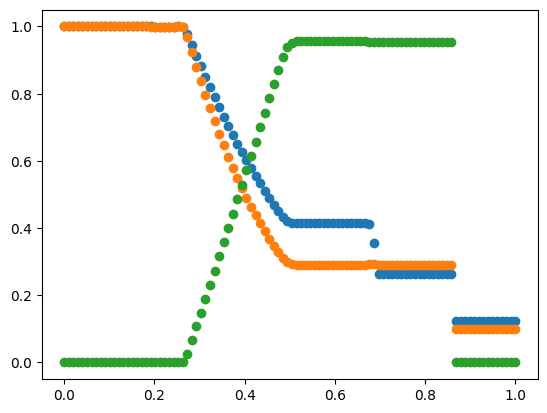

In [9]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()


In [442]:
xp= x.flatten()[:,None]
rhop= u_pred[:,0].flatten()[:,None]
up= u_pred[:,1].flatten()[:,None]
pp= u_pred[:,2].flatten()[:,None]
uxy= np.hstack((xp,rhop,up,pp))    
np.savetxt('shockCrho.dat', uxy)

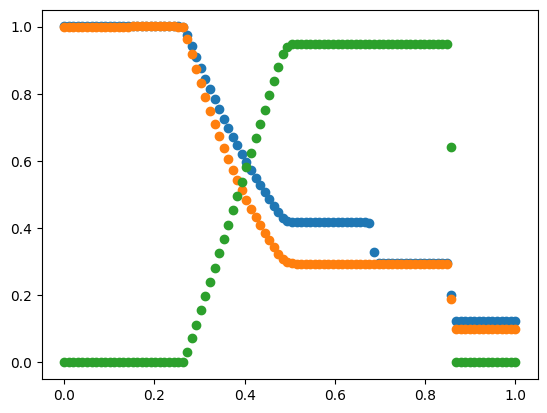

In [65]:
# first 15000step conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()

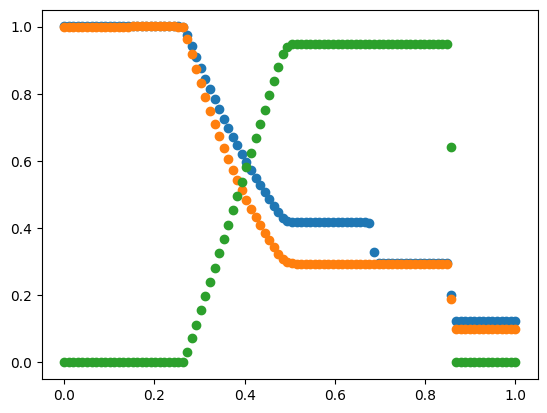

In [66]:
# first 15000step non-conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()